In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
from datetime import datetime
warnings.filterwarnings('ignore')

In [3]:
# Cell 2: Configuration
REGIONS = ['delhi', 'kolkata']
MEDICINES = {
    'delhi': ['paracetamol', 'ibuprofen', 'amoxicillin', 'cetirizine', 'salbutamol'],
    'kolkata': ['paracetamol', 'ibuprofen', 'amoxicillin', 'loperamide', 'metronidazole']
}

FESTIVAL_DATES = {
    'delhi': [
        '2020-10-25', '2021-11-04', '2022-10-24', '2023-11-12',  # Diwali
        '2020-08-03', '2021-08-22', '2022-08-11', '2023-08-30'   # Raksha Bandhan
    ],
    'kolkata': [
        '2020-10-25', '2021-11-04', '2022-10-24', '2023-11-12',  # Diwali
        '2020-10-22', '2021-10-15', '2022-10-05', '2023-10-24'   # Durga Puja
    ]
}

In [4]:
# Cell 3: Data Loading Functions
def load_data(region: str, medicine: str) -> pd.DataFrame:
    """Load and prepare data for Prophet"""
    file_path = Path(f"../../dataset/data/{region}/processed/{medicine}_prophet.csv")
    df = pd.read_csv(file_path)
    df['ds'] = pd.to_datetime(df['ds'])
    return df

def create_events_df(start_date: pd.Timestamp, end_date: pd.Timestamp, region: str) -> pd.DataFrame:
    """Create events dataframe with festival dates"""
    date_range = pd.date_range(start=start_date, end=end_date + pd.Timedelta(days=90))
    events_df = pd.DataFrame({'ds': date_range})
    events_df['special_event'] = 0
    
    # Mark festival dates
    festival_dates = pd.to_datetime(FESTIVAL_DATES[region])
    events_df.loc[events_df['ds'].isin(festival_dates), 'special_event'] = 1
    
    return events_df

In [5]:
# Cell 4: Model Training and Tuning Functions
def tune_prophet_hyperparameters(df: pd.DataFrame, events_df: pd.DataFrame = None) -> tuple:
    """Tune Prophet hyperparameters using grid search"""
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['multiplicative', 'additive']
    }
    
    best_params = {}
    best_rmse = float('inf')
    
    for cp in param_grid['changepoint_prior_scale']:
        for sp in param_grid['seasonality_prior_scale']:
            for sm in param_grid['seasonality_mode']:
                params = {
                    'changepoint_prior_scale': cp,
                    'seasonality_prior_scale': sp,
                    'seasonality_mode': sm,
                    'yearly_seasonality': True,
                    'weekly_seasonality': True,
                    'daily_seasonality': False
                }
                
                model = Prophet(**params)
                
                if events_df is not None:
                    df_with_events = df.merge(events_df, on='ds', how='left')
                    df_with_events['special_event'] = df_with_events['special_event'].fillna(0)
                    model.add_regressor('special_event', mode='multiplicative')
                    model.fit(df_with_events)
                else:
                    model.fit(df)
                
                # Cross validation
                df_cv = cross_validation(model, initial='365 days', period='90 days', horizon='90 days')
                df_p = performance_metrics(df_cv)
                rmse = df_p['rmse'].mean()
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = params
                
                print(f"Parameters: {params}")
                print(f"RMSE: {rmse:.2f}")
                print("---")
    
    return best_params, best_rmse

def train_model(df: pd.DataFrame, params: dict, events_df: pd.DataFrame = None) -> Prophet:
    """Train Prophet model with given parameters"""
    model = Prophet(**params)
    
    if events_df is not None:
        df_with_events = df.merge(events_df, on='ds', how='left')
        df_with_events['special_event'] = df_with_events['special_event'].fillna(0)
        model.add_regressor('special_event', mode='multiplicative')
        model.fit(df_with_events)
    else:
        model.fit(df)
    
    return model

In [6]:
# Cell 5: Evaluation Functions
def evaluate_model(y_true: np.array, y_pred: np.array) -> dict:
    """Calculate model evaluation metrics"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }

In [7]:
# Cell 6: Visualization Functions
def plot_forecast(model: Prophet, forecast: pd.DataFrame, title: str):
    """Plot forecast with components"""
    fig = model.plot(forecast)
    plt.title(f'{title} - Forecast')
    plt.show()
    
    fig = model.plot_components(forecast)
    plt.suptitle(f'{title} - Components')
    plt.tight_layout()
    plt.show()


In [8]:
# Cell 7: Main Training Loop - Start with Paracetamol
def train_single_medicine(region: str, medicine: str, include_events: bool = True) -> dict:
    """Train and evaluate model for a single medicine in a region"""
    print(f"\nTraining model for {medicine} in {region}")
    
    # Load data
    df = load_data(region, medicine)
    
    # Create events dataframe if needed
    events_df = None
    if include_events:
        events_df = create_events_df(df['ds'].min(), df['ds'].max(), region)
    
    # Tune hyperparameters
    print("\nTuning hyperparameters...")
    best_params, best_rmse = tune_prophet_hyperparameters(df, events_df)
    print(f"\nBest parameters: {best_params}")
    print(f"Best RMSE: {best_rmse:.2f}")
    
    # Train final model
    print("\nTraining final model...")
    model = train_model(df, best_params, events_df)
    
    # Generate forecast
    future = model.make_future_dataframe(periods=90)
    if events_df is not None:
        future = future.merge(events_df, on='ds', how='left')
        future['special_event'] = future['special_event'].fillna(0)
    
    forecast = model.predict(future)
    
    # Evaluate model
    metrics = evaluate_model(
        df['y'].values,
        forecast['yhat'][:len(df)]
    )
    
    # Plot results
    plot_forecast(model, forecast, f"{region.title()} - {medicine.title()}")
    
    return {
        'model': model,
        'forecast': forecast,
        'metrics': metrics,
        'params': best_params
    }



Training model for paracetamol in delhi

Tuning hyperparameters...


06:03:18 - cmdstanpy - INFO - Chain [1] start processing
06:03:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:18 - cmdstanpy - INFO - Chain [1] start processing
06:03:18 - cmdstanpy - INFO - Chain [1] done processing
06:03:19 - cmdstanpy - INFO - Chain [1] start processing
06:03:19 - cmdstanpy - INFO - Chain [1] done processing
06:03:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:03:19 - cmdstanpy - INFO - Chain [1] start processing
06:03:19 - cmdstanpy - INFO - Chain [1] done processing
06:03:19 - cmdstanpy - INFO - Chain [1] start processing
06:03:19 - cmdstanpy - INFO - Chain [1] done processing
06:03:19 - cmdstanpy - INFO - Chain [1] start processing
06:03:19 - cmdstanpy - INFO - Chain [1] done processing
06:03:20 - cmdstanpy - INFO - Chain [1] start processing
06:03:20 - cmdstanpy - INFO - Chain [1] done processing
06:03:20 - cmdstanpy - INFO - Chain [1] start processing
06:03:20 - cmdstanpy - INFO - Chain [1] done processing
06:03:20 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.66
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:21 - cmdstanpy - INFO - Chain [1] start processing
06:03:21 - cmdstanpy - INFO - Chain [1] done processing
06:03:21 - cmdstanpy - INFO - Chain [1] start processing
06:03:21 - cmdstanpy - INFO - Chain [1] done processing
06:03:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:03:21 - cmdstanpy - INFO - Chain [1] start processing
06:03:22 - cmdstanpy - INFO - Chain [1] done processing
06:03:22 - cmdstanpy - INFO - Chain [1] start processing
06:03:22 - cmdstanpy - INFO - Chain [1] done processing
06:03:22 - cmdstanpy - INFO - Chain [1] start processing
06:03:22 - cmdstanpy - INFO - Chain [1] done processing
06:03:22 - cmdstanpy - INFO - Chain [1] start processing
06:03:22 - cmdstanpy - INFO - Chain [1] done processing
06:03:22 - cmdstanpy - INFO - Chain [1] start processing
06:03:22 - cmdstanpy - INFO - Chain [1] done processing
06:03:22 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.44
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:24 - cmdstanpy - INFO - Chain [1] start processing
06:03:24 - cmdstanpy - INFO - Chain [1] done processing
06:03:24 - cmdstanpy - INFO - Chain [1] start processing
06:03:24 - cmdstanpy - INFO - Chain [1] done processing
06:03:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:03:24 - cmdstanpy - INFO - Chain [1] start processing
06:03:24 - cmdstanpy - INFO - Chain [1] done processing
06:03:24 - cmdstanpy - INFO - Chain [1] start processing
06:03:24 - cmdstanpy - INFO - Chain [1] done processing
06:03:25 - cmdstanpy - INFO - Chain [1] start processing
06:03:25 - cmdstanpy - INFO - Chain [1] done processing
06:03:25 - cmdstanpy - INFO - Chain [1] start processing
06:03:25 - cmdstanpy - INFO - Chain [1] done processing
06:03:25 - cmdstanpy - INFO - Chain [1] start processing
06:03:25 - cmdstanpy - INFO - Chain [1] done processing
06:03:25 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.80
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:26 - cmdstanpy - INFO - Chain [1] start processing
06:03:26 - cmdstanpy - INFO - Chain [1] done processing
06:03:26 - cmdstanpy - INFO - Chain [1] start processing
06:03:26 - cmdstanpy - INFO - Chain [1] done processing
06:03:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:03:26 - cmdstanpy - INFO - Chain [1] start processing
06:03:27 - cmdstanpy - INFO - Chain [1] done processing
06:03:27 - cmdstanpy - INFO - Chain [1] start processing
06:03:27 - cmdstanpy - INFO - Chain [1] done processing
06:03:28 - cmdstanpy - INFO - Chain [1] start processing
06:03:28 - cmdstanpy - INFO - Chain [1] done processing
06:03:28 - cmdstanpy - INFO - Chain [1] start processing
06:03:28 - cmdstanpy - INFO - Chain [1] done processing
06:03:28 - cmdstanpy - INFO - Chain [1] start processing
06:03:28 - cmdstanpy - INFO - Chain [1] done processing
06:03:28 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.44
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:29 - cmdstanpy - INFO - Chain [1] start processing
06:03:29 - cmdstanpy - INFO - Chain [1] done processing
06:03:29 - cmdstanpy - INFO - Chain [1] start processing
06:03:29 - cmdstanpy - INFO - Chain [1] done processing
06:03:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:03:29 - cmdstanpy - INFO - Chain [1] start processing
06:03:30 - cmdstanpy - INFO - Chain [1] done processing
06:03:30 - cmdstanpy - INFO - Chain [1] start processing
06:03:30 - cmdstanpy - INFO - Chain [1] done processing
06:03:30 - cmdstanpy - INFO - Chain [1] start processing
06:03:30 - cmdstanpy - INFO - Chain [1] done processing
06:03:30 - cmdstanpy - INFO - Chain [1] start processing
06:03:30 - cmdstanpy - INFO - Chain [1] done processing
06:03:30 - cmdstanpy - INFO - Chain [1] start processing
06:03:30 - cmdstanpy - INFO - Chain [1] done processing
06:03:31 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.76
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:32 - cmdstanpy - INFO - Chain [1] start processing
06:03:32 - cmdstanpy - INFO - Chain [1] done processing
06:03:32 - cmdstanpy - INFO - Chain [1] start processing
06:03:32 - cmdstanpy - INFO - Chain [1] done processing
06:03:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:03:32 - cmdstanpy - INFO - Chain [1] start processing
06:03:33 - cmdstanpy - INFO - Chain [1] done processing
06:03:33 - cmdstanpy - INFO - Chain [1] start processing
06:03:33 - cmdstanpy - INFO - Chain [1] done processing
06:03:33 - cmdstanpy - INFO - Chain [1] start processing
06:03:33 - cmdstanpy - INFO - Chain [1] done processing
06:03:33 - cmdstanpy - INFO - Chain [1] start processing
06:03:33 - cmdstanpy - INFO - Chain [1] done processing
06:03:33 - cmdstanpy - INFO - Chain [1] start processing
06:03:33 - cmdstanpy - INFO - Chain [1] done processing
06:03:33 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.60
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:34 - cmdstanpy - INFO - Chain [1] start processing
06:03:34 - cmdstanpy - INFO - Chain [1] done processing
06:03:35 - cmdstanpy - INFO - Chain [1] start processing
06:03:35 - cmdstanpy - INFO - Chain [1] done processing
06:03:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:03:35 - cmdstanpy - INFO - Chain [1] start processing
06:03:35 - cmdstanpy - INFO - Chain [1] done processing
06:03:35 - cmdstanpy - INFO - Chain [1] start processing
06:03:35 - cmdstanpy - INFO - Chain [1] done processing
06:03:35 - cmdstanpy - INFO - Chain [1] start processing
06:03:35 - cmdstanpy - INFO - Chain [1] done processing
06:03:35 - cmdstanpy - INFO - Chain [1] start processing
06:03:36 - cmdstanpy - INFO - Chain [1] done processing
06:03:36 - cmdstanpy - INFO - Chain [1] start processing
06:03:36 - cmdstanpy - INFO - Chain [1] done processing
06:03:36 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.47
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:37 - cmdstanpy - INFO - Chain [1] start processing
06:03:37 - cmdstanpy - INFO - Chain [1] done processing
06:03:37 - cmdstanpy - INFO - Chain [1] start processing
06:03:37 - cmdstanpy - INFO - Chain [1] done processing
06:03:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:03:37 - cmdstanpy - INFO - Chain [1] start processing
06:03:37 - cmdstanpy - INFO - Chain [1] done processing
06:03:38 - cmdstanpy - INFO - Chain [1] start processing
06:03:38 - cmdstanpy - INFO - Chain [1] done processing
06:03:38 - cmdstanpy - INFO - Chain [1] start processing
06:03:38 - cmdstanpy - INFO - Chain [1] done processing
06:03:38 - cmdstanpy - INFO - Chain [1] start processing
06:03:38 - cmdstanpy - INFO - Chain [1] done processing
06:03:38 - cmdstanpy - INFO - Chain [1] start processing
06:03:38 - cmdstanpy - INFO - Chain [1] done processing
06:03:38 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.35
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:39 - cmdstanpy - INFO - Chain [1] start processing
06:03:39 - cmdstanpy - INFO - Chain [1] done processing
06:03:39 - cmdstanpy - INFO - Chain [1] start processing
06:03:39 - cmdstanpy - INFO - Chain [1] done processing
06:03:40 - cmdstanpy - INFO - Chain [1] start processing
06:03:40 - cmdstanpy - INFO - Chain [1] done processing
06:03:40 - cmdstanpy - INFO - Chain [1] start processing
06:03:40 - cmdstanpy - INFO - Chain [1] done processing
06:03:40 - cmdstanpy - INFO - Chain [1] start processing
06:03:40 - cmdstanpy - INFO - Chain [1] done processing
06:03:40 - cmdstanpy - INFO - Chain [1] start processing
06:03:40 - cmdstanpy - INFO - Chain [1] done processing
06:03:40 - cmdstanpy - INFO - Chain [1] start processing
06:03:40 - cmdstanpy - INFO - Chain [1] done processing
06:03:40 - cmdstanpy - INFO - Chain [1] start processing
06:03:40 - cmdstanpy - INFO - Chain [1] done processing
06:03:41 - cmdstanpy - INFO - Chain [1] start processing
06:03:41 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.11
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:41 - cmdstanpy - INFO - Chain [1] start processing
06:03:41 - cmdstanpy - INFO - Chain [1] done processing
06:03:42 - cmdstanpy - INFO - Chain [1] start processing
06:03:42 - cmdstanpy - INFO - Chain [1] done processing
06:03:42 - cmdstanpy - INFO - Chain [1] start processing
06:03:42 - cmdstanpy - INFO - Chain [1] done processing
06:03:42 - cmdstanpy - INFO - Chain [1] start processing
06:03:42 - cmdstanpy - INFO - Chain [1] done processing
06:03:42 - cmdstanpy - INFO - Chain [1] start processing
06:03:42 - cmdstanpy - INFO - Chain [1] done processing
06:03:42 - cmdstanpy - INFO - Chain [1] start processing
06:03:42 - cmdstanpy - INFO - Chain [1] done processing
06:03:42 - cmdstanpy - INFO - Chain [1] start processing
06:03:42 - cmdstanpy - INFO - Chain [1] done processing
06:03:43 - cmdstanpy - INFO - Chain [1] start processing
06:03:43 - cmdstanpy - INFO - Chain [1] done processing
06:03:43 - cmdstanpy - INFO - Chain [1] start processing
06:03:43 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.44
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:44 - cmdstanpy - INFO - Chain [1] start processing
06:03:44 - cmdstanpy - INFO - Chain [1] done processing
06:03:44 - cmdstanpy - INFO - Chain [1] start processing
06:03:44 - cmdstanpy - INFO - Chain [1] done processing
06:03:44 - cmdstanpy - INFO - Chain [1] start processing
06:03:44 - cmdstanpy - INFO - Chain [1] done processing
06:03:44 - cmdstanpy - INFO - Chain [1] start processing
06:03:44 - cmdstanpy - INFO - Chain [1] done processing
06:03:44 - cmdstanpy - INFO - Chain [1] start processing
06:03:44 - cmdstanpy - INFO - Chain [1] done processing
06:03:44 - cmdstanpy - INFO - Chain [1] start processing
06:03:44 - cmdstanpy - INFO - Chain [1] done processing
06:03:45 - cmdstanpy - INFO - Chain [1] start processing
06:03:45 - cmdstanpy - INFO - Chain [1] done processing
06:03:45 - cmdstanpy - INFO - Chain [1] start processing
06:03:45 - cmdstanpy - INFO - Chain [1] done processing
06:03:45 - cmdstanpy - INFO - Chain [1] start processing
06:03:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 40.68
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:46 - cmdstanpy - INFO - Chain [1] start processing
06:03:46 - cmdstanpy - INFO - Chain [1] done processing
06:03:46 - cmdstanpy - INFO - Chain [1] start processing
06:03:46 - cmdstanpy - INFO - Chain [1] done processing
06:03:46 - cmdstanpy - INFO - Chain [1] start processing
06:03:46 - cmdstanpy - INFO - Chain [1] done processing
06:03:46 - cmdstanpy - INFO - Chain [1] start processing
06:03:46 - cmdstanpy - INFO - Chain [1] done processing
06:03:46 - cmdstanpy - INFO - Chain [1] start processing
06:03:47 - cmdstanpy - INFO - Chain [1] done processing
06:03:47 - cmdstanpy - INFO - Chain [1] start processing
06:03:47 - cmdstanpy - INFO - Chain [1] done processing
06:03:47 - cmdstanpy - INFO - Chain [1] start processing
06:03:47 - cmdstanpy - INFO - Chain [1] done processing
06:03:47 - cmdstanpy - INFO - Chain [1] start processing
06:03:47 - cmdstanpy - INFO - Chain [1] done processing
06:03:47 - cmdstanpy - INFO - Chain [1] start processing
06:03:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.56
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:48 - cmdstanpy - INFO - Chain [1] start processing
06:03:48 - cmdstanpy - INFO - Chain [1] done processing
06:03:48 - cmdstanpy - INFO - Chain [1] start processing
06:03:48 - cmdstanpy - INFO - Chain [1] done processing
06:03:48 - cmdstanpy - INFO - Chain [1] start processing
06:03:48 - cmdstanpy - INFO - Chain [1] done processing
06:03:49 - cmdstanpy - INFO - Chain [1] start processing
06:03:49 - cmdstanpy - INFO - Chain [1] done processing
06:03:49 - cmdstanpy - INFO - Chain [1] start processing
06:03:49 - cmdstanpy - INFO - Chain [1] done processing
06:03:49 - cmdstanpy - INFO - Chain [1] start processing
06:03:49 - cmdstanpy - INFO - Chain [1] done processing
06:03:49 - cmdstanpy - INFO - Chain [1] start processing
06:03:49 - cmdstanpy - INFO - Chain [1] done processing
06:03:49 - cmdstanpy - INFO - Chain [1] start processing
06:03:49 - cmdstanpy - INFO - Chain [1] done processing
06:03:49 - cmdstanpy - INFO - Chain [1] start processing
06:03:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.22
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:50 - cmdstanpy - INFO - Chain [1] start processing
06:03:50 - cmdstanpy - INFO - Chain [1] done processing
06:03:50 - cmdstanpy - INFO - Chain [1] start processing
06:03:51 - cmdstanpy - INFO - Chain [1] done processing
06:03:51 - cmdstanpy - INFO - Chain [1] start processing
06:03:51 - cmdstanpy - INFO - Chain [1] done processing
06:03:51 - cmdstanpy - INFO - Chain [1] start processing
06:03:51 - cmdstanpy - INFO - Chain [1] done processing
06:03:51 - cmdstanpy - INFO - Chain [1] start processing
06:03:51 - cmdstanpy - INFO - Chain [1] done processing
06:03:51 - cmdstanpy - INFO - Chain [1] start processing
06:03:51 - cmdstanpy - INFO - Chain [1] done processing
06:03:51 - cmdstanpy - INFO - Chain [1] start processing
06:03:51 - cmdstanpy - INFO - Chain [1] done processing
06:03:51 - cmdstanpy - INFO - Chain [1] start processing
06:03:51 - cmdstanpy - INFO - Chain [1] done processing
06:03:52 - cmdstanpy - INFO - Chain [1] start processing
06:03:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.70
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:53 - cmdstanpy - INFO - Chain [1] start processing
06:03:53 - cmdstanpy - INFO - Chain [1] done processing
06:03:53 - cmdstanpy - INFO - Chain [1] start processing
06:03:53 - cmdstanpy - INFO - Chain [1] done processing
06:03:53 - cmdstanpy - INFO - Chain [1] start processing
06:03:53 - cmdstanpy - INFO - Chain [1] done processing
06:03:53 - cmdstanpy - INFO - Chain [1] start processing
06:03:53 - cmdstanpy - INFO - Chain [1] done processing
06:03:53 - cmdstanpy - INFO - Chain [1] start processing
06:03:53 - cmdstanpy - INFO - Chain [1] done processing
06:03:53 - cmdstanpy - INFO - Chain [1] start processing
06:03:53 - cmdstanpy - INFO - Chain [1] done processing
06:03:53 - cmdstanpy - INFO - Chain [1] start processing
06:03:54 - cmdstanpy - INFO - Chain [1] done processing
06:03:54 - cmdstanpy - INFO - Chain [1] start processing
06:03:54 - cmdstanpy - INFO - Chain [1] done processing
06:03:54 - cmdstanpy - INFO - Chain [1] start processing
06:03:54 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.15
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:55 - cmdstanpy - INFO - Chain [1] start processing
06:03:55 - cmdstanpy - INFO - Chain [1] done processing
06:03:55 - cmdstanpy - INFO - Chain [1] start processing
06:03:55 - cmdstanpy - INFO - Chain [1] done processing
06:03:55 - cmdstanpy - INFO - Chain [1] start processing
06:03:55 - cmdstanpy - INFO - Chain [1] done processing
06:03:55 - cmdstanpy - INFO - Chain [1] start processing
06:03:55 - cmdstanpy - INFO - Chain [1] done processing
06:03:55 - cmdstanpy - INFO - Chain [1] start processing
06:03:55 - cmdstanpy - INFO - Chain [1] done processing
06:03:56 - cmdstanpy - INFO - Chain [1] start processing
06:03:56 - cmdstanpy - INFO - Chain [1] done processing
06:03:56 - cmdstanpy - INFO - Chain [1] start processing
06:03:56 - cmdstanpy - INFO - Chain [1] done processing
06:03:56 - cmdstanpy - INFO - Chain [1] start processing
06:03:56 - cmdstanpy - INFO - Chain [1] done processing
06:03:56 - cmdstanpy - INFO - Chain [1] start processing
06:03:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.88
---


06:03:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:03:57 - cmdstanpy - INFO - Chain [1] start processing
06:03:57 - cmdstanpy - INFO - Chain [1] done processing
06:03:57 - cmdstanpy - INFO - Chain [1] start processing
06:03:57 - cmdstanpy - INFO - Chain [1] done processing
06:03:57 - cmdstanpy - INFO - Chain [1] start processing
06:03:57 - cmdstanpy - INFO - Chain [1] done processing
06:03:58 - cmdstanpy - INFO - Chain [1] start processing
06:03:58 - cmdstanpy - INFO - Chain [1] done processing
06:03:58 - cmdstanpy - INFO - Chain [1] start processing
06:03:58 - cmdstanpy - INFO - Chain [1] done processing
06:03:58 - cmdstanpy - INFO - Chain [1] start processing
06:03:58 - cmdstanpy - INFO - Chain [1] done processing
06:03:58 - cmdstanpy - INFO - Chain [1] start processing
06:03:58 - cmdstanpy - INFO - Chain [1] done processing
06:03:58 - cmdstanpy - INFO - Chain [1] start processing
06:03:58 - cmdstanpy - INFO - Chain [1] done processing
06:03:58 - cmdstanpy - INFO - Chain [1] start processing
06:03:59 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.30
---


06:04:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:00 - cmdstanpy - INFO - Chain [1] start processing
06:04:00 - cmdstanpy - INFO - Chain [1] done processing
06:04:00 - cmdstanpy - INFO - Chain [1] start processing
06:04:00 - cmdstanpy - INFO - Chain [1] done processing
06:04:00 - cmdstanpy - INFO - Chain [1] start processing
06:04:00 - cmdstanpy - INFO - Chain [1] done processing
06:04:00 - cmdstanpy - INFO - Chain [1] start processing
06:04:00 - cmdstanpy - INFO - Chain [1] done processing
06:04:00 - cmdstanpy - INFO - Chain [1] start processing
06:04:00 - cmdstanpy - INFO - Chain [1] done processing
06:04:00 - cmdstanpy - INFO - Chain [1] start processing
06:04:00 - cmdstanpy - INFO - Chain [1] done processing
06:04:01 - cmdstanpy - INFO - Chain [1] start processing
06:04:01 - cmdstanpy - INFO - Chain [1] done processing
06:04:01 - cmdstanpy - INFO - Chain [1] start processing
06:04:01 - cmdstanpy - INFO - Chain [1] done processing
06:04:01 - cmdstanpy - INFO - Chain [1] start processing
06:04:01 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.86
---


06:04:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:02 - cmdstanpy - INFO - Chain [1] start processing
06:04:02 - cmdstanpy - INFO - Chain [1] done processing
06:04:02 - cmdstanpy - INFO - Chain [1] start processing
06:04:02 - cmdstanpy - INFO - Chain [1] done processing
06:04:02 - cmdstanpy - INFO - Chain [1] start processing
06:04:02 - cmdstanpy - INFO - Chain [1] done processing
06:04:03 - cmdstanpy - INFO - Chain [1] start processing
06:04:03 - cmdstanpy - INFO - Chain [1] done processing
06:04:03 - cmdstanpy - INFO - Chain [1] start processing
06:04:03 - cmdstanpy - INFO - Chain [1] done processing
06:04:03 - cmdstanpy - INFO - Chain [1] start processing
06:04:03 - cmdstanpy - INFO - Chain [1] done processing
06:04:03 - cmdstanpy - INFO - Chain [1] start processing
06:04:03 - cmdstanpy - INFO - Chain [1] done processing
06:04:03 - cmdstanpy - INFO - Chain [1] start processing
06:04:03 - cmdstanpy - INFO - Chain [1] done processing
06:04:03 - cmdstanpy - INFO - Chain [1] start processing
06:04:04 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.15
---


06:04:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:05 - cmdstanpy - INFO - Chain [1] start processing
06:04:05 - cmdstanpy - INFO - Chain [1] done processing
06:04:05 - cmdstanpy - INFO - Chain [1] start processing
06:04:05 - cmdstanpy - INFO - Chain [1] done processing
06:04:05 - cmdstanpy - INFO - Chain [1] start processing
06:04:05 - cmdstanpy - INFO - Chain [1] done processing
06:04:05 - cmdstanpy - INFO - Chain [1] start processing
06:04:05 - cmdstanpy - INFO - Chain [1] done processing
06:04:05 - cmdstanpy - INFO - Chain [1] start processing
06:04:05 - cmdstanpy - INFO - Chain [1] done processing
06:04:05 - cmdstanpy - INFO - Chain [1] start processing
06:04:06 - cmdstanpy - INFO - Chain [1] done processing
06:04:06 - cmdstanpy - INFO - Chain [1] start processing
06:04:06 - cmdstanpy - INFO - Chain [1] done processing
06:04:06 - cmdstanpy - INFO - Chain [1] start processing
06:04:06 - cmdstanpy - INFO - Chain [1] done processing
06:04:06 - cmdstanpy - INFO - Chain [1] start processing
06:04:06 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.98
---


06:04:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:07 - cmdstanpy - INFO - Chain [1] start processing
06:04:07 - cmdstanpy - INFO - Chain [1] done processing
06:04:07 - cmdstanpy - INFO - Chain [1] start processing
06:04:07 - cmdstanpy - INFO - Chain [1] done processing
06:04:08 - cmdstanpy - INFO - Chain [1] start processing
06:04:08 - cmdstanpy - INFO - Chain [1] done processing
06:04:08 - cmdstanpy - INFO - Chain [1] start processing
06:04:08 - cmdstanpy - INFO - Chain [1] done processing
06:04:08 - cmdstanpy - INFO - Chain [1] start processing
06:04:08 - cmdstanpy - INFO - Chain [1] done processing
06:04:08 - cmdstanpy - INFO - Chain [1] start processing
06:04:08 - cmdstanpy - INFO - Chain [1] done processing
06:04:08 - cmdstanpy - INFO - Chain [1] start processing
06:04:08 - cmdstanpy - INFO - Chain [1] done processing
06:04:08 - cmdstanpy - INFO - Chain [1] start processing
06:04:09 - cmdstanpy - INFO - Chain [1] done processing
06:04:09 - cmdstanpy - INFO - Chain [1] start processing
06:04:09 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.64
---


06:04:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:10 - cmdstanpy - INFO - Chain [1] start processing
06:04:10 - cmdstanpy - INFO - Chain [1] done processing
06:04:10 - cmdstanpy - INFO - Chain [1] start processing
06:04:10 - cmdstanpy - INFO - Chain [1] done processing
06:04:10 - cmdstanpy - INFO - Chain [1] start processing
06:04:10 - cmdstanpy - INFO - Chain [1] done processing
06:04:10 - cmdstanpy - INFO - Chain [1] start processing
06:04:10 - cmdstanpy - INFO - Chain [1] done processing
06:04:10 - cmdstanpy - INFO - Chain [1] start processing
06:04:11 - cmdstanpy - INFO - Chain [1] done processing
06:04:11 - cmdstanpy - INFO - Chain [1] start processing
06:04:11 - cmdstanpy - INFO - Chain [1] done processing
06:04:11 - cmdstanpy - INFO - Chain [1] start processing
06:04:11 - cmdstanpy - INFO - Chain [1] done processing
06:04:11 - cmdstanpy - INFO - Chain [1] start processing
06:04:11 - cmdstanpy - INFO - Chain [1] done processing
06:04:11 - cmdstanpy - INFO - Chain [1] start processing
06:04:11 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.19
---


06:04:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:13 - cmdstanpy - INFO - Chain [1] start processing
06:04:13 - cmdstanpy - INFO - Chain [1] done processing
06:04:13 - cmdstanpy - INFO - Chain [1] start processing
06:04:13 - cmdstanpy - INFO - Chain [1] done processing
06:04:13 - cmdstanpy - INFO - Chain [1] start processing
06:04:13 - cmdstanpy - INFO - Chain [1] done processing
06:04:13 - cmdstanpy - INFO - Chain [1] start processing
06:04:13 - cmdstanpy - INFO - Chain [1] done processing
06:04:13 - cmdstanpy - INFO - Chain [1] start processing
06:04:13 - cmdstanpy - INFO - Chain [1] done processing
06:04:13 - cmdstanpy - INFO - Chain [1] start processing
06:04:13 - cmdstanpy - INFO - Chain [1] done processing
06:04:14 - cmdstanpy - INFO - Chain [1] start processing
06:04:14 - cmdstanpy - INFO - Chain [1] done processing
06:04:14 - cmdstanpy - INFO - Chain [1] start processing
06:04:14 - cmdstanpy - INFO - Chain [1] done processing
06:04:14 - cmdstanpy - INFO - Chain [1] start processing
06:04:14 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.54
---


06:04:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:15 - cmdstanpy - INFO - Chain [1] start processing
06:04:15 - cmdstanpy - INFO - Chain [1] done processing
06:04:15 - cmdstanpy - INFO - Chain [1] start processing
06:04:15 - cmdstanpy - INFO - Chain [1] done processing
06:04:15 - cmdstanpy - INFO - Chain [1] start processing
06:04:15 - cmdstanpy - INFO - Chain [1] done processing
06:04:16 - cmdstanpy - INFO - Chain [1] start processing
06:04:16 - cmdstanpy - INFO - Chain [1] done processing
06:04:16 - cmdstanpy - INFO - Chain [1] start processing
06:04:16 - cmdstanpy - INFO - Chain [1] done processing
06:04:16 - cmdstanpy - INFO - Chain [1] start processing
06:04:16 - cmdstanpy - INFO - Chain [1] done processing
06:04:16 - cmdstanpy - INFO - Chain [1] start processing
06:04:16 - cmdstanpy - INFO - Chain [1] done processing
06:04:16 - cmdstanpy - INFO - Chain [1] start processing
06:04:16 - cmdstanpy - INFO - Chain [1] done processing
06:04:16 - cmdstanpy - INFO - Chain [1] start processing
06:04:17 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.70
---


06:04:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:18 - cmdstanpy - INFO - Chain [1] start processing
06:04:18 - cmdstanpy - INFO - Chain [1] done processing
06:04:18 - cmdstanpy - INFO - Chain [1] start processing
06:04:18 - cmdstanpy - INFO - Chain [1] done processing
06:04:18 - cmdstanpy - INFO - Chain [1] start processing
06:04:18 - cmdstanpy - INFO - Chain [1] done processing
06:04:18 - cmdstanpy - INFO - Chain [1] start processing
06:04:18 - cmdstanpy - INFO - Chain [1] done processing
06:04:18 - cmdstanpy - INFO - Chain [1] start processing
06:04:18 - cmdstanpy - INFO - Chain [1] done processing
06:04:18 - cmdstanpy - INFO - Chain [1] start processing
06:04:19 - cmdstanpy - INFO - Chain [1] done processing
06:04:19 - cmdstanpy - INFO - Chain [1] start processing
06:04:19 - cmdstanpy - INFO - Chain [1] done processing
06:04:19 - cmdstanpy - INFO - Chain [1] start processing
06:04:19 - cmdstanpy - INFO - Chain [1] done processing
06:04:19 - cmdstanpy - INFO - Chain [1] start processing
06:04:19 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.19
---


06:04:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:21 - cmdstanpy - INFO - Chain [1] start processing
06:04:21 - cmdstanpy - INFO - Chain [1] done processing
06:04:21 - cmdstanpy - INFO - Chain [1] start processing
06:04:21 - cmdstanpy - INFO - Chain [1] done processing
06:04:21 - cmdstanpy - INFO - Chain [1] start processing
06:04:21 - cmdstanpy - INFO - Chain [1] done processing
06:04:21 - cmdstanpy - INFO - Chain [1] start processing
06:04:21 - cmdstanpy - INFO - Chain [1] done processing
06:04:21 - cmdstanpy - INFO - Chain [1] start processing
06:04:21 - cmdstanpy - INFO - Chain [1] done processing
06:04:21 - cmdstanpy - INFO - Chain [1] start processing
06:04:22 - cmdstanpy - INFO - Chain [1] done processing
06:04:22 - cmdstanpy - INFO - Chain [1] start processing
06:04:22 - cmdstanpy - INFO - Chain [1] done processing
06:04:22 - cmdstanpy - INFO - Chain [1] start processing
06:04:22 - cmdstanpy - INFO - Chain [1] done processing
06:04:22 - cmdstanpy - INFO - Chain [1] start processing
06:04:22 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.14
---


06:04:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:24 - cmdstanpy - INFO - Chain [1] start processing
06:04:24 - cmdstanpy - INFO - Chain [1] done processing
06:04:24 - cmdstanpy - INFO - Chain [1] start processing
06:04:24 - cmdstanpy - INFO - Chain [1] done processing
06:04:24 - cmdstanpy - INFO - Chain [1] start processing
06:04:24 - cmdstanpy - INFO - Chain [1] done processing
06:04:24 - cmdstanpy - INFO - Chain [1] start processing
06:04:24 - cmdstanpy - INFO - Chain [1] done processing
06:04:25 - cmdstanpy - INFO - Chain [1] start processing
06:04:25 - cmdstanpy - INFO - Chain [1] done processing
06:04:25 - cmdstanpy - INFO - Chain [1] start processing
06:04:25 - cmdstanpy - INFO - Chain [1] done processing
06:04:25 - cmdstanpy - INFO - Chain [1] start processing
06:04:25 - cmdstanpy - INFO - Chain [1] done processing
06:04:25 - cmdstanpy - INFO - Chain [1] start processing
06:04:25 - cmdstanpy - INFO - Chain [1] done processing
06:04:25 - cmdstanpy - INFO - Chain [1] start processing
06:04:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.82
---


06:04:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:27 - cmdstanpy - INFO - Chain [1] start processing
06:04:27 - cmdstanpy - INFO - Chain [1] done processing
06:04:27 - cmdstanpy - INFO - Chain [1] start processing
06:04:27 - cmdstanpy - INFO - Chain [1] done processing
06:04:27 - cmdstanpy - INFO - Chain [1] start processing
06:04:27 - cmdstanpy - INFO - Chain [1] done processing
06:04:27 - cmdstanpy - INFO - Chain [1] start processing
06:04:27 - cmdstanpy - INFO - Chain [1] done processing
06:04:27 - cmdstanpy - INFO - Chain [1] start processing
06:04:28 - cmdstanpy - INFO - Chain [1] done processing
06:04:28 - cmdstanpy - INFO - Chain [1] start processing
06:04:28 - cmdstanpy - INFO - Chain [1] done processing
06:04:28 - cmdstanpy - INFO - Chain [1] start processing
06:04:28 - cmdstanpy - INFO - Chain [1] done processing
06:04:28 - cmdstanpy - INFO - Chain [1] start processing
06:04:28 - cmdstanpy - INFO - Chain [1] done processing
06:04:28 - cmdstanpy - INFO - Chain [1] start processing
06:04:28 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.48
---


06:04:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:30 - cmdstanpy - INFO - Chain [1] start processing
06:04:30 - cmdstanpy - INFO - Chain [1] done processing
06:04:30 - cmdstanpy - INFO - Chain [1] start processing
06:04:30 - cmdstanpy - INFO - Chain [1] done processing
06:04:30 - cmdstanpy - INFO - Chain [1] start processing
06:04:30 - cmdstanpy - INFO - Chain [1] done processing
06:04:30 - cmdstanpy - INFO - Chain [1] start processing
06:04:30 - cmdstanpy - INFO - Chain [1] done processing
06:04:30 - cmdstanpy - INFO - Chain [1] start processing
06:04:31 - cmdstanpy - INFO - Chain [1] done processing
06:04:31 - cmdstanpy - INFO - Chain [1] start processing
06:04:31 - cmdstanpy - INFO - Chain [1] done processing
06:04:31 - cmdstanpy - INFO - Chain [1] start processing
06:04:31 - cmdstanpy - INFO - Chain [1] done processing
06:04:31 - cmdstanpy - INFO - Chain [1] start processing
06:04:31 - cmdstanpy - INFO - Chain [1] done processing
06:04:31 - cmdstanpy - INFO - Chain [1] start processing
06:04:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.71
---


06:04:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:33 - cmdstanpy - INFO - Chain [1] start processing
06:04:33 - cmdstanpy - INFO - Chain [1] done processing
06:04:33 - cmdstanpy - INFO - Chain [1] start processing
06:04:33 - cmdstanpy - INFO - Chain [1] done processing
06:04:33 - cmdstanpy - INFO - Chain [1] start processing
06:04:33 - cmdstanpy - INFO - Chain [1] done processing
06:04:33 - cmdstanpy - INFO - Chain [1] start processing
06:04:33 - cmdstanpy - INFO - Chain [1] done processing
06:04:33 - cmdstanpy - INFO - Chain [1] start processing
06:04:33 - cmdstanpy - INFO - Chain [1] done processing
06:04:34 - cmdstanpy - INFO - Chain [1] start processing
06:04:34 - cmdstanpy - INFO - Chain [1] done processing
06:04:34 - cmdstanpy - INFO - Chain [1] start processing
06:04:34 - cmdstanpy - INFO - Chain [1] done processing
06:04:34 - cmdstanpy - INFO - Chain [1] start processing
06:04:34 - cmdstanpy - INFO - Chain [1] done processing
06:04:34 - cmdstanpy - INFO - Chain [1] start processing
06:04:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.35
---


06:04:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:36 - cmdstanpy - INFO - Chain [1] start processing
06:04:36 - cmdstanpy - INFO - Chain [1] done processing
06:04:36 - cmdstanpy - INFO - Chain [1] start processing
06:04:36 - cmdstanpy - INFO - Chain [1] done processing
06:04:36 - cmdstanpy - INFO - Chain [1] start processing
06:04:36 - cmdstanpy - INFO - Chain [1] done processing
06:04:36 - cmdstanpy - INFO - Chain [1] start processing
06:04:36 - cmdstanpy - INFO - Chain [1] done processing
06:04:36 - cmdstanpy - INFO - Chain [1] start processing
06:04:37 - cmdstanpy - INFO - Chain [1] done processing
06:04:37 - cmdstanpy - INFO - Chain [1] start processing
06:04:37 - cmdstanpy - INFO - Chain [1] done processing
06:04:37 - cmdstanpy - INFO - Chain [1] start processing
06:04:37 - cmdstanpy - INFO - Chain [1] done processing
06:04:37 - cmdstanpy - INFO - Chain [1] start processing
06:04:37 - cmdstanpy - INFO - Chain [1] done processing
06:04:37 - cmdstanpy - INFO - Chain [1] start processing
06:04:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.87
---


06:04:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:39 - cmdstanpy - INFO - Chain [1] start processing
06:04:39 - cmdstanpy - INFO - Chain [1] done processing
06:04:39 - cmdstanpy - INFO - Chain [1] start processing
06:04:39 - cmdstanpy - INFO - Chain [1] done processing
06:04:39 - cmdstanpy - INFO - Chain [1] start processing
06:04:39 - cmdstanpy - INFO - Chain [1] done processing
06:04:39 - cmdstanpy - INFO - Chain [1] start processing
06:04:39 - cmdstanpy - INFO - Chain [1] done processing
06:04:39 - cmdstanpy - INFO - Chain [1] start processing
06:04:40 - cmdstanpy - INFO - Chain [1] done processing
06:04:40 - cmdstanpy - INFO - Chain [1] start processing
06:04:40 - cmdstanpy - INFO - Chain [1] done processing
06:04:40 - cmdstanpy - INFO - Chain [1] start processing
06:04:40 - cmdstanpy - INFO - Chain [1] done processing
06:04:40 - cmdstanpy - INFO - Chain [1] start processing
06:04:40 - cmdstanpy - INFO - Chain [1] done processing
06:04:40 - cmdstanpy - INFO - Chain [1] start processing
06:04:40 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.18
---


06:04:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:42 - cmdstanpy - INFO - Chain [1] start processing
06:04:42 - cmdstanpy - INFO - Chain [1] done processing
06:04:42 - cmdstanpy - INFO - Chain [1] start processing
06:04:42 - cmdstanpy - INFO - Chain [1] done processing
06:04:42 - cmdstanpy - INFO - Chain [1] start processing
06:04:43 - cmdstanpy - INFO - Chain [1] done processing
06:04:43 - cmdstanpy - INFO - Chain [1] start processing
06:04:43 - cmdstanpy - INFO - Chain [1] done processing
06:04:43 - cmdstanpy - INFO - Chain [1] start processing
06:04:43 - cmdstanpy - INFO - Chain [1] done processing
06:04:43 - cmdstanpy - INFO - Chain [1] start processing
06:04:43 - cmdstanpy - INFO - Chain [1] done processing
06:04:44 - cmdstanpy - INFO - Chain [1] start processing
06:04:44 - cmdstanpy - INFO - Chain [1] done processing
06:04:44 - cmdstanpy - INFO - Chain [1] start processing
06:04:44 - cmdstanpy - INFO - Chain [1] done processing
06:04:44 - cmdstanpy - INFO - Chain [1] start processing
06:04:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.38
---


06:04:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:47 - cmdstanpy - INFO - Chain [1] start processing
06:04:47 - cmdstanpy - INFO - Chain [1] done processing
06:04:47 - cmdstanpy - INFO - Chain [1] start processing
06:04:47 - cmdstanpy - INFO - Chain [1] done processing
06:04:47 - cmdstanpy - INFO - Chain [1] start processing
06:04:47 - cmdstanpy - INFO - Chain [1] done processing
06:04:47 - cmdstanpy - INFO - Chain [1] start processing
06:04:48 - cmdstanpy - INFO - Chain [1] done processing
06:04:48 - cmdstanpy - INFO - Chain [1] start processing
06:04:48 - cmdstanpy - INFO - Chain [1] done processing
06:04:48 - cmdstanpy - INFO - Chain [1] start processing
06:04:48 - cmdstanpy - INFO - Chain [1] done processing
06:04:48 - cmdstanpy - INFO - Chain [1] start processing
06:04:49 - cmdstanpy - INFO - Chain [1] done processing
06:04:49 - cmdstanpy - INFO - Chain [1] start processing
06:04:49 - cmdstanpy - INFO - Chain [1] done processing
06:04:49 - cmdstanpy - INFO - Chain [1] start processing
06:04:50 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.90
---


06:04:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:52 - cmdstanpy - INFO - Chain [1] start processing
06:04:52 - cmdstanpy - INFO - Chain [1] done processing
06:04:52 - cmdstanpy - INFO - Chain [1] start processing
06:04:52 - cmdstanpy - INFO - Chain [1] done processing
06:04:52 - cmdstanpy - INFO - Chain [1] start processing
06:04:52 - cmdstanpy - INFO - Chain [1] done processing
06:04:52 - cmdstanpy - INFO - Chain [1] start processing
06:04:53 - cmdstanpy - INFO - Chain [1] done processing
06:04:53 - cmdstanpy - INFO - Chain [1] start processing
06:04:53 - cmdstanpy - INFO - Chain [1] done processing
06:04:53 - cmdstanpy - INFO - Chain [1] start processing
06:04:53 - cmdstanpy - INFO - Chain [1] done processing
06:04:53 - cmdstanpy - INFO - Chain [1] start processing
06:04:54 - cmdstanpy - INFO - Chain [1] done processing
06:04:54 - cmdstanpy - INFO - Chain [1] start processing
06:04:54 - cmdstanpy - INFO - Chain [1] done processing
06:04:54 - cmdstanpy - INFO - Chain [1] start processing
06:04:55 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.92
---


06:04:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:04:57 - cmdstanpy - INFO - Chain [1] start processing
06:04:57 - cmdstanpy - INFO - Chain [1] done processing
06:04:57 - cmdstanpy - INFO - Chain [1] start processing
06:04:57 - cmdstanpy - INFO - Chain [1] done processing
06:04:57 - cmdstanpy - INFO - Chain [1] start processing
06:04:57 - cmdstanpy - INFO - Chain [1] done processing
06:04:57 - cmdstanpy - INFO - Chain [1] start processing
06:04:58 - cmdstanpy - INFO - Chain [1] done processing
06:04:58 - cmdstanpy - INFO - Chain [1] start processing
06:04:58 - cmdstanpy - INFO - Chain [1] done processing
06:04:58 - cmdstanpy - INFO - Chain [1] start processing
06:04:58 - cmdstanpy - INFO - Chain [1] done processing
06:04:58 - cmdstanpy - INFO - Chain [1] start processing
06:04:59 - cmdstanpy - INFO - Chain [1] done processing
06:04:59 - cmdstanpy - INFO - Chain [1] start processing
06:04:59 - cmdstanpy - INFO - Chain [1] done processing
06:04:59 - cmdstanpy - INFO - Chain [1] start processing
06:04:59 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 54.50
---


06:05:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:02 - cmdstanpy - INFO - Chain [1] start processing
06:05:02 - cmdstanpy - INFO - Chain [1] done processing
06:05:02 - cmdstanpy - INFO - Chain [1] start processing
06:05:02 - cmdstanpy - INFO - Chain [1] done processing
06:05:02 - cmdstanpy - INFO - Chain [1] start processing
06:05:03 - cmdstanpy - INFO - Chain [1] done processing
06:05:03 - cmdstanpy - INFO - Chain [1] start processing
06:05:03 - cmdstanpy - INFO - Chain [1] done processing
06:05:03 - cmdstanpy - INFO - Chain [1] start processing
06:05:03 - cmdstanpy - INFO - Chain [1] done processing
06:05:03 - cmdstanpy - INFO - Chain [1] start processing
06:05:03 - cmdstanpy - INFO - Chain [1] done processing
06:05:04 - cmdstanpy - INFO - Chain [1] start processing
06:05:04 - cmdstanpy - INFO - Chain [1] done processing
06:05:04 - cmdstanpy - INFO - Chain [1] start processing
06:05:04 - cmdstanpy - INFO - Chain [1] done processing
06:05:04 - cmdstanpy - INFO - Chain [1] start processing
06:05:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.31
---


06:05:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:07 - cmdstanpy - INFO - Chain [1] start processing
06:05:07 - cmdstanpy - INFO - Chain [1] done processing
06:05:07 - cmdstanpy - INFO - Chain [1] start processing
06:05:07 - cmdstanpy - INFO - Chain [1] done processing
06:05:07 - cmdstanpy - INFO - Chain [1] start processing
06:05:08 - cmdstanpy - INFO - Chain [1] done processing
06:05:08 - cmdstanpy - INFO - Chain [1] start processing
06:05:08 - cmdstanpy - INFO - Chain [1] done processing
06:05:08 - cmdstanpy - INFO - Chain [1] start processing
06:05:08 - cmdstanpy - INFO - Chain [1] done processing
06:05:08 - cmdstanpy - INFO - Chain [1] start processing
06:05:08 - cmdstanpy - INFO - Chain [1] done processing
06:05:09 - cmdstanpy - INFO - Chain [1] start processing
06:05:09 - cmdstanpy - INFO - Chain [1] done processing
06:05:09 - cmdstanpy - INFO - Chain [1] start processing
06:05:09 - cmdstanpy - INFO - Chain [1] done processing
06:05:09 - cmdstanpy - INFO - Chain [1] start processing
06:05:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 61.17
---


06:05:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:12 - cmdstanpy - INFO - Chain [1] start processing
06:05:12 - cmdstanpy - INFO - Chain [1] done processing
06:05:12 - cmdstanpy - INFO - Chain [1] start processing
06:05:12 - cmdstanpy - INFO - Chain [1] done processing
06:05:12 - cmdstanpy - INFO - Chain [1] start processing
06:05:13 - cmdstanpy - INFO - Chain [1] done processing
06:05:13 - cmdstanpy - INFO - Chain [1] start processing
06:05:13 - cmdstanpy - INFO - Chain [1] done processing
06:05:13 - cmdstanpy - INFO - Chain [1] start processing
06:05:13 - cmdstanpy - INFO - Chain [1] done processing
06:05:13 - cmdstanpy - INFO - Chain [1] start processing
06:05:14 - cmdstanpy - INFO - Chain [1] done processing
06:05:14 - cmdstanpy - INFO - Chain [1] start processing
06:05:14 - cmdstanpy - INFO - Chain [1] done processing
06:05:14 - cmdstanpy - INFO - Chain [1] start processing
06:05:14 - cmdstanpy - INFO - Chain [1] done processing
06:05:14 - cmdstanpy - INFO - Chain [1] start processing
06:05:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.56
---


06:05:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:17 - cmdstanpy - INFO - Chain [1] start processing
06:05:17 - cmdstanpy - INFO - Chain [1] done processing
06:05:17 - cmdstanpy - INFO - Chain [1] start processing
06:05:17 - cmdstanpy - INFO - Chain [1] done processing
06:05:17 - cmdstanpy - INFO - Chain [1] start processing
06:05:18 - cmdstanpy - INFO - Chain [1] done processing
06:05:18 - cmdstanpy - INFO - Chain [1] start processing
06:05:18 - cmdstanpy - INFO - Chain [1] done processing
06:05:18 - cmdstanpy - INFO - Chain [1] start processing
06:05:18 - cmdstanpy - INFO - Chain [1] done processing
06:05:18 - cmdstanpy - INFO - Chain [1] start processing
06:05:18 - cmdstanpy - INFO - Chain [1] done processing
06:05:19 - cmdstanpy - INFO - Chain [1] start processing
06:05:19 - cmdstanpy - INFO - Chain [1] done processing
06:05:19 - cmdstanpy - INFO - Chain [1] start processing
06:05:19 - cmdstanpy - INFO - Chain [1] done processing
06:05:19 - cmdstanpy - INFO - Chain [1] start processing
06:05:20 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 62.15
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 29.66

Training final model...


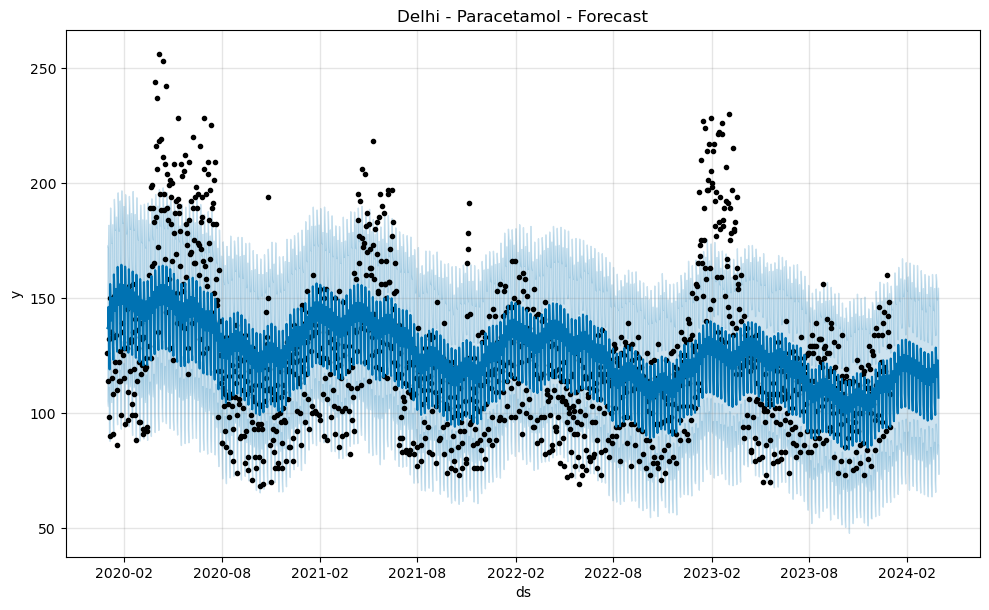

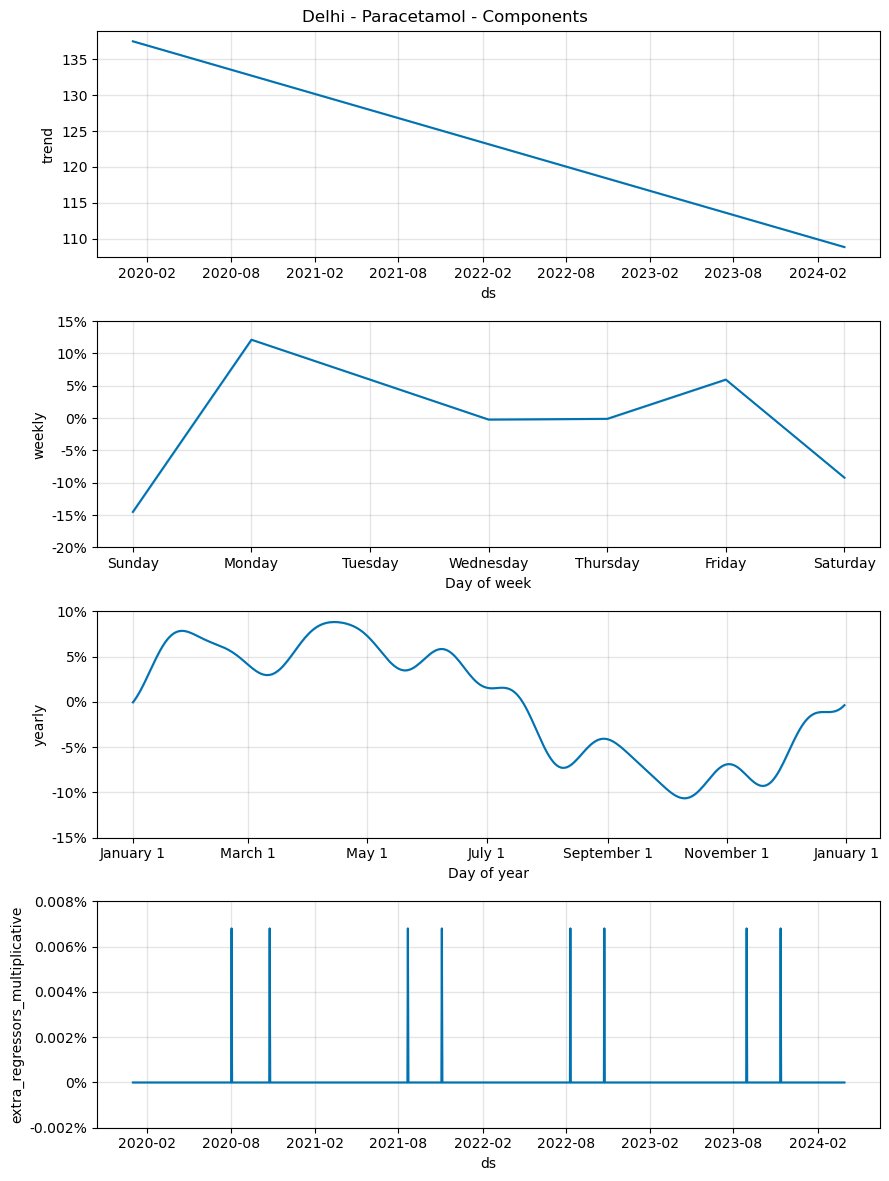

06:05:23 - cmdstanpy - INFO - Chain [1] start processing
06:05:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for ibuprofen in delhi

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:23 - cmdstanpy - INFO - Chain [1] start processing
06:05:23 - cmdstanpy - INFO - Chain [1] done processing
06:05:23 - cmdstanpy - INFO - Chain [1] start processing
06:05:23 - cmdstanpy - INFO - Chain [1] done processing
06:05:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:23 - cmdstanpy - INFO - Chain [1] start processing
06:05:23 - cmdstanpy - INFO - Chain [1] done processing
06:05:23 - cmdstanpy - INFO - Chain [1] start processing
06:05:23 - cmdstanpy - INFO - Chain [1] done processing
06:05:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:23 - cmdstanpy - INFO - Chain [1] start processing
06:05:24 - cmdstanpy - INFO - Chain [1] done processing
06:05:24 - cmdstanpy - INFO - Chain [1] start processing
06:05:24 - cmdstanpy - INFO - Chain [1] done processing
06:05:24 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.02
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:26 - cmdstanpy - INFO - Chain [1] start processing
06:05:26 - cmdstanpy - INFO - Chain [1] done processing
06:05:26 - cmdstanpy - INFO - Chain [1] start processing
06:05:26 - cmdstanpy - INFO - Chain [1] done processing
06:05:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:26 - cmdstanpy - INFO - Chain [1] start processing
06:05:26 - cmdstanpy - INFO - Chain [1] done processing
06:05:26 - cmdstanpy - INFO - Chain [1] start processing
06:05:26 - cmdstanpy - INFO - Chain [1] done processing
06:05:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:26 - cmdstanpy - INFO - Chain [1] start processing
06:05:27 - cmdstanpy - INFO - Chain [1] done processing
06:05:27 - cmdstanpy - INFO - Chain [1] start processing
06:05:27 - cmdstanpy - INFO - Chain [1] done processing
06:05:27 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.15
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:29 - cmdstanpy - INFO - Chain [1] start processing
06:05:29 - cmdstanpy - INFO - Chain [1] done processing
06:05:29 - cmdstanpy - INFO - Chain [1] start processing
06:05:29 - cmdstanpy - INFO - Chain [1] done processing
06:05:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:29 - cmdstanpy - INFO - Chain [1] start processing
06:05:30 - cmdstanpy - INFO - Chain [1] done processing
06:05:30 - cmdstanpy - INFO - Chain [1] start processing
06:05:30 - cmdstanpy - INFO - Chain [1] done processing
06:05:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:30 - cmdstanpy - INFO - Chain [1] start processing
06:05:30 - cmdstanpy - INFO - Chain [1] done processing
06:05:30 - cmdstanpy - INFO - Chain [1] start processing
06:05:30 - cmdstanpy - INFO - Chain [1] done processing
06:05:30 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.55
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:32 - cmdstanpy - INFO - Chain [1] start processing
06:05:32 - cmdstanpy - INFO - Chain [1] done processing
06:05:32 - cmdstanpy - INFO - Chain [1] start processing
06:05:32 - cmdstanpy - INFO - Chain [1] done processing
06:05:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:32 - cmdstanpy - INFO - Chain [1] start processing
06:05:33 - cmdstanpy - INFO - Chain [1] done processing
06:05:33 - cmdstanpy - INFO - Chain [1] start processing
06:05:33 - cmdstanpy - INFO - Chain [1] done processing
06:05:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:33 - cmdstanpy - INFO - Chain [1] start processing
06:05:33 - cmdstanpy - INFO - Chain [1] done processing
06:05:34 - cmdstanpy - INFO - Chain [1] start processing
06:05:34 - cmdstanpy - INFO - Chain [1] done processing
06:05:34 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.37
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:35 - cmdstanpy - INFO - Chain [1] start processing
06:05:35 - cmdstanpy - INFO - Chain [1] done processing
06:05:35 - cmdstanpy - INFO - Chain [1] start processing
06:05:35 - cmdstanpy - INFO - Chain [1] done processing
06:05:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:35 - cmdstanpy - INFO - Chain [1] start processing
06:05:36 - cmdstanpy - INFO - Chain [1] done processing
06:05:36 - cmdstanpy - INFO - Chain [1] start processing
06:05:36 - cmdstanpy - INFO - Chain [1] done processing
06:05:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:36 - cmdstanpy - INFO - Chain [1] start processing
06:05:37 - cmdstanpy - INFO - Chain [1] done processing
06:05:37 - cmdstanpy - INFO - Chain [1] start processing
06:05:37 - cmdstanpy - INFO - Chain [1] done processing
06:05:38 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.53
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:39 - cmdstanpy - INFO - Chain [1] start processing
06:05:39 - cmdstanpy - INFO - Chain [1] done processing
06:05:39 - cmdstanpy - INFO - Chain [1] start processing
06:05:39 - cmdstanpy - INFO - Chain [1] done processing
06:05:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:39 - cmdstanpy - INFO - Chain [1] start processing
06:05:40 - cmdstanpy - INFO - Chain [1] done processing
06:05:40 - cmdstanpy - INFO - Chain [1] start processing
06:05:40 - cmdstanpy - INFO - Chain [1] done processing
06:05:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:40 - cmdstanpy - INFO - Chain [1] start processing
06:05:41 - cmdstanpy - INFO - Chain [1] done processing
06:05:41 - cmdstanpy - INFO - Chain [1] start processing
06:05:41 - cmdstanpy - INFO - Chain [1] done processing
06:05:41 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.59
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:42 - cmdstanpy - INFO - Chain [1] start processing
06:05:42 - cmdstanpy - INFO - Chain [1] done processing
06:05:42 - cmdstanpy - INFO - Chain [1] start processing
06:05:43 - cmdstanpy - INFO - Chain [1] done processing
06:05:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:43 - cmdstanpy - INFO - Chain [1] start processing
06:05:43 - cmdstanpy - INFO - Chain [1] done processing
06:05:43 - cmdstanpy - INFO - Chain [1] start processing
06:05:43 - cmdstanpy - INFO - Chain [1] done processing
06:05:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:43 - cmdstanpy - INFO - Chain [1] start processing
06:05:44 - cmdstanpy - INFO - Chain [1] done processing
06:05:44 - cmdstanpy - INFO - Chain [1] start processing
06:05:44 - cmdstanpy - INFO - Chain [1] done processing
06:05:44 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.53
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:45 - cmdstanpy - INFO - Chain [1] start processing
06:05:45 - cmdstanpy - INFO - Chain [1] done processing
06:05:45 - cmdstanpy - INFO - Chain [1] start processing
06:05:46 - cmdstanpy - INFO - Chain [1] done processing
06:05:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:46 - cmdstanpy - INFO - Chain [1] start processing
06:05:47 - cmdstanpy - INFO - Chain [1] done processing
06:05:47 - cmdstanpy - INFO - Chain [1] start processing
06:05:47 - cmdstanpy - INFO - Chain [1] done processing
06:05:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:05:47 - cmdstanpy - INFO - Chain [1] start processing
06:05:48 - cmdstanpy - INFO - Chain [1] done processing
06:05:48 - cmdstanpy - INFO - Chain [1] start processing
06:05:48 - cmdstanpy - INFO - Chain [1] done processing
06:05:48 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.56
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:50 - cmdstanpy - INFO - Chain [1] start processing
06:05:50 - cmdstanpy - INFO - Chain [1] done processing
06:05:50 - cmdstanpy - INFO - Chain [1] start processing
06:05:50 - cmdstanpy - INFO - Chain [1] done processing
06:05:50 - cmdstanpy - INFO - Chain [1] start processing
06:05:50 - cmdstanpy - INFO - Chain [1] done processing
06:05:50 - cmdstanpy - INFO - Chain [1] start processing
06:05:50 - cmdstanpy - INFO - Chain [1] done processing
06:05:50 - cmdstanpy - INFO - Chain [1] start processing
06:05:50 - cmdstanpy - INFO - Chain [1] done processing
06:05:50 - cmdstanpy - INFO - Chain [1] start processing
06:05:50 - cmdstanpy - INFO - Chain [1] done processing
06:05:51 - cmdstanpy - INFO - Chain [1] start processing
06:05:51 - cmdstanpy - INFO - Chain [1] done processing
06:05:51 - cmdstanpy - INFO - Chain [1] start processing
06:05:51 - cmdstanpy - INFO - Chain [1] done processing
06:05:51 - cmdstanpy - INFO - Chain [1] start processing
06:05:51 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.74
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:52 - cmdstanpy - INFO - Chain [1] start processing
06:05:52 - cmdstanpy - INFO - Chain [1] done processing
06:05:52 - cmdstanpy - INFO - Chain [1] start processing
06:05:52 - cmdstanpy - INFO - Chain [1] done processing
06:05:52 - cmdstanpy - INFO - Chain [1] start processing
06:05:52 - cmdstanpy - INFO - Chain [1] done processing
06:05:52 - cmdstanpy - INFO - Chain [1] start processing
06:05:52 - cmdstanpy - INFO - Chain [1] done processing
06:05:52 - cmdstanpy - INFO - Chain [1] start processing
06:05:52 - cmdstanpy - INFO - Chain [1] done processing
06:05:53 - cmdstanpy - INFO - Chain [1] start processing
06:05:53 - cmdstanpy - INFO - Chain [1] done processing
06:05:53 - cmdstanpy - INFO - Chain [1] start processing
06:05:53 - cmdstanpy - INFO - Chain [1] done processing
06:05:53 - cmdstanpy - INFO - Chain [1] start processing
06:05:53 - cmdstanpy - INFO - Chain [1] done processing
06:05:53 - cmdstanpy - INFO - Chain [1] start processing
06:05:53 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.74
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:54 - cmdstanpy - INFO - Chain [1] start processing
06:05:54 - cmdstanpy - INFO - Chain [1] done processing
06:05:54 - cmdstanpy - INFO - Chain [1] start processing
06:05:54 - cmdstanpy - INFO - Chain [1] done processing
06:05:54 - cmdstanpy - INFO - Chain [1] start processing
06:05:54 - cmdstanpy - INFO - Chain [1] done processing
06:05:55 - cmdstanpy - INFO - Chain [1] start processing
06:05:55 - cmdstanpy - INFO - Chain [1] done processing
06:05:55 - cmdstanpy - INFO - Chain [1] start processing
06:05:55 - cmdstanpy - INFO - Chain [1] done processing
06:05:55 - cmdstanpy - INFO - Chain [1] start processing
06:05:55 - cmdstanpy - INFO - Chain [1] done processing
06:05:55 - cmdstanpy - INFO - Chain [1] start processing
06:05:55 - cmdstanpy - INFO - Chain [1] done processing
06:05:55 - cmdstanpy - INFO - Chain [1] start processing
06:05:55 - cmdstanpy - INFO - Chain [1] done processing
06:05:55 - cmdstanpy - INFO - Chain [1] start processing
06:05:55 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.91
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:56 - cmdstanpy - INFO - Chain [1] start processing
06:05:56 - cmdstanpy - INFO - Chain [1] done processing
06:05:57 - cmdstanpy - INFO - Chain [1] start processing
06:05:57 - cmdstanpy - INFO - Chain [1] done processing
06:05:57 - cmdstanpy - INFO - Chain [1] start processing
06:05:57 - cmdstanpy - INFO - Chain [1] done processing
06:05:57 - cmdstanpy - INFO - Chain [1] start processing
06:05:57 - cmdstanpy - INFO - Chain [1] done processing
06:05:57 - cmdstanpy - INFO - Chain [1] start processing
06:05:57 - cmdstanpy - INFO - Chain [1] done processing
06:05:57 - cmdstanpy - INFO - Chain [1] start processing
06:05:58 - cmdstanpy - INFO - Chain [1] done processing
06:05:58 - cmdstanpy - INFO - Chain [1] start processing
06:05:58 - cmdstanpy - INFO - Chain [1] done processing
06:05:58 - cmdstanpy - INFO - Chain [1] start processing
06:05:58 - cmdstanpy - INFO - Chain [1] done processing
06:05:58 - cmdstanpy - INFO - Chain [1] start processing
06:05:58 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.17
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:05:59 - cmdstanpy - INFO - Chain [1] start processing
06:05:59 - cmdstanpy - INFO - Chain [1] done processing
06:05:59 - cmdstanpy - INFO - Chain [1] start processing
06:05:59 - cmdstanpy - INFO - Chain [1] done processing
06:05:59 - cmdstanpy - INFO - Chain [1] start processing
06:05:59 - cmdstanpy - INFO - Chain [1] done processing
06:05:59 - cmdstanpy - INFO - Chain [1] start processing
06:05:59 - cmdstanpy - INFO - Chain [1] done processing
06:06:00 - cmdstanpy - INFO - Chain [1] start processing
06:06:00 - cmdstanpy - INFO - Chain [1] done processing
06:06:00 - cmdstanpy - INFO - Chain [1] start processing
06:06:00 - cmdstanpy - INFO - Chain [1] done processing
06:06:00 - cmdstanpy - INFO - Chain [1] start processing
06:06:00 - cmdstanpy - INFO - Chain [1] done processing
06:06:00 - cmdstanpy - INFO - Chain [1] start processing
06:06:00 - cmdstanpy - INFO - Chain [1] done processing
06:06:00 - cmdstanpy - INFO - Chain [1] start processing
06:06:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.93
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:01 - cmdstanpy - INFO - Chain [1] start processing
06:06:01 - cmdstanpy - INFO - Chain [1] done processing
06:06:02 - cmdstanpy - INFO - Chain [1] start processing
06:06:02 - cmdstanpy - INFO - Chain [1] done processing
06:06:02 - cmdstanpy - INFO - Chain [1] start processing
06:06:02 - cmdstanpy - INFO - Chain [1] done processing
06:06:02 - cmdstanpy - INFO - Chain [1] start processing
06:06:02 - cmdstanpy - INFO - Chain [1] done processing
06:06:02 - cmdstanpy - INFO - Chain [1] start processing
06:06:02 - cmdstanpy - INFO - Chain [1] done processing
06:06:02 - cmdstanpy - INFO - Chain [1] start processing
06:06:02 - cmdstanpy - INFO - Chain [1] done processing
06:06:02 - cmdstanpy - INFO - Chain [1] start processing
06:06:02 - cmdstanpy - INFO - Chain [1] done processing
06:06:02 - cmdstanpy - INFO - Chain [1] start processing
06:06:03 - cmdstanpy - INFO - Chain [1] done processing
06:06:03 - cmdstanpy - INFO - Chain [1] start processing
06:06:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.86
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:04 - cmdstanpy - INFO - Chain [1] start processing
06:06:04 - cmdstanpy - INFO - Chain [1] done processing
06:06:04 - cmdstanpy - INFO - Chain [1] start processing
06:06:04 - cmdstanpy - INFO - Chain [1] done processing
06:06:04 - cmdstanpy - INFO - Chain [1] start processing
06:06:04 - cmdstanpy - INFO - Chain [1] done processing
06:06:04 - cmdstanpy - INFO - Chain [1] start processing
06:06:04 - cmdstanpy - INFO - Chain [1] done processing
06:06:04 - cmdstanpy - INFO - Chain [1] start processing
06:06:04 - cmdstanpy - INFO - Chain [1] done processing
06:06:04 - cmdstanpy - INFO - Chain [1] start processing
06:06:04 - cmdstanpy - INFO - Chain [1] done processing
06:06:05 - cmdstanpy - INFO - Chain [1] start processing
06:06:05 - cmdstanpy - INFO - Chain [1] done processing
06:06:05 - cmdstanpy - INFO - Chain [1] start processing
06:06:05 - cmdstanpy - INFO - Chain [1] done processing
06:06:05 - cmdstanpy - INFO - Chain [1] start processing
06:06:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.17
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:06 - cmdstanpy - INFO - Chain [1] start processing
06:06:06 - cmdstanpy - INFO - Chain [1] done processing
06:06:06 - cmdstanpy - INFO - Chain [1] start processing
06:06:06 - cmdstanpy - INFO - Chain [1] done processing
06:06:06 - cmdstanpy - INFO - Chain [1] start processing
06:06:06 - cmdstanpy - INFO - Chain [1] done processing
06:06:06 - cmdstanpy - INFO - Chain [1] start processing
06:06:06 - cmdstanpy - INFO - Chain [1] done processing
06:06:07 - cmdstanpy - INFO - Chain [1] start processing
06:06:07 - cmdstanpy - INFO - Chain [1] done processing
06:06:07 - cmdstanpy - INFO - Chain [1] start processing
06:06:07 - cmdstanpy - INFO - Chain [1] done processing
06:06:07 - cmdstanpy - INFO - Chain [1] start processing
06:06:07 - cmdstanpy - INFO - Chain [1] done processing
06:06:07 - cmdstanpy - INFO - Chain [1] start processing
06:06:07 - cmdstanpy - INFO - Chain [1] done processing
06:06:07 - cmdstanpy - INFO - Chain [1] start processing
06:06:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.39
---


06:06:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:08 - cmdstanpy - INFO - Chain [1] start processing
06:06:08 - cmdstanpy - INFO - Chain [1] done processing
06:06:08 - cmdstanpy - INFO - Chain [1] start processing
06:06:09 - cmdstanpy - INFO - Chain [1] done processing
06:06:09 - cmdstanpy - INFO - Chain [1] start processing
06:06:09 - cmdstanpy - INFO - Chain [1] done processing
06:06:09 - cmdstanpy - INFO - Chain [1] start processing
06:06:09 - cmdstanpy - INFO - Chain [1] done processing
06:06:09 - cmdstanpy - INFO - Chain [1] start processing
06:06:09 - cmdstanpy - INFO - Chain [1] done processing
06:06:09 - cmdstanpy - INFO - Chain [1] start processing
06:06:09 - cmdstanpy - INFO - Chain [1] done processing
06:06:09 - cmdstanpy - INFO - Chain [1] start processing
06:06:09 - cmdstanpy - INFO - Chain [1] done processing
06:06:10 - cmdstanpy - INFO - Chain [1] start processing
06:06:10 - cmdstanpy - INFO - Chain [1] done processing
06:06:10 - cmdstanpy - INFO - Chain [1] start processing
06:06:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.18
---


06:06:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:11 - cmdstanpy - INFO - Chain [1] start processing
06:06:11 - cmdstanpy - INFO - Chain [1] done processing
06:06:11 - cmdstanpy - INFO - Chain [1] start processing
06:06:11 - cmdstanpy - INFO - Chain [1] done processing
06:06:12 - cmdstanpy - INFO - Chain [1] start processing
06:06:12 - cmdstanpy - INFO - Chain [1] done processing
06:06:12 - cmdstanpy - INFO - Chain [1] start processing
06:06:12 - cmdstanpy - INFO - Chain [1] done processing
06:06:12 - cmdstanpy - INFO - Chain [1] start processing
06:06:12 - cmdstanpy - INFO - Chain [1] done processing
06:06:12 - cmdstanpy - INFO - Chain [1] start processing
06:06:12 - cmdstanpy - INFO - Chain [1] done processing
06:06:12 - cmdstanpy - INFO - Chain [1] start processing
06:06:12 - cmdstanpy - INFO - Chain [1] done processing
06:06:12 - cmdstanpy - INFO - Chain [1] start processing
06:06:12 - cmdstanpy - INFO - Chain [1] done processing
06:06:13 - cmdstanpy - INFO - Chain [1] start processing
06:06:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.26
---


06:06:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:14 - cmdstanpy - INFO - Chain [1] start processing
06:06:14 - cmdstanpy - INFO - Chain [1] done processing
06:06:14 - cmdstanpy - INFO - Chain [1] start processing
06:06:14 - cmdstanpy - INFO - Chain [1] done processing
06:06:14 - cmdstanpy - INFO - Chain [1] start processing
06:06:14 - cmdstanpy - INFO - Chain [1] done processing
06:06:14 - cmdstanpy - INFO - Chain [1] start processing
06:06:14 - cmdstanpy - INFO - Chain [1] done processing
06:06:14 - cmdstanpy - INFO - Chain [1] start processing
06:06:15 - cmdstanpy - INFO - Chain [1] done processing
06:06:15 - cmdstanpy - INFO - Chain [1] start processing
06:06:15 - cmdstanpy - INFO - Chain [1] done processing
06:06:15 - cmdstanpy - INFO - Chain [1] start processing
06:06:15 - cmdstanpy - INFO - Chain [1] done processing
06:06:15 - cmdstanpy - INFO - Chain [1] start processing
06:06:15 - cmdstanpy - INFO - Chain [1] done processing
06:06:15 - cmdstanpy - INFO - Chain [1] start processing
06:06:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.85
---


06:06:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:17 - cmdstanpy - INFO - Chain [1] start processing
06:06:17 - cmdstanpy - INFO - Chain [1] done processing
06:06:17 - cmdstanpy - INFO - Chain [1] start processing
06:06:17 - cmdstanpy - INFO - Chain [1] done processing
06:06:17 - cmdstanpy - INFO - Chain [1] start processing
06:06:17 - cmdstanpy - INFO - Chain [1] done processing
06:06:17 - cmdstanpy - INFO - Chain [1] start processing
06:06:17 - cmdstanpy - INFO - Chain [1] done processing
06:06:17 - cmdstanpy - INFO - Chain [1] start processing
06:06:17 - cmdstanpy - INFO - Chain [1] done processing
06:06:17 - cmdstanpy - INFO - Chain [1] start processing
06:06:17 - cmdstanpy - INFO - Chain [1] done processing
06:06:18 - cmdstanpy - INFO - Chain [1] start processing
06:06:18 - cmdstanpy - INFO - Chain [1] done processing
06:06:18 - cmdstanpy - INFO - Chain [1] start processing
06:06:18 - cmdstanpy - INFO - Chain [1] done processing
06:06:18 - cmdstanpy - INFO - Chain [1] start processing
06:06:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.61
---


06:06:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:19 - cmdstanpy - INFO - Chain [1] start processing
06:06:19 - cmdstanpy - INFO - Chain [1] done processing
06:06:19 - cmdstanpy - INFO - Chain [1] start processing
06:06:19 - cmdstanpy - INFO - Chain [1] done processing
06:06:19 - cmdstanpy - INFO - Chain [1] start processing
06:06:20 - cmdstanpy - INFO - Chain [1] done processing
06:06:20 - cmdstanpy - INFO - Chain [1] start processing
06:06:20 - cmdstanpy - INFO - Chain [1] done processing
06:06:20 - cmdstanpy - INFO - Chain [1] start processing
06:06:20 - cmdstanpy - INFO - Chain [1] done processing
06:06:20 - cmdstanpy - INFO - Chain [1] start processing
06:06:20 - cmdstanpy - INFO - Chain [1] done processing
06:06:20 - cmdstanpy - INFO - Chain [1] start processing
06:06:20 - cmdstanpy - INFO - Chain [1] done processing
06:06:20 - cmdstanpy - INFO - Chain [1] start processing
06:06:20 - cmdstanpy - INFO - Chain [1] done processing
06:06:21 - cmdstanpy - INFO - Chain [1] start processing
06:06:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.60
---


06:06:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:22 - cmdstanpy - INFO - Chain [1] start processing
06:06:22 - cmdstanpy - INFO - Chain [1] done processing
06:06:22 - cmdstanpy - INFO - Chain [1] start processing
06:06:22 - cmdstanpy - INFO - Chain [1] done processing
06:06:22 - cmdstanpy - INFO - Chain [1] start processing
06:06:22 - cmdstanpy - INFO - Chain [1] done processing
06:06:22 - cmdstanpy - INFO - Chain [1] start processing
06:06:22 - cmdstanpy - INFO - Chain [1] done processing
06:06:23 - cmdstanpy - INFO - Chain [1] start processing
06:06:23 - cmdstanpy - INFO - Chain [1] done processing
06:06:23 - cmdstanpy - INFO - Chain [1] start processing
06:06:23 - cmdstanpy - INFO - Chain [1] done processing
06:06:23 - cmdstanpy - INFO - Chain [1] start processing
06:06:23 - cmdstanpy - INFO - Chain [1] done processing
06:06:23 - cmdstanpy - INFO - Chain [1] start processing
06:06:23 - cmdstanpy - INFO - Chain [1] done processing
06:06:23 - cmdstanpy - INFO - Chain [1] start processing
06:06:23 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.02
---


06:06:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:25 - cmdstanpy - INFO - Chain [1] start processing
06:06:25 - cmdstanpy - INFO - Chain [1] done processing
06:06:25 - cmdstanpy - INFO - Chain [1] start processing
06:06:25 - cmdstanpy - INFO - Chain [1] done processing
06:06:25 - cmdstanpy - INFO - Chain [1] start processing
06:06:25 - cmdstanpy - INFO - Chain [1] done processing
06:06:25 - cmdstanpy - INFO - Chain [1] start processing
06:06:25 - cmdstanpy - INFO - Chain [1] done processing
06:06:25 - cmdstanpy - INFO - Chain [1] start processing
06:06:25 - cmdstanpy - INFO - Chain [1] done processing
06:06:25 - cmdstanpy - INFO - Chain [1] start processing
06:06:26 - cmdstanpy - INFO - Chain [1] done processing
06:06:26 - cmdstanpy - INFO - Chain [1] start processing
06:06:26 - cmdstanpy - INFO - Chain [1] done processing
06:06:26 - cmdstanpy - INFO - Chain [1] start processing
06:06:26 - cmdstanpy - INFO - Chain [1] done processing
06:06:26 - cmdstanpy - INFO - Chain [1] start processing
06:06:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.85
---


06:06:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:27 - cmdstanpy - INFO - Chain [1] start processing
06:06:27 - cmdstanpy - INFO - Chain [1] done processing
06:06:28 - cmdstanpy - INFO - Chain [1] start processing
06:06:28 - cmdstanpy - INFO - Chain [1] done processing
06:06:28 - cmdstanpy - INFO - Chain [1] start processing
06:06:28 - cmdstanpy - INFO - Chain [1] done processing
06:06:28 - cmdstanpy - INFO - Chain [1] start processing
06:06:28 - cmdstanpy - INFO - Chain [1] done processing
06:06:28 - cmdstanpy - INFO - Chain [1] start processing
06:06:28 - cmdstanpy - INFO - Chain [1] done processing
06:06:28 - cmdstanpy - INFO - Chain [1] start processing
06:06:28 - cmdstanpy - INFO - Chain [1] done processing
06:06:28 - cmdstanpy - INFO - Chain [1] start processing
06:06:28 - cmdstanpy - INFO - Chain [1] done processing
06:06:29 - cmdstanpy - INFO - Chain [1] start processing
06:06:29 - cmdstanpy - INFO - Chain [1] done processing
06:06:29 - cmdstanpy - INFO - Chain [1] start processing
06:06:29 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.19
---


06:06:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:30 - cmdstanpy - INFO - Chain [1] start processing
06:06:30 - cmdstanpy - INFO - Chain [1] done processing
06:06:30 - cmdstanpy - INFO - Chain [1] start processing
06:06:30 - cmdstanpy - INFO - Chain [1] done processing
06:06:30 - cmdstanpy - INFO - Chain [1] start processing
06:06:30 - cmdstanpy - INFO - Chain [1] done processing
06:06:31 - cmdstanpy - INFO - Chain [1] start processing
06:06:31 - cmdstanpy - INFO - Chain [1] done processing
06:06:31 - cmdstanpy - INFO - Chain [1] start processing
06:06:31 - cmdstanpy - INFO - Chain [1] done processing
06:06:31 - cmdstanpy - INFO - Chain [1] start processing
06:06:31 - cmdstanpy - INFO - Chain [1] done processing
06:06:31 - cmdstanpy - INFO - Chain [1] start processing
06:06:31 - cmdstanpy - INFO - Chain [1] done processing
06:06:32 - cmdstanpy - INFO - Chain [1] start processing
06:06:32 - cmdstanpy - INFO - Chain [1] done processing
06:06:32 - cmdstanpy - INFO - Chain [1] start processing
06:06:32 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.74
---


06:06:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:34 - cmdstanpy - INFO - Chain [1] start processing
06:06:34 - cmdstanpy - INFO - Chain [1] done processing
06:06:34 - cmdstanpy - INFO - Chain [1] start processing
06:06:34 - cmdstanpy - INFO - Chain [1] done processing
06:06:34 - cmdstanpy - INFO - Chain [1] start processing
06:06:34 - cmdstanpy - INFO - Chain [1] done processing
06:06:34 - cmdstanpy - INFO - Chain [1] start processing
06:06:34 - cmdstanpy - INFO - Chain [1] done processing
06:06:34 - cmdstanpy - INFO - Chain [1] start processing
06:06:34 - cmdstanpy - INFO - Chain [1] done processing
06:06:34 - cmdstanpy - INFO - Chain [1] start processing
06:06:35 - cmdstanpy - INFO - Chain [1] done processing
06:06:35 - cmdstanpy - INFO - Chain [1] start processing
06:06:35 - cmdstanpy - INFO - Chain [1] done processing
06:06:35 - cmdstanpy - INFO - Chain [1] start processing
06:06:35 - cmdstanpy - INFO - Chain [1] done processing
06:06:35 - cmdstanpy - INFO - Chain [1] start processing
06:06:35 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.75
---


06:06:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:37 - cmdstanpy - INFO - Chain [1] start processing
06:06:37 - cmdstanpy - INFO - Chain [1] done processing
06:06:37 - cmdstanpy - INFO - Chain [1] start processing
06:06:37 - cmdstanpy - INFO - Chain [1] done processing
06:06:37 - cmdstanpy - INFO - Chain [1] start processing
06:06:37 - cmdstanpy - INFO - Chain [1] done processing
06:06:37 - cmdstanpy - INFO - Chain [1] start processing
06:06:37 - cmdstanpy - INFO - Chain [1] done processing
06:06:38 - cmdstanpy - INFO - Chain [1] start processing
06:06:38 - cmdstanpy - INFO - Chain [1] done processing
06:06:38 - cmdstanpy - INFO - Chain [1] start processing
06:06:38 - cmdstanpy - INFO - Chain [1] done processing
06:06:38 - cmdstanpy - INFO - Chain [1] start processing
06:06:38 - cmdstanpy - INFO - Chain [1] done processing
06:06:38 - cmdstanpy - INFO - Chain [1] start processing
06:06:38 - cmdstanpy - INFO - Chain [1] done processing
06:06:39 - cmdstanpy - INFO - Chain [1] start processing
06:06:39 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 27.75
---


06:06:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:40 - cmdstanpy - INFO - Chain [1] start processing
06:06:40 - cmdstanpy - INFO - Chain [1] done processing
06:06:40 - cmdstanpy - INFO - Chain [1] start processing
06:06:40 - cmdstanpy - INFO - Chain [1] done processing
06:06:40 - cmdstanpy - INFO - Chain [1] start processing
06:06:40 - cmdstanpy - INFO - Chain [1] done processing
06:06:41 - cmdstanpy - INFO - Chain [1] start processing
06:06:41 - cmdstanpy - INFO - Chain [1] done processing
06:06:41 - cmdstanpy - INFO - Chain [1] start processing
06:06:41 - cmdstanpy - INFO - Chain [1] done processing
06:06:41 - cmdstanpy - INFO - Chain [1] start processing
06:06:41 - cmdstanpy - INFO - Chain [1] done processing
06:06:41 - cmdstanpy - INFO - Chain [1] start processing
06:06:41 - cmdstanpy - INFO - Chain [1] done processing
06:06:41 - cmdstanpy - INFO - Chain [1] start processing
06:06:41 - cmdstanpy - INFO - Chain [1] done processing
06:06:42 - cmdstanpy - INFO - Chain [1] start processing
06:06:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.04
---


06:06:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:43 - cmdstanpy - INFO - Chain [1] start processing
06:06:43 - cmdstanpy - INFO - Chain [1] done processing
06:06:43 - cmdstanpy - INFO - Chain [1] start processing
06:06:43 - cmdstanpy - INFO - Chain [1] done processing
06:06:44 - cmdstanpy - INFO - Chain [1] start processing
06:06:44 - cmdstanpy - INFO - Chain [1] done processing
06:06:44 - cmdstanpy - INFO - Chain [1] start processing
06:06:44 - cmdstanpy - INFO - Chain [1] done processing
06:06:44 - cmdstanpy - INFO - Chain [1] start processing
06:06:44 - cmdstanpy - INFO - Chain [1] done processing
06:06:44 - cmdstanpy - INFO - Chain [1] start processing
06:06:44 - cmdstanpy - INFO - Chain [1] done processing
06:06:44 - cmdstanpy - INFO - Chain [1] start processing
06:06:44 - cmdstanpy - INFO - Chain [1] done processing
06:06:45 - cmdstanpy - INFO - Chain [1] start processing
06:06:45 - cmdstanpy - INFO - Chain [1] done processing
06:06:45 - cmdstanpy - INFO - Chain [1] start processing
06:06:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.25
---


06:06:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:47 - cmdstanpy - INFO - Chain [1] start processing
06:06:47 - cmdstanpy - INFO - Chain [1] done processing
06:06:47 - cmdstanpy - INFO - Chain [1] start processing
06:06:47 - cmdstanpy - INFO - Chain [1] done processing
06:06:47 - cmdstanpy - INFO - Chain [1] start processing
06:06:47 - cmdstanpy - INFO - Chain [1] done processing
06:06:47 - cmdstanpy - INFO - Chain [1] start processing
06:06:47 - cmdstanpy - INFO - Chain [1] done processing
06:06:47 - cmdstanpy - INFO - Chain [1] start processing
06:06:47 - cmdstanpy - INFO - Chain [1] done processing
06:06:47 - cmdstanpy - INFO - Chain [1] start processing
06:06:48 - cmdstanpy - INFO - Chain [1] done processing
06:06:48 - cmdstanpy - INFO - Chain [1] start processing
06:06:48 - cmdstanpy - INFO - Chain [1] done processing
06:06:48 - cmdstanpy - INFO - Chain [1] start processing
06:06:48 - cmdstanpy - INFO - Chain [1] done processing
06:06:48 - cmdstanpy - INFO - Chain [1] start processing
06:06:48 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.32
---


06:06:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:50 - cmdstanpy - INFO - Chain [1] start processing
06:06:50 - cmdstanpy - INFO - Chain [1] done processing
06:06:50 - cmdstanpy - INFO - Chain [1] start processing
06:06:50 - cmdstanpy - INFO - Chain [1] done processing
06:06:50 - cmdstanpy - INFO - Chain [1] start processing
06:06:50 - cmdstanpy - INFO - Chain [1] done processing
06:06:50 - cmdstanpy - INFO - Chain [1] start processing
06:06:50 - cmdstanpy - INFO - Chain [1] done processing
06:06:51 - cmdstanpy - INFO - Chain [1] start processing
06:06:51 - cmdstanpy - INFO - Chain [1] done processing
06:06:51 - cmdstanpy - INFO - Chain [1] start processing
06:06:51 - cmdstanpy - INFO - Chain [1] done processing
06:06:51 - cmdstanpy - INFO - Chain [1] start processing
06:06:51 - cmdstanpy - INFO - Chain [1] done processing
06:06:51 - cmdstanpy - INFO - Chain [1] start processing
06:06:51 - cmdstanpy - INFO - Chain [1] done processing
06:06:52 - cmdstanpy - INFO - Chain [1] start processing
06:06:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.62
---


06:06:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:53 - cmdstanpy - INFO - Chain [1] start processing
06:06:53 - cmdstanpy - INFO - Chain [1] done processing
06:06:53 - cmdstanpy - INFO - Chain [1] start processing
06:06:54 - cmdstanpy - INFO - Chain [1] done processing
06:06:54 - cmdstanpy - INFO - Chain [1] start processing
06:06:54 - cmdstanpy - INFO - Chain [1] done processing
06:06:54 - cmdstanpy - INFO - Chain [1] start processing
06:06:54 - cmdstanpy - INFO - Chain [1] done processing
06:06:54 - cmdstanpy - INFO - Chain [1] start processing
06:06:54 - cmdstanpy - INFO - Chain [1] done processing
06:06:54 - cmdstanpy - INFO - Chain [1] start processing
06:06:54 - cmdstanpy - INFO - Chain [1] done processing
06:06:54 - cmdstanpy - INFO - Chain [1] start processing
06:06:54 - cmdstanpy - INFO - Chain [1] done processing
06:06:55 - cmdstanpy - INFO - Chain [1] start processing
06:06:55 - cmdstanpy - INFO - Chain [1] done processing
06:06:55 - cmdstanpy - INFO - Chain [1] start processing
06:06:55 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.55
---


06:06:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:06:57 - cmdstanpy - INFO - Chain [1] start processing
06:06:57 - cmdstanpy - INFO - Chain [1] done processing
06:06:57 - cmdstanpy - INFO - Chain [1] start processing
06:06:57 - cmdstanpy - INFO - Chain [1] done processing
06:06:57 - cmdstanpy - INFO - Chain [1] start processing
06:06:57 - cmdstanpy - INFO - Chain [1] done processing
06:06:58 - cmdstanpy - INFO - Chain [1] start processing
06:06:58 - cmdstanpy - INFO - Chain [1] done processing
06:06:58 - cmdstanpy - INFO - Chain [1] start processing
06:06:58 - cmdstanpy - INFO - Chain [1] done processing
06:06:58 - cmdstanpy - INFO - Chain [1] start processing
06:06:59 - cmdstanpy - INFO - Chain [1] done processing
06:06:59 - cmdstanpy - INFO - Chain [1] start processing
06:06:59 - cmdstanpy - INFO - Chain [1] done processing
06:06:59 - cmdstanpy - INFO - Chain [1] start processing
06:06:59 - cmdstanpy - INFO - Chain [1] done processing
06:07:00 - cmdstanpy - INFO - Chain [1] start processing
06:07:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.27
---


06:07:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:02 - cmdstanpy - INFO - Chain [1] start processing
06:07:02 - cmdstanpy - INFO - Chain [1] done processing
06:07:02 - cmdstanpy - INFO - Chain [1] start processing
06:07:03 - cmdstanpy - INFO - Chain [1] done processing
06:07:03 - cmdstanpy - INFO - Chain [1] start processing
06:07:03 - cmdstanpy - INFO - Chain [1] done processing
06:07:03 - cmdstanpy - INFO - Chain [1] start processing
06:07:03 - cmdstanpy - INFO - Chain [1] done processing
06:07:03 - cmdstanpy - INFO - Chain [1] start processing
06:07:03 - cmdstanpy - INFO - Chain [1] done processing
06:07:04 - cmdstanpy - INFO - Chain [1] start processing
06:07:04 - cmdstanpy - INFO - Chain [1] done processing
06:07:04 - cmdstanpy - INFO - Chain [1] start processing
06:07:04 - cmdstanpy - INFO - Chain [1] done processing
06:07:04 - cmdstanpy - INFO - Chain [1] start processing
06:07:05 - cmdstanpy - INFO - Chain [1] done processing
06:07:05 - cmdstanpy - INFO - Chain [1] start processing
06:07:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.97
---


06:07:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:07 - cmdstanpy - INFO - Chain [1] start processing
06:07:07 - cmdstanpy - INFO - Chain [1] done processing
06:07:08 - cmdstanpy - INFO - Chain [1] start processing
06:07:08 - cmdstanpy - INFO - Chain [1] done processing
06:07:08 - cmdstanpy - INFO - Chain [1] start processing
06:07:08 - cmdstanpy - INFO - Chain [1] done processing
06:07:08 - cmdstanpy - INFO - Chain [1] start processing
06:07:08 - cmdstanpy - INFO - Chain [1] done processing
06:07:08 - cmdstanpy - INFO - Chain [1] start processing
06:07:09 - cmdstanpy - INFO - Chain [1] done processing
06:07:09 - cmdstanpy - INFO - Chain [1] start processing
06:07:09 - cmdstanpy - INFO - Chain [1] done processing
06:07:09 - cmdstanpy - INFO - Chain [1] start processing
06:07:09 - cmdstanpy - INFO - Chain [1] done processing
06:07:09 - cmdstanpy - INFO - Chain [1] start processing
06:07:10 - cmdstanpy - INFO - Chain [1] done processing
06:07:10 - cmdstanpy - INFO - Chain [1] start processing
06:07:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.24
---


06:07:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:13 - cmdstanpy - INFO - Chain [1] start processing
06:07:13 - cmdstanpy - INFO - Chain [1] done processing
06:07:13 - cmdstanpy - INFO - Chain [1] start processing
06:07:13 - cmdstanpy - INFO - Chain [1] done processing
06:07:13 - cmdstanpy - INFO - Chain [1] start processing
06:07:13 - cmdstanpy - INFO - Chain [1] done processing
06:07:13 - cmdstanpy - INFO - Chain [1] start processing
06:07:13 - cmdstanpy - INFO - Chain [1] done processing
06:07:14 - cmdstanpy - INFO - Chain [1] start processing
06:07:14 - cmdstanpy - INFO - Chain [1] done processing
06:07:14 - cmdstanpy - INFO - Chain [1] start processing
06:07:14 - cmdstanpy - INFO - Chain [1] done processing
06:07:14 - cmdstanpy - INFO - Chain [1] start processing
06:07:14 - cmdstanpy - INFO - Chain [1] done processing
06:07:15 - cmdstanpy - INFO - Chain [1] start processing
06:07:15 - cmdstanpy - INFO - Chain [1] done processing
06:07:15 - cmdstanpy - INFO - Chain [1] start processing
06:07:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.34
---


06:07:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:18 - cmdstanpy - INFO - Chain [1] start processing
06:07:18 - cmdstanpy - INFO - Chain [1] done processing
06:07:18 - cmdstanpy - INFO - Chain [1] start processing
06:07:18 - cmdstanpy - INFO - Chain [1] done processing
06:07:18 - cmdstanpy - INFO - Chain [1] start processing
06:07:18 - cmdstanpy - INFO - Chain [1] done processing
06:07:18 - cmdstanpy - INFO - Chain [1] start processing
06:07:19 - cmdstanpy - INFO - Chain [1] done processing
06:07:19 - cmdstanpy - INFO - Chain [1] start processing
06:07:19 - cmdstanpy - INFO - Chain [1] done processing
06:07:19 - cmdstanpy - INFO - Chain [1] start processing
06:07:19 - cmdstanpy - INFO - Chain [1] done processing
06:07:20 - cmdstanpy - INFO - Chain [1] start processing
06:07:20 - cmdstanpy - INFO - Chain [1] done processing
06:07:20 - cmdstanpy - INFO - Chain [1] start processing
06:07:20 - cmdstanpy - INFO - Chain [1] done processing
06:07:20 - cmdstanpy - INFO - Chain [1] start processing
06:07:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.70
---


06:07:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:23 - cmdstanpy - INFO - Chain [1] start processing
06:07:23 - cmdstanpy - INFO - Chain [1] done processing
06:07:23 - cmdstanpy - INFO - Chain [1] start processing
06:07:23 - cmdstanpy - INFO - Chain [1] done processing
06:07:24 - cmdstanpy - INFO - Chain [1] start processing
06:07:24 - cmdstanpy - INFO - Chain [1] done processing
06:07:24 - cmdstanpy - INFO - Chain [1] start processing
06:07:24 - cmdstanpy - INFO - Chain [1] done processing
06:07:24 - cmdstanpy - INFO - Chain [1] start processing
06:07:24 - cmdstanpy - INFO - Chain [1] done processing
06:07:24 - cmdstanpy - INFO - Chain [1] start processing
06:07:25 - cmdstanpy - INFO - Chain [1] done processing
06:07:25 - cmdstanpy - INFO - Chain [1] start processing
06:07:25 - cmdstanpy - INFO - Chain [1] done processing
06:07:25 - cmdstanpy - INFO - Chain [1] start processing
06:07:26 - cmdstanpy - INFO - Chain [1] done processing
06:07:26 - cmdstanpy - INFO - Chain [1] start processing
06:07:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 54.36
---


06:07:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:28 - cmdstanpy - INFO - Chain [1] start processing
06:07:28 - cmdstanpy - INFO - Chain [1] done processing
06:07:28 - cmdstanpy - INFO - Chain [1] start processing
06:07:29 - cmdstanpy - INFO - Chain [1] done processing
06:07:29 - cmdstanpy - INFO - Chain [1] start processing
06:07:29 - cmdstanpy - INFO - Chain [1] done processing
06:07:29 - cmdstanpy - INFO - Chain [1] start processing
06:07:29 - cmdstanpy - INFO - Chain [1] done processing
06:07:29 - cmdstanpy - INFO - Chain [1] start processing
06:07:30 - cmdstanpy - INFO - Chain [1] done processing
06:07:30 - cmdstanpy - INFO - Chain [1] start processing
06:07:30 - cmdstanpy - INFO - Chain [1] done processing
06:07:30 - cmdstanpy - INFO - Chain [1] start processing
06:07:30 - cmdstanpy - INFO - Chain [1] done processing
06:07:30 - cmdstanpy - INFO - Chain [1] start processing
06:07:31 - cmdstanpy - INFO - Chain [1] done processing
06:07:31 - cmdstanpy - INFO - Chain [1] start processing
06:07:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.05
---


06:07:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:34 - cmdstanpy - INFO - Chain [1] start processing
06:07:34 - cmdstanpy - INFO - Chain [1] done processing
06:07:34 - cmdstanpy - INFO - Chain [1] start processing
06:07:34 - cmdstanpy - INFO - Chain [1] done processing
06:07:34 - cmdstanpy - INFO - Chain [1] start processing
06:07:34 - cmdstanpy - INFO - Chain [1] done processing
06:07:35 - cmdstanpy - INFO - Chain [1] start processing
06:07:35 - cmdstanpy - INFO - Chain [1] done processing
06:07:35 - cmdstanpy - INFO - Chain [1] start processing
06:07:35 - cmdstanpy - INFO - Chain [1] done processing
06:07:35 - cmdstanpy - INFO - Chain [1] start processing
06:07:35 - cmdstanpy - INFO - Chain [1] done processing
06:07:36 - cmdstanpy - INFO - Chain [1] start processing
06:07:36 - cmdstanpy - INFO - Chain [1] done processing
06:07:36 - cmdstanpy - INFO - Chain [1] start processing
06:07:36 - cmdstanpy - INFO - Chain [1] done processing
06:07:36 - cmdstanpy - INFO - Chain [1] start processing
06:07:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 56.26
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 24.02

Training final model...


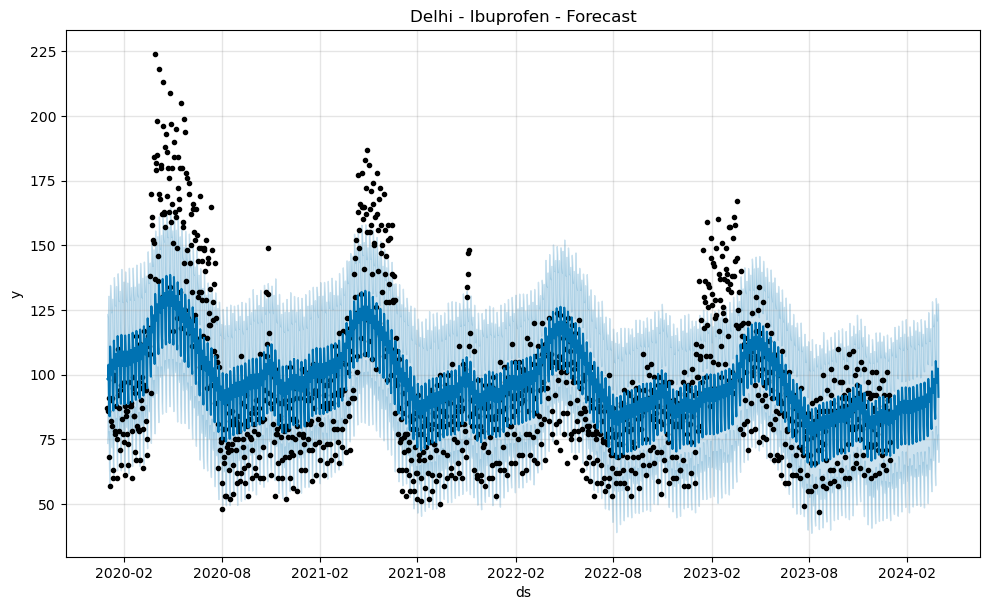

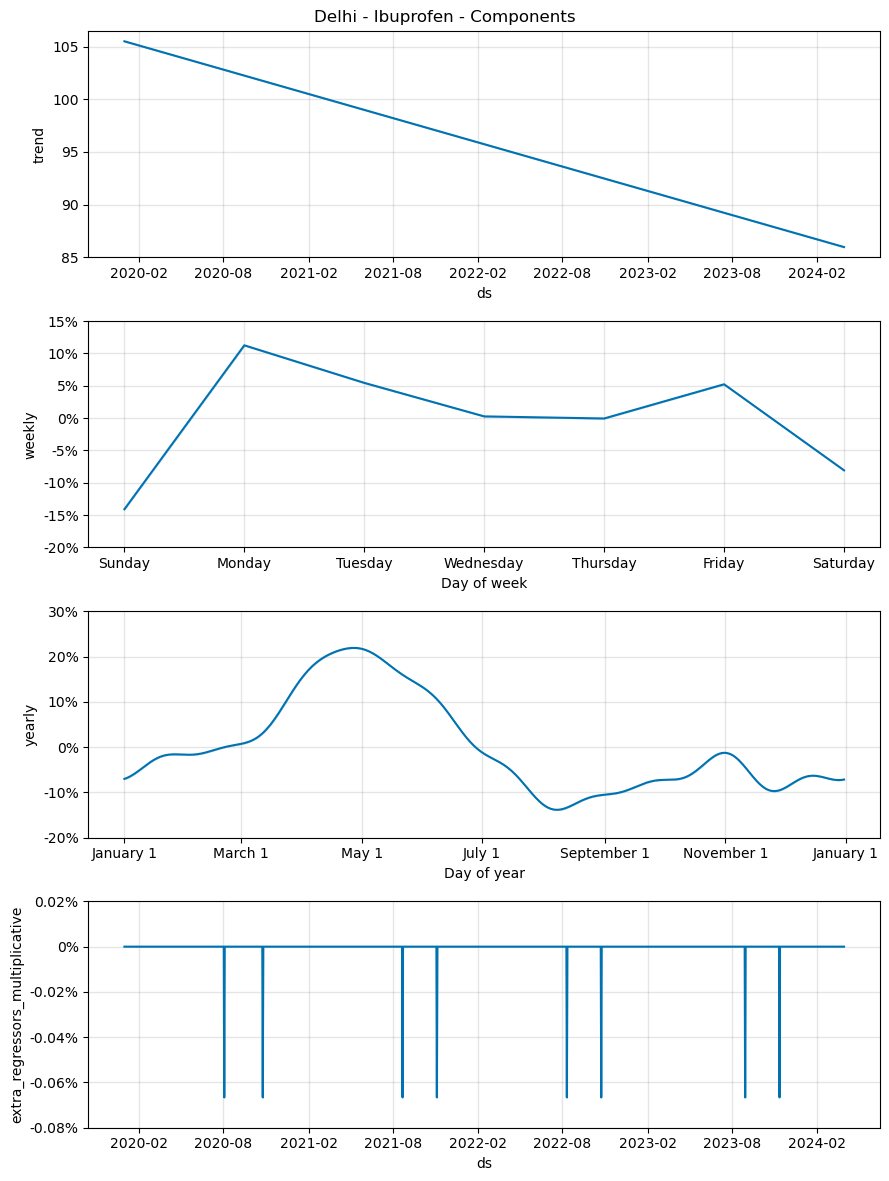

06:07:39 - cmdstanpy - INFO - Chain [1] start processing
06:07:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for amoxicillin in delhi

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:39 - cmdstanpy - INFO - Chain [1] start processing
06:07:39 - cmdstanpy - INFO - Chain [1] done processing
06:07:40 - cmdstanpy - INFO - Chain [1] start processing
06:07:40 - cmdstanpy - INFO - Chain [1] done processing
06:07:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:40 - cmdstanpy - INFO - Chain [1] start processing
06:07:40 - cmdstanpy - INFO - Chain [1] done processing
06:07:40 - cmdstanpy - INFO - Chain [1] start processing
06:07:40 - cmdstanpy - INFO - Chain [1] done processing
06:07:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:40 - cmdstanpy - INFO - Chain [1] start processing
06:07:41 - cmdstanpy - INFO - Chain [1] done processing
06:07:41 - cmdstanpy - INFO - Chain [1] start processing
06:07:41 - cmdstanpy - INFO - Chain [1] done processing
06:07:41 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.15
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:42 - cmdstanpy - INFO - Chain [1] start processing
06:07:42 - cmdstanpy - INFO - Chain [1] done processing
06:07:42 - cmdstanpy - INFO - Chain [1] start processing
06:07:42 - cmdstanpy - INFO - Chain [1] done processing
06:07:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:42 - cmdstanpy - INFO - Chain [1] start processing
06:07:43 - cmdstanpy - INFO - Chain [1] done processing
06:07:43 - cmdstanpy - INFO - Chain [1] start processing
06:07:43 - cmdstanpy - INFO - Chain [1] done processing
06:07:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:44 - cmdstanpy - INFO - Chain [1] start processing
06:07:44 - cmdstanpy - INFO - Chain [1] done processing
06:07:44 - cmdstanpy - INFO - Chain [1] start processing
06:07:44 - cmdstanpy - INFO - Chain [1] done processing
06:07:44 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.34
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:46 - cmdstanpy - INFO - Chain [1] start processing
06:07:46 - cmdstanpy - INFO - Chain [1] done processing
06:07:46 - cmdstanpy - INFO - Chain [1] start processing
06:07:46 - cmdstanpy - INFO - Chain [1] done processing
06:07:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:46 - cmdstanpy - INFO - Chain [1] start processing
06:07:46 - cmdstanpy - INFO - Chain [1] done processing
06:07:47 - cmdstanpy - INFO - Chain [1] start processing
06:07:47 - cmdstanpy - INFO - Chain [1] done processing
06:07:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:47 - cmdstanpy - INFO - Chain [1] start processing
06:07:47 - cmdstanpy - INFO - Chain [1] done processing
06:07:47 - cmdstanpy - INFO - Chain [1] start processing
06:07:47 - cmdstanpy - INFO - Chain [1] done processing
06:07:48 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.58
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:49 - cmdstanpy - INFO - Chain [1] start processing
06:07:49 - cmdstanpy - INFO - Chain [1] done processing
06:07:49 - cmdstanpy - INFO - Chain [1] start processing
06:07:49 - cmdstanpy - INFO - Chain [1] done processing
06:07:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:49 - cmdstanpy - INFO - Chain [1] start processing
06:07:50 - cmdstanpy - INFO - Chain [1] done processing
06:07:50 - cmdstanpy - INFO - Chain [1] start processing
06:07:50 - cmdstanpy - INFO - Chain [1] done processing
06:07:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:50 - cmdstanpy - INFO - Chain [1] start processing
06:07:51 - cmdstanpy - INFO - Chain [1] done processing
06:07:51 - cmdstanpy - INFO - Chain [1] start processing
06:07:51 - cmdstanpy - INFO - Chain [1] done processing
06:07:51 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.68
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:52 - cmdstanpy - INFO - Chain [1] start processing
06:07:52 - cmdstanpy - INFO - Chain [1] done processing
06:07:52 - cmdstanpy - INFO - Chain [1] start processing
06:07:53 - cmdstanpy - INFO - Chain [1] done processing
06:07:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:53 - cmdstanpy - INFO - Chain [1] start processing
06:07:53 - cmdstanpy - INFO - Chain [1] done processing
06:07:53 - cmdstanpy - INFO - Chain [1] start processing
06:07:53 - cmdstanpy - INFO - Chain [1] done processing
06:07:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:53 - cmdstanpy - INFO - Chain [1] start processing
06:07:54 - cmdstanpy - INFO - Chain [1] done processing
06:07:54 - cmdstanpy - INFO - Chain [1] start processing
06:07:54 - cmdstanpy - INFO - Chain [1] done processing
06:07:54 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.06
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:56 - cmdstanpy - INFO - Chain [1] start processing
06:07:56 - cmdstanpy - INFO - Chain [1] done processing
06:07:56 - cmdstanpy - INFO - Chain [1] start processing
06:07:56 - cmdstanpy - INFO - Chain [1] done processing
06:07:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:56 - cmdstanpy - INFO - Chain [1] start processing
06:07:56 - cmdstanpy - INFO - Chain [1] done processing
06:07:57 - cmdstanpy - INFO - Chain [1] start processing
06:07:57 - cmdstanpy - INFO - Chain [1] done processing
06:07:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:57 - cmdstanpy - INFO - Chain [1] start processing
06:07:57 - cmdstanpy - INFO - Chain [1] done processing
06:07:57 - cmdstanpy - INFO - Chain [1] start processing
06:07:57 - cmdstanpy - INFO - Chain [1] done processing
06:07:57 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.37
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:07:59 - cmdstanpy - INFO - Chain [1] start processing
06:07:59 - cmdstanpy - INFO - Chain [1] done processing
06:07:59 - cmdstanpy - INFO - Chain [1] start processing
06:07:59 - cmdstanpy - INFO - Chain [1] done processing
06:07:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:07:59 - cmdstanpy - INFO - Chain [1] start processing
06:08:00 - cmdstanpy - INFO - Chain [1] done processing
06:08:00 - cmdstanpy - INFO - Chain [1] start processing
06:08:00 - cmdstanpy - INFO - Chain [1] done processing
06:08:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:08:00 - cmdstanpy - INFO - Chain [1] start processing
06:08:01 - cmdstanpy - INFO - Chain [1] done processing
06:08:01 - cmdstanpy - INFO - Chain [1] start processing
06:08:01 - cmdstanpy - INFO - Chain [1] done processing
06:08:01 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.96
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:03 - cmdstanpy - INFO - Chain [1] start processing
06:08:03 - cmdstanpy - INFO - Chain [1] done processing
06:08:03 - cmdstanpy - INFO - Chain [1] start processing
06:08:03 - cmdstanpy - INFO - Chain [1] done processing
06:08:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:08:03 - cmdstanpy - INFO - Chain [1] start processing
06:08:04 - cmdstanpy - INFO - Chain [1] done processing
06:08:04 - cmdstanpy - INFO - Chain [1] start processing
06:08:04 - cmdstanpy - INFO - Chain [1] done processing
06:08:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:08:04 - cmdstanpy - INFO - Chain [1] start processing
06:08:04 - cmdstanpy - INFO - Chain [1] done processing
06:08:04 - cmdstanpy - INFO - Chain [1] start processing
06:08:05 - cmdstanpy - INFO - Chain [1] done processing
06:08:05 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.54
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:06 - cmdstanpy - INFO - Chain [1] start processing
06:08:06 - cmdstanpy - INFO - Chain [1] done processing
06:08:06 - cmdstanpy - INFO - Chain [1] start processing
06:08:06 - cmdstanpy - INFO - Chain [1] done processing
06:08:06 - cmdstanpy - INFO - Chain [1] start processing
06:08:06 - cmdstanpy - INFO - Chain [1] done processing
06:08:07 - cmdstanpy - INFO - Chain [1] start processing
06:08:07 - cmdstanpy - INFO - Chain [1] done processing
06:08:07 - cmdstanpy - INFO - Chain [1] start processing
06:08:07 - cmdstanpy - INFO - Chain [1] done processing
06:08:07 - cmdstanpy - INFO - Chain [1] start processing
06:08:07 - cmdstanpy - INFO - Chain [1] done processing
06:08:07 - cmdstanpy - INFO - Chain [1] start processing
06:08:07 - cmdstanpy - INFO - Chain [1] done processing
06:08:07 - cmdstanpy - INFO - Chain [1] start processing
06:08:07 - cmdstanpy - INFO - Chain [1] done processing
06:08:07 - cmdstanpy - INFO - Chain [1] start processing
06:08:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.85
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:08 - cmdstanpy - INFO - Chain [1] start processing
06:08:08 - cmdstanpy - INFO - Chain [1] done processing
06:08:09 - cmdstanpy - INFO - Chain [1] start processing
06:08:09 - cmdstanpy - INFO - Chain [1] done processing
06:08:09 - cmdstanpy - INFO - Chain [1] start processing
06:08:09 - cmdstanpy - INFO - Chain [1] done processing
06:08:09 - cmdstanpy - INFO - Chain [1] start processing
06:08:09 - cmdstanpy - INFO - Chain [1] done processing
06:08:09 - cmdstanpy - INFO - Chain [1] start processing
06:08:09 - cmdstanpy - INFO - Chain [1] done processing
06:08:09 - cmdstanpy - INFO - Chain [1] start processing
06:08:09 - cmdstanpy - INFO - Chain [1] done processing
06:08:09 - cmdstanpy - INFO - Chain [1] start processing
06:08:09 - cmdstanpy - INFO - Chain [1] done processing
06:08:10 - cmdstanpy - INFO - Chain [1] start processing
06:08:10 - cmdstanpy - INFO - Chain [1] done processing
06:08:10 - cmdstanpy - INFO - Chain [1] start processing
06:08:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.87
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:11 - cmdstanpy - INFO - Chain [1] start processing
06:08:11 - cmdstanpy - INFO - Chain [1] done processing
06:08:11 - cmdstanpy - INFO - Chain [1] start processing
06:08:11 - cmdstanpy - INFO - Chain [1] done processing
06:08:11 - cmdstanpy - INFO - Chain [1] start processing
06:08:11 - cmdstanpy - INFO - Chain [1] done processing
06:08:11 - cmdstanpy - INFO - Chain [1] start processing
06:08:11 - cmdstanpy - INFO - Chain [1] done processing
06:08:11 - cmdstanpy - INFO - Chain [1] start processing
06:08:11 - cmdstanpy - INFO - Chain [1] done processing
06:08:12 - cmdstanpy - INFO - Chain [1] start processing
06:08:12 - cmdstanpy - INFO - Chain [1] done processing
06:08:12 - cmdstanpy - INFO - Chain [1] start processing
06:08:12 - cmdstanpy - INFO - Chain [1] done processing
06:08:12 - cmdstanpy - INFO - Chain [1] start processing
06:08:12 - cmdstanpy - INFO - Chain [1] done processing
06:08:12 - cmdstanpy - INFO - Chain [1] start processing
06:08:12 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.22
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:13 - cmdstanpy - INFO - Chain [1] start processing
06:08:13 - cmdstanpy - INFO - Chain [1] done processing
06:08:13 - cmdstanpy - INFO - Chain [1] start processing
06:08:13 - cmdstanpy - INFO - Chain [1] done processing
06:08:13 - cmdstanpy - INFO - Chain [1] start processing
06:08:13 - cmdstanpy - INFO - Chain [1] done processing
06:08:14 - cmdstanpy - INFO - Chain [1] start processing
06:08:14 - cmdstanpy - INFO - Chain [1] done processing
06:08:14 - cmdstanpy - INFO - Chain [1] start processing
06:08:14 - cmdstanpy - INFO - Chain [1] done processing
06:08:14 - cmdstanpy - INFO - Chain [1] start processing
06:08:14 - cmdstanpy - INFO - Chain [1] done processing
06:08:14 - cmdstanpy - INFO - Chain [1] start processing
06:08:14 - cmdstanpy - INFO - Chain [1] done processing
06:08:14 - cmdstanpy - INFO - Chain [1] start processing
06:08:14 - cmdstanpy - INFO - Chain [1] done processing
06:08:14 - cmdstanpy - INFO - Chain [1] start processing
06:08:14 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.81
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:15 - cmdstanpy - INFO - Chain [1] start processing
06:08:16 - cmdstanpy - INFO - Chain [1] done processing
06:08:16 - cmdstanpy - INFO - Chain [1] start processing
06:08:16 - cmdstanpy - INFO - Chain [1] done processing
06:08:16 - cmdstanpy - INFO - Chain [1] start processing
06:08:16 - cmdstanpy - INFO - Chain [1] done processing
06:08:16 - cmdstanpy - INFO - Chain [1] start processing
06:08:16 - cmdstanpy - INFO - Chain [1] done processing
06:08:16 - cmdstanpy - INFO - Chain [1] start processing
06:08:16 - cmdstanpy - INFO - Chain [1] done processing
06:08:16 - cmdstanpy - INFO - Chain [1] start processing
06:08:16 - cmdstanpy - INFO - Chain [1] done processing
06:08:16 - cmdstanpy - INFO - Chain [1] start processing
06:08:16 - cmdstanpy - INFO - Chain [1] done processing
06:08:17 - cmdstanpy - INFO - Chain [1] start processing
06:08:17 - cmdstanpy - INFO - Chain [1] done processing
06:08:17 - cmdstanpy - INFO - Chain [1] start processing
06:08:17 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.35
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:18 - cmdstanpy - INFO - Chain [1] start processing
06:08:18 - cmdstanpy - INFO - Chain [1] done processing
06:08:18 - cmdstanpy - INFO - Chain [1] start processing
06:08:18 - cmdstanpy - INFO - Chain [1] done processing
06:08:18 - cmdstanpy - INFO - Chain [1] start processing
06:08:18 - cmdstanpy - INFO - Chain [1] done processing
06:08:18 - cmdstanpy - INFO - Chain [1] start processing
06:08:18 - cmdstanpy - INFO - Chain [1] done processing
06:08:19 - cmdstanpy - INFO - Chain [1] start processing
06:08:19 - cmdstanpy - INFO - Chain [1] done processing
06:08:19 - cmdstanpy - INFO - Chain [1] start processing
06:08:19 - cmdstanpy - INFO - Chain [1] done processing
06:08:19 - cmdstanpy - INFO - Chain [1] start processing
06:08:19 - cmdstanpy - INFO - Chain [1] done processing
06:08:19 - cmdstanpy - INFO - Chain [1] start processing
06:08:19 - cmdstanpy - INFO - Chain [1] done processing
06:08:19 - cmdstanpy - INFO - Chain [1] start processing
06:08:19 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.64
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:20 - cmdstanpy - INFO - Chain [1] start processing
06:08:20 - cmdstanpy - INFO - Chain [1] done processing
06:08:20 - cmdstanpy - INFO - Chain [1] start processing
06:08:20 - cmdstanpy - INFO - Chain [1] done processing
06:08:21 - cmdstanpy - INFO - Chain [1] start processing
06:08:21 - cmdstanpy - INFO - Chain [1] done processing
06:08:21 - cmdstanpy - INFO - Chain [1] start processing
06:08:21 - cmdstanpy - INFO - Chain [1] done processing
06:08:21 - cmdstanpy - INFO - Chain [1] start processing
06:08:21 - cmdstanpy - INFO - Chain [1] done processing
06:08:21 - cmdstanpy - INFO - Chain [1] start processing
06:08:21 - cmdstanpy - INFO - Chain [1] done processing
06:08:21 - cmdstanpy - INFO - Chain [1] start processing
06:08:21 - cmdstanpy - INFO - Chain [1] done processing
06:08:21 - cmdstanpy - INFO - Chain [1] start processing
06:08:21 - cmdstanpy - INFO - Chain [1] done processing
06:08:22 - cmdstanpy - INFO - Chain [1] start processing
06:08:22 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.38
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:23 - cmdstanpy - INFO - Chain [1] start processing
06:08:23 - cmdstanpy - INFO - Chain [1] done processing
06:08:23 - cmdstanpy - INFO - Chain [1] start processing
06:08:23 - cmdstanpy - INFO - Chain [1] done processing
06:08:23 - cmdstanpy - INFO - Chain [1] start processing
06:08:23 - cmdstanpy - INFO - Chain [1] done processing
06:08:23 - cmdstanpy - INFO - Chain [1] start processing
06:08:23 - cmdstanpy - INFO - Chain [1] done processing
06:08:23 - cmdstanpy - INFO - Chain [1] start processing
06:08:23 - cmdstanpy - INFO - Chain [1] done processing
06:08:23 - cmdstanpy - INFO - Chain [1] start processing
06:08:23 - cmdstanpy - INFO - Chain [1] done processing
06:08:24 - cmdstanpy - INFO - Chain [1] start processing
06:08:24 - cmdstanpy - INFO - Chain [1] done processing
06:08:24 - cmdstanpy - INFO - Chain [1] start processing
06:08:24 - cmdstanpy - INFO - Chain [1] done processing
06:08:24 - cmdstanpy - INFO - Chain [1] start processing
06:08:24 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.83
---


06:08:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:25 - cmdstanpy - INFO - Chain [1] start processing
06:08:25 - cmdstanpy - INFO - Chain [1] done processing
06:08:25 - cmdstanpy - INFO - Chain [1] start processing
06:08:25 - cmdstanpy - INFO - Chain [1] done processing
06:08:26 - cmdstanpy - INFO - Chain [1] start processing
06:08:26 - cmdstanpy - INFO - Chain [1] done processing
06:08:26 - cmdstanpy - INFO - Chain [1] start processing
06:08:26 - cmdstanpy - INFO - Chain [1] done processing
06:08:26 - cmdstanpy - INFO - Chain [1] start processing
06:08:26 - cmdstanpy - INFO - Chain [1] done processing
06:08:26 - cmdstanpy - INFO - Chain [1] start processing
06:08:26 - cmdstanpy - INFO - Chain [1] done processing
06:08:26 - cmdstanpy - INFO - Chain [1] start processing
06:08:26 - cmdstanpy - INFO - Chain [1] done processing
06:08:26 - cmdstanpy - INFO - Chain [1] start processing
06:08:27 - cmdstanpy - INFO - Chain [1] done processing
06:08:27 - cmdstanpy - INFO - Chain [1] start processing
06:08:27 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.76
---


06:08:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:28 - cmdstanpy - INFO - Chain [1] start processing
06:08:28 - cmdstanpy - INFO - Chain [1] done processing
06:08:28 - cmdstanpy - INFO - Chain [1] start processing
06:08:28 - cmdstanpy - INFO - Chain [1] done processing
06:08:28 - cmdstanpy - INFO - Chain [1] start processing
06:08:28 - cmdstanpy - INFO - Chain [1] done processing
06:08:29 - cmdstanpy - INFO - Chain [1] start processing
06:08:29 - cmdstanpy - INFO - Chain [1] done processing
06:08:29 - cmdstanpy - INFO - Chain [1] start processing
06:08:29 - cmdstanpy - INFO - Chain [1] done processing
06:08:29 - cmdstanpy - INFO - Chain [1] start processing
06:08:29 - cmdstanpy - INFO - Chain [1] done processing
06:08:29 - cmdstanpy - INFO - Chain [1] start processing
06:08:29 - cmdstanpy - INFO - Chain [1] done processing
06:08:29 - cmdstanpy - INFO - Chain [1] start processing
06:08:29 - cmdstanpy - INFO - Chain [1] done processing
06:08:29 - cmdstanpy - INFO - Chain [1] start processing
06:08:30 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.87
---


06:08:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:31 - cmdstanpy - INFO - Chain [1] start processing
06:08:31 - cmdstanpy - INFO - Chain [1] done processing
06:08:31 - cmdstanpy - INFO - Chain [1] start processing
06:08:31 - cmdstanpy - INFO - Chain [1] done processing
06:08:31 - cmdstanpy - INFO - Chain [1] start processing
06:08:31 - cmdstanpy - INFO - Chain [1] done processing
06:08:31 - cmdstanpy - INFO - Chain [1] start processing
06:08:31 - cmdstanpy - INFO - Chain [1] done processing
06:08:31 - cmdstanpy - INFO - Chain [1] start processing
06:08:31 - cmdstanpy - INFO - Chain [1] done processing
06:08:32 - cmdstanpy - INFO - Chain [1] start processing
06:08:32 - cmdstanpy - INFO - Chain [1] done processing
06:08:32 - cmdstanpy - INFO - Chain [1] start processing
06:08:32 - cmdstanpy - INFO - Chain [1] done processing
06:08:32 - cmdstanpy - INFO - Chain [1] start processing
06:08:32 - cmdstanpy - INFO - Chain [1] done processing
06:08:32 - cmdstanpy - INFO - Chain [1] start processing
06:08:32 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.94
---


06:08:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:34 - cmdstanpy - INFO - Chain [1] start processing
06:08:34 - cmdstanpy - INFO - Chain [1] done processing
06:08:34 - cmdstanpy - INFO - Chain [1] start processing
06:08:34 - cmdstanpy - INFO - Chain [1] done processing
06:08:34 - cmdstanpy - INFO - Chain [1] start processing
06:08:34 - cmdstanpy - INFO - Chain [1] done processing
06:08:34 - cmdstanpy - INFO - Chain [1] start processing
06:08:34 - cmdstanpy - INFO - Chain [1] done processing
06:08:34 - cmdstanpy - INFO - Chain [1] start processing
06:08:34 - cmdstanpy - INFO - Chain [1] done processing
06:08:34 - cmdstanpy - INFO - Chain [1] start processing
06:08:34 - cmdstanpy - INFO - Chain [1] done processing
06:08:34 - cmdstanpy - INFO - Chain [1] start processing
06:08:35 - cmdstanpy - INFO - Chain [1] done processing
06:08:35 - cmdstanpy - INFO - Chain [1] start processing
06:08:35 - cmdstanpy - INFO - Chain [1] done processing
06:08:35 - cmdstanpy - INFO - Chain [1] start processing
06:08:35 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.47
---


06:08:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:36 - cmdstanpy - INFO - Chain [1] start processing
06:08:36 - cmdstanpy - INFO - Chain [1] done processing
06:08:36 - cmdstanpy - INFO - Chain [1] start processing
06:08:36 - cmdstanpy - INFO - Chain [1] done processing
06:08:36 - cmdstanpy - INFO - Chain [1] start processing
06:08:37 - cmdstanpy - INFO - Chain [1] done processing
06:08:37 - cmdstanpy - INFO - Chain [1] start processing
06:08:37 - cmdstanpy - INFO - Chain [1] done processing
06:08:37 - cmdstanpy - INFO - Chain [1] start processing
06:08:37 - cmdstanpy - INFO - Chain [1] done processing
06:08:37 - cmdstanpy - INFO - Chain [1] start processing
06:08:37 - cmdstanpy - INFO - Chain [1] done processing
06:08:37 - cmdstanpy - INFO - Chain [1] start processing
06:08:37 - cmdstanpy - INFO - Chain [1] done processing
06:08:37 - cmdstanpy - INFO - Chain [1] start processing
06:08:37 - cmdstanpy - INFO - Chain [1] done processing
06:08:38 - cmdstanpy - INFO - Chain [1] start processing
06:08:38 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.40
---


06:08:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:39 - cmdstanpy - INFO - Chain [1] start processing
06:08:39 - cmdstanpy - INFO - Chain [1] done processing
06:08:39 - cmdstanpy - INFO - Chain [1] start processing
06:08:39 - cmdstanpy - INFO - Chain [1] done processing
06:08:39 - cmdstanpy - INFO - Chain [1] start processing
06:08:39 - cmdstanpy - INFO - Chain [1] done processing
06:08:39 - cmdstanpy - INFO - Chain [1] start processing
06:08:40 - cmdstanpy - INFO - Chain [1] done processing
06:08:40 - cmdstanpy - INFO - Chain [1] start processing
06:08:40 - cmdstanpy - INFO - Chain [1] done processing
06:08:40 - cmdstanpy - INFO - Chain [1] start processing
06:08:40 - cmdstanpy - INFO - Chain [1] done processing
06:08:40 - cmdstanpy - INFO - Chain [1] start processing
06:08:40 - cmdstanpy - INFO - Chain [1] done processing
06:08:40 - cmdstanpy - INFO - Chain [1] start processing
06:08:40 - cmdstanpy - INFO - Chain [1] done processing
06:08:40 - cmdstanpy - INFO - Chain [1] start processing
06:08:41 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.78
---


06:08:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:42 - cmdstanpy - INFO - Chain [1] start processing
06:08:42 - cmdstanpy - INFO - Chain [1] done processing
06:08:42 - cmdstanpy - INFO - Chain [1] start processing
06:08:42 - cmdstanpy - INFO - Chain [1] done processing
06:08:42 - cmdstanpy - INFO - Chain [1] start processing
06:08:42 - cmdstanpy - INFO - Chain [1] done processing
06:08:42 - cmdstanpy - INFO - Chain [1] start processing
06:08:42 - cmdstanpy - INFO - Chain [1] done processing
06:08:42 - cmdstanpy - INFO - Chain [1] start processing
06:08:42 - cmdstanpy - INFO - Chain [1] done processing
06:08:43 - cmdstanpy - INFO - Chain [1] start processing
06:08:43 - cmdstanpy - INFO - Chain [1] done processing
06:08:43 - cmdstanpy - INFO - Chain [1] start processing
06:08:43 - cmdstanpy - INFO - Chain [1] done processing
06:08:43 - cmdstanpy - INFO - Chain [1] start processing
06:08:43 - cmdstanpy - INFO - Chain [1] done processing
06:08:43 - cmdstanpy - INFO - Chain [1] start processing
06:08:43 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.64
---


06:08:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:45 - cmdstanpy - INFO - Chain [1] start processing
06:08:45 - cmdstanpy - INFO - Chain [1] done processing
06:08:45 - cmdstanpy - INFO - Chain [1] start processing
06:08:45 - cmdstanpy - INFO - Chain [1] done processing
06:08:45 - cmdstanpy - INFO - Chain [1] start processing
06:08:45 - cmdstanpy - INFO - Chain [1] done processing
06:08:45 - cmdstanpy - INFO - Chain [1] start processing
06:08:45 - cmdstanpy - INFO - Chain [1] done processing
06:08:45 - cmdstanpy - INFO - Chain [1] start processing
06:08:45 - cmdstanpy - INFO - Chain [1] done processing
06:08:45 - cmdstanpy - INFO - Chain [1] start processing
06:08:45 - cmdstanpy - INFO - Chain [1] done processing
06:08:46 - cmdstanpy - INFO - Chain [1] start processing
06:08:46 - cmdstanpy - INFO - Chain [1] done processing
06:08:46 - cmdstanpy - INFO - Chain [1] start processing
06:08:46 - cmdstanpy - INFO - Chain [1] done processing
06:08:46 - cmdstanpy - INFO - Chain [1] start processing
06:08:46 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.74
---


06:08:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:47 - cmdstanpy - INFO - Chain [1] start processing
06:08:47 - cmdstanpy - INFO - Chain [1] done processing
06:08:47 - cmdstanpy - INFO - Chain [1] start processing
06:08:48 - cmdstanpy - INFO - Chain [1] done processing
06:08:48 - cmdstanpy - INFO - Chain [1] start processing
06:08:48 - cmdstanpy - INFO - Chain [1] done processing
06:08:48 - cmdstanpy - INFO - Chain [1] start processing
06:08:48 - cmdstanpy - INFO - Chain [1] done processing
06:08:48 - cmdstanpy - INFO - Chain [1] start processing
06:08:48 - cmdstanpy - INFO - Chain [1] done processing
06:08:48 - cmdstanpy - INFO - Chain [1] start processing
06:08:49 - cmdstanpy - INFO - Chain [1] done processing
06:08:49 - cmdstanpy - INFO - Chain [1] start processing
06:08:49 - cmdstanpy - INFO - Chain [1] done processing
06:08:49 - cmdstanpy - INFO - Chain [1] start processing
06:08:49 - cmdstanpy - INFO - Chain [1] done processing
06:08:49 - cmdstanpy - INFO - Chain [1] start processing
06:08:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.68
---


06:08:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:51 - cmdstanpy - INFO - Chain [1] start processing
06:08:51 - cmdstanpy - INFO - Chain [1] done processing
06:08:51 - cmdstanpy - INFO - Chain [1] start processing
06:08:51 - cmdstanpy - INFO - Chain [1] done processing
06:08:51 - cmdstanpy - INFO - Chain [1] start processing
06:08:51 - cmdstanpy - INFO - Chain [1] done processing
06:08:51 - cmdstanpy - INFO - Chain [1] start processing
06:08:51 - cmdstanpy - INFO - Chain [1] done processing
06:08:52 - cmdstanpy - INFO - Chain [1] start processing
06:08:52 - cmdstanpy - INFO - Chain [1] done processing
06:08:52 - cmdstanpy - INFO - Chain [1] start processing
06:08:52 - cmdstanpy - INFO - Chain [1] done processing
06:08:52 - cmdstanpy - INFO - Chain [1] start processing
06:08:52 - cmdstanpy - INFO - Chain [1] done processing
06:08:52 - cmdstanpy - INFO - Chain [1] start processing
06:08:52 - cmdstanpy - INFO - Chain [1] done processing
06:08:53 - cmdstanpy - INFO - Chain [1] start processing
06:08:53 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.84
---


06:08:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:54 - cmdstanpy - INFO - Chain [1] start processing
06:08:55 - cmdstanpy - INFO - Chain [1] done processing
06:08:55 - cmdstanpy - INFO - Chain [1] start processing
06:08:55 - cmdstanpy - INFO - Chain [1] done processing
06:08:55 - cmdstanpy - INFO - Chain [1] start processing
06:08:55 - cmdstanpy - INFO - Chain [1] done processing
06:08:55 - cmdstanpy - INFO - Chain [1] start processing
06:08:55 - cmdstanpy - INFO - Chain [1] done processing
06:08:55 - cmdstanpy - INFO - Chain [1] start processing
06:08:55 - cmdstanpy - INFO - Chain [1] done processing
06:08:55 - cmdstanpy - INFO - Chain [1] start processing
06:08:55 - cmdstanpy - INFO - Chain [1] done processing
06:08:56 - cmdstanpy - INFO - Chain [1] start processing
06:08:56 - cmdstanpy - INFO - Chain [1] done processing
06:08:56 - cmdstanpy - INFO - Chain [1] start processing
06:08:56 - cmdstanpy - INFO - Chain [1] done processing
06:08:56 - cmdstanpy - INFO - Chain [1] start processing
06:08:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.42
---


06:08:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:08:58 - cmdstanpy - INFO - Chain [1] start processing
06:08:58 - cmdstanpy - INFO - Chain [1] done processing
06:08:58 - cmdstanpy - INFO - Chain [1] start processing
06:08:58 - cmdstanpy - INFO - Chain [1] done processing
06:08:58 - cmdstanpy - INFO - Chain [1] start processing
06:08:58 - cmdstanpy - INFO - Chain [1] done processing
06:08:58 - cmdstanpy - INFO - Chain [1] start processing
06:08:58 - cmdstanpy - INFO - Chain [1] done processing
06:08:58 - cmdstanpy - INFO - Chain [1] start processing
06:08:59 - cmdstanpy - INFO - Chain [1] done processing
06:08:59 - cmdstanpy - INFO - Chain [1] start processing
06:08:59 - cmdstanpy - INFO - Chain [1] done processing
06:08:59 - cmdstanpy - INFO - Chain [1] start processing
06:08:59 - cmdstanpy - INFO - Chain [1] done processing
06:08:59 - cmdstanpy - INFO - Chain [1] start processing
06:08:59 - cmdstanpy - INFO - Chain [1] done processing
06:08:59 - cmdstanpy - INFO - Chain [1] start processing
06:08:59 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 27.89
---


06:09:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:01 - cmdstanpy - INFO - Chain [1] start processing
06:09:01 - cmdstanpy - INFO - Chain [1] done processing
06:09:01 - cmdstanpy - INFO - Chain [1] start processing
06:09:01 - cmdstanpy - INFO - Chain [1] done processing
06:09:01 - cmdstanpy - INFO - Chain [1] start processing
06:09:01 - cmdstanpy - INFO - Chain [1] done processing
06:09:02 - cmdstanpy - INFO - Chain [1] start processing
06:09:02 - cmdstanpy - INFO - Chain [1] done processing
06:09:02 - cmdstanpy - INFO - Chain [1] start processing
06:09:02 - cmdstanpy - INFO - Chain [1] done processing
06:09:02 - cmdstanpy - INFO - Chain [1] start processing
06:09:02 - cmdstanpy - INFO - Chain [1] done processing
06:09:02 - cmdstanpy - INFO - Chain [1] start processing
06:09:02 - cmdstanpy - INFO - Chain [1] done processing
06:09:02 - cmdstanpy - INFO - Chain [1] start processing
06:09:03 - cmdstanpy - INFO - Chain [1] done processing
06:09:03 - cmdstanpy - INFO - Chain [1] start processing
06:09:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.29
---


06:09:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:04 - cmdstanpy - INFO - Chain [1] start processing
06:09:05 - cmdstanpy - INFO - Chain [1] done processing
06:09:05 - cmdstanpy - INFO - Chain [1] start processing
06:09:05 - cmdstanpy - INFO - Chain [1] done processing
06:09:05 - cmdstanpy - INFO - Chain [1] start processing
06:09:05 - cmdstanpy - INFO - Chain [1] done processing
06:09:05 - cmdstanpy - INFO - Chain [1] start processing
06:09:05 - cmdstanpy - INFO - Chain [1] done processing
06:09:05 - cmdstanpy - INFO - Chain [1] start processing
06:09:05 - cmdstanpy - INFO - Chain [1] done processing
06:09:05 - cmdstanpy - INFO - Chain [1] start processing
06:09:06 - cmdstanpy - INFO - Chain [1] done processing
06:09:06 - cmdstanpy - INFO - Chain [1] start processing
06:09:06 - cmdstanpy - INFO - Chain [1] done processing
06:09:06 - cmdstanpy - INFO - Chain [1] start processing
06:09:06 - cmdstanpy - INFO - Chain [1] done processing
06:09:06 - cmdstanpy - INFO - Chain [1] start processing
06:09:06 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.50
---


06:09:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:08 - cmdstanpy - INFO - Chain [1] start processing
06:09:08 - cmdstanpy - INFO - Chain [1] done processing
06:09:08 - cmdstanpy - INFO - Chain [1] start processing
06:09:08 - cmdstanpy - INFO - Chain [1] done processing
06:09:08 - cmdstanpy - INFO - Chain [1] start processing
06:09:08 - cmdstanpy - INFO - Chain [1] done processing
06:09:09 - cmdstanpy - INFO - Chain [1] start processing
06:09:09 - cmdstanpy - INFO - Chain [1] done processing
06:09:09 - cmdstanpy - INFO - Chain [1] start processing
06:09:09 - cmdstanpy - INFO - Chain [1] done processing
06:09:09 - cmdstanpy - INFO - Chain [1] start processing
06:09:09 - cmdstanpy - INFO - Chain [1] done processing
06:09:09 - cmdstanpy - INFO - Chain [1] start processing
06:09:09 - cmdstanpy - INFO - Chain [1] done processing
06:09:09 - cmdstanpy - INFO - Chain [1] start processing
06:09:09 - cmdstanpy - INFO - Chain [1] done processing
06:09:10 - cmdstanpy - INFO - Chain [1] start processing
06:09:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.26
---


06:09:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:11 - cmdstanpy - INFO - Chain [1] start processing
06:09:12 - cmdstanpy - INFO - Chain [1] done processing
06:09:12 - cmdstanpy - INFO - Chain [1] start processing
06:09:12 - cmdstanpy - INFO - Chain [1] done processing
06:09:12 - cmdstanpy - INFO - Chain [1] start processing
06:09:12 - cmdstanpy - INFO - Chain [1] done processing
06:09:12 - cmdstanpy - INFO - Chain [1] start processing
06:09:12 - cmdstanpy - INFO - Chain [1] done processing
06:09:12 - cmdstanpy - INFO - Chain [1] start processing
06:09:12 - cmdstanpy - INFO - Chain [1] done processing
06:09:12 - cmdstanpy - INFO - Chain [1] start processing
06:09:12 - cmdstanpy - INFO - Chain [1] done processing
06:09:13 - cmdstanpy - INFO - Chain [1] start processing
06:09:13 - cmdstanpy - INFO - Chain [1] done processing
06:09:13 - cmdstanpy - INFO - Chain [1] start processing
06:09:13 - cmdstanpy - INFO - Chain [1] done processing
06:09:13 - cmdstanpy - INFO - Chain [1] start processing
06:09:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.39
---


06:09:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:15 - cmdstanpy - INFO - Chain [1] start processing
06:09:15 - cmdstanpy - INFO - Chain [1] done processing
06:09:15 - cmdstanpy - INFO - Chain [1] start processing
06:09:15 - cmdstanpy - INFO - Chain [1] done processing
06:09:16 - cmdstanpy - INFO - Chain [1] start processing
06:09:16 - cmdstanpy - INFO - Chain [1] done processing
06:09:16 - cmdstanpy - INFO - Chain [1] start processing
06:09:16 - cmdstanpy - INFO - Chain [1] done processing
06:09:16 - cmdstanpy - INFO - Chain [1] start processing
06:09:16 - cmdstanpy - INFO - Chain [1] done processing
06:09:17 - cmdstanpy - INFO - Chain [1] start processing
06:09:17 - cmdstanpy - INFO - Chain [1] done processing
06:09:17 - cmdstanpy - INFO - Chain [1] start processing
06:09:17 - cmdstanpy - INFO - Chain [1] done processing
06:09:17 - cmdstanpy - INFO - Chain [1] start processing
06:09:18 - cmdstanpy - INFO - Chain [1] done processing
06:09:18 - cmdstanpy - INFO - Chain [1] start processing
06:09:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.28
---


06:09:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:21 - cmdstanpy - INFO - Chain [1] start processing
06:09:21 - cmdstanpy - INFO - Chain [1] done processing
06:09:21 - cmdstanpy - INFO - Chain [1] start processing
06:09:21 - cmdstanpy - INFO - Chain [1] done processing
06:09:21 - cmdstanpy - INFO - Chain [1] start processing
06:09:21 - cmdstanpy - INFO - Chain [1] done processing
06:09:22 - cmdstanpy - INFO - Chain [1] start processing
06:09:22 - cmdstanpy - INFO - Chain [1] done processing
06:09:22 - cmdstanpy - INFO - Chain [1] start processing
06:09:22 - cmdstanpy - INFO - Chain [1] done processing
06:09:22 - cmdstanpy - INFO - Chain [1] start processing
06:09:22 - cmdstanpy - INFO - Chain [1] done processing
06:09:23 - cmdstanpy - INFO - Chain [1] start processing
06:09:23 - cmdstanpy - INFO - Chain [1] done processing
06:09:23 - cmdstanpy - INFO - Chain [1] start processing
06:09:23 - cmdstanpy - INFO - Chain [1] done processing
06:09:23 - cmdstanpy - INFO - Chain [1] start processing
06:09:24 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.50
---


06:09:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:26 - cmdstanpy - INFO - Chain [1] start processing
06:09:26 - cmdstanpy - INFO - Chain [1] done processing
06:09:26 - cmdstanpy - INFO - Chain [1] start processing
06:09:26 - cmdstanpy - INFO - Chain [1] done processing
06:09:27 - cmdstanpy - INFO - Chain [1] start processing
06:09:27 - cmdstanpy - INFO - Chain [1] done processing
06:09:27 - cmdstanpy - INFO - Chain [1] start processing
06:09:27 - cmdstanpy - INFO - Chain [1] done processing
06:09:27 - cmdstanpy - INFO - Chain [1] start processing
06:09:28 - cmdstanpy - INFO - Chain [1] done processing
06:09:28 - cmdstanpy - INFO - Chain [1] start processing
06:09:28 - cmdstanpy - INFO - Chain [1] done processing
06:09:28 - cmdstanpy - INFO - Chain [1] start processing
06:09:28 - cmdstanpy - INFO - Chain [1] done processing
06:09:28 - cmdstanpy - INFO - Chain [1] start processing
06:09:29 - cmdstanpy - INFO - Chain [1] done processing
06:09:29 - cmdstanpy - INFO - Chain [1] start processing
06:09:30 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 17.10
---


06:09:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:32 - cmdstanpy - INFO - Chain [1] start processing
06:09:32 - cmdstanpy - INFO - Chain [1] done processing
06:09:32 - cmdstanpy - INFO - Chain [1] start processing
06:09:33 - cmdstanpy - INFO - Chain [1] done processing
06:09:33 - cmdstanpy - INFO - Chain [1] start processing
06:09:33 - cmdstanpy - INFO - Chain [1] done processing
06:09:33 - cmdstanpy - INFO - Chain [1] start processing
06:09:33 - cmdstanpy - INFO - Chain [1] done processing
06:09:33 - cmdstanpy - INFO - Chain [1] start processing
06:09:33 - cmdstanpy - INFO - Chain [1] done processing
06:09:34 - cmdstanpy - INFO - Chain [1] start processing
06:09:34 - cmdstanpy - INFO - Chain [1] done processing
06:09:34 - cmdstanpy - INFO - Chain [1] start processing
06:09:34 - cmdstanpy - INFO - Chain [1] done processing
06:09:34 - cmdstanpy - INFO - Chain [1] start processing
06:09:35 - cmdstanpy - INFO - Chain [1] done processing
06:09:35 - cmdstanpy - INFO - Chain [1] start processing
06:09:35 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.71
---


06:09:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:38 - cmdstanpy - INFO - Chain [1] start processing
06:09:38 - cmdstanpy - INFO - Chain [1] done processing
06:09:38 - cmdstanpy - INFO - Chain [1] start processing
06:09:38 - cmdstanpy - INFO - Chain [1] done processing
06:09:38 - cmdstanpy - INFO - Chain [1] start processing
06:09:38 - cmdstanpy - INFO - Chain [1] done processing
06:09:38 - cmdstanpy - INFO - Chain [1] start processing
06:09:39 - cmdstanpy - INFO - Chain [1] done processing
06:09:39 - cmdstanpy - INFO - Chain [1] start processing
06:09:39 - cmdstanpy - INFO - Chain [1] done processing
06:09:39 - cmdstanpy - INFO - Chain [1] start processing
06:09:39 - cmdstanpy - INFO - Chain [1] done processing
06:09:39 - cmdstanpy - INFO - Chain [1] start processing
06:09:40 - cmdstanpy - INFO - Chain [1] done processing
06:09:40 - cmdstanpy - INFO - Chain [1] start processing
06:09:40 - cmdstanpy - INFO - Chain [1] done processing
06:09:40 - cmdstanpy - INFO - Chain [1] start processing
06:09:41 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 16.93
---


06:09:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:43 - cmdstanpy - INFO - Chain [1] start processing
06:09:43 - cmdstanpy - INFO - Chain [1] done processing
06:09:43 - cmdstanpy - INFO - Chain [1] start processing
06:09:44 - cmdstanpy - INFO - Chain [1] done processing
06:09:44 - cmdstanpy - INFO - Chain [1] start processing
06:09:44 - cmdstanpy - INFO - Chain [1] done processing
06:09:44 - cmdstanpy - INFO - Chain [1] start processing
06:09:44 - cmdstanpy - INFO - Chain [1] done processing
06:09:44 - cmdstanpy - INFO - Chain [1] start processing
06:09:45 - cmdstanpy - INFO - Chain [1] done processing
06:09:45 - cmdstanpy - INFO - Chain [1] start processing
06:09:45 - cmdstanpy - INFO - Chain [1] done processing
06:09:45 - cmdstanpy - INFO - Chain [1] start processing
06:09:45 - cmdstanpy - INFO - Chain [1] done processing
06:09:45 - cmdstanpy - INFO - Chain [1] start processing
06:09:46 - cmdstanpy - INFO - Chain [1] done processing
06:09:46 - cmdstanpy - INFO - Chain [1] start processing
06:09:46 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.08
---


06:09:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:48 - cmdstanpy - INFO - Chain [1] start processing
06:09:49 - cmdstanpy - INFO - Chain [1] done processing
06:09:49 - cmdstanpy - INFO - Chain [1] start processing
06:09:49 - cmdstanpy - INFO - Chain [1] done processing
06:09:49 - cmdstanpy - INFO - Chain [1] start processing
06:09:49 - cmdstanpy - INFO - Chain [1] done processing
06:09:49 - cmdstanpy - INFO - Chain [1] start processing
06:09:49 - cmdstanpy - INFO - Chain [1] done processing
06:09:50 - cmdstanpy - INFO - Chain [1] start processing
06:09:50 - cmdstanpy - INFO - Chain [1] done processing
06:09:50 - cmdstanpy - INFO - Chain [1] start processing
06:09:50 - cmdstanpy - INFO - Chain [1] done processing
06:09:50 - cmdstanpy - INFO - Chain [1] start processing
06:09:51 - cmdstanpy - INFO - Chain [1] done processing
06:09:51 - cmdstanpy - INFO - Chain [1] start processing
06:09:51 - cmdstanpy - INFO - Chain [1] done processing
06:09:51 - cmdstanpy - INFO - Chain [1] start processing
06:09:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 16.96
---


06:09:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:09:54 - cmdstanpy - INFO - Chain [1] start processing
06:09:54 - cmdstanpy - INFO - Chain [1] done processing
06:09:54 - cmdstanpy - INFO - Chain [1] start processing
06:09:55 - cmdstanpy - INFO - Chain [1] done processing
06:09:55 - cmdstanpy - INFO - Chain [1] start processing
06:09:55 - cmdstanpy - INFO - Chain [1] done processing
06:09:55 - cmdstanpy - INFO - Chain [1] start processing
06:09:55 - cmdstanpy - INFO - Chain [1] done processing
06:09:55 - cmdstanpy - INFO - Chain [1] start processing
06:09:56 - cmdstanpy - INFO - Chain [1] done processing
06:09:56 - cmdstanpy - INFO - Chain [1] start processing
06:09:56 - cmdstanpy - INFO - Chain [1] done processing
06:09:56 - cmdstanpy - INFO - Chain [1] start processing
06:09:56 - cmdstanpy - INFO - Chain [1] done processing
06:09:56 - cmdstanpy - INFO - Chain [1] start processing
06:09:57 - cmdstanpy - INFO - Chain [1] done processing
06:09:57 - cmdstanpy - INFO - Chain [1] start processing
06:09:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.07
---

Best parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 16.93

Training final model...


06:09:59 - cmdstanpy - INFO - Chain [1] start processing
06:10:00 - cmdstanpy - INFO - Chain [1] done processing


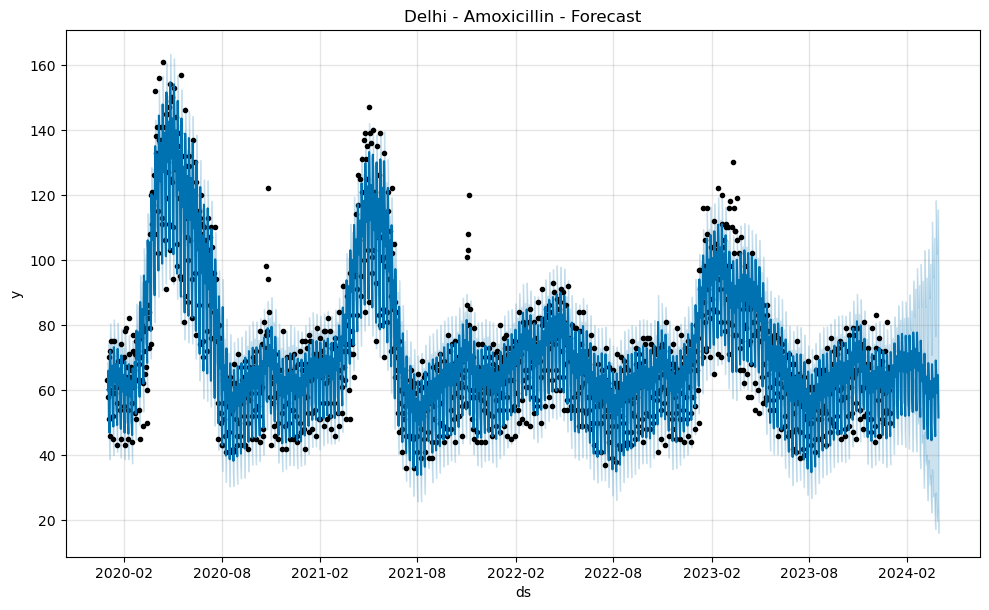

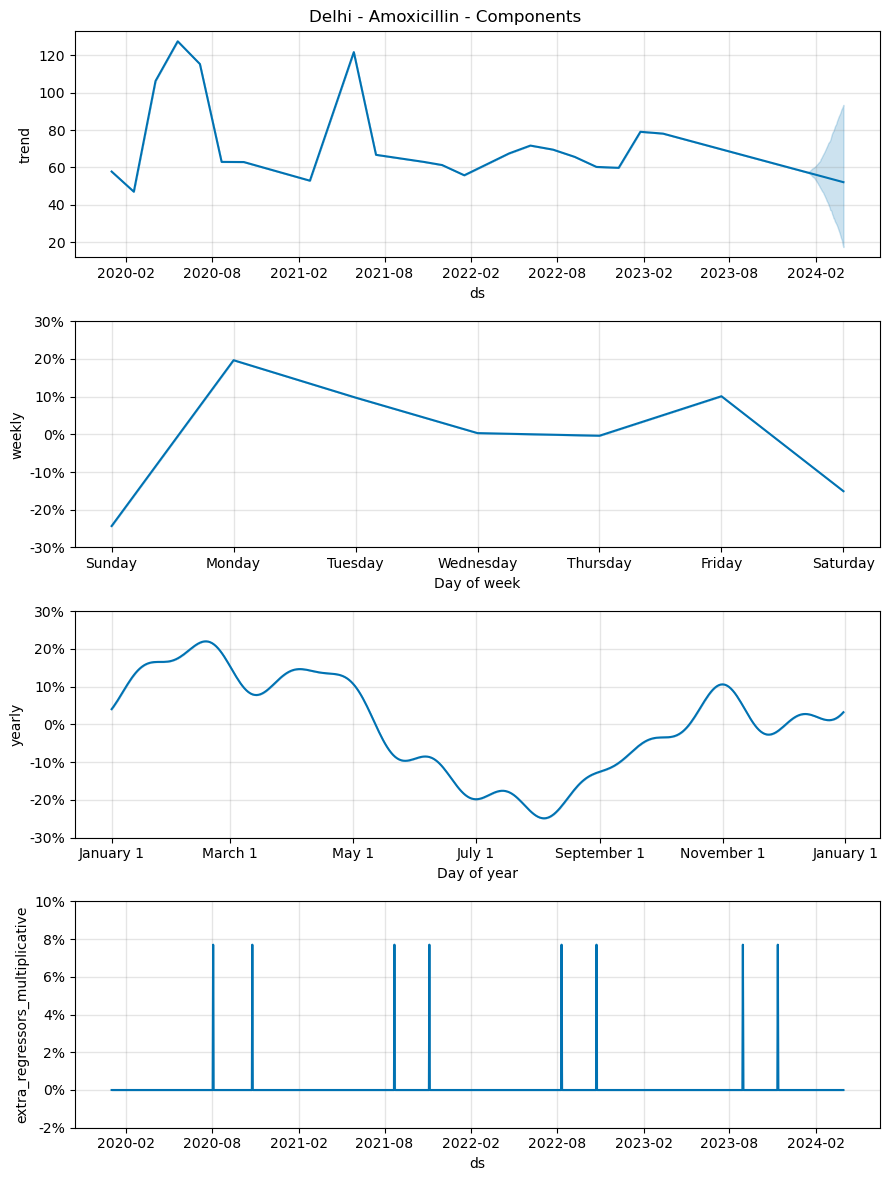

06:10:01 - cmdstanpy - INFO - Chain [1] start processing
06:10:01 - cmdstanpy - INFO - Chain [1] done processing



Training model for cetirizine in delhi

Tuning hyperparameters...


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:01 - cmdstanpy - INFO - Chain [1] start processing
06:10:01 - cmdstanpy - INFO - Chain [1] done processing
06:10:01 - cmdstanpy - INFO - Chain [1] start processing
06:10:01 - cmdstanpy - INFO - Chain [1] done processing
06:10:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:01 - cmdstanpy - INFO - Chain [1] start processing
06:10:02 - cmdstanpy - INFO - Chain [1] done processing
06:10:02 - cmdstanpy - INFO - Chain [1] start processing
06:10:02 - cmdstanpy - INFO - Chain [1] done processing
06:10:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:02 - cmdstanpy - INFO - Chain [1] start processing
06:10:02 - cmdstanpy - INFO - Chain [1] done processing
06:10:02 - cmdstanpy - INFO - Chain [1] start processing
06:10:02 - cmdstanpy - INFO - Chain [1] done processing
06:10:03 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.28
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:04 - cmdstanpy - INFO - Chain [1] start processing
06:10:04 - cmdstanpy - INFO - Chain [1] done processing
06:10:04 - cmdstanpy - INFO - Chain [1] start processing
06:10:04 - cmdstanpy - INFO - Chain [1] done processing
06:10:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:04 - cmdstanpy - INFO - Chain [1] start processing
06:10:05 - cmdstanpy - INFO - Chain [1] done processing
06:10:05 - cmdstanpy - INFO - Chain [1] start processing
06:10:05 - cmdstanpy - INFO - Chain [1] done processing
06:10:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:05 - cmdstanpy - INFO - Chain [1] start processing
06:10:06 - cmdstanpy - INFO - Chain [1] done processing
06:10:06 - cmdstanpy - INFO - Chain [1] start processing
06:10:06 - cmdstanpy - INFO - Chain [1] done processing
06:10:06 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 17.99
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:07 - cmdstanpy - INFO - Chain [1] start processing
06:10:08 - cmdstanpy - INFO - Chain [1] done processing
06:10:08 - cmdstanpy - INFO - Chain [1] start processing
06:10:08 - cmdstanpy - INFO - Chain [1] done processing
06:10:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:08 - cmdstanpy - INFO - Chain [1] start processing
06:10:08 - cmdstanpy - INFO - Chain [1] done processing
06:10:08 - cmdstanpy - INFO - Chain [1] start processing
06:10:08 - cmdstanpy - INFO - Chain [1] done processing
06:10:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:08 - cmdstanpy - INFO - Chain [1] start processing
06:10:09 - cmdstanpy - INFO - Chain [1] done processing
06:10:09 - cmdstanpy - INFO - Chain [1] start processing
06:10:09 - cmdstanpy - INFO - Chain [1] done processing
06:10:09 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.53
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:11 - cmdstanpy - INFO - Chain [1] start processing
06:10:11 - cmdstanpy - INFO - Chain [1] done processing
06:10:11 - cmdstanpy - INFO - Chain [1] start processing
06:10:11 - cmdstanpy - INFO - Chain [1] done processing
06:10:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:11 - cmdstanpy - INFO - Chain [1] start processing
06:10:11 - cmdstanpy - INFO - Chain [1] done processing
06:10:11 - cmdstanpy - INFO - Chain [1] start processing
06:10:11 - cmdstanpy - INFO - Chain [1] done processing
06:10:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:11 - cmdstanpy - INFO - Chain [1] start processing
06:10:12 - cmdstanpy - INFO - Chain [1] done processing
06:10:12 - cmdstanpy - INFO - Chain [1] start processing
06:10:12 - cmdstanpy - INFO - Chain [1] done processing
06:10:12 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.00
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:14 - cmdstanpy - INFO - Chain [1] start processing
06:10:14 - cmdstanpy - INFO - Chain [1] done processing
06:10:14 - cmdstanpy - INFO - Chain [1] start processing
06:10:14 - cmdstanpy - INFO - Chain [1] done processing
06:10:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:14 - cmdstanpy - INFO - Chain [1] start processing
06:10:14 - cmdstanpy - INFO - Chain [1] done processing
06:10:15 - cmdstanpy - INFO - Chain [1] start processing
06:10:15 - cmdstanpy - INFO - Chain [1] done processing
06:10:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:15 - cmdstanpy - INFO - Chain [1] start processing
06:10:15 - cmdstanpy - INFO - Chain [1] done processing
06:10:15 - cmdstanpy - INFO - Chain [1] start processing
06:10:15 - cmdstanpy - INFO - Chain [1] done processing
06:10:15 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.26
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:17 - cmdstanpy - INFO - Chain [1] start processing
06:10:17 - cmdstanpy - INFO - Chain [1] done processing
06:10:17 - cmdstanpy - INFO - Chain [1] start processing
06:10:17 - cmdstanpy - INFO - Chain [1] done processing
06:10:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:17 - cmdstanpy - INFO - Chain [1] start processing
06:10:18 - cmdstanpy - INFO - Chain [1] done processing
06:10:18 - cmdstanpy - INFO - Chain [1] start processing
06:10:18 - cmdstanpy - INFO - Chain [1] done processing
06:10:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:18 - cmdstanpy - INFO - Chain [1] start processing
06:10:19 - cmdstanpy - INFO - Chain [1] done processing
06:10:19 - cmdstanpy - INFO - Chain [1] start processing
06:10:19 - cmdstanpy - INFO - Chain [1] done processing
06:10:19 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.76
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:21 - cmdstanpy - INFO - Chain [1] start processing
06:10:21 - cmdstanpy - INFO - Chain [1] done processing
06:10:21 - cmdstanpy - INFO - Chain [1] start processing
06:10:21 - cmdstanpy - INFO - Chain [1] done processing
06:10:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:21 - cmdstanpy - INFO - Chain [1] start processing
06:10:21 - cmdstanpy - INFO - Chain [1] done processing
06:10:21 - cmdstanpy - INFO - Chain [1] start processing
06:10:21 - cmdstanpy - INFO - Chain [1] done processing
06:10:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:21 - cmdstanpy - INFO - Chain [1] start processing
06:10:22 - cmdstanpy - INFO - Chain [1] done processing
06:10:22 - cmdstanpy - INFO - Chain [1] start processing
06:10:22 - cmdstanpy - INFO - Chain [1] done processing
06:10:22 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.11
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:24 - cmdstanpy - INFO - Chain [1] start processing
06:10:24 - cmdstanpy - INFO - Chain [1] done processing
06:10:24 - cmdstanpy - INFO - Chain [1] start processing
06:10:24 - cmdstanpy - INFO - Chain [1] done processing
06:10:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:24 - cmdstanpy - INFO - Chain [1] start processing
06:10:25 - cmdstanpy - INFO - Chain [1] done processing
06:10:25 - cmdstanpy - INFO - Chain [1] start processing
06:10:25 - cmdstanpy - INFO - Chain [1] done processing
06:10:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:10:25 - cmdstanpy - INFO - Chain [1] start processing
06:10:26 - cmdstanpy - INFO - Chain [1] done processing
06:10:26 - cmdstanpy - INFO - Chain [1] start processing
06:10:26 - cmdstanpy - INFO - Chain [1] done processing
06:10:26 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.54
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:28 - cmdstanpy - INFO - Chain [1] start processing
06:10:28 - cmdstanpy - INFO - Chain [1] done processing
06:10:28 - cmdstanpy - INFO - Chain [1] start processing
06:10:28 - cmdstanpy - INFO - Chain [1] done processing
06:10:28 - cmdstanpy - INFO - Chain [1] start processing
06:10:28 - cmdstanpy - INFO - Chain [1] done processing
06:10:28 - cmdstanpy - INFO - Chain [1] start processing
06:10:28 - cmdstanpy - INFO - Chain [1] done processing
06:10:29 - cmdstanpy - INFO - Chain [1] start processing
06:10:29 - cmdstanpy - INFO - Chain [1] done processing
06:10:29 - cmdstanpy - INFO - Chain [1] start processing
06:10:29 - cmdstanpy - INFO - Chain [1] done processing
06:10:29 - cmdstanpy - INFO - Chain [1] start processing
06:10:29 - cmdstanpy - INFO - Chain [1] done processing
06:10:29 - cmdstanpy - INFO - Chain [1] start processing
06:10:29 - cmdstanpy - INFO - Chain [1] done processing
06:10:29 - cmdstanpy - INFO - Chain [1] start processing
06:10:29 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.37
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:30 - cmdstanpy - INFO - Chain [1] start processing
06:10:30 - cmdstanpy - INFO - Chain [1] done processing
06:10:31 - cmdstanpy - INFO - Chain [1] start processing
06:10:31 - cmdstanpy - INFO - Chain [1] done processing
06:10:31 - cmdstanpy - INFO - Chain [1] start processing
06:10:31 - cmdstanpy - INFO - Chain [1] done processing
06:10:31 - cmdstanpy - INFO - Chain [1] start processing
06:10:31 - cmdstanpy - INFO - Chain [1] done processing
06:10:31 - cmdstanpy - INFO - Chain [1] start processing
06:10:31 - cmdstanpy - INFO - Chain [1] done processing
06:10:31 - cmdstanpy - INFO - Chain [1] start processing
06:10:31 - cmdstanpy - INFO - Chain [1] done processing
06:10:31 - cmdstanpy - INFO - Chain [1] start processing
06:10:31 - cmdstanpy - INFO - Chain [1] done processing
06:10:32 - cmdstanpy - INFO - Chain [1] start processing
06:10:32 - cmdstanpy - INFO - Chain [1] done processing
06:10:32 - cmdstanpy - INFO - Chain [1] start processing
06:10:32 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.38
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:33 - cmdstanpy - INFO - Chain [1] start processing
06:10:33 - cmdstanpy - INFO - Chain [1] done processing
06:10:33 - cmdstanpy - INFO - Chain [1] start processing
06:10:33 - cmdstanpy - INFO - Chain [1] done processing
06:10:33 - cmdstanpy - INFO - Chain [1] start processing
06:10:33 - cmdstanpy - INFO - Chain [1] done processing
06:10:34 - cmdstanpy - INFO - Chain [1] start processing
06:10:34 - cmdstanpy - INFO - Chain [1] done processing
06:10:34 - cmdstanpy - INFO - Chain [1] start processing
06:10:34 - cmdstanpy - INFO - Chain [1] done processing
06:10:34 - cmdstanpy - INFO - Chain [1] start processing
06:10:34 - cmdstanpy - INFO - Chain [1] done processing
06:10:34 - cmdstanpy - INFO - Chain [1] start processing
06:10:34 - cmdstanpy - INFO - Chain [1] done processing
06:10:34 - cmdstanpy - INFO - Chain [1] start processing
06:10:34 - cmdstanpy - INFO - Chain [1] done processing
06:10:35 - cmdstanpy - INFO - Chain [1] start processing
06:10:35 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.95
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:36 - cmdstanpy - INFO - Chain [1] start processing
06:10:36 - cmdstanpy - INFO - Chain [1] done processing
06:10:36 - cmdstanpy - INFO - Chain [1] start processing
06:10:36 - cmdstanpy - INFO - Chain [1] done processing
06:10:36 - cmdstanpy - INFO - Chain [1] start processing
06:10:36 - cmdstanpy - INFO - Chain [1] done processing
06:10:36 - cmdstanpy - INFO - Chain [1] start processing
06:10:36 - cmdstanpy - INFO - Chain [1] done processing
06:10:36 - cmdstanpy - INFO - Chain [1] start processing
06:10:36 - cmdstanpy - INFO - Chain [1] done processing
06:10:36 - cmdstanpy - INFO - Chain [1] start processing
06:10:36 - cmdstanpy - INFO - Chain [1] done processing
06:10:37 - cmdstanpy - INFO - Chain [1] start processing
06:10:37 - cmdstanpy - INFO - Chain [1] done processing
06:10:37 - cmdstanpy - INFO - Chain [1] start processing
06:10:37 - cmdstanpy - INFO - Chain [1] done processing
06:10:37 - cmdstanpy - INFO - Chain [1] start processing
06:10:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.80
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:38 - cmdstanpy - INFO - Chain [1] start processing
06:10:38 - cmdstanpy - INFO - Chain [1] done processing
06:10:38 - cmdstanpy - INFO - Chain [1] start processing
06:10:38 - cmdstanpy - INFO - Chain [1] done processing
06:10:38 - cmdstanpy - INFO - Chain [1] start processing
06:10:38 - cmdstanpy - INFO - Chain [1] done processing
06:10:39 - cmdstanpy - INFO - Chain [1] start processing
06:10:39 - cmdstanpy - INFO - Chain [1] done processing
06:10:39 - cmdstanpy - INFO - Chain [1] start processing
06:10:39 - cmdstanpy - INFO - Chain [1] done processing
06:10:39 - cmdstanpy - INFO - Chain [1] start processing
06:10:39 - cmdstanpy - INFO - Chain [1] done processing
06:10:39 - cmdstanpy - INFO - Chain [1] start processing
06:10:39 - cmdstanpy - INFO - Chain [1] done processing
06:10:39 - cmdstanpy - INFO - Chain [1] start processing
06:10:39 - cmdstanpy - INFO - Chain [1] done processing
06:10:40 - cmdstanpy - INFO - Chain [1] start processing
06:10:40 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.94
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:41 - cmdstanpy - INFO - Chain [1] start processing
06:10:41 - cmdstanpy - INFO - Chain [1] done processing
06:10:41 - cmdstanpy - INFO - Chain [1] start processing
06:10:41 - cmdstanpy - INFO - Chain [1] done processing
06:10:41 - cmdstanpy - INFO - Chain [1] start processing
06:10:41 - cmdstanpy - INFO - Chain [1] done processing
06:10:41 - cmdstanpy - INFO - Chain [1] start processing
06:10:41 - cmdstanpy - INFO - Chain [1] done processing
06:10:41 - cmdstanpy - INFO - Chain [1] start processing
06:10:42 - cmdstanpy - INFO - Chain [1] done processing
06:10:42 - cmdstanpy - INFO - Chain [1] start processing
06:10:42 - cmdstanpy - INFO - Chain [1] done processing
06:10:42 - cmdstanpy - INFO - Chain [1] start processing
06:10:42 - cmdstanpy - INFO - Chain [1] done processing
06:10:42 - cmdstanpy - INFO - Chain [1] start processing
06:10:42 - cmdstanpy - INFO - Chain [1] done processing
06:10:42 - cmdstanpy - INFO - Chain [1] start processing
06:10:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.06
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:43 - cmdstanpy - INFO - Chain [1] start processing
06:10:43 - cmdstanpy - INFO - Chain [1] done processing
06:10:43 - cmdstanpy - INFO - Chain [1] start processing
06:10:43 - cmdstanpy - INFO - Chain [1] done processing
06:10:44 - cmdstanpy - INFO - Chain [1] start processing
06:10:44 - cmdstanpy - INFO - Chain [1] done processing
06:10:44 - cmdstanpy - INFO - Chain [1] start processing
06:10:44 - cmdstanpy - INFO - Chain [1] done processing
06:10:44 - cmdstanpy - INFO - Chain [1] start processing
06:10:44 - cmdstanpy - INFO - Chain [1] done processing
06:10:44 - cmdstanpy - INFO - Chain [1] start processing
06:10:44 - cmdstanpy - INFO - Chain [1] done processing
06:10:44 - cmdstanpy - INFO - Chain [1] start processing
06:10:44 - cmdstanpy - INFO - Chain [1] done processing
06:10:44 - cmdstanpy - INFO - Chain [1] start processing
06:10:44 - cmdstanpy - INFO - Chain [1] done processing
06:10:45 - cmdstanpy - INFO - Chain [1] start processing
06:10:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.95
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:46 - cmdstanpy - INFO - Chain [1] start processing
06:10:46 - cmdstanpy - INFO - Chain [1] done processing
06:10:46 - cmdstanpy - INFO - Chain [1] start processing
06:10:46 - cmdstanpy - INFO - Chain [1] done processing
06:10:46 - cmdstanpy - INFO - Chain [1] start processing
06:10:46 - cmdstanpy - INFO - Chain [1] done processing
06:10:46 - cmdstanpy - INFO - Chain [1] start processing
06:10:46 - cmdstanpy - INFO - Chain [1] done processing
06:10:46 - cmdstanpy - INFO - Chain [1] start processing
06:10:46 - cmdstanpy - INFO - Chain [1] done processing
06:10:46 - cmdstanpy - INFO - Chain [1] start processing
06:10:46 - cmdstanpy - INFO - Chain [1] done processing
06:10:47 - cmdstanpy - INFO - Chain [1] start processing
06:10:47 - cmdstanpy - INFO - Chain [1] done processing
06:10:47 - cmdstanpy - INFO - Chain [1] start processing
06:10:47 - cmdstanpy - INFO - Chain [1] done processing
06:10:47 - cmdstanpy - INFO - Chain [1] start processing
06:10:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.98
---


06:10:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:48 - cmdstanpy - INFO - Chain [1] start processing
06:10:48 - cmdstanpy - INFO - Chain [1] done processing
06:10:48 - cmdstanpy - INFO - Chain [1] start processing
06:10:48 - cmdstanpy - INFO - Chain [1] done processing
06:10:48 - cmdstanpy - INFO - Chain [1] start processing
06:10:48 - cmdstanpy - INFO - Chain [1] done processing
06:10:48 - cmdstanpy - INFO - Chain [1] start processing
06:10:48 - cmdstanpy - INFO - Chain [1] done processing
06:10:49 - cmdstanpy - INFO - Chain [1] start processing
06:10:49 - cmdstanpy - INFO - Chain [1] done processing
06:10:49 - cmdstanpy - INFO - Chain [1] start processing
06:10:49 - cmdstanpy - INFO - Chain [1] done processing
06:10:49 - cmdstanpy - INFO - Chain [1] start processing
06:10:49 - cmdstanpy - INFO - Chain [1] done processing
06:10:49 - cmdstanpy - INFO - Chain [1] start processing
06:10:49 - cmdstanpy - INFO - Chain [1] done processing
06:10:49 - cmdstanpy - INFO - Chain [1] start processing
06:10:50 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.69
---


06:10:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:51 - cmdstanpy - INFO - Chain [1] start processing
06:10:51 - cmdstanpy - INFO - Chain [1] done processing
06:10:51 - cmdstanpy - INFO - Chain [1] start processing
06:10:51 - cmdstanpy - INFO - Chain [1] done processing
06:10:51 - cmdstanpy - INFO - Chain [1] start processing
06:10:51 - cmdstanpy - INFO - Chain [1] done processing
06:10:51 - cmdstanpy - INFO - Chain [1] start processing
06:10:51 - cmdstanpy - INFO - Chain [1] done processing
06:10:52 - cmdstanpy - INFO - Chain [1] start processing
06:10:52 - cmdstanpy - INFO - Chain [1] done processing
06:10:52 - cmdstanpy - INFO - Chain [1] start processing
06:10:52 - cmdstanpy - INFO - Chain [1] done processing
06:10:52 - cmdstanpy - INFO - Chain [1] start processing
06:10:52 - cmdstanpy - INFO - Chain [1] done processing
06:10:52 - cmdstanpy - INFO - Chain [1] start processing
06:10:52 - cmdstanpy - INFO - Chain [1] done processing
06:10:52 - cmdstanpy - INFO - Chain [1] start processing
06:10:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.77
---


06:10:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:54 - cmdstanpy - INFO - Chain [1] start processing
06:10:54 - cmdstanpy - INFO - Chain [1] done processing
06:10:54 - cmdstanpy - INFO - Chain [1] start processing
06:10:54 - cmdstanpy - INFO - Chain [1] done processing
06:10:54 - cmdstanpy - INFO - Chain [1] start processing
06:10:54 - cmdstanpy - INFO - Chain [1] done processing
06:10:54 - cmdstanpy - INFO - Chain [1] start processing
06:10:54 - cmdstanpy - INFO - Chain [1] done processing
06:10:54 - cmdstanpy - INFO - Chain [1] start processing
06:10:54 - cmdstanpy - INFO - Chain [1] done processing
06:10:54 - cmdstanpy - INFO - Chain [1] start processing
06:10:54 - cmdstanpy - INFO - Chain [1] done processing
06:10:55 - cmdstanpy - INFO - Chain [1] start processing
06:10:55 - cmdstanpy - INFO - Chain [1] done processing
06:10:55 - cmdstanpy - INFO - Chain [1] start processing
06:10:55 - cmdstanpy - INFO - Chain [1] done processing
06:10:55 - cmdstanpy - INFO - Chain [1] start processing
06:10:55 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.21
---


06:10:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:56 - cmdstanpy - INFO - Chain [1] start processing
06:10:56 - cmdstanpy - INFO - Chain [1] done processing
06:10:56 - cmdstanpy - INFO - Chain [1] start processing
06:10:56 - cmdstanpy - INFO - Chain [1] done processing
06:10:57 - cmdstanpy - INFO - Chain [1] start processing
06:10:57 - cmdstanpy - INFO - Chain [1] done processing
06:10:57 - cmdstanpy - INFO - Chain [1] start processing
06:10:57 - cmdstanpy - INFO - Chain [1] done processing
06:10:57 - cmdstanpy - INFO - Chain [1] start processing
06:10:57 - cmdstanpy - INFO - Chain [1] done processing
06:10:57 - cmdstanpy - INFO - Chain [1] start processing
06:10:57 - cmdstanpy - INFO - Chain [1] done processing
06:10:57 - cmdstanpy - INFO - Chain [1] start processing
06:10:57 - cmdstanpy - INFO - Chain [1] done processing
06:10:57 - cmdstanpy - INFO - Chain [1] start processing
06:10:58 - cmdstanpy - INFO - Chain [1] done processing
06:10:58 - cmdstanpy - INFO - Chain [1] start processing
06:10:58 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.03
---


06:10:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:10:59 - cmdstanpy - INFO - Chain [1] start processing
06:10:59 - cmdstanpy - INFO - Chain [1] done processing
06:10:59 - cmdstanpy - INFO - Chain [1] start processing
06:10:59 - cmdstanpy - INFO - Chain [1] done processing
06:10:59 - cmdstanpy - INFO - Chain [1] start processing
06:10:59 - cmdstanpy - INFO - Chain [1] done processing
06:10:59 - cmdstanpy - INFO - Chain [1] start processing
06:10:59 - cmdstanpy - INFO - Chain [1] done processing
06:10:59 - cmdstanpy - INFO - Chain [1] start processing
06:11:00 - cmdstanpy - INFO - Chain [1] done processing
06:11:00 - cmdstanpy - INFO - Chain [1] start processing
06:11:00 - cmdstanpy - INFO - Chain [1] done processing
06:11:00 - cmdstanpy - INFO - Chain [1] start processing
06:11:00 - cmdstanpy - INFO - Chain [1] done processing
06:11:00 - cmdstanpy - INFO - Chain [1] start processing
06:11:00 - cmdstanpy - INFO - Chain [1] done processing
06:11:00 - cmdstanpy - INFO - Chain [1] start processing
06:11:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.66
---


06:11:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:02 - cmdstanpy - INFO - Chain [1] start processing
06:11:02 - cmdstanpy - INFO - Chain [1] done processing
06:11:02 - cmdstanpy - INFO - Chain [1] start processing
06:11:02 - cmdstanpy - INFO - Chain [1] done processing
06:11:02 - cmdstanpy - INFO - Chain [1] start processing
06:11:02 - cmdstanpy - INFO - Chain [1] done processing
06:11:02 - cmdstanpy - INFO - Chain [1] start processing
06:11:02 - cmdstanpy - INFO - Chain [1] done processing
06:11:02 - cmdstanpy - INFO - Chain [1] start processing
06:11:02 - cmdstanpy - INFO - Chain [1] done processing
06:11:02 - cmdstanpy - INFO - Chain [1] start processing
06:11:02 - cmdstanpy - INFO - Chain [1] done processing
06:11:02 - cmdstanpy - INFO - Chain [1] start processing
06:11:03 - cmdstanpy - INFO - Chain [1] done processing
06:11:03 - cmdstanpy - INFO - Chain [1] start processing
06:11:03 - cmdstanpy - INFO - Chain [1] done processing
06:11:03 - cmdstanpy - INFO - Chain [1] start processing
06:11:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.52
---


06:11:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:04 - cmdstanpy - INFO - Chain [1] start processing
06:11:04 - cmdstanpy - INFO - Chain [1] done processing
06:11:04 - cmdstanpy - INFO - Chain [1] start processing
06:11:04 - cmdstanpy - INFO - Chain [1] done processing
06:11:04 - cmdstanpy - INFO - Chain [1] start processing
06:11:05 - cmdstanpy - INFO - Chain [1] done processing
06:11:05 - cmdstanpy - INFO - Chain [1] start processing
06:11:05 - cmdstanpy - INFO - Chain [1] done processing
06:11:05 - cmdstanpy - INFO - Chain [1] start processing
06:11:05 - cmdstanpy - INFO - Chain [1] done processing
06:11:05 - cmdstanpy - INFO - Chain [1] start processing
06:11:05 - cmdstanpy - INFO - Chain [1] done processing
06:11:05 - cmdstanpy - INFO - Chain [1] start processing
06:11:05 - cmdstanpy - INFO - Chain [1] done processing
06:11:05 - cmdstanpy - INFO - Chain [1] start processing
06:11:05 - cmdstanpy - INFO - Chain [1] done processing
06:11:06 - cmdstanpy - INFO - Chain [1] start processing
06:11:06 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.48
---


06:11:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:07 - cmdstanpy - INFO - Chain [1] start processing
06:11:07 - cmdstanpy - INFO - Chain [1] done processing
06:11:07 - cmdstanpy - INFO - Chain [1] start processing
06:11:07 - cmdstanpy - INFO - Chain [1] done processing
06:11:07 - cmdstanpy - INFO - Chain [1] start processing
06:11:07 - cmdstanpy - INFO - Chain [1] done processing
06:11:07 - cmdstanpy - INFO - Chain [1] start processing
06:11:07 - cmdstanpy - INFO - Chain [1] done processing
06:11:07 - cmdstanpy - INFO - Chain [1] start processing
06:11:07 - cmdstanpy - INFO - Chain [1] done processing
06:11:08 - cmdstanpy - INFO - Chain [1] start processing
06:11:08 - cmdstanpy - INFO - Chain [1] done processing
06:11:08 - cmdstanpy - INFO - Chain [1] start processing
06:11:08 - cmdstanpy - INFO - Chain [1] done processing
06:11:08 - cmdstanpy - INFO - Chain [1] start processing
06:11:08 - cmdstanpy - INFO - Chain [1] done processing
06:11:08 - cmdstanpy - INFO - Chain [1] start processing
06:11:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.26
---


06:11:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:10 - cmdstanpy - INFO - Chain [1] start processing
06:11:10 - cmdstanpy - INFO - Chain [1] done processing
06:11:10 - cmdstanpy - INFO - Chain [1] start processing
06:11:10 - cmdstanpy - INFO - Chain [1] done processing
06:11:10 - cmdstanpy - INFO - Chain [1] start processing
06:11:10 - cmdstanpy - INFO - Chain [1] done processing
06:11:10 - cmdstanpy - INFO - Chain [1] start processing
06:11:10 - cmdstanpy - INFO - Chain [1] done processing
06:11:10 - cmdstanpy - INFO - Chain [1] start processing
06:11:10 - cmdstanpy - INFO - Chain [1] done processing
06:11:11 - cmdstanpy - INFO - Chain [1] start processing
06:11:11 - cmdstanpy - INFO - Chain [1] done processing
06:11:11 - cmdstanpy - INFO - Chain [1] start processing
06:11:11 - cmdstanpy - INFO - Chain [1] done processing
06:11:11 - cmdstanpy - INFO - Chain [1] start processing
06:11:11 - cmdstanpy - INFO - Chain [1] done processing
06:11:11 - cmdstanpy - INFO - Chain [1] start processing
06:11:11 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.10
---


06:11:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:13 - cmdstanpy - INFO - Chain [1] start processing
06:11:13 - cmdstanpy - INFO - Chain [1] done processing
06:11:13 - cmdstanpy - INFO - Chain [1] start processing
06:11:13 - cmdstanpy - INFO - Chain [1] done processing
06:11:13 - cmdstanpy - INFO - Chain [1] start processing
06:11:13 - cmdstanpy - INFO - Chain [1] done processing
06:11:13 - cmdstanpy - INFO - Chain [1] start processing
06:11:14 - cmdstanpy - INFO - Chain [1] done processing
06:11:14 - cmdstanpy - INFO - Chain [1] start processing
06:11:14 - cmdstanpy - INFO - Chain [1] done processing
06:11:14 - cmdstanpy - INFO - Chain [1] start processing
06:11:14 - cmdstanpy - INFO - Chain [1] done processing
06:11:14 - cmdstanpy - INFO - Chain [1] start processing
06:11:14 - cmdstanpy - INFO - Chain [1] done processing
06:11:14 - cmdstanpy - INFO - Chain [1] start processing
06:11:14 - cmdstanpy - INFO - Chain [1] done processing
06:11:15 - cmdstanpy - INFO - Chain [1] start processing
06:11:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.10
---


06:11:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:16 - cmdstanpy - INFO - Chain [1] start processing
06:11:16 - cmdstanpy - INFO - Chain [1] done processing
06:11:17 - cmdstanpy - INFO - Chain [1] start processing
06:11:17 - cmdstanpy - INFO - Chain [1] done processing
06:11:17 - cmdstanpy - INFO - Chain [1] start processing
06:11:17 - cmdstanpy - INFO - Chain [1] done processing
06:11:17 - cmdstanpy - INFO - Chain [1] start processing
06:11:17 - cmdstanpy - INFO - Chain [1] done processing
06:11:17 - cmdstanpy - INFO - Chain [1] start processing
06:11:17 - cmdstanpy - INFO - Chain [1] done processing
06:11:17 - cmdstanpy - INFO - Chain [1] start processing
06:11:17 - cmdstanpy - INFO - Chain [1] done processing
06:11:17 - cmdstanpy - INFO - Chain [1] start processing
06:11:18 - cmdstanpy - INFO - Chain [1] done processing
06:11:18 - cmdstanpy - INFO - Chain [1] start processing
06:11:18 - cmdstanpy - INFO - Chain [1] done processing
06:11:18 - cmdstanpy - INFO - Chain [1] start processing
06:11:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.64
---


06:11:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:19 - cmdstanpy - INFO - Chain [1] start processing
06:11:20 - cmdstanpy - INFO - Chain [1] done processing
06:11:20 - cmdstanpy - INFO - Chain [1] start processing
06:11:20 - cmdstanpy - INFO - Chain [1] done processing
06:11:20 - cmdstanpy - INFO - Chain [1] start processing
06:11:20 - cmdstanpy - INFO - Chain [1] done processing
06:11:20 - cmdstanpy - INFO - Chain [1] start processing
06:11:20 - cmdstanpy - INFO - Chain [1] done processing
06:11:20 - cmdstanpy - INFO - Chain [1] start processing
06:11:20 - cmdstanpy - INFO - Chain [1] done processing
06:11:20 - cmdstanpy - INFO - Chain [1] start processing
06:11:20 - cmdstanpy - INFO - Chain [1] done processing
06:11:21 - cmdstanpy - INFO - Chain [1] start processing
06:11:21 - cmdstanpy - INFO - Chain [1] done processing
06:11:21 - cmdstanpy - INFO - Chain [1] start processing
06:11:21 - cmdstanpy - INFO - Chain [1] done processing
06:11:21 - cmdstanpy - INFO - Chain [1] start processing
06:11:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.10
---


06:11:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:23 - cmdstanpy - INFO - Chain [1] start processing
06:11:23 - cmdstanpy - INFO - Chain [1] done processing
06:11:23 - cmdstanpy - INFO - Chain [1] start processing
06:11:23 - cmdstanpy - INFO - Chain [1] done processing
06:11:23 - cmdstanpy - INFO - Chain [1] start processing
06:11:23 - cmdstanpy - INFO - Chain [1] done processing
06:11:23 - cmdstanpy - INFO - Chain [1] start processing
06:11:23 - cmdstanpy - INFO - Chain [1] done processing
06:11:23 - cmdstanpy - INFO - Chain [1] start processing
06:11:24 - cmdstanpy - INFO - Chain [1] done processing
06:11:24 - cmdstanpy - INFO - Chain [1] start processing
06:11:24 - cmdstanpy - INFO - Chain [1] done processing
06:11:24 - cmdstanpy - INFO - Chain [1] start processing
06:11:24 - cmdstanpy - INFO - Chain [1] done processing
06:11:24 - cmdstanpy - INFO - Chain [1] start processing
06:11:24 - cmdstanpy - INFO - Chain [1] done processing
06:11:24 - cmdstanpy - INFO - Chain [1] start processing
06:11:25 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.95
---


06:11:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:26 - cmdstanpy - INFO - Chain [1] start processing
06:11:26 - cmdstanpy - INFO - Chain [1] done processing
06:11:26 - cmdstanpy - INFO - Chain [1] start processing
06:11:26 - cmdstanpy - INFO - Chain [1] done processing
06:11:26 - cmdstanpy - INFO - Chain [1] start processing
06:11:26 - cmdstanpy - INFO - Chain [1] done processing
06:11:26 - cmdstanpy - INFO - Chain [1] start processing
06:11:27 - cmdstanpy - INFO - Chain [1] done processing
06:11:27 - cmdstanpy - INFO - Chain [1] start processing
06:11:27 - cmdstanpy - INFO - Chain [1] done processing
06:11:27 - cmdstanpy - INFO - Chain [1] start processing
06:11:27 - cmdstanpy - INFO - Chain [1] done processing
06:11:27 - cmdstanpy - INFO - Chain [1] start processing
06:11:27 - cmdstanpy - INFO - Chain [1] done processing
06:11:27 - cmdstanpy - INFO - Chain [1] start processing
06:11:27 - cmdstanpy - INFO - Chain [1] done processing
06:11:27 - cmdstanpy - INFO - Chain [1] start processing
06:11:28 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.72
---


06:11:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:29 - cmdstanpy - INFO - Chain [1] start processing
06:11:29 - cmdstanpy - INFO - Chain [1] done processing
06:11:29 - cmdstanpy - INFO - Chain [1] start processing
06:11:29 - cmdstanpy - INFO - Chain [1] done processing
06:11:29 - cmdstanpy - INFO - Chain [1] start processing
06:11:30 - cmdstanpy - INFO - Chain [1] done processing
06:11:30 - cmdstanpy - INFO - Chain [1] start processing
06:11:30 - cmdstanpy - INFO - Chain [1] done processing
06:11:30 - cmdstanpy - INFO - Chain [1] start processing
06:11:30 - cmdstanpy - INFO - Chain [1] done processing
06:11:30 - cmdstanpy - INFO - Chain [1] start processing
06:11:30 - cmdstanpy - INFO - Chain [1] done processing
06:11:30 - cmdstanpy - INFO - Chain [1] start processing
06:11:30 - cmdstanpy - INFO - Chain [1] done processing
06:11:31 - cmdstanpy - INFO - Chain [1] start processing
06:11:31 - cmdstanpy - INFO - Chain [1] done processing
06:11:31 - cmdstanpy - INFO - Chain [1] start processing
06:11:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.48
---


06:11:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:33 - cmdstanpy - INFO - Chain [1] start processing
06:11:33 - cmdstanpy - INFO - Chain [1] done processing
06:11:33 - cmdstanpy - INFO - Chain [1] start processing
06:11:33 - cmdstanpy - INFO - Chain [1] done processing
06:11:33 - cmdstanpy - INFO - Chain [1] start processing
06:11:33 - cmdstanpy - INFO - Chain [1] done processing
06:11:33 - cmdstanpy - INFO - Chain [1] start processing
06:11:33 - cmdstanpy - INFO - Chain [1] done processing
06:11:33 - cmdstanpy - INFO - Chain [1] start processing
06:11:33 - cmdstanpy - INFO - Chain [1] done processing
06:11:33 - cmdstanpy - INFO - Chain [1] start processing
06:11:33 - cmdstanpy - INFO - Chain [1] done processing
06:11:34 - cmdstanpy - INFO - Chain [1] start processing
06:11:34 - cmdstanpy - INFO - Chain [1] done processing
06:11:34 - cmdstanpy - INFO - Chain [1] start processing
06:11:34 - cmdstanpy - INFO - Chain [1] done processing
06:11:34 - cmdstanpy - INFO - Chain [1] start processing
06:11:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.70
---


06:11:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:36 - cmdstanpy - INFO - Chain [1] start processing
06:11:36 - cmdstanpy - INFO - Chain [1] done processing
06:11:36 - cmdstanpy - INFO - Chain [1] start processing
06:11:36 - cmdstanpy - INFO - Chain [1] done processing
06:11:37 - cmdstanpy - INFO - Chain [1] start processing
06:11:37 - cmdstanpy - INFO - Chain [1] done processing
06:11:37 - cmdstanpy - INFO - Chain [1] start processing
06:11:37 - cmdstanpy - INFO - Chain [1] done processing
06:11:37 - cmdstanpy - INFO - Chain [1] start processing
06:11:38 - cmdstanpy - INFO - Chain [1] done processing
06:11:38 - cmdstanpy - INFO - Chain [1] start processing
06:11:38 - cmdstanpy - INFO - Chain [1] done processing
06:11:38 - cmdstanpy - INFO - Chain [1] start processing
06:11:38 - cmdstanpy - INFO - Chain [1] done processing
06:11:39 - cmdstanpy - INFO - Chain [1] start processing
06:11:39 - cmdstanpy - INFO - Chain [1] done processing
06:11:39 - cmdstanpy - INFO - Chain [1] start processing
06:11:39 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.52
---


06:11:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:42 - cmdstanpy - INFO - Chain [1] start processing
06:11:42 - cmdstanpy - INFO - Chain [1] done processing
06:11:42 - cmdstanpy - INFO - Chain [1] start processing
06:11:42 - cmdstanpy - INFO - Chain [1] done processing
06:11:42 - cmdstanpy - INFO - Chain [1] start processing
06:11:42 - cmdstanpy - INFO - Chain [1] done processing
06:11:43 - cmdstanpy - INFO - Chain [1] start processing
06:11:43 - cmdstanpy - INFO - Chain [1] done processing
06:11:43 - cmdstanpy - INFO - Chain [1] start processing
06:11:43 - cmdstanpy - INFO - Chain [1] done processing
06:11:43 - cmdstanpy - INFO - Chain [1] start processing
06:11:43 - cmdstanpy - INFO - Chain [1] done processing
06:11:44 - cmdstanpy - INFO - Chain [1] start processing
06:11:44 - cmdstanpy - INFO - Chain [1] done processing
06:11:44 - cmdstanpy - INFO - Chain [1] start processing
06:11:44 - cmdstanpy - INFO - Chain [1] done processing
06:11:45 - cmdstanpy - INFO - Chain [1] start processing
06:11:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.63
---


06:11:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:47 - cmdstanpy - INFO - Chain [1] start processing
06:11:47 - cmdstanpy - INFO - Chain [1] done processing
06:11:47 - cmdstanpy - INFO - Chain [1] start processing
06:11:48 - cmdstanpy - INFO - Chain [1] done processing
06:11:48 - cmdstanpy - INFO - Chain [1] start processing
06:11:48 - cmdstanpy - INFO - Chain [1] done processing
06:11:48 - cmdstanpy - INFO - Chain [1] start processing
06:11:48 - cmdstanpy - INFO - Chain [1] done processing
06:11:48 - cmdstanpy - INFO - Chain [1] start processing
06:11:49 - cmdstanpy - INFO - Chain [1] done processing
06:11:49 - cmdstanpy - INFO - Chain [1] start processing
06:11:49 - cmdstanpy - INFO - Chain [1] done processing
06:11:49 - cmdstanpy - INFO - Chain [1] start processing
06:11:49 - cmdstanpy - INFO - Chain [1] done processing
06:11:49 - cmdstanpy - INFO - Chain [1] start processing
06:11:50 - cmdstanpy - INFO - Chain [1] done processing
06:11:50 - cmdstanpy - INFO - Chain [1] start processing
06:11:50 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.00
---


06:11:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:53 - cmdstanpy - INFO - Chain [1] start processing
06:11:53 - cmdstanpy - INFO - Chain [1] done processing
06:11:53 - cmdstanpy - INFO - Chain [1] start processing
06:11:53 - cmdstanpy - INFO - Chain [1] done processing
06:11:53 - cmdstanpy - INFO - Chain [1] start processing
06:11:53 - cmdstanpy - INFO - Chain [1] done processing
06:11:53 - cmdstanpy - INFO - Chain [1] start processing
06:11:54 - cmdstanpy - INFO - Chain [1] done processing
06:11:54 - cmdstanpy - INFO - Chain [1] start processing
06:11:54 - cmdstanpy - INFO - Chain [1] done processing
06:11:54 - cmdstanpy - INFO - Chain [1] start processing
06:11:54 - cmdstanpy - INFO - Chain [1] done processing
06:11:54 - cmdstanpy - INFO - Chain [1] start processing
06:11:55 - cmdstanpy - INFO - Chain [1] done processing
06:11:55 - cmdstanpy - INFO - Chain [1] start processing
06:11:55 - cmdstanpy - INFO - Chain [1] done processing
06:11:55 - cmdstanpy - INFO - Chain [1] start processing
06:11:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.90
---


06:11:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:11:58 - cmdstanpy - INFO - Chain [1] start processing
06:11:58 - cmdstanpy - INFO - Chain [1] done processing
06:11:58 - cmdstanpy - INFO - Chain [1] start processing
06:11:58 - cmdstanpy - INFO - Chain [1] done processing
06:11:58 - cmdstanpy - INFO - Chain [1] start processing
06:11:59 - cmdstanpy - INFO - Chain [1] done processing
06:11:59 - cmdstanpy - INFO - Chain [1] start processing
06:11:59 - cmdstanpy - INFO - Chain [1] done processing
06:11:59 - cmdstanpy - INFO - Chain [1] start processing
06:11:59 - cmdstanpy - INFO - Chain [1] done processing
06:11:59 - cmdstanpy - INFO - Chain [1] start processing
06:12:00 - cmdstanpy - INFO - Chain [1] done processing
06:12:00 - cmdstanpy - INFO - Chain [1] start processing
06:12:00 - cmdstanpy - INFO - Chain [1] done processing
06:12:00 - cmdstanpy - INFO - Chain [1] start processing
06:12:01 - cmdstanpy - INFO - Chain [1] done processing
06:12:01 - cmdstanpy - INFO - Chain [1] start processing
06:12:01 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.81
---


06:12:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:04 - cmdstanpy - INFO - Chain [1] start processing
06:12:04 - cmdstanpy - INFO - Chain [1] done processing
06:12:04 - cmdstanpy - INFO - Chain [1] start processing
06:12:04 - cmdstanpy - INFO - Chain [1] done processing
06:12:04 - cmdstanpy - INFO - Chain [1] start processing
06:12:04 - cmdstanpy - INFO - Chain [1] done processing
06:12:04 - cmdstanpy - INFO - Chain [1] start processing
06:12:04 - cmdstanpy - INFO - Chain [1] done processing
06:12:05 - cmdstanpy - INFO - Chain [1] start processing
06:12:05 - cmdstanpy - INFO - Chain [1] done processing
06:12:05 - cmdstanpy - INFO - Chain [1] start processing
06:12:05 - cmdstanpy - INFO - Chain [1] done processing
06:12:05 - cmdstanpy - INFO - Chain [1] start processing
06:12:05 - cmdstanpy - INFO - Chain [1] done processing
06:12:05 - cmdstanpy - INFO - Chain [1] start processing
06:12:06 - cmdstanpy - INFO - Chain [1] done processing
06:12:06 - cmdstanpy - INFO - Chain [1] start processing
06:12:06 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.64
---


06:12:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:09 - cmdstanpy - INFO - Chain [1] start processing
06:12:09 - cmdstanpy - INFO - Chain [1] done processing
06:12:09 - cmdstanpy - INFO - Chain [1] start processing
06:12:09 - cmdstanpy - INFO - Chain [1] done processing
06:12:09 - cmdstanpy - INFO - Chain [1] start processing
06:12:09 - cmdstanpy - INFO - Chain [1] done processing
06:12:09 - cmdstanpy - INFO - Chain [1] start processing
06:12:10 - cmdstanpy - INFO - Chain [1] done processing
06:12:10 - cmdstanpy - INFO - Chain [1] start processing
06:12:10 - cmdstanpy - INFO - Chain [1] done processing
06:12:10 - cmdstanpy - INFO - Chain [1] start processing
06:12:10 - cmdstanpy - INFO - Chain [1] done processing
06:12:11 - cmdstanpy - INFO - Chain [1] start processing
06:12:11 - cmdstanpy - INFO - Chain [1] done processing
06:12:11 - cmdstanpy - INFO - Chain [1] start processing
06:12:11 - cmdstanpy - INFO - Chain [1] done processing
06:12:12 - cmdstanpy - INFO - Chain [1] start processing
06:12:12 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.63
---


06:12:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:14 - cmdstanpy - INFO - Chain [1] start processing
06:12:14 - cmdstanpy - INFO - Chain [1] done processing
06:12:14 - cmdstanpy - INFO - Chain [1] start processing
06:12:15 - cmdstanpy - INFO - Chain [1] done processing
06:12:15 - cmdstanpy - INFO - Chain [1] start processing
06:12:15 - cmdstanpy - INFO - Chain [1] done processing
06:12:15 - cmdstanpy - INFO - Chain [1] start processing
06:12:15 - cmdstanpy - INFO - Chain [1] done processing
06:12:15 - cmdstanpy - INFO - Chain [1] start processing
06:12:15 - cmdstanpy - INFO - Chain [1] done processing
06:12:15 - cmdstanpy - INFO - Chain [1] start processing
06:12:16 - cmdstanpy - INFO - Chain [1] done processing
06:12:16 - cmdstanpy - INFO - Chain [1] start processing
06:12:16 - cmdstanpy - INFO - Chain [1] done processing
06:12:16 - cmdstanpy - INFO - Chain [1] start processing
06:12:16 - cmdstanpy - INFO - Chain [1] done processing
06:12:17 - cmdstanpy - INFO - Chain [1] start processing
06:12:17 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.17
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 17.99

Training final model...


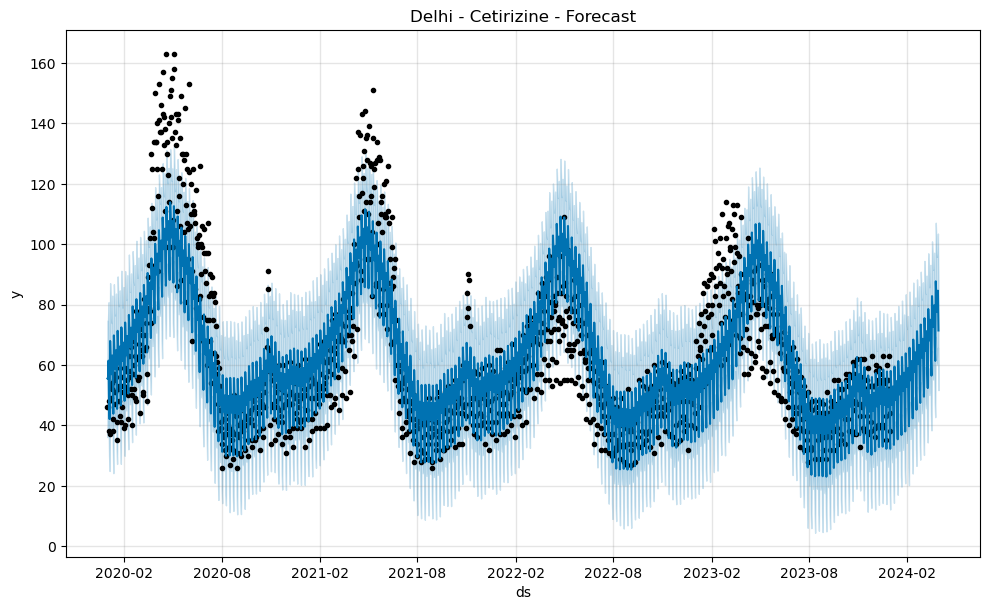

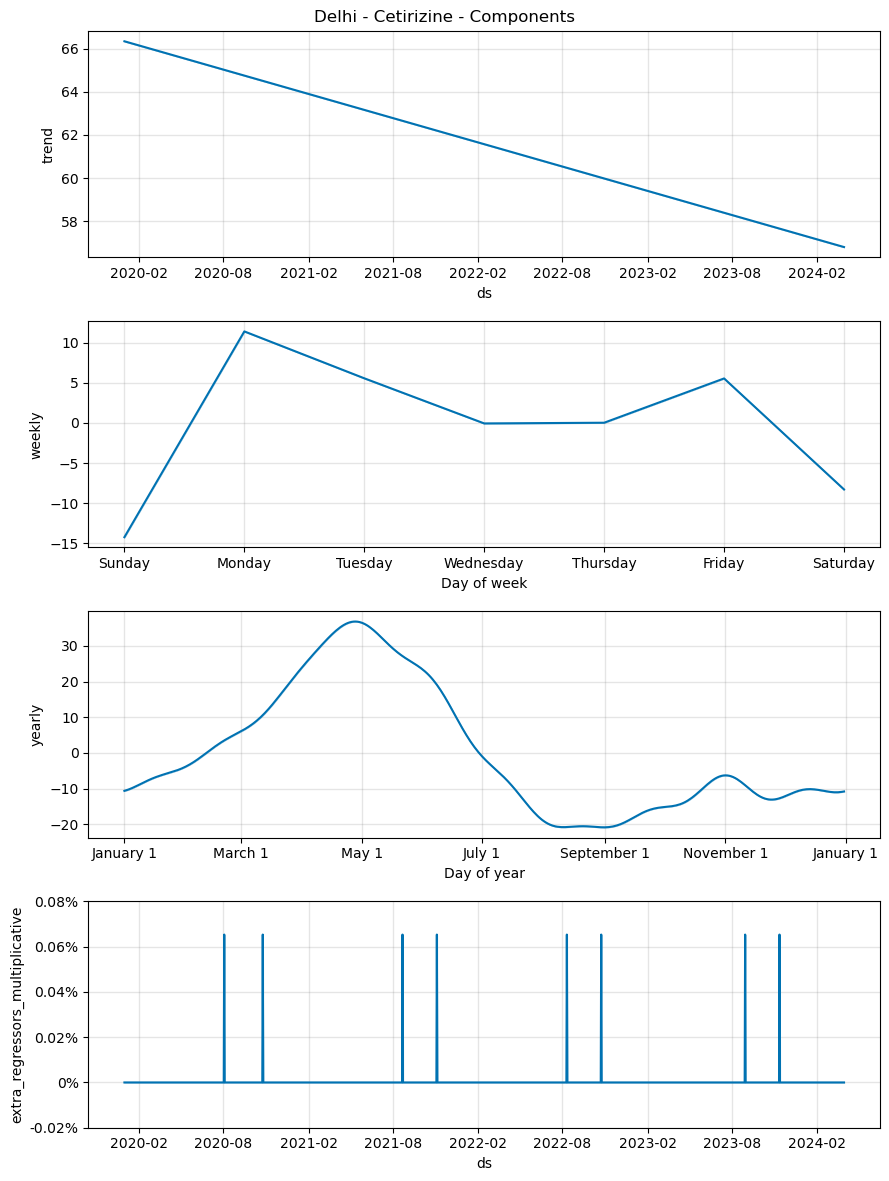

06:12:20 - cmdstanpy - INFO - Chain [1] start processing
06:12:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for salbutamol in delhi

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:20 - cmdstanpy - INFO - Chain [1] start processing
06:12:20 - cmdstanpy - INFO - Chain [1] done processing
06:12:20 - cmdstanpy - INFO - Chain [1] start processing
06:12:20 - cmdstanpy - INFO - Chain [1] done processing
06:12:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:20 - cmdstanpy - INFO - Chain [1] start processing
06:12:20 - cmdstanpy - INFO - Chain [1] done processing
06:12:20 - cmdstanpy - INFO - Chain [1] start processing
06:12:20 - cmdstanpy - INFO - Chain [1] done processing
06:12:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:21 - cmdstanpy - INFO - Chain [1] start processing
06:12:21 - cmdstanpy - INFO - Chain [1] done processing
06:12:21 - cmdstanpy - INFO - Chain [1] start processing
06:12:21 - cmdstanpy - INFO - Chain [1] done processing
06:12:22 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.57
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:23 - cmdstanpy - INFO - Chain [1] start processing
06:12:23 - cmdstanpy - INFO - Chain [1] done processing
06:12:23 - cmdstanpy - INFO - Chain [1] start processing
06:12:23 - cmdstanpy - INFO - Chain [1] done processing
06:12:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:23 - cmdstanpy - INFO - Chain [1] start processing
06:12:24 - cmdstanpy - INFO - Chain [1] done processing
06:12:24 - cmdstanpy - INFO - Chain [1] start processing
06:12:24 - cmdstanpy - INFO - Chain [1] done processing
06:12:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:24 - cmdstanpy - INFO - Chain [1] start processing
06:12:24 - cmdstanpy - INFO - Chain [1] done processing
06:12:24 - cmdstanpy - INFO - Chain [1] start processing
06:12:25 - cmdstanpy - INFO - Chain [1] done processing
06:12:25 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.18
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:26 - cmdstanpy - INFO - Chain [1] start processing
06:12:26 - cmdstanpy - INFO - Chain [1] done processing
06:12:26 - cmdstanpy - INFO - Chain [1] start processing
06:12:26 - cmdstanpy - INFO - Chain [1] done processing
06:12:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:26 - cmdstanpy - INFO - Chain [1] start processing
06:12:27 - cmdstanpy - INFO - Chain [1] done processing
06:12:27 - cmdstanpy - INFO - Chain [1] start processing
06:12:27 - cmdstanpy - INFO - Chain [1] done processing
06:12:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:27 - cmdstanpy - INFO - Chain [1] start processing
06:12:27 - cmdstanpy - INFO - Chain [1] done processing
06:12:28 - cmdstanpy - INFO - Chain [1] start processing
06:12:28 - cmdstanpy - INFO - Chain [1] done processing
06:12:28 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.37
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:29 - cmdstanpy - INFO - Chain [1] start processing
06:12:29 - cmdstanpy - INFO - Chain [1] done processing
06:12:29 - cmdstanpy - INFO - Chain [1] start processing
06:12:29 - cmdstanpy - INFO - Chain [1] done processing
06:12:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:29 - cmdstanpy - INFO - Chain [1] start processing
06:12:30 - cmdstanpy - INFO - Chain [1] done processing
06:12:30 - cmdstanpy - INFO - Chain [1] start processing
06:12:30 - cmdstanpy - INFO - Chain [1] done processing
06:12:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:30 - cmdstanpy - INFO - Chain [1] start processing
06:12:31 - cmdstanpy - INFO - Chain [1] done processing
06:12:31 - cmdstanpy - INFO - Chain [1] start processing
06:12:31 - cmdstanpy - INFO - Chain [1] done processing
06:12:31 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 11.29
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:33 - cmdstanpy - INFO - Chain [1] start processing
06:12:33 - cmdstanpy - INFO - Chain [1] done processing
06:12:33 - cmdstanpy - INFO - Chain [1] start processing
06:12:33 - cmdstanpy - INFO - Chain [1] done processing
06:12:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:33 - cmdstanpy - INFO - Chain [1] start processing
06:12:33 - cmdstanpy - INFO - Chain [1] done processing
06:12:33 - cmdstanpy - INFO - Chain [1] start processing
06:12:33 - cmdstanpy - INFO - Chain [1] done processing
06:12:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:33 - cmdstanpy - INFO - Chain [1] start processing
06:12:34 - cmdstanpy - INFO - Chain [1] done processing
06:12:34 - cmdstanpy - INFO - Chain [1] start processing
06:12:34 - cmdstanpy - INFO - Chain [1] done processing
06:12:34 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.41
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:36 - cmdstanpy - INFO - Chain [1] start processing
06:12:36 - cmdstanpy - INFO - Chain [1] done processing
06:12:36 - cmdstanpy - INFO - Chain [1] start processing
06:12:36 - cmdstanpy - INFO - Chain [1] done processing
06:12:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:36 - cmdstanpy - INFO - Chain [1] start processing
06:12:36 - cmdstanpy - INFO - Chain [1] done processing
06:12:36 - cmdstanpy - INFO - Chain [1] start processing
06:12:36 - cmdstanpy - INFO - Chain [1] done processing
06:12:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:36 - cmdstanpy - INFO - Chain [1] start processing
06:12:37 - cmdstanpy - INFO - Chain [1] done processing
06:12:37 - cmdstanpy - INFO - Chain [1] start processing
06:12:37 - cmdstanpy - INFO - Chain [1] done processing
06:12:37 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 11.30
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:39 - cmdstanpy - INFO - Chain [1] start processing
06:12:39 - cmdstanpy - INFO - Chain [1] done processing
06:12:39 - cmdstanpy - INFO - Chain [1] start processing
06:12:39 - cmdstanpy - INFO - Chain [1] done processing
06:12:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:39 - cmdstanpy - INFO - Chain [1] start processing
06:12:39 - cmdstanpy - INFO - Chain [1] done processing
06:12:40 - cmdstanpy - INFO - Chain [1] start processing
06:12:40 - cmdstanpy - INFO - Chain [1] done processing
06:12:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:40 - cmdstanpy - INFO - Chain [1] start processing
06:12:40 - cmdstanpy - INFO - Chain [1] done processing
06:12:40 - cmdstanpy - INFO - Chain [1] start processing
06:12:40 - cmdstanpy - INFO - Chain [1] done processing
06:12:40 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.53
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:42 - cmdstanpy - INFO - Chain [1] start processing
06:12:42 - cmdstanpy - INFO - Chain [1] done processing
06:12:42 - cmdstanpy - INFO - Chain [1] start processing
06:12:42 - cmdstanpy - INFO - Chain [1] done processing
06:12:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:42 - cmdstanpy - INFO - Chain [1] start processing
06:12:43 - cmdstanpy - INFO - Chain [1] done processing
06:12:43 - cmdstanpy - INFO - Chain [1] start processing
06:12:43 - cmdstanpy - INFO - Chain [1] done processing
06:12:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:12:43 - cmdstanpy - INFO - Chain [1] start processing
06:12:44 - cmdstanpy - INFO - Chain [1] done processing
06:12:44 - cmdstanpy - INFO - Chain [1] start processing
06:12:44 - cmdstanpy - INFO - Chain [1] done processing
06:12:44 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 11.23
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:45 - cmdstanpy - INFO - Chain [1] start processing
06:12:45 - cmdstanpy - INFO - Chain [1] done processing
06:12:46 - cmdstanpy - INFO - Chain [1] start processing
06:12:46 - cmdstanpy - INFO - Chain [1] done processing
06:12:46 - cmdstanpy - INFO - Chain [1] start processing
06:12:46 - cmdstanpy - INFO - Chain [1] done processing
06:12:46 - cmdstanpy - INFO - Chain [1] start processing
06:12:46 - cmdstanpy - INFO - Chain [1] done processing
06:12:46 - cmdstanpy - INFO - Chain [1] start processing
06:12:46 - cmdstanpy - INFO - Chain [1] done processing
06:12:46 - cmdstanpy - INFO - Chain [1] start processing
06:12:46 - cmdstanpy - INFO - Chain [1] done processing
06:12:46 - cmdstanpy - INFO - Chain [1] start processing
06:12:46 - cmdstanpy - INFO - Chain [1] done processing
06:12:47 - cmdstanpy - INFO - Chain [1] start processing
06:12:47 - cmdstanpy - INFO - Chain [1] done processing
06:12:47 - cmdstanpy - INFO - Chain [1] start processing
06:12:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 11.22
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:48 - cmdstanpy - INFO - Chain [1] start processing
06:12:48 - cmdstanpy - INFO - Chain [1] done processing
06:12:48 - cmdstanpy - INFO - Chain [1] start processing
06:12:48 - cmdstanpy - INFO - Chain [1] done processing
06:12:48 - cmdstanpy - INFO - Chain [1] start processing
06:12:48 - cmdstanpy - INFO - Chain [1] done processing
06:12:48 - cmdstanpy - INFO - Chain [1] start processing
06:12:48 - cmdstanpy - INFO - Chain [1] done processing
06:12:48 - cmdstanpy - INFO - Chain [1] start processing
06:12:49 - cmdstanpy - INFO - Chain [1] done processing
06:12:49 - cmdstanpy - INFO - Chain [1] start processing
06:12:49 - cmdstanpy - INFO - Chain [1] done processing
06:12:49 - cmdstanpy - INFO - Chain [1] start processing
06:12:49 - cmdstanpy - INFO - Chain [1] done processing
06:12:49 - cmdstanpy - INFO - Chain [1] start processing
06:12:49 - cmdstanpy - INFO - Chain [1] done processing
06:12:49 - cmdstanpy - INFO - Chain [1] start processing
06:12:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 11.92
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:50 - cmdstanpy - INFO - Chain [1] start processing
06:12:50 - cmdstanpy - INFO - Chain [1] done processing
06:12:50 - cmdstanpy - INFO - Chain [1] start processing
06:12:50 - cmdstanpy - INFO - Chain [1] done processing
06:12:50 - cmdstanpy - INFO - Chain [1] start processing
06:12:50 - cmdstanpy - INFO - Chain [1] done processing
06:12:50 - cmdstanpy - INFO - Chain [1] start processing
06:12:51 - cmdstanpy - INFO - Chain [1] done processing
06:12:51 - cmdstanpy - INFO - Chain [1] start processing
06:12:51 - cmdstanpy - INFO - Chain [1] done processing
06:12:51 - cmdstanpy - INFO - Chain [1] start processing
06:12:51 - cmdstanpy - INFO - Chain [1] done processing
06:12:51 - cmdstanpy - INFO - Chain [1] start processing
06:12:51 - cmdstanpy - INFO - Chain [1] done processing
06:12:51 - cmdstanpy - INFO - Chain [1] start processing
06:12:51 - cmdstanpy - INFO - Chain [1] done processing
06:12:51 - cmdstanpy - INFO - Chain [1] start processing
06:12:51 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.85
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:52 - cmdstanpy - INFO - Chain [1] start processing
06:12:52 - cmdstanpy - INFO - Chain [1] done processing
06:12:53 - cmdstanpy - INFO - Chain [1] start processing
06:12:53 - cmdstanpy - INFO - Chain [1] done processing
06:12:53 - cmdstanpy - INFO - Chain [1] start processing
06:12:53 - cmdstanpy - INFO - Chain [1] done processing
06:12:53 - cmdstanpy - INFO - Chain [1] start processing
06:12:53 - cmdstanpy - INFO - Chain [1] done processing
06:12:53 - cmdstanpy - INFO - Chain [1] start processing
06:12:53 - cmdstanpy - INFO - Chain [1] done processing
06:12:53 - cmdstanpy - INFO - Chain [1] start processing
06:12:53 - cmdstanpy - INFO - Chain [1] done processing
06:12:53 - cmdstanpy - INFO - Chain [1] start processing
06:12:53 - cmdstanpy - INFO - Chain [1] done processing
06:12:54 - cmdstanpy - INFO - Chain [1] start processing
06:12:54 - cmdstanpy - INFO - Chain [1] done processing
06:12:54 - cmdstanpy - INFO - Chain [1] start processing
06:12:54 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 13.39
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:55 - cmdstanpy - INFO - Chain [1] start processing
06:12:55 - cmdstanpy - INFO - Chain [1] done processing
06:12:55 - cmdstanpy - INFO - Chain [1] start processing
06:12:55 - cmdstanpy - INFO - Chain [1] done processing
06:12:55 - cmdstanpy - INFO - Chain [1] start processing
06:12:55 - cmdstanpy - INFO - Chain [1] done processing
06:12:55 - cmdstanpy - INFO - Chain [1] start processing
06:12:55 - cmdstanpy - INFO - Chain [1] done processing
06:12:55 - cmdstanpy - INFO - Chain [1] start processing
06:12:55 - cmdstanpy - INFO - Chain [1] done processing
06:12:55 - cmdstanpy - INFO - Chain [1] start processing
06:12:55 - cmdstanpy - INFO - Chain [1] done processing
06:12:56 - cmdstanpy - INFO - Chain [1] start processing
06:12:56 - cmdstanpy - INFO - Chain [1] done processing
06:12:56 - cmdstanpy - INFO - Chain [1] start processing
06:12:56 - cmdstanpy - INFO - Chain [1] done processing
06:12:56 - cmdstanpy - INFO - Chain [1] start processing
06:12:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.86
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:57 - cmdstanpy - INFO - Chain [1] start processing
06:12:57 - cmdstanpy - INFO - Chain [1] done processing
06:12:57 - cmdstanpy - INFO - Chain [1] start processing
06:12:57 - cmdstanpy - INFO - Chain [1] done processing
06:12:57 - cmdstanpy - INFO - Chain [1] start processing
06:12:57 - cmdstanpy - INFO - Chain [1] done processing
06:12:57 - cmdstanpy - INFO - Chain [1] start processing
06:12:57 - cmdstanpy - INFO - Chain [1] done processing
06:12:58 - cmdstanpy - INFO - Chain [1] start processing
06:12:58 - cmdstanpy - INFO - Chain [1] done processing
06:12:58 - cmdstanpy - INFO - Chain [1] start processing
06:12:58 - cmdstanpy - INFO - Chain [1] done processing
06:12:58 - cmdstanpy - INFO - Chain [1] start processing
06:12:58 - cmdstanpy - INFO - Chain [1] done processing
06:12:58 - cmdstanpy - INFO - Chain [1] start processing
06:12:58 - cmdstanpy - INFO - Chain [1] done processing
06:12:58 - cmdstanpy - INFO - Chain [1] start processing
06:12:58 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 13.17
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:12:59 - cmdstanpy - INFO - Chain [1] start processing
06:12:59 - cmdstanpy - INFO - Chain [1] done processing
06:12:59 - cmdstanpy - INFO - Chain [1] start processing
06:12:59 - cmdstanpy - INFO - Chain [1] done processing
06:12:59 - cmdstanpy - INFO - Chain [1] start processing
06:12:59 - cmdstanpy - INFO - Chain [1] done processing
06:13:00 - cmdstanpy - INFO - Chain [1] start processing
06:13:00 - cmdstanpy - INFO - Chain [1] done processing
06:13:00 - cmdstanpy - INFO - Chain [1] start processing
06:13:00 - cmdstanpy - INFO - Chain [1] done processing
06:13:00 - cmdstanpy - INFO - Chain [1] start processing
06:13:00 - cmdstanpy - INFO - Chain [1] done processing
06:13:00 - cmdstanpy - INFO - Chain [1] start processing
06:13:00 - cmdstanpy - INFO - Chain [1] done processing
06:13:00 - cmdstanpy - INFO - Chain [1] start processing
06:13:00 - cmdstanpy - INFO - Chain [1] done processing
06:13:00 - cmdstanpy - INFO - Chain [1] start processing
06:13:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.88
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:01 - cmdstanpy - INFO - Chain [1] start processing
06:13:01 - cmdstanpy - INFO - Chain [1] done processing
06:13:02 - cmdstanpy - INFO - Chain [1] start processing
06:13:02 - cmdstanpy - INFO - Chain [1] done processing
06:13:02 - cmdstanpy - INFO - Chain [1] start processing
06:13:02 - cmdstanpy - INFO - Chain [1] done processing
06:13:02 - cmdstanpy - INFO - Chain [1] start processing
06:13:02 - cmdstanpy - INFO - Chain [1] done processing
06:13:02 - cmdstanpy - INFO - Chain [1] start processing
06:13:02 - cmdstanpy - INFO - Chain [1] done processing
06:13:02 - cmdstanpy - INFO - Chain [1] start processing
06:13:02 - cmdstanpy - INFO - Chain [1] done processing
06:13:02 - cmdstanpy - INFO - Chain [1] start processing
06:13:02 - cmdstanpy - INFO - Chain [1] done processing
06:13:03 - cmdstanpy - INFO - Chain [1] start processing
06:13:03 - cmdstanpy - INFO - Chain [1] done processing
06:13:03 - cmdstanpy - INFO - Chain [1] start processing
06:13:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 13.23
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:04 - cmdstanpy - INFO - Chain [1] start processing
06:13:04 - cmdstanpy - INFO - Chain [1] done processing
06:13:04 - cmdstanpy - INFO - Chain [1] start processing
06:13:04 - cmdstanpy - INFO - Chain [1] done processing
06:13:04 - cmdstanpy - INFO - Chain [1] start processing
06:13:04 - cmdstanpy - INFO - Chain [1] done processing
06:13:04 - cmdstanpy - INFO - Chain [1] start processing
06:13:04 - cmdstanpy - INFO - Chain [1] done processing
06:13:04 - cmdstanpy - INFO - Chain [1] start processing
06:13:04 - cmdstanpy - INFO - Chain [1] done processing
06:13:04 - cmdstanpy - INFO - Chain [1] start processing
06:13:05 - cmdstanpy - INFO - Chain [1] done processing
06:13:05 - cmdstanpy - INFO - Chain [1] start processing
06:13:05 - cmdstanpy - INFO - Chain [1] done processing
06:13:05 - cmdstanpy - INFO - Chain [1] start processing
06:13:05 - cmdstanpy - INFO - Chain [1] done processing
06:13:05 - cmdstanpy - INFO - Chain [1] start processing
06:13:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.10
---


06:13:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:06 - cmdstanpy - INFO - Chain [1] start processing
06:13:06 - cmdstanpy - INFO - Chain [1] done processing
06:13:07 - cmdstanpy - INFO - Chain [1] start processing
06:13:07 - cmdstanpy - INFO - Chain [1] done processing
06:13:07 - cmdstanpy - INFO - Chain [1] start processing
06:13:07 - cmdstanpy - INFO - Chain [1] done processing
06:13:07 - cmdstanpy - INFO - Chain [1] start processing
06:13:07 - cmdstanpy - INFO - Chain [1] done processing
06:13:07 - cmdstanpy - INFO - Chain [1] start processing
06:13:07 - cmdstanpy - INFO - Chain [1] done processing
06:13:07 - cmdstanpy - INFO - Chain [1] start processing
06:13:07 - cmdstanpy - INFO - Chain [1] done processing
06:13:07 - cmdstanpy - INFO - Chain [1] start processing
06:13:07 - cmdstanpy - INFO - Chain [1] done processing
06:13:08 - cmdstanpy - INFO - Chain [1] start processing
06:13:08 - cmdstanpy - INFO - Chain [1] done processing
06:13:08 - cmdstanpy - INFO - Chain [1] start processing
06:13:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.51
---


06:13:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:09 - cmdstanpy - INFO - Chain [1] start processing
06:13:09 - cmdstanpy - INFO - Chain [1] done processing
06:13:09 - cmdstanpy - INFO - Chain [1] start processing
06:13:09 - cmdstanpy - INFO - Chain [1] done processing
06:13:09 - cmdstanpy - INFO - Chain [1] start processing
06:13:09 - cmdstanpy - INFO - Chain [1] done processing
06:13:10 - cmdstanpy - INFO - Chain [1] start processing
06:13:10 - cmdstanpy - INFO - Chain [1] done processing
06:13:10 - cmdstanpy - INFO - Chain [1] start processing
06:13:10 - cmdstanpy - INFO - Chain [1] done processing
06:13:10 - cmdstanpy - INFO - Chain [1] start processing
06:13:10 - cmdstanpy - INFO - Chain [1] done processing
06:13:10 - cmdstanpy - INFO - Chain [1] start processing
06:13:10 - cmdstanpy - INFO - Chain [1] done processing
06:13:10 - cmdstanpy - INFO - Chain [1] start processing
06:13:10 - cmdstanpy - INFO - Chain [1] done processing
06:13:11 - cmdstanpy - INFO - Chain [1] start processing
06:13:11 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.65
---


06:13:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:12 - cmdstanpy - INFO - Chain [1] start processing
06:13:12 - cmdstanpy - INFO - Chain [1] done processing
06:13:12 - cmdstanpy - INFO - Chain [1] start processing
06:13:12 - cmdstanpy - INFO - Chain [1] done processing
06:13:12 - cmdstanpy - INFO - Chain [1] start processing
06:13:12 - cmdstanpy - INFO - Chain [1] done processing
06:13:12 - cmdstanpy - INFO - Chain [1] start processing
06:13:12 - cmdstanpy - INFO - Chain [1] done processing
06:13:13 - cmdstanpy - INFO - Chain [1] start processing
06:13:13 - cmdstanpy - INFO - Chain [1] done processing
06:13:13 - cmdstanpy - INFO - Chain [1] start processing
06:13:13 - cmdstanpy - INFO - Chain [1] done processing
06:13:13 - cmdstanpy - INFO - Chain [1] start processing
06:13:13 - cmdstanpy - INFO - Chain [1] done processing
06:13:13 - cmdstanpy - INFO - Chain [1] start processing
06:13:13 - cmdstanpy - INFO - Chain [1] done processing
06:13:13 - cmdstanpy - INFO - Chain [1] start processing
06:13:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 14.71
---


06:13:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:15 - cmdstanpy - INFO - Chain [1] start processing
06:13:15 - cmdstanpy - INFO - Chain [1] done processing
06:13:15 - cmdstanpy - INFO - Chain [1] start processing
06:13:15 - cmdstanpy - INFO - Chain [1] done processing
06:13:15 - cmdstanpy - INFO - Chain [1] start processing
06:13:15 - cmdstanpy - INFO - Chain [1] done processing
06:13:15 - cmdstanpy - INFO - Chain [1] start processing
06:13:15 - cmdstanpy - INFO - Chain [1] done processing
06:13:15 - cmdstanpy - INFO - Chain [1] start processing
06:13:15 - cmdstanpy - INFO - Chain [1] done processing
06:13:15 - cmdstanpy - INFO - Chain [1] start processing
06:13:16 - cmdstanpy - INFO - Chain [1] done processing
06:13:16 - cmdstanpy - INFO - Chain [1] start processing
06:13:16 - cmdstanpy - INFO - Chain [1] done processing
06:13:16 - cmdstanpy - INFO - Chain [1] start processing
06:13:16 - cmdstanpy - INFO - Chain [1] done processing
06:13:16 - cmdstanpy - INFO - Chain [1] start processing
06:13:16 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.59
---


06:13:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:17 - cmdstanpy - INFO - Chain [1] start processing
06:13:17 - cmdstanpy - INFO - Chain [1] done processing
06:13:18 - cmdstanpy - INFO - Chain [1] start processing
06:13:18 - cmdstanpy - INFO - Chain [1] done processing
06:13:18 - cmdstanpy - INFO - Chain [1] start processing
06:13:18 - cmdstanpy - INFO - Chain [1] done processing
06:13:18 - cmdstanpy - INFO - Chain [1] start processing
06:13:18 - cmdstanpy - INFO - Chain [1] done processing
06:13:18 - cmdstanpy - INFO - Chain [1] start processing
06:13:18 - cmdstanpy - INFO - Chain [1] done processing
06:13:18 - cmdstanpy - INFO - Chain [1] start processing
06:13:18 - cmdstanpy - INFO - Chain [1] done processing
06:13:18 - cmdstanpy - INFO - Chain [1] start processing
06:13:18 - cmdstanpy - INFO - Chain [1] done processing
06:13:19 - cmdstanpy - INFO - Chain [1] start processing
06:13:19 - cmdstanpy - INFO - Chain [1] done processing
06:13:19 - cmdstanpy - INFO - Chain [1] start processing
06:13:19 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 14.75
---


06:13:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:20 - cmdstanpy - INFO - Chain [1] start processing
06:13:20 - cmdstanpy - INFO - Chain [1] done processing
06:13:20 - cmdstanpy - INFO - Chain [1] start processing
06:13:20 - cmdstanpy - INFO - Chain [1] done processing
06:13:20 - cmdstanpy - INFO - Chain [1] start processing
06:13:20 - cmdstanpy - INFO - Chain [1] done processing
06:13:21 - cmdstanpy - INFO - Chain [1] start processing
06:13:21 - cmdstanpy - INFO - Chain [1] done processing
06:13:21 - cmdstanpy - INFO - Chain [1] start processing
06:13:21 - cmdstanpy - INFO - Chain [1] done processing
06:13:21 - cmdstanpy - INFO - Chain [1] start processing
06:13:21 - cmdstanpy - INFO - Chain [1] done processing
06:13:21 - cmdstanpy - INFO - Chain [1] start processing
06:13:21 - cmdstanpy - INFO - Chain [1] done processing
06:13:21 - cmdstanpy - INFO - Chain [1] start processing
06:13:21 - cmdstanpy - INFO - Chain [1] done processing
06:13:21 - cmdstanpy - INFO - Chain [1] start processing
06:13:22 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.58
---


06:13:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:23 - cmdstanpy - INFO - Chain [1] start processing
06:13:23 - cmdstanpy - INFO - Chain [1] done processing
06:13:23 - cmdstanpy - INFO - Chain [1] start processing
06:13:23 - cmdstanpy - INFO - Chain [1] done processing
06:13:23 - cmdstanpy - INFO - Chain [1] start processing
06:13:23 - cmdstanpy - INFO - Chain [1] done processing
06:13:23 - cmdstanpy - INFO - Chain [1] start processing
06:13:23 - cmdstanpy - INFO - Chain [1] done processing
06:13:23 - cmdstanpy - INFO - Chain [1] start processing
06:13:23 - cmdstanpy - INFO - Chain [1] done processing
06:13:23 - cmdstanpy - INFO - Chain [1] start processing
06:13:24 - cmdstanpy - INFO - Chain [1] done processing
06:13:24 - cmdstanpy - INFO - Chain [1] start processing
06:13:24 - cmdstanpy - INFO - Chain [1] done processing
06:13:24 - cmdstanpy - INFO - Chain [1] start processing
06:13:24 - cmdstanpy - INFO - Chain [1] done processing
06:13:24 - cmdstanpy - INFO - Chain [1] start processing
06:13:24 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 14.72
---


06:13:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:26 - cmdstanpy - INFO - Chain [1] start processing
06:13:26 - cmdstanpy - INFO - Chain [1] done processing
06:13:26 - cmdstanpy - INFO - Chain [1] start processing
06:13:26 - cmdstanpy - INFO - Chain [1] done processing
06:13:26 - cmdstanpy - INFO - Chain [1] start processing
06:13:26 - cmdstanpy - INFO - Chain [1] done processing
06:13:26 - cmdstanpy - INFO - Chain [1] start processing
06:13:26 - cmdstanpy - INFO - Chain [1] done processing
06:13:26 - cmdstanpy - INFO - Chain [1] start processing
06:13:26 - cmdstanpy - INFO - Chain [1] done processing
06:13:26 - cmdstanpy - INFO - Chain [1] start processing
06:13:27 - cmdstanpy - INFO - Chain [1] done processing
06:13:27 - cmdstanpy - INFO - Chain [1] start processing
06:13:27 - cmdstanpy - INFO - Chain [1] done processing
06:13:27 - cmdstanpy - INFO - Chain [1] start processing
06:13:27 - cmdstanpy - INFO - Chain [1] done processing
06:13:27 - cmdstanpy - INFO - Chain [1] start processing
06:13:28 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.13
---


06:13:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:29 - cmdstanpy - INFO - Chain [1] start processing
06:13:29 - cmdstanpy - INFO - Chain [1] done processing
06:13:29 - cmdstanpy - INFO - Chain [1] start processing
06:13:29 - cmdstanpy - INFO - Chain [1] done processing
06:13:29 - cmdstanpy - INFO - Chain [1] start processing
06:13:30 - cmdstanpy - INFO - Chain [1] done processing
06:13:30 - cmdstanpy - INFO - Chain [1] start processing
06:13:30 - cmdstanpy - INFO - Chain [1] done processing
06:13:30 - cmdstanpy - INFO - Chain [1] start processing
06:13:30 - cmdstanpy - INFO - Chain [1] done processing
06:13:30 - cmdstanpy - INFO - Chain [1] start processing
06:13:30 - cmdstanpy - INFO - Chain [1] done processing
06:13:30 - cmdstanpy - INFO - Chain [1] start processing
06:13:30 - cmdstanpy - INFO - Chain [1] done processing
06:13:31 - cmdstanpy - INFO - Chain [1] start processing
06:13:31 - cmdstanpy - INFO - Chain [1] done processing
06:13:31 - cmdstanpy - INFO - Chain [1] start processing
06:13:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 11.48
---


06:13:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:33 - cmdstanpy - INFO - Chain [1] start processing
06:13:33 - cmdstanpy - INFO - Chain [1] done processing
06:13:33 - cmdstanpy - INFO - Chain [1] start processing
06:13:33 - cmdstanpy - INFO - Chain [1] done processing
06:13:33 - cmdstanpy - INFO - Chain [1] start processing
06:13:33 - cmdstanpy - INFO - Chain [1] done processing
06:13:33 - cmdstanpy - INFO - Chain [1] start processing
06:13:33 - cmdstanpy - INFO - Chain [1] done processing
06:13:33 - cmdstanpy - INFO - Chain [1] start processing
06:13:33 - cmdstanpy - INFO - Chain [1] done processing
06:13:33 - cmdstanpy - INFO - Chain [1] start processing
06:13:34 - cmdstanpy - INFO - Chain [1] done processing
06:13:34 - cmdstanpy - INFO - Chain [1] start processing
06:13:34 - cmdstanpy - INFO - Chain [1] done processing
06:13:34 - cmdstanpy - INFO - Chain [1] start processing
06:13:34 - cmdstanpy - INFO - Chain [1] done processing
06:13:34 - cmdstanpy - INFO - Chain [1] start processing
06:13:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.68
---


06:13:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:36 - cmdstanpy - INFO - Chain [1] start processing
06:13:36 - cmdstanpy - INFO - Chain [1] done processing
06:13:36 - cmdstanpy - INFO - Chain [1] start processing
06:13:36 - cmdstanpy - INFO - Chain [1] done processing
06:13:36 - cmdstanpy - INFO - Chain [1] start processing
06:13:36 - cmdstanpy - INFO - Chain [1] done processing
06:13:36 - cmdstanpy - INFO - Chain [1] start processing
06:13:37 - cmdstanpy - INFO - Chain [1] done processing
06:13:37 - cmdstanpy - INFO - Chain [1] start processing
06:13:37 - cmdstanpy - INFO - Chain [1] done processing
06:13:37 - cmdstanpy - INFO - Chain [1] start processing
06:13:37 - cmdstanpy - INFO - Chain [1] done processing
06:13:37 - cmdstanpy - INFO - Chain [1] start processing
06:13:37 - cmdstanpy - INFO - Chain [1] done processing
06:13:37 - cmdstanpy - INFO - Chain [1] start processing
06:13:37 - cmdstanpy - INFO - Chain [1] done processing
06:13:37 - cmdstanpy - INFO - Chain [1] start processing
06:13:38 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 13.73
---


06:13:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:39 - cmdstanpy - INFO - Chain [1] start processing
06:13:39 - cmdstanpy - INFO - Chain [1] done processing
06:13:39 - cmdstanpy - INFO - Chain [1] start processing
06:13:39 - cmdstanpy - INFO - Chain [1] done processing
06:13:39 - cmdstanpy - INFO - Chain [1] start processing
06:13:39 - cmdstanpy - INFO - Chain [1] done processing
06:13:40 - cmdstanpy - INFO - Chain [1] start processing
06:13:40 - cmdstanpy - INFO - Chain [1] done processing
06:13:40 - cmdstanpy - INFO - Chain [1] start processing
06:13:40 - cmdstanpy - INFO - Chain [1] done processing
06:13:40 - cmdstanpy - INFO - Chain [1] start processing
06:13:40 - cmdstanpy - INFO - Chain [1] done processing
06:13:40 - cmdstanpy - INFO - Chain [1] start processing
06:13:40 - cmdstanpy - INFO - Chain [1] done processing
06:13:40 - cmdstanpy - INFO - Chain [1] start processing
06:13:40 - cmdstanpy - INFO - Chain [1] done processing
06:13:41 - cmdstanpy - INFO - Chain [1] start processing
06:13:41 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.46
---


06:13:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:42 - cmdstanpy - INFO - Chain [1] start processing
06:13:42 - cmdstanpy - INFO - Chain [1] done processing
06:13:42 - cmdstanpy - INFO - Chain [1] start processing
06:13:42 - cmdstanpy - INFO - Chain [1] done processing
06:13:43 - cmdstanpy - INFO - Chain [1] start processing
06:13:43 - cmdstanpy - INFO - Chain [1] done processing
06:13:43 - cmdstanpy - INFO - Chain [1] start processing
06:13:43 - cmdstanpy - INFO - Chain [1] done processing
06:13:43 - cmdstanpy - INFO - Chain [1] start processing
06:13:43 - cmdstanpy - INFO - Chain [1] done processing
06:13:43 - cmdstanpy - INFO - Chain [1] start processing
06:13:43 - cmdstanpy - INFO - Chain [1] done processing
06:13:43 - cmdstanpy - INFO - Chain [1] start processing
06:13:43 - cmdstanpy - INFO - Chain [1] done processing
06:13:43 - cmdstanpy - INFO - Chain [1] start processing
06:13:44 - cmdstanpy - INFO - Chain [1] done processing
06:13:44 - cmdstanpy - INFO - Chain [1] start processing
06:13:44 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 13.79
---


06:13:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:46 - cmdstanpy - INFO - Chain [1] start processing
06:13:46 - cmdstanpy - INFO - Chain [1] done processing
06:13:46 - cmdstanpy - INFO - Chain [1] start processing
06:13:46 - cmdstanpy - INFO - Chain [1] done processing
06:13:46 - cmdstanpy - INFO - Chain [1] start processing
06:13:46 - cmdstanpy - INFO - Chain [1] done processing
06:13:46 - cmdstanpy - INFO - Chain [1] start processing
06:13:46 - cmdstanpy - INFO - Chain [1] done processing
06:13:46 - cmdstanpy - INFO - Chain [1] start processing
06:13:46 - cmdstanpy - INFO - Chain [1] done processing
06:13:46 - cmdstanpy - INFO - Chain [1] start processing
06:13:47 - cmdstanpy - INFO - Chain [1] done processing
06:13:47 - cmdstanpy - INFO - Chain [1] start processing
06:13:47 - cmdstanpy - INFO - Chain [1] done processing
06:13:47 - cmdstanpy - INFO - Chain [1] start processing
06:13:47 - cmdstanpy - INFO - Chain [1] done processing
06:13:47 - cmdstanpy - INFO - Chain [1] start processing
06:13:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.68
---


06:13:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:49 - cmdstanpy - INFO - Chain [1] start processing
06:13:49 - cmdstanpy - INFO - Chain [1] done processing
06:13:49 - cmdstanpy - INFO - Chain [1] start processing
06:13:49 - cmdstanpy - INFO - Chain [1] done processing
06:13:49 - cmdstanpy - INFO - Chain [1] start processing
06:13:49 - cmdstanpy - INFO - Chain [1] done processing
06:13:49 - cmdstanpy - INFO - Chain [1] start processing
06:13:49 - cmdstanpy - INFO - Chain [1] done processing
06:13:49 - cmdstanpy - INFO - Chain [1] start processing
06:13:50 - cmdstanpy - INFO - Chain [1] done processing
06:13:50 - cmdstanpy - INFO - Chain [1] start processing
06:13:50 - cmdstanpy - INFO - Chain [1] done processing
06:13:50 - cmdstanpy - INFO - Chain [1] start processing
06:13:50 - cmdstanpy - INFO - Chain [1] done processing
06:13:50 - cmdstanpy - INFO - Chain [1] start processing
06:13:50 - cmdstanpy - INFO - Chain [1] done processing
06:13:50 - cmdstanpy - INFO - Chain [1] start processing
06:13:50 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 13.84
---


06:13:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:52 - cmdstanpy - INFO - Chain [1] start processing
06:13:52 - cmdstanpy - INFO - Chain [1] done processing
06:13:52 - cmdstanpy - INFO - Chain [1] start processing
06:13:52 - cmdstanpy - INFO - Chain [1] done processing
06:13:53 - cmdstanpy - INFO - Chain [1] start processing
06:13:53 - cmdstanpy - INFO - Chain [1] done processing
06:13:53 - cmdstanpy - INFO - Chain [1] start processing
06:13:53 - cmdstanpy - INFO - Chain [1] done processing
06:13:53 - cmdstanpy - INFO - Chain [1] start processing
06:13:53 - cmdstanpy - INFO - Chain [1] done processing
06:13:54 - cmdstanpy - INFO - Chain [1] start processing
06:13:54 - cmdstanpy - INFO - Chain [1] done processing
06:13:54 - cmdstanpy - INFO - Chain [1] start processing
06:13:54 - cmdstanpy - INFO - Chain [1] done processing
06:13:54 - cmdstanpy - INFO - Chain [1] start processing
06:13:55 - cmdstanpy - INFO - Chain [1] done processing
06:13:55 - cmdstanpy - INFO - Chain [1] start processing
06:13:55 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.98
---


06:13:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:13:57 - cmdstanpy - INFO - Chain [1] start processing
06:13:57 - cmdstanpy - INFO - Chain [1] done processing
06:13:58 - cmdstanpy - INFO - Chain [1] start processing
06:13:58 - cmdstanpy - INFO - Chain [1] done processing
06:13:58 - cmdstanpy - INFO - Chain [1] start processing
06:13:58 - cmdstanpy - INFO - Chain [1] done processing
06:13:58 - cmdstanpy - INFO - Chain [1] start processing
06:13:58 - cmdstanpy - INFO - Chain [1] done processing
06:13:58 - cmdstanpy - INFO - Chain [1] start processing
06:13:59 - cmdstanpy - INFO - Chain [1] done processing
06:13:59 - cmdstanpy - INFO - Chain [1] start processing
06:13:59 - cmdstanpy - INFO - Chain [1] done processing
06:13:59 - cmdstanpy - INFO - Chain [1] start processing
06:13:59 - cmdstanpy - INFO - Chain [1] done processing
06:13:59 - cmdstanpy - INFO - Chain [1] start processing
06:14:00 - cmdstanpy - INFO - Chain [1] done processing
06:14:00 - cmdstanpy - INFO - Chain [1] start processing
06:14:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 10.61
---


06:14:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:03 - cmdstanpy - INFO - Chain [1] start processing
06:14:03 - cmdstanpy - INFO - Chain [1] done processing
06:14:03 - cmdstanpy - INFO - Chain [1] start processing
06:14:03 - cmdstanpy - INFO - Chain [1] done processing
06:14:03 - cmdstanpy - INFO - Chain [1] start processing
06:14:03 - cmdstanpy - INFO - Chain [1] done processing
06:14:03 - cmdstanpy - INFO - Chain [1] start processing
06:14:03 - cmdstanpy - INFO - Chain [1] done processing
06:14:04 - cmdstanpy - INFO - Chain [1] start processing
06:14:04 - cmdstanpy - INFO - Chain [1] done processing
06:14:04 - cmdstanpy - INFO - Chain [1] start processing
06:14:04 - cmdstanpy - INFO - Chain [1] done processing
06:14:04 - cmdstanpy - INFO - Chain [1] start processing
06:14:05 - cmdstanpy - INFO - Chain [1] done processing
06:14:05 - cmdstanpy - INFO - Chain [1] start processing
06:14:05 - cmdstanpy - INFO - Chain [1] done processing
06:14:05 - cmdstanpy - INFO - Chain [1] start processing
06:14:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 9.86
---


06:14:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:08 - cmdstanpy - INFO - Chain [1] start processing
06:14:08 - cmdstanpy - INFO - Chain [1] done processing
06:14:08 - cmdstanpy - INFO - Chain [1] start processing
06:14:08 - cmdstanpy - INFO - Chain [1] done processing
06:14:08 - cmdstanpy - INFO - Chain [1] start processing
06:14:08 - cmdstanpy - INFO - Chain [1] done processing
06:14:09 - cmdstanpy - INFO - Chain [1] start processing
06:14:09 - cmdstanpy - INFO - Chain [1] done processing
06:14:09 - cmdstanpy - INFO - Chain [1] start processing
06:14:09 - cmdstanpy - INFO - Chain [1] done processing
06:14:09 - cmdstanpy - INFO - Chain [1] start processing
06:14:09 - cmdstanpy - INFO - Chain [1] done processing
06:14:09 - cmdstanpy - INFO - Chain [1] start processing
06:14:10 - cmdstanpy - INFO - Chain [1] done processing
06:14:10 - cmdstanpy - INFO - Chain [1] start processing
06:14:10 - cmdstanpy - INFO - Chain [1] done processing
06:14:10 - cmdstanpy - INFO - Chain [1] start processing
06:14:11 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.98
---


06:14:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:13 - cmdstanpy - INFO - Chain [1] start processing
06:14:13 - cmdstanpy - INFO - Chain [1] done processing
06:14:13 - cmdstanpy - INFO - Chain [1] start processing
06:14:14 - cmdstanpy - INFO - Chain [1] done processing
06:14:14 - cmdstanpy - INFO - Chain [1] start processing
06:14:14 - cmdstanpy - INFO - Chain [1] done processing
06:14:14 - cmdstanpy - INFO - Chain [1] start processing
06:14:14 - cmdstanpy - INFO - Chain [1] done processing
06:14:14 - cmdstanpy - INFO - Chain [1] start processing
06:14:15 - cmdstanpy - INFO - Chain [1] done processing
06:14:15 - cmdstanpy - INFO - Chain [1] start processing
06:14:15 - cmdstanpy - INFO - Chain [1] done processing
06:14:15 - cmdstanpy - INFO - Chain [1] start processing
06:14:15 - cmdstanpy - INFO - Chain [1] done processing
06:14:15 - cmdstanpy - INFO - Chain [1] start processing
06:14:16 - cmdstanpy - INFO - Chain [1] done processing
06:14:16 - cmdstanpy - INFO - Chain [1] start processing
06:14:16 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 9.92
---


06:14:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:19 - cmdstanpy - INFO - Chain [1] start processing
06:14:19 - cmdstanpy - INFO - Chain [1] done processing
06:14:19 - cmdstanpy - INFO - Chain [1] start processing
06:14:19 - cmdstanpy - INFO - Chain [1] done processing
06:14:19 - cmdstanpy - INFO - Chain [1] start processing
06:14:20 - cmdstanpy - INFO - Chain [1] done processing
06:14:20 - cmdstanpy - INFO - Chain [1] start processing
06:14:20 - cmdstanpy - INFO - Chain [1] done processing
06:14:20 - cmdstanpy - INFO - Chain [1] start processing
06:14:20 - cmdstanpy - INFO - Chain [1] done processing
06:14:20 - cmdstanpy - INFO - Chain [1] start processing
06:14:20 - cmdstanpy - INFO - Chain [1] done processing
06:14:20 - cmdstanpy - INFO - Chain [1] start processing
06:14:21 - cmdstanpy - INFO - Chain [1] done processing
06:14:21 - cmdstanpy - INFO - Chain [1] start processing
06:14:21 - cmdstanpy - INFO - Chain [1] done processing
06:14:21 - cmdstanpy - INFO - Chain [1] start processing
06:14:22 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.59
---


06:14:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:24 - cmdstanpy - INFO - Chain [1] start processing
06:14:24 - cmdstanpy - INFO - Chain [1] done processing
06:14:24 - cmdstanpy - INFO - Chain [1] start processing
06:14:25 - cmdstanpy - INFO - Chain [1] done processing
06:14:25 - cmdstanpy - INFO - Chain [1] start processing
06:14:25 - cmdstanpy - INFO - Chain [1] done processing
06:14:25 - cmdstanpy - INFO - Chain [1] start processing
06:14:25 - cmdstanpy - INFO - Chain [1] done processing
06:14:25 - cmdstanpy - INFO - Chain [1] start processing
06:14:25 - cmdstanpy - INFO - Chain [1] done processing
06:14:26 - cmdstanpy - INFO - Chain [1] start processing
06:14:26 - cmdstanpy - INFO - Chain [1] done processing
06:14:26 - cmdstanpy - INFO - Chain [1] start processing
06:14:26 - cmdstanpy - INFO - Chain [1] done processing
06:14:26 - cmdstanpy - INFO - Chain [1] start processing
06:14:27 - cmdstanpy - INFO - Chain [1] done processing
06:14:27 - cmdstanpy - INFO - Chain [1] start processing
06:14:27 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 9.85
---


06:14:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:30 - cmdstanpy - INFO - Chain [1] start processing
06:14:30 - cmdstanpy - INFO - Chain [1] done processing
06:14:30 - cmdstanpy - INFO - Chain [1] start processing
06:14:30 - cmdstanpy - INFO - Chain [1] done processing
06:14:30 - cmdstanpy - INFO - Chain [1] start processing
06:14:30 - cmdstanpy - INFO - Chain [1] done processing
06:14:30 - cmdstanpy - INFO - Chain [1] start processing
06:14:31 - cmdstanpy - INFO - Chain [1] done processing
06:14:31 - cmdstanpy - INFO - Chain [1] start processing
06:14:31 - cmdstanpy - INFO - Chain [1] done processing
06:14:31 - cmdstanpy - INFO - Chain [1] start processing
06:14:31 - cmdstanpy - INFO - Chain [1] done processing
06:14:31 - cmdstanpy - INFO - Chain [1] start processing
06:14:32 - cmdstanpy - INFO - Chain [1] done processing
06:14:32 - cmdstanpy - INFO - Chain [1] start processing
06:14:32 - cmdstanpy - INFO - Chain [1] done processing
06:14:32 - cmdstanpy - INFO - Chain [1] start processing
06:14:33 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.32
---

Best parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 9.85

Training final model...


06:14:35 - cmdstanpy - INFO - Chain [1] done processing


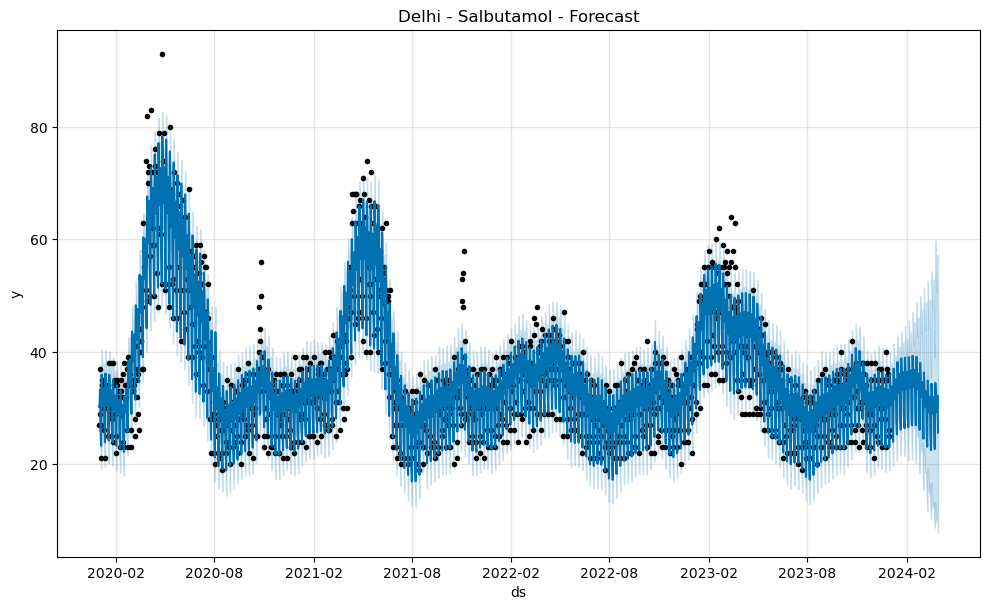

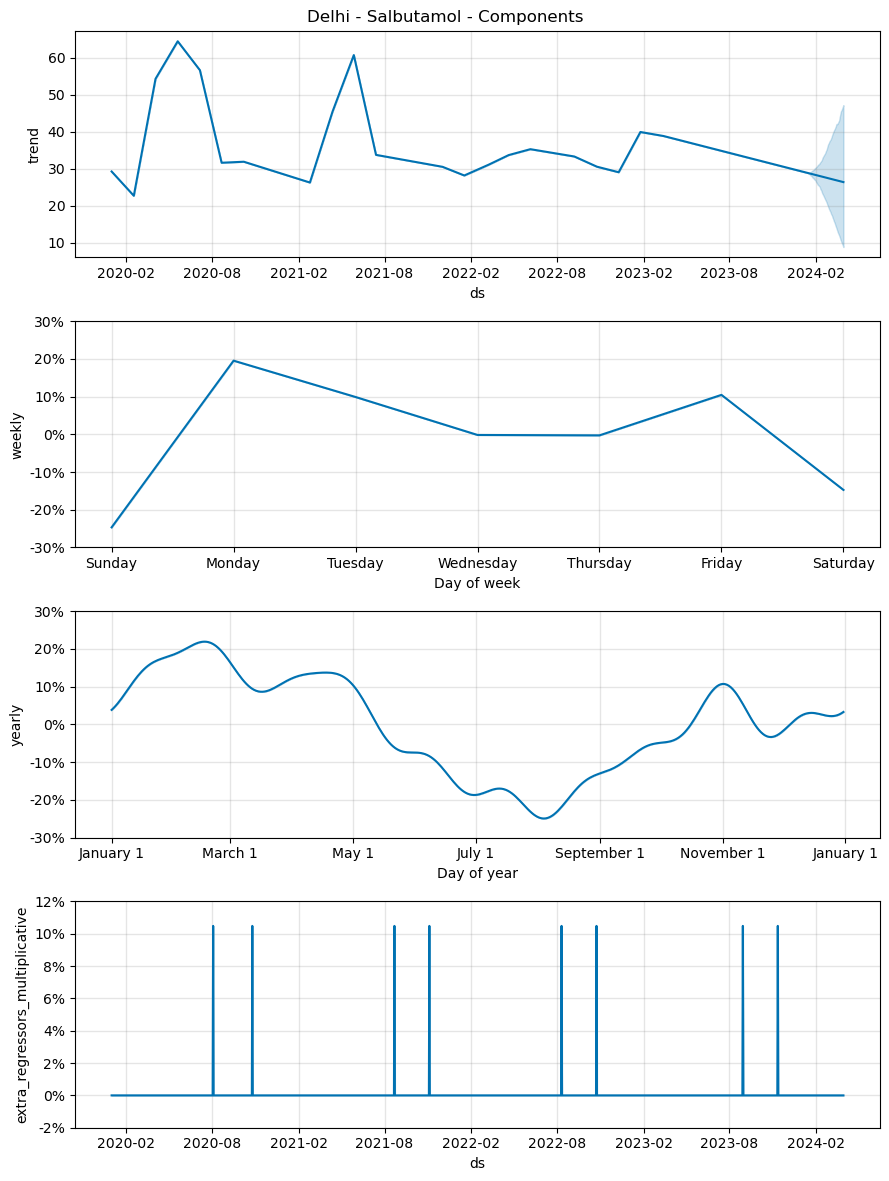

06:14:36 - cmdstanpy - INFO - Chain [1] start processing
06:14:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for paracetamol in kolkata

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:36 - cmdstanpy - INFO - Chain [1] start processing
06:14:36 - cmdstanpy - INFO - Chain [1] done processing
06:14:36 - cmdstanpy - INFO - Chain [1] start processing
06:14:36 - cmdstanpy - INFO - Chain [1] done processing
06:14:36 - cmdstanpy - INFO - Chain [1] start processing
06:14:36 - cmdstanpy - INFO - Chain [1] done processing
06:14:36 - cmdstanpy - INFO - Chain [1] start processing
06:14:36 - cmdstanpy - INFO - Chain [1] done processing
06:14:36 - cmdstanpy - INFO - Chain [1] start processing
06:14:36 - cmdstanpy - INFO - Chain [1] done processing
06:14:36 - cmdstanpy - INFO - Chain [1] start processing
06:14:37 - cmdstanpy - INFO - Chain [1] done processing
06:14:37 - cmdstanpy - INFO - Chain [1] start processing
06:14:37 - cmdstanpy - INFO - Chain [1] done processing
06:14:37 - cmdstanpy - INFO - Chain [1] start processing
06:14:37 - cmdstanpy - INFO - Chain [1] done processing
06:14:37 - cmdstanpy - INFO - Chain [1] start processing
06:14:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.85
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:38 - cmdstanpy - INFO - Chain [1] start processing
06:14:38 - cmdstanpy - INFO - Chain [1] done processing
06:14:38 - cmdstanpy - INFO - Chain [1] start processing
06:14:38 - cmdstanpy - INFO - Chain [1] done processing
06:14:38 - cmdstanpy - INFO - Chain [1] start processing
06:14:38 - cmdstanpy - INFO - Chain [1] done processing
06:14:38 - cmdstanpy - INFO - Chain [1] start processing
06:14:38 - cmdstanpy - INFO - Chain [1] done processing
06:14:38 - cmdstanpy - INFO - Chain [1] start processing
06:14:38 - cmdstanpy - INFO - Chain [1] done processing
06:14:39 - cmdstanpy - INFO - Chain [1] start processing
06:14:39 - cmdstanpy - INFO - Chain [1] done processing
06:14:39 - cmdstanpy - INFO - Chain [1] start processing
06:14:39 - cmdstanpy - INFO - Chain [1] done processing
06:14:39 - cmdstanpy - INFO - Chain [1] start processing
06:14:39 - cmdstanpy - INFO - Chain [1] done processing
06:14:39 - cmdstanpy - INFO - Chain [1] start processing
06:14:39 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.82
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:40 - cmdstanpy - INFO - Chain [1] start processing
06:14:40 - cmdstanpy - INFO - Chain [1] done processing
06:14:40 - cmdstanpy - INFO - Chain [1] start processing
06:14:40 - cmdstanpy - INFO - Chain [1] done processing
06:14:40 - cmdstanpy - INFO - Chain [1] start processing
06:14:40 - cmdstanpy - INFO - Chain [1] done processing
06:14:40 - cmdstanpy - INFO - Chain [1] start processing
06:14:40 - cmdstanpy - INFO - Chain [1] done processing
06:14:40 - cmdstanpy - INFO - Chain [1] start processing
06:14:40 - cmdstanpy - INFO - Chain [1] done processing
06:14:41 - cmdstanpy - INFO - Chain [1] start processing
06:14:41 - cmdstanpy - INFO - Chain [1] done processing
06:14:41 - cmdstanpy - INFO - Chain [1] start processing
06:14:41 - cmdstanpy - INFO - Chain [1] done processing
06:14:41 - cmdstanpy - INFO - Chain [1] start processing
06:14:41 - cmdstanpy - INFO - Chain [1] done processing
06:14:41 - cmdstanpy - INFO - Chain [1] start processing
06:14:41 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.49
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:42 - cmdstanpy - INFO - Chain [1] start processing
06:14:42 - cmdstanpy - INFO - Chain [1] done processing
06:14:42 - cmdstanpy - INFO - Chain [1] start processing
06:14:42 - cmdstanpy - INFO - Chain [1] done processing
06:14:42 - cmdstanpy - INFO - Chain [1] start processing
06:14:42 - cmdstanpy - INFO - Chain [1] done processing
06:14:42 - cmdstanpy - INFO - Chain [1] start processing
06:14:42 - cmdstanpy - INFO - Chain [1] done processing
06:14:42 - cmdstanpy - INFO - Chain [1] start processing
06:14:43 - cmdstanpy - INFO - Chain [1] done processing
06:14:43 - cmdstanpy - INFO - Chain [1] start processing
06:14:43 - cmdstanpy - INFO - Chain [1] done processing
06:14:43 - cmdstanpy - INFO - Chain [1] start processing
06:14:43 - cmdstanpy - INFO - Chain [1] done processing
06:14:43 - cmdstanpy - INFO - Chain [1] start processing
06:14:43 - cmdstanpy - INFO - Chain [1] done processing
06:14:43 - cmdstanpy - INFO - Chain [1] start processing
06:14:43 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.56
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:44 - cmdstanpy - INFO - Chain [1] start processing
06:14:44 - cmdstanpy - INFO - Chain [1] done processing
06:14:44 - cmdstanpy - INFO - Chain [1] start processing
06:14:44 - cmdstanpy - INFO - Chain [1] done processing
06:14:44 - cmdstanpy - INFO - Chain [1] start processing
06:14:44 - cmdstanpy - INFO - Chain [1] done processing
06:14:44 - cmdstanpy - INFO - Chain [1] start processing
06:14:45 - cmdstanpy - INFO - Chain [1] done processing
06:14:45 - cmdstanpy - INFO - Chain [1] start processing
06:14:45 - cmdstanpy - INFO - Chain [1] done processing
06:14:45 - cmdstanpy - INFO - Chain [1] start processing
06:14:45 - cmdstanpy - INFO - Chain [1] done processing
06:14:45 - cmdstanpy - INFO - Chain [1] start processing
06:14:45 - cmdstanpy - INFO - Chain [1] done processing
06:14:45 - cmdstanpy - INFO - Chain [1] start processing
06:14:45 - cmdstanpy - INFO - Chain [1] done processing
06:14:45 - cmdstanpy - INFO - Chain [1] start processing
06:14:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.24
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:46 - cmdstanpy - INFO - Chain [1] start processing
06:14:46 - cmdstanpy - INFO - Chain [1] done processing
06:14:46 - cmdstanpy - INFO - Chain [1] start processing
06:14:46 - cmdstanpy - INFO - Chain [1] done processing
06:14:46 - cmdstanpy - INFO - Chain [1] start processing
06:14:46 - cmdstanpy - INFO - Chain [1] done processing
06:14:47 - cmdstanpy - INFO - Chain [1] start processing
06:14:47 - cmdstanpy - INFO - Chain [1] done processing
06:14:47 - cmdstanpy - INFO - Chain [1] start processing
06:14:47 - cmdstanpy - INFO - Chain [1] done processing
06:14:47 - cmdstanpy - INFO - Chain [1] start processing
06:14:47 - cmdstanpy - INFO - Chain [1] done processing
06:14:47 - cmdstanpy - INFO - Chain [1] start processing
06:14:47 - cmdstanpy - INFO - Chain [1] done processing
06:14:47 - cmdstanpy - INFO - Chain [1] start processing
06:14:47 - cmdstanpy - INFO - Chain [1] done processing
06:14:47 - cmdstanpy - INFO - Chain [1] start processing
06:14:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.62
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:48 - cmdstanpy - INFO - Chain [1] start processing
06:14:48 - cmdstanpy - INFO - Chain [1] done processing
06:14:48 - cmdstanpy - INFO - Chain [1] start processing
06:14:48 - cmdstanpy - INFO - Chain [1] done processing
06:14:48 - cmdstanpy - INFO - Chain [1] start processing
06:14:48 - cmdstanpy - INFO - Chain [1] done processing
06:14:49 - cmdstanpy - INFO - Chain [1] start processing
06:14:49 - cmdstanpy - INFO - Chain [1] done processing
06:14:49 - cmdstanpy - INFO - Chain [1] start processing
06:14:49 - cmdstanpy - INFO - Chain [1] done processing
06:14:49 - cmdstanpy - INFO - Chain [1] start processing
06:14:49 - cmdstanpy - INFO - Chain [1] done processing
06:14:49 - cmdstanpy - INFO - Chain [1] start processing
06:14:49 - cmdstanpy - INFO - Chain [1] done processing
06:14:49 - cmdstanpy - INFO - Chain [1] start processing
06:14:49 - cmdstanpy - INFO - Chain [1] done processing
06:14:49 - cmdstanpy - INFO - Chain [1] start processing
06:14:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.01
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:50 - cmdstanpy - INFO - Chain [1] start processing
06:14:50 - cmdstanpy - INFO - Chain [1] done processing
06:14:50 - cmdstanpy - INFO - Chain [1] start processing
06:14:50 - cmdstanpy - INFO - Chain [1] done processing
06:14:50 - cmdstanpy - INFO - Chain [1] start processing
06:14:51 - cmdstanpy - INFO - Chain [1] done processing
06:14:51 - cmdstanpy - INFO - Chain [1] start processing
06:14:51 - cmdstanpy - INFO - Chain [1] done processing
06:14:51 - cmdstanpy - INFO - Chain [1] start processing
06:14:51 - cmdstanpy - INFO - Chain [1] done processing
06:14:51 - cmdstanpy - INFO - Chain [1] start processing
06:14:51 - cmdstanpy - INFO - Chain [1] done processing
06:14:51 - cmdstanpy - INFO - Chain [1] start processing
06:14:51 - cmdstanpy - INFO - Chain [1] done processing
06:14:51 - cmdstanpy - INFO - Chain [1] start processing
06:14:51 - cmdstanpy - INFO - Chain [1] done processing
06:14:51 - cmdstanpy - INFO - Chain [1] start processing
06:14:51 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 40.20
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:52 - cmdstanpy - INFO - Chain [1] start processing
06:14:52 - cmdstanpy - INFO - Chain [1] done processing
06:14:52 - cmdstanpy - INFO - Chain [1] start processing
06:14:52 - cmdstanpy - INFO - Chain [1] done processing
06:14:53 - cmdstanpy - INFO - Chain [1] start processing
06:14:53 - cmdstanpy - INFO - Chain [1] done processing
06:14:53 - cmdstanpy - INFO - Chain [1] start processing
06:14:53 - cmdstanpy - INFO - Chain [1] done processing
06:14:53 - cmdstanpy - INFO - Chain [1] start processing
06:14:53 - cmdstanpy - INFO - Chain [1] done processing
06:14:53 - cmdstanpy - INFO - Chain [1] start processing
06:14:53 - cmdstanpy - INFO - Chain [1] done processing
06:14:53 - cmdstanpy - INFO - Chain [1] start processing
06:14:53 - cmdstanpy - INFO - Chain [1] done processing
06:14:53 - cmdstanpy - INFO - Chain [1] start processing
06:14:53 - cmdstanpy - INFO - Chain [1] done processing
06:14:54 - cmdstanpy - INFO - Chain [1] start processing
06:14:54 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.38
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:54 - cmdstanpy - INFO - Chain [1] start processing
06:14:54 - cmdstanpy - INFO - Chain [1] done processing
06:14:55 - cmdstanpy - INFO - Chain [1] start processing
06:14:55 - cmdstanpy - INFO - Chain [1] done processing
06:14:55 - cmdstanpy - INFO - Chain [1] start processing
06:14:55 - cmdstanpy - INFO - Chain [1] done processing
06:14:55 - cmdstanpy - INFO - Chain [1] start processing
06:14:55 - cmdstanpy - INFO - Chain [1] done processing
06:14:55 - cmdstanpy - INFO - Chain [1] start processing
06:14:55 - cmdstanpy - INFO - Chain [1] done processing
06:14:55 - cmdstanpy - INFO - Chain [1] start processing
06:14:55 - cmdstanpy - INFO - Chain [1] done processing
06:14:55 - cmdstanpy - INFO - Chain [1] start processing
06:14:55 - cmdstanpy - INFO - Chain [1] done processing
06:14:55 - cmdstanpy - INFO - Chain [1] start processing
06:14:56 - cmdstanpy - INFO - Chain [1] done processing
06:14:56 - cmdstanpy - INFO - Chain [1] start processing
06:14:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 40.00
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:57 - cmdstanpy - INFO - Chain [1] start processing
06:14:57 - cmdstanpy - INFO - Chain [1] done processing
06:14:57 - cmdstanpy - INFO - Chain [1] start processing
06:14:57 - cmdstanpy - INFO - Chain [1] done processing
06:14:57 - cmdstanpy - INFO - Chain [1] start processing
06:14:57 - cmdstanpy - INFO - Chain [1] done processing
06:14:57 - cmdstanpy - INFO - Chain [1] start processing
06:14:57 - cmdstanpy - INFO - Chain [1] done processing
06:14:57 - cmdstanpy - INFO - Chain [1] start processing
06:14:57 - cmdstanpy - INFO - Chain [1] done processing
06:14:57 - cmdstanpy - INFO - Chain [1] start processing
06:14:57 - cmdstanpy - INFO - Chain [1] done processing
06:14:58 - cmdstanpy - INFO - Chain [1] start processing
06:14:58 - cmdstanpy - INFO - Chain [1] done processing
06:14:58 - cmdstanpy - INFO - Chain [1] start processing
06:14:58 - cmdstanpy - INFO - Chain [1] done processing
06:14:58 - cmdstanpy - INFO - Chain [1] start processing
06:14:58 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.35
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:14:59 - cmdstanpy - INFO - Chain [1] start processing
06:14:59 - cmdstanpy - INFO - Chain [1] done processing
06:14:59 - cmdstanpy - INFO - Chain [1] start processing
06:14:59 - cmdstanpy - INFO - Chain [1] done processing
06:14:59 - cmdstanpy - INFO - Chain [1] start processing
06:14:59 - cmdstanpy - INFO - Chain [1] done processing
06:14:59 - cmdstanpy - INFO - Chain [1] start processing
06:14:59 - cmdstanpy - INFO - Chain [1] done processing
06:14:59 - cmdstanpy - INFO - Chain [1] start processing
06:15:00 - cmdstanpy - INFO - Chain [1] done processing
06:15:00 - cmdstanpy - INFO - Chain [1] start processing
06:15:00 - cmdstanpy - INFO - Chain [1] done processing
06:15:00 - cmdstanpy - INFO - Chain [1] start processing
06:15:00 - cmdstanpy - INFO - Chain [1] done processing
06:15:00 - cmdstanpy - INFO - Chain [1] start processing
06:15:00 - cmdstanpy - INFO - Chain [1] done processing
06:15:00 - cmdstanpy - INFO - Chain [1] start processing
06:15:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 44.51
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:01 - cmdstanpy - INFO - Chain [1] start processing
06:15:01 - cmdstanpy - INFO - Chain [1] done processing
06:15:01 - cmdstanpy - INFO - Chain [1] start processing
06:15:01 - cmdstanpy - INFO - Chain [1] done processing
06:15:01 - cmdstanpy - INFO - Chain [1] start processing
06:15:01 - cmdstanpy - INFO - Chain [1] done processing
06:15:02 - cmdstanpy - INFO - Chain [1] start processing
06:15:02 - cmdstanpy - INFO - Chain [1] done processing
06:15:02 - cmdstanpy - INFO - Chain [1] start processing
06:15:02 - cmdstanpy - INFO - Chain [1] done processing
06:15:02 - cmdstanpy - INFO - Chain [1] start processing
06:15:02 - cmdstanpy - INFO - Chain [1] done processing
06:15:02 - cmdstanpy - INFO - Chain [1] start processing
06:15:02 - cmdstanpy - INFO - Chain [1] done processing
06:15:02 - cmdstanpy - INFO - Chain [1] start processing
06:15:02 - cmdstanpy - INFO - Chain [1] done processing
06:15:02 - cmdstanpy - INFO - Chain [1] start processing
06:15:02 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.08
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:03 - cmdstanpy - INFO - Chain [1] start processing
06:15:03 - cmdstanpy - INFO - Chain [1] done processing
06:15:04 - cmdstanpy - INFO - Chain [1] start processing
06:15:04 - cmdstanpy - INFO - Chain [1] done processing
06:15:04 - cmdstanpy - INFO - Chain [1] start processing
06:15:04 - cmdstanpy - INFO - Chain [1] done processing
06:15:04 - cmdstanpy - INFO - Chain [1] start processing
06:15:04 - cmdstanpy - INFO - Chain [1] done processing
06:15:04 - cmdstanpy - INFO - Chain [1] start processing
06:15:04 - cmdstanpy - INFO - Chain [1] done processing
06:15:04 - cmdstanpy - INFO - Chain [1] start processing
06:15:04 - cmdstanpy - INFO - Chain [1] done processing
06:15:04 - cmdstanpy - INFO - Chain [1] start processing
06:15:04 - cmdstanpy - INFO - Chain [1] done processing
06:15:05 - cmdstanpy - INFO - Chain [1] start processing
06:15:05 - cmdstanpy - INFO - Chain [1] done processing
06:15:05 - cmdstanpy - INFO - Chain [1] start processing
06:15:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 44.28
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:06 - cmdstanpy - INFO - Chain [1] start processing
06:15:06 - cmdstanpy - INFO - Chain [1] done processing
06:15:06 - cmdstanpy - INFO - Chain [1] start processing
06:15:06 - cmdstanpy - INFO - Chain [1] done processing
06:15:06 - cmdstanpy - INFO - Chain [1] start processing
06:15:06 - cmdstanpy - INFO - Chain [1] done processing
06:15:06 - cmdstanpy - INFO - Chain [1] start processing
06:15:06 - cmdstanpy - INFO - Chain [1] done processing
06:15:06 - cmdstanpy - INFO - Chain [1] start processing
06:15:06 - cmdstanpy - INFO - Chain [1] done processing
06:15:06 - cmdstanpy - INFO - Chain [1] start processing
06:15:07 - cmdstanpy - INFO - Chain [1] done processing
06:15:07 - cmdstanpy - INFO - Chain [1] start processing
06:15:07 - cmdstanpy - INFO - Chain [1] done processing
06:15:07 - cmdstanpy - INFO - Chain [1] start processing
06:15:07 - cmdstanpy - INFO - Chain [1] done processing
06:15:07 - cmdstanpy - INFO - Chain [1] start processing
06:15:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.71
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:08 - cmdstanpy - INFO - Chain [1] start processing
06:15:08 - cmdstanpy - INFO - Chain [1] done processing
06:15:08 - cmdstanpy - INFO - Chain [1] start processing
06:15:08 - cmdstanpy - INFO - Chain [1] done processing
06:15:08 - cmdstanpy - INFO - Chain [1] start processing
06:15:08 - cmdstanpy - INFO - Chain [1] done processing
06:15:08 - cmdstanpy - INFO - Chain [1] start processing
06:15:08 - cmdstanpy - INFO - Chain [1] done processing
06:15:09 - cmdstanpy - INFO - Chain [1] start processing
06:15:09 - cmdstanpy - INFO - Chain [1] done processing
06:15:09 - cmdstanpy - INFO - Chain [1] start processing
06:15:09 - cmdstanpy - INFO - Chain [1] done processing
06:15:09 - cmdstanpy - INFO - Chain [1] start processing
06:15:09 - cmdstanpy - INFO - Chain [1] done processing
06:15:09 - cmdstanpy - INFO - Chain [1] start processing
06:15:09 - cmdstanpy - INFO - Chain [1] done processing
06:15:09 - cmdstanpy - INFO - Chain [1] start processing
06:15:09 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 44.99
---


06:15:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:10 - cmdstanpy - INFO - Chain [1] start processing
06:15:10 - cmdstanpy - INFO - Chain [1] done processing
06:15:10 - cmdstanpy - INFO - Chain [1] start processing
06:15:10 - cmdstanpy - INFO - Chain [1] done processing
06:15:10 - cmdstanpy - INFO - Chain [1] start processing
06:15:11 - cmdstanpy - INFO - Chain [1] done processing
06:15:11 - cmdstanpy - INFO - Chain [1] start processing
06:15:11 - cmdstanpy - INFO - Chain [1] done processing
06:15:11 - cmdstanpy - INFO - Chain [1] start processing
06:15:11 - cmdstanpy - INFO - Chain [1] done processing
06:15:11 - cmdstanpy - INFO - Chain [1] start processing
06:15:11 - cmdstanpy - INFO - Chain [1] done processing
06:15:11 - cmdstanpy - INFO - Chain [1] start processing
06:15:11 - cmdstanpy - INFO - Chain [1] done processing
06:15:11 - cmdstanpy - INFO - Chain [1] start processing
06:15:12 - cmdstanpy - INFO - Chain [1] done processing
06:15:12 - cmdstanpy - INFO - Chain [1] start processing
06:15:12 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 53.62
---


06:15:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:13 - cmdstanpy - INFO - Chain [1] start processing
06:15:13 - cmdstanpy - INFO - Chain [1] done processing
06:15:13 - cmdstanpy - INFO - Chain [1] start processing
06:15:13 - cmdstanpy - INFO - Chain [1] done processing
06:15:13 - cmdstanpy - INFO - Chain [1] start processing
06:15:13 - cmdstanpy - INFO - Chain [1] done processing
06:15:14 - cmdstanpy - INFO - Chain [1] start processing
06:15:14 - cmdstanpy - INFO - Chain [1] done processing
06:15:14 - cmdstanpy - INFO - Chain [1] start processing
06:15:14 - cmdstanpy - INFO - Chain [1] done processing
06:15:14 - cmdstanpy - INFO - Chain [1] start processing
06:15:14 - cmdstanpy - INFO - Chain [1] done processing
06:15:14 - cmdstanpy - INFO - Chain [1] start processing
06:15:14 - cmdstanpy - INFO - Chain [1] done processing
06:15:14 - cmdstanpy - INFO - Chain [1] start processing
06:15:14 - cmdstanpy - INFO - Chain [1] done processing
06:15:15 - cmdstanpy - INFO - Chain [1] start processing
06:15:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.38
---


06:15:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:16 - cmdstanpy - INFO - Chain [1] start processing
06:15:16 - cmdstanpy - INFO - Chain [1] done processing
06:15:16 - cmdstanpy - INFO - Chain [1] start processing
06:15:16 - cmdstanpy - INFO - Chain [1] done processing
06:15:16 - cmdstanpy - INFO - Chain [1] start processing
06:15:16 - cmdstanpy - INFO - Chain [1] done processing
06:15:16 - cmdstanpy - INFO - Chain [1] start processing
06:15:16 - cmdstanpy - INFO - Chain [1] done processing
06:15:16 - cmdstanpy - INFO - Chain [1] start processing
06:15:17 - cmdstanpy - INFO - Chain [1] done processing
06:15:17 - cmdstanpy - INFO - Chain [1] start processing
06:15:17 - cmdstanpy - INFO - Chain [1] done processing
06:15:17 - cmdstanpy - INFO - Chain [1] start processing
06:15:17 - cmdstanpy - INFO - Chain [1] done processing
06:15:17 - cmdstanpy - INFO - Chain [1] start processing
06:15:17 - cmdstanpy - INFO - Chain [1] done processing
06:15:17 - cmdstanpy - INFO - Chain [1] start processing
06:15:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.52
---


06:15:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:19 - cmdstanpy - INFO - Chain [1] start processing
06:15:19 - cmdstanpy - INFO - Chain [1] done processing
06:15:19 - cmdstanpy - INFO - Chain [1] start processing
06:15:19 - cmdstanpy - INFO - Chain [1] done processing
06:15:19 - cmdstanpy - INFO - Chain [1] start processing
06:15:19 - cmdstanpy - INFO - Chain [1] done processing
06:15:19 - cmdstanpy - INFO - Chain [1] start processing
06:15:19 - cmdstanpy - INFO - Chain [1] done processing
06:15:19 - cmdstanpy - INFO - Chain [1] start processing
06:15:19 - cmdstanpy - INFO - Chain [1] done processing
06:15:19 - cmdstanpy - INFO - Chain [1] start processing
06:15:20 - cmdstanpy - INFO - Chain [1] done processing
06:15:20 - cmdstanpy - INFO - Chain [1] start processing
06:15:20 - cmdstanpy - INFO - Chain [1] done processing
06:15:20 - cmdstanpy - INFO - Chain [1] start processing
06:15:20 - cmdstanpy - INFO - Chain [1] done processing
06:15:20 - cmdstanpy - INFO - Chain [1] start processing
06:15:20 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.43
---


06:15:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:21 - cmdstanpy - INFO - Chain [1] start processing
06:15:21 - cmdstanpy - INFO - Chain [1] done processing
06:15:22 - cmdstanpy - INFO - Chain [1] start processing
06:15:22 - cmdstanpy - INFO - Chain [1] done processing
06:15:22 - cmdstanpy - INFO - Chain [1] start processing
06:15:22 - cmdstanpy - INFO - Chain [1] done processing
06:15:22 - cmdstanpy - INFO - Chain [1] start processing
06:15:22 - cmdstanpy - INFO - Chain [1] done processing
06:15:22 - cmdstanpy - INFO - Chain [1] start processing
06:15:22 - cmdstanpy - INFO - Chain [1] done processing
06:15:22 - cmdstanpy - INFO - Chain [1] start processing
06:15:22 - cmdstanpy - INFO - Chain [1] done processing
06:15:22 - cmdstanpy - INFO - Chain [1] start processing
06:15:23 - cmdstanpy - INFO - Chain [1] done processing
06:15:23 - cmdstanpy - INFO - Chain [1] start processing
06:15:23 - cmdstanpy - INFO - Chain [1] done processing
06:15:23 - cmdstanpy - INFO - Chain [1] start processing
06:15:23 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.09
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:24 - cmdstanpy - INFO - Chain [1] start processing
06:15:24 - cmdstanpy - INFO - Chain [1] done processing
06:15:24 - cmdstanpy - INFO - Chain [1] start processing
06:15:24 - cmdstanpy - INFO - Chain [1] done processing
06:15:25 - cmdstanpy - INFO - Chain [1] start processing
06:15:25 - cmdstanpy - INFO - Chain [1] done processing
06:15:25 - cmdstanpy - INFO - Chain [1] start processing
06:15:25 - cmdstanpy - INFO - Chain [1] done processing
06:15:25 - cmdstanpy - INFO - Chain [1] start processing
06:15:25 - cmdstanpy - INFO - Chain [1] done processing
06:15:25 - cmdstanpy - INFO - Chain [1] start processing
06:15:25 - cmdstanpy - INFO - Chain [1] done processing
06:15:25 - cmdstanpy - INFO - Chain [1] start processing
06:15:25 - cmdstanpy - INFO - Chain [1] done processing
06:15:25 - cmdstanpy - INFO - Chain [1] start processing
06:15:26 - cmdstanpy - INFO - Chain [1] done processing
06:15:26 - cmdstanpy - INFO - Chain [1] start processing
06:15:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.62
---


06:15:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:27 - cmdstanpy - INFO - Chain [1] start processing
06:15:27 - cmdstanpy - INFO - Chain [1] done processing
06:15:27 - cmdstanpy - INFO - Chain [1] start processing
06:15:27 - cmdstanpy - INFO - Chain [1] done processing
06:15:27 - cmdstanpy - INFO - Chain [1] start processing
06:15:27 - cmdstanpy - INFO - Chain [1] done processing
06:15:27 - cmdstanpy - INFO - Chain [1] start processing
06:15:28 - cmdstanpy - INFO - Chain [1] done processing
06:15:28 - cmdstanpy - INFO - Chain [1] start processing
06:15:28 - cmdstanpy - INFO - Chain [1] done processing
06:15:28 - cmdstanpy - INFO - Chain [1] start processing
06:15:28 - cmdstanpy - INFO - Chain [1] done processing
06:15:28 - cmdstanpy - INFO - Chain [1] start processing
06:15:28 - cmdstanpy - INFO - Chain [1] done processing
06:15:28 - cmdstanpy - INFO - Chain [1] start processing
06:15:28 - cmdstanpy - INFO - Chain [1] done processing
06:15:29 - cmdstanpy - INFO - Chain [1] start processing
06:15:29 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.90
---


06:15:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:30 - cmdstanpy - INFO - Chain [1] start processing
06:15:30 - cmdstanpy - INFO - Chain [1] done processing
06:15:30 - cmdstanpy - INFO - Chain [1] start processing
06:15:30 - cmdstanpy - INFO - Chain [1] done processing
06:15:30 - cmdstanpy - INFO - Chain [1] start processing
06:15:30 - cmdstanpy - INFO - Chain [1] done processing
06:15:30 - cmdstanpy - INFO - Chain [1] start processing
06:15:31 - cmdstanpy - INFO - Chain [1] done processing
06:15:31 - cmdstanpy - INFO - Chain [1] start processing
06:15:31 - cmdstanpy - INFO - Chain [1] done processing
06:15:31 - cmdstanpy - INFO - Chain [1] start processing
06:15:31 - cmdstanpy - INFO - Chain [1] done processing
06:15:31 - cmdstanpy - INFO - Chain [1] start processing
06:15:31 - cmdstanpy - INFO - Chain [1] done processing
06:15:31 - cmdstanpy - INFO - Chain [1] start processing
06:15:31 - cmdstanpy - INFO - Chain [1] done processing
06:15:31 - cmdstanpy - INFO - Chain [1] start processing
06:15:32 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.70
---


06:15:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:33 - cmdstanpy - INFO - Chain [1] start processing
06:15:33 - cmdstanpy - INFO - Chain [1] done processing
06:15:33 - cmdstanpy - INFO - Chain [1] start processing
06:15:33 - cmdstanpy - INFO - Chain [1] done processing
06:15:33 - cmdstanpy - INFO - Chain [1] start processing
06:15:33 - cmdstanpy - INFO - Chain [1] done processing
06:15:33 - cmdstanpy - INFO - Chain [1] start processing
06:15:34 - cmdstanpy - INFO - Chain [1] done processing
06:15:34 - cmdstanpy - INFO - Chain [1] start processing
06:15:34 - cmdstanpy - INFO - Chain [1] done processing
06:15:34 - cmdstanpy - INFO - Chain [1] start processing
06:15:34 - cmdstanpy - INFO - Chain [1] done processing
06:15:34 - cmdstanpy - INFO - Chain [1] start processing
06:15:34 - cmdstanpy - INFO - Chain [1] done processing
06:15:34 - cmdstanpy - INFO - Chain [1] start processing
06:15:35 - cmdstanpy - INFO - Chain [1] done processing
06:15:35 - cmdstanpy - INFO - Chain [1] start processing
06:15:35 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 57.85
---


06:15:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:37 - cmdstanpy - INFO - Chain [1] start processing
06:15:37 - cmdstanpy - INFO - Chain [1] done processing
06:15:37 - cmdstanpy - INFO - Chain [1] start processing
06:15:37 - cmdstanpy - INFO - Chain [1] done processing
06:15:37 - cmdstanpy - INFO - Chain [1] start processing
06:15:37 - cmdstanpy - INFO - Chain [1] done processing
06:15:37 - cmdstanpy - INFO - Chain [1] start processing
06:15:37 - cmdstanpy - INFO - Chain [1] done processing
06:15:37 - cmdstanpy - INFO - Chain [1] start processing
06:15:37 - cmdstanpy - INFO - Chain [1] done processing
06:15:38 - cmdstanpy - INFO - Chain [1] start processing
06:15:38 - cmdstanpy - INFO - Chain [1] done processing
06:15:38 - cmdstanpy - INFO - Chain [1] start processing
06:15:38 - cmdstanpy - INFO - Chain [1] done processing
06:15:38 - cmdstanpy - INFO - Chain [1] start processing
06:15:38 - cmdstanpy - INFO - Chain [1] done processing
06:15:38 - cmdstanpy - INFO - Chain [1] start processing
06:15:38 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 49.91
---


06:15:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:40 - cmdstanpy - INFO - Chain [1] start processing
06:15:40 - cmdstanpy - INFO - Chain [1] done processing
06:15:40 - cmdstanpy - INFO - Chain [1] start processing
06:15:40 - cmdstanpy - INFO - Chain [1] done processing
06:15:40 - cmdstanpy - INFO - Chain [1] start processing
06:15:41 - cmdstanpy - INFO - Chain [1] done processing
06:15:41 - cmdstanpy - INFO - Chain [1] start processing
06:15:41 - cmdstanpy - INFO - Chain [1] done processing
06:15:41 - cmdstanpy - INFO - Chain [1] start processing
06:15:41 - cmdstanpy - INFO - Chain [1] done processing
06:15:41 - cmdstanpy - INFO - Chain [1] start processing
06:15:41 - cmdstanpy - INFO - Chain [1] done processing
06:15:41 - cmdstanpy - INFO - Chain [1] start processing
06:15:42 - cmdstanpy - INFO - Chain [1] done processing
06:15:42 - cmdstanpy - INFO - Chain [1] start processing
06:15:42 - cmdstanpy - INFO - Chain [1] done processing
06:15:42 - cmdstanpy - INFO - Chain [1] start processing
06:15:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.72
---


06:15:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:44 - cmdstanpy - INFO - Chain [1] start processing
06:15:44 - cmdstanpy - INFO - Chain [1] done processing
06:15:44 - cmdstanpy - INFO - Chain [1] start processing
06:15:44 - cmdstanpy - INFO - Chain [1] done processing
06:15:44 - cmdstanpy - INFO - Chain [1] start processing
06:15:44 - cmdstanpy - INFO - Chain [1] done processing
06:15:44 - cmdstanpy - INFO - Chain [1] start processing
06:15:44 - cmdstanpy - INFO - Chain [1] done processing
06:15:44 - cmdstanpy - INFO - Chain [1] start processing
06:15:44 - cmdstanpy - INFO - Chain [1] done processing
06:15:45 - cmdstanpy - INFO - Chain [1] start processing
06:15:45 - cmdstanpy - INFO - Chain [1] done processing
06:15:45 - cmdstanpy - INFO - Chain [1] start processing
06:15:45 - cmdstanpy - INFO - Chain [1] done processing
06:15:45 - cmdstanpy - INFO - Chain [1] start processing
06:15:45 - cmdstanpy - INFO - Chain [1] done processing
06:15:45 - cmdstanpy - INFO - Chain [1] start processing
06:15:46 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.50
---


06:15:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:47 - cmdstanpy - INFO - Chain [1] start processing
06:15:47 - cmdstanpy - INFO - Chain [1] done processing
06:15:47 - cmdstanpy - INFO - Chain [1] start processing
06:15:47 - cmdstanpy - INFO - Chain [1] done processing
06:15:47 - cmdstanpy - INFO - Chain [1] start processing
06:15:48 - cmdstanpy - INFO - Chain [1] done processing
06:15:48 - cmdstanpy - INFO - Chain [1] start processing
06:15:48 - cmdstanpy - INFO - Chain [1] done processing
06:15:48 - cmdstanpy - INFO - Chain [1] start processing
06:15:48 - cmdstanpy - INFO - Chain [1] done processing
06:15:48 - cmdstanpy - INFO - Chain [1] start processing
06:15:48 - cmdstanpy - INFO - Chain [1] done processing
06:15:48 - cmdstanpy - INFO - Chain [1] start processing
06:15:49 - cmdstanpy - INFO - Chain [1] done processing
06:15:49 - cmdstanpy - INFO - Chain [1] start processing
06:15:49 - cmdstanpy - INFO - Chain [1] done processing
06:15:49 - cmdstanpy - INFO - Chain [1] start processing
06:15:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 49.44
---


06:15:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:51 - cmdstanpy - INFO - Chain [1] start processing
06:15:51 - cmdstanpy - INFO - Chain [1] done processing
06:15:51 - cmdstanpy - INFO - Chain [1] start processing
06:15:51 - cmdstanpy - INFO - Chain [1] done processing
06:15:51 - cmdstanpy - INFO - Chain [1] start processing
06:15:51 - cmdstanpy - INFO - Chain [1] done processing
06:15:51 - cmdstanpy - INFO - Chain [1] start processing
06:15:51 - cmdstanpy - INFO - Chain [1] done processing
06:15:51 - cmdstanpy - INFO - Chain [1] start processing
06:15:51 - cmdstanpy - INFO - Chain [1] done processing
06:15:52 - cmdstanpy - INFO - Chain [1] start processing
06:15:52 - cmdstanpy - INFO - Chain [1] done processing
06:15:52 - cmdstanpy - INFO - Chain [1] start processing
06:15:52 - cmdstanpy - INFO - Chain [1] done processing
06:15:52 - cmdstanpy - INFO - Chain [1] start processing
06:15:52 - cmdstanpy - INFO - Chain [1] done processing
06:15:52 - cmdstanpy - INFO - Chain [1] start processing
06:15:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.43
---


06:15:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:54 - cmdstanpy - INFO - Chain [1] start processing
06:15:54 - cmdstanpy - INFO - Chain [1] done processing
06:15:54 - cmdstanpy - INFO - Chain [1] start processing
06:15:54 - cmdstanpy - INFO - Chain [1] done processing
06:15:54 - cmdstanpy - INFO - Chain [1] start processing
06:15:54 - cmdstanpy - INFO - Chain [1] done processing
06:15:54 - cmdstanpy - INFO - Chain [1] start processing
06:15:54 - cmdstanpy - INFO - Chain [1] done processing
06:15:55 - cmdstanpy - INFO - Chain [1] start processing
06:15:55 - cmdstanpy - INFO - Chain [1] done processing
06:15:55 - cmdstanpy - INFO - Chain [1] start processing
06:15:55 - cmdstanpy - INFO - Chain [1] done processing
06:15:55 - cmdstanpy - INFO - Chain [1] start processing
06:15:55 - cmdstanpy - INFO - Chain [1] done processing
06:15:55 - cmdstanpy - INFO - Chain [1] start processing
06:15:56 - cmdstanpy - INFO - Chain [1] done processing
06:15:56 - cmdstanpy - INFO - Chain [1] start processing
06:15:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 49.06
---


06:15:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:15:57 - cmdstanpy - INFO - Chain [1] start processing
06:15:57 - cmdstanpy - INFO - Chain [1] done processing
06:15:58 - cmdstanpy - INFO - Chain [1] start processing
06:15:58 - cmdstanpy - INFO - Chain [1] done processing
06:15:58 - cmdstanpy - INFO - Chain [1] start processing
06:15:58 - cmdstanpy - INFO - Chain [1] done processing
06:15:58 - cmdstanpy - INFO - Chain [1] start processing
06:15:58 - cmdstanpy - INFO - Chain [1] done processing
06:15:58 - cmdstanpy - INFO - Chain [1] start processing
06:15:58 - cmdstanpy - INFO - Chain [1] done processing
06:15:58 - cmdstanpy - INFO - Chain [1] start processing
06:15:58 - cmdstanpy - INFO - Chain [1] done processing
06:15:58 - cmdstanpy - INFO - Chain [1] start processing
06:15:59 - cmdstanpy - INFO - Chain [1] done processing
06:15:59 - cmdstanpy - INFO - Chain [1] start processing
06:15:59 - cmdstanpy - INFO - Chain [1] done processing
06:15:59 - cmdstanpy - INFO - Chain [1] start processing
06:15:59 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 50.20
---


06:16:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:01 - cmdstanpy - INFO - Chain [1] start processing
06:16:01 - cmdstanpy - INFO - Chain [1] done processing
06:16:01 - cmdstanpy - INFO - Chain [1] start processing
06:16:01 - cmdstanpy - INFO - Chain [1] done processing
06:16:02 - cmdstanpy - INFO - Chain [1] start processing
06:16:02 - cmdstanpy - INFO - Chain [1] done processing
06:16:02 - cmdstanpy - INFO - Chain [1] start processing
06:16:02 - cmdstanpy - INFO - Chain [1] done processing
06:16:02 - cmdstanpy - INFO - Chain [1] start processing
06:16:02 - cmdstanpy - INFO - Chain [1] done processing
06:16:02 - cmdstanpy - INFO - Chain [1] start processing
06:16:03 - cmdstanpy - INFO - Chain [1] done processing
06:16:03 - cmdstanpy - INFO - Chain [1] start processing
06:16:03 - cmdstanpy - INFO - Chain [1] done processing
06:16:03 - cmdstanpy - INFO - Chain [1] start processing
06:16:04 - cmdstanpy - INFO - Chain [1] done processing
06:16:04 - cmdstanpy - INFO - Chain [1] start processing
06:16:04 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 63.72
---


06:16:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:07 - cmdstanpy - INFO - Chain [1] start processing
06:16:07 - cmdstanpy - INFO - Chain [1] done processing
06:16:07 - cmdstanpy - INFO - Chain [1] start processing
06:16:07 - cmdstanpy - INFO - Chain [1] done processing
06:16:07 - cmdstanpy - INFO - Chain [1] start processing
06:16:07 - cmdstanpy - INFO - Chain [1] done processing
06:16:07 - cmdstanpy - INFO - Chain [1] start processing
06:16:07 - cmdstanpy - INFO - Chain [1] done processing
06:16:08 - cmdstanpy - INFO - Chain [1] start processing
06:16:08 - cmdstanpy - INFO - Chain [1] done processing
06:16:08 - cmdstanpy - INFO - Chain [1] start processing
06:16:08 - cmdstanpy - INFO - Chain [1] done processing
06:16:08 - cmdstanpy - INFO - Chain [1] start processing
06:16:08 - cmdstanpy - INFO - Chain [1] done processing
06:16:09 - cmdstanpy - INFO - Chain [1] start processing
06:16:09 - cmdstanpy - INFO - Chain [1] done processing
06:16:09 - cmdstanpy - INFO - Chain [1] start processing
06:16:09 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.80
---


06:16:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:12 - cmdstanpy - INFO - Chain [1] start processing
06:16:12 - cmdstanpy - INFO - Chain [1] done processing
06:16:12 - cmdstanpy - INFO - Chain [1] start processing
06:16:12 - cmdstanpy - INFO - Chain [1] done processing
06:16:12 - cmdstanpy - INFO - Chain [1] start processing
06:16:12 - cmdstanpy - INFO - Chain [1] done processing
06:16:12 - cmdstanpy - INFO - Chain [1] start processing
06:16:13 - cmdstanpy - INFO - Chain [1] done processing
06:16:13 - cmdstanpy - INFO - Chain [1] start processing
06:16:13 - cmdstanpy - INFO - Chain [1] done processing
06:16:13 - cmdstanpy - INFO - Chain [1] start processing
06:16:13 - cmdstanpy - INFO - Chain [1] done processing
06:16:13 - cmdstanpy - INFO - Chain [1] start processing
06:16:14 - cmdstanpy - INFO - Chain [1] done processing
06:16:14 - cmdstanpy - INFO - Chain [1] start processing
06:16:14 - cmdstanpy - INFO - Chain [1] done processing
06:16:15 - cmdstanpy - INFO - Chain [1] start processing
06:16:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.04
---


06:16:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:17 - cmdstanpy - INFO - Chain [1] start processing
06:16:17 - cmdstanpy - INFO - Chain [1] done processing
06:16:17 - cmdstanpy - INFO - Chain [1] start processing
06:16:17 - cmdstanpy - INFO - Chain [1] done processing
06:16:18 - cmdstanpy - INFO - Chain [1] start processing
06:16:18 - cmdstanpy - INFO - Chain [1] done processing
06:16:18 - cmdstanpy - INFO - Chain [1] start processing
06:16:18 - cmdstanpy - INFO - Chain [1] done processing
06:16:18 - cmdstanpy - INFO - Chain [1] start processing
06:16:18 - cmdstanpy - INFO - Chain [1] done processing
06:16:18 - cmdstanpy - INFO - Chain [1] start processing
06:16:19 - cmdstanpy - INFO - Chain [1] done processing
06:16:19 - cmdstanpy - INFO - Chain [1] start processing
06:16:19 - cmdstanpy - INFO - Chain [1] done processing
06:16:19 - cmdstanpy - INFO - Chain [1] start processing
06:16:19 - cmdstanpy - INFO - Chain [1] done processing
06:16:20 - cmdstanpy - INFO - Chain [1] start processing
06:16:20 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 49.81
---


06:16:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:22 - cmdstanpy - INFO - Chain [1] start processing
06:16:22 - cmdstanpy - INFO - Chain [1] done processing
06:16:22 - cmdstanpy - INFO - Chain [1] start processing
06:16:23 - cmdstanpy - INFO - Chain [1] done processing
06:16:23 - cmdstanpy - INFO - Chain [1] start processing
06:16:23 - cmdstanpy - INFO - Chain [1] done processing
06:16:23 - cmdstanpy - INFO - Chain [1] start processing
06:16:23 - cmdstanpy - INFO - Chain [1] done processing
06:16:23 - cmdstanpy - INFO - Chain [1] start processing
06:16:24 - cmdstanpy - INFO - Chain [1] done processing
06:16:24 - cmdstanpy - INFO - Chain [1] start processing
06:16:24 - cmdstanpy - INFO - Chain [1] done processing
06:16:24 - cmdstanpy - INFO - Chain [1] start processing
06:16:24 - cmdstanpy - INFO - Chain [1] done processing
06:16:25 - cmdstanpy - INFO - Chain [1] start processing
06:16:25 - cmdstanpy - INFO - Chain [1] done processing
06:16:25 - cmdstanpy - INFO - Chain [1] start processing
06:16:25 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.58
---


06:16:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:28 - cmdstanpy - INFO - Chain [1] start processing
06:16:28 - cmdstanpy - INFO - Chain [1] done processing
06:16:28 - cmdstanpy - INFO - Chain [1] start processing
06:16:28 - cmdstanpy - INFO - Chain [1] done processing
06:16:28 - cmdstanpy - INFO - Chain [1] start processing
06:16:28 - cmdstanpy - INFO - Chain [1] done processing
06:16:28 - cmdstanpy - INFO - Chain [1] start processing
06:16:28 - cmdstanpy - INFO - Chain [1] done processing
06:16:29 - cmdstanpy - INFO - Chain [1] start processing
06:16:29 - cmdstanpy - INFO - Chain [1] done processing
06:16:29 - cmdstanpy - INFO - Chain [1] start processing
06:16:29 - cmdstanpy - INFO - Chain [1] done processing
06:16:29 - cmdstanpy - INFO - Chain [1] start processing
06:16:30 - cmdstanpy - INFO - Chain [1] done processing
06:16:30 - cmdstanpy - INFO - Chain [1] start processing
06:16:30 - cmdstanpy - INFO - Chain [1] done processing
06:16:30 - cmdstanpy - INFO - Chain [1] start processing
06:16:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.11
---


06:16:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:33 - cmdstanpy - INFO - Chain [1] start processing
06:16:33 - cmdstanpy - INFO - Chain [1] done processing
06:16:33 - cmdstanpy - INFO - Chain [1] start processing
06:16:33 - cmdstanpy - INFO - Chain [1] done processing
06:16:33 - cmdstanpy - INFO - Chain [1] start processing
06:16:34 - cmdstanpy - INFO - Chain [1] done processing
06:16:34 - cmdstanpy - INFO - Chain [1] start processing
06:16:34 - cmdstanpy - INFO - Chain [1] done processing
06:16:34 - cmdstanpy - INFO - Chain [1] start processing
06:16:34 - cmdstanpy - INFO - Chain [1] done processing
06:16:34 - cmdstanpy - INFO - Chain [1] start processing
06:16:35 - cmdstanpy - INFO - Chain [1] done processing
06:16:35 - cmdstanpy - INFO - Chain [1] start processing
06:16:35 - cmdstanpy - INFO - Chain [1] done processing
06:16:35 - cmdstanpy - INFO - Chain [1] start processing
06:16:36 - cmdstanpy - INFO - Chain [1] done processing
06:16:36 - cmdstanpy - INFO - Chain [1] start processing
06:16:36 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.54
---


06:16:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:39 - cmdstanpy - INFO - Chain [1] start processing
06:16:39 - cmdstanpy - INFO - Chain [1] done processing
06:16:39 - cmdstanpy - INFO - Chain [1] start processing
06:16:39 - cmdstanpy - INFO - Chain [1] done processing
06:16:39 - cmdstanpy - INFO - Chain [1] start processing
06:16:39 - cmdstanpy - INFO - Chain [1] done processing
06:16:39 - cmdstanpy - INFO - Chain [1] start processing
06:16:39 - cmdstanpy - INFO - Chain [1] done processing
06:16:39 - cmdstanpy - INFO - Chain [1] start processing
06:16:40 - cmdstanpy - INFO - Chain [1] done processing
06:16:40 - cmdstanpy - INFO - Chain [1] start processing
06:16:40 - cmdstanpy - INFO - Chain [1] done processing
06:16:40 - cmdstanpy - INFO - Chain [1] start processing
06:16:41 - cmdstanpy - INFO - Chain [1] done processing
06:16:41 - cmdstanpy - INFO - Chain [1] start processing
06:16:41 - cmdstanpy - INFO - Chain [1] done processing
06:16:41 - cmdstanpy - INFO - Chain [1] start processing
06:16:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.27
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 36.82

Training final model...


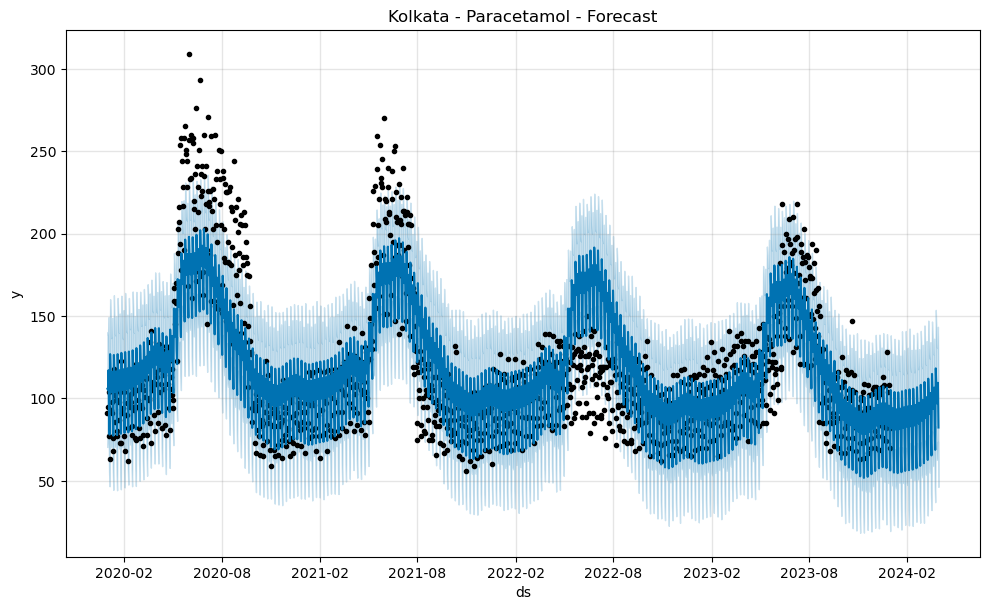

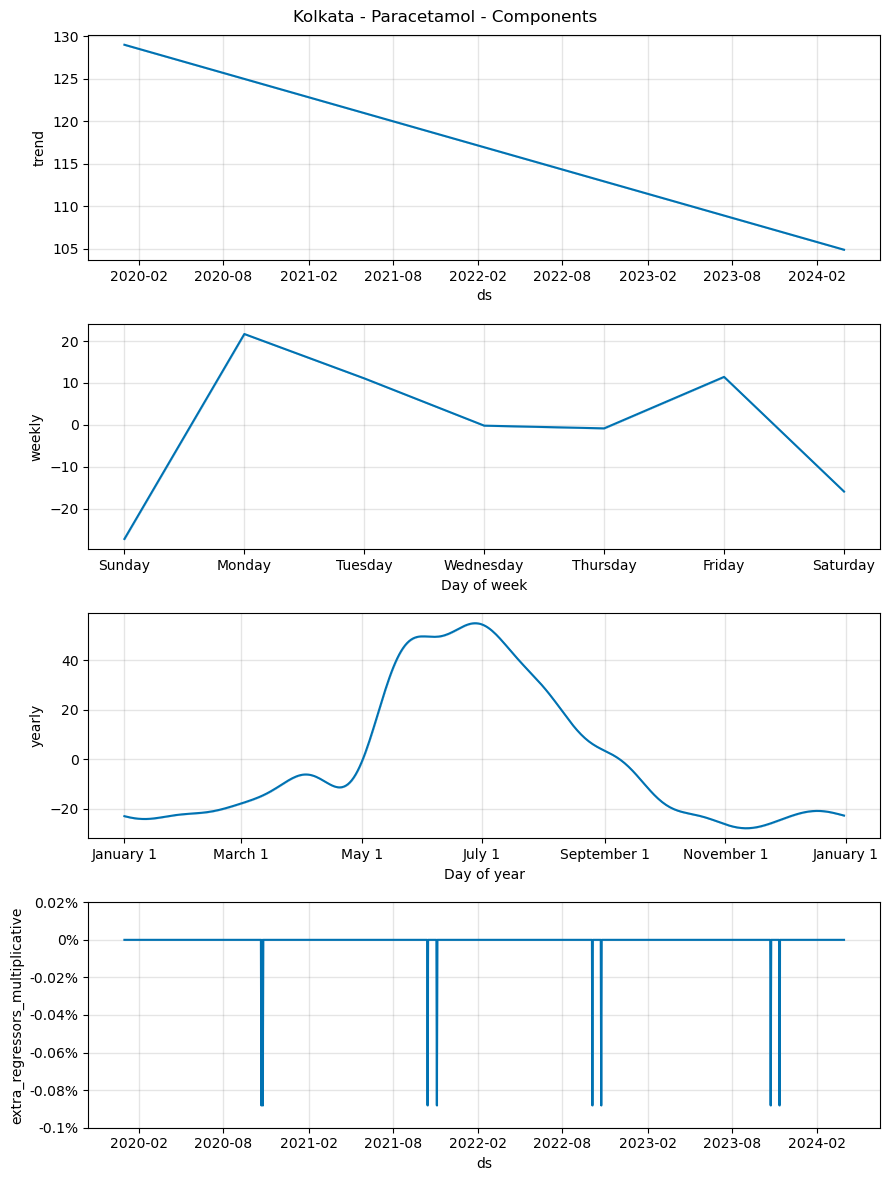

06:16:44 - cmdstanpy - INFO - Chain [1] start processing
06:16:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for ibuprofen in kolkata

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:44 - cmdstanpy - INFO - Chain [1] start processing
06:16:44 - cmdstanpy - INFO - Chain [1] done processing
06:16:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:44 - cmdstanpy - INFO - Chain [1] start processing
06:16:45 - cmdstanpy - INFO - Chain [1] done processing
06:16:45 - cmdstanpy - INFO - Chain [1] start processing
06:16:45 - cmdstanpy - INFO - Chain [1] done processing
06:16:45 - cmdstanpy - INFO - Chain [1] start processing
06:16:45 - cmdstanpy - INFO - Chain [1] done processing
06:16:45 - cmdstanpy - INFO - Chain [1] start processing
06:16:45 - cmdstanpy - INFO - Chain [1] done processing
06:16:45 - cmdstanpy - INFO - Chain [1] start processing
06:16:45 - cmdstanpy - INFO - Chain [1] done processing
06:16:45 - cmdstanpy - INFO - Chain [1] start processing
06:16:45 - cmdstanpy - INFO - Chain [1] done processing
06:16:46 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 35.82
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:47 - cmdstanpy - INFO - Chain [1] start processing
06:16:47 - cmdstanpy - INFO - Chain [1] done processing
06:16:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:47 - cmdstanpy - INFO - Chain [1] start processing
06:16:47 - cmdstanpy - INFO - Chain [1] done processing
06:16:47 - cmdstanpy - INFO - Chain [1] start processing
06:16:47 - cmdstanpy - INFO - Chain [1] done processing
06:16:47 - cmdstanpy - INFO - Chain [1] start processing
06:16:47 - cmdstanpy - INFO - Chain [1] done processing
06:16:48 - cmdstanpy - INFO - Chain [1] start processing
06:16:48 - cmdstanpy - INFO - Chain [1] done processing
06:16:48 - cmdstanpy - INFO - Chain [1] start processing
06:16:48 - cmdstanpy - INFO - Chain [1] done processing
06:16:48 - cmdstanpy - INFO - Chain [1] start processing
06:16:48 - cmdstanpy - INFO - Chain [1] done processing
06:16:48 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.47
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:49 - cmdstanpy - INFO - Chain [1] start processing
06:16:49 - cmdstanpy - INFO - Chain [1] done processing
06:16:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:49 - cmdstanpy - INFO - Chain [1] start processing
06:16:50 - cmdstanpy - INFO - Chain [1] done processing
06:16:50 - cmdstanpy - INFO - Chain [1] start processing
06:16:50 - cmdstanpy - INFO - Chain [1] done processing
06:16:50 - cmdstanpy - INFO - Chain [1] start processing
06:16:50 - cmdstanpy - INFO - Chain [1] done processing
06:16:50 - cmdstanpy - INFO - Chain [1] start processing
06:16:50 - cmdstanpy - INFO - Chain [1] done processing
06:16:50 - cmdstanpy - INFO - Chain [1] start processing
06:16:50 - cmdstanpy - INFO - Chain [1] done processing
06:16:50 - cmdstanpy - INFO - Chain [1] start processing
06:16:50 - cmdstanpy - INFO - Chain [1] done processing
06:16:50 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.26
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:52 - cmdstanpy - INFO - Chain [1] start processing
06:16:52 - cmdstanpy - INFO - Chain [1] done processing
06:16:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:52 - cmdstanpy - INFO - Chain [1] start processing
06:16:52 - cmdstanpy - INFO - Chain [1] done processing
06:16:52 - cmdstanpy - INFO - Chain [1] start processing
06:16:52 - cmdstanpy - INFO - Chain [1] done processing
06:16:52 - cmdstanpy - INFO - Chain [1] start processing
06:16:52 - cmdstanpy - INFO - Chain [1] done processing
06:16:52 - cmdstanpy - INFO - Chain [1] start processing
06:16:52 - cmdstanpy - INFO - Chain [1] done processing
06:16:52 - cmdstanpy - INFO - Chain [1] start processing
06:16:53 - cmdstanpy - INFO - Chain [1] done processing
06:16:53 - cmdstanpy - INFO - Chain [1] start processing
06:16:53 - cmdstanpy - INFO - Chain [1] done processing
06:16:53 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.80
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:54 - cmdstanpy - INFO - Chain [1] start processing
06:16:54 - cmdstanpy - INFO - Chain [1] done processing
06:16:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:54 - cmdstanpy - INFO - Chain [1] start processing
06:16:55 - cmdstanpy - INFO - Chain [1] done processing
06:16:55 - cmdstanpy - INFO - Chain [1] start processing
06:16:55 - cmdstanpy - INFO - Chain [1] done processing
06:16:55 - cmdstanpy - INFO - Chain [1] start processing
06:16:55 - cmdstanpy - INFO - Chain [1] done processing
06:16:55 - cmdstanpy - INFO - Chain [1] start processing
06:16:55 - cmdstanpy - INFO - Chain [1] done processing
06:16:55 - cmdstanpy - INFO - Chain [1] start processing
06:16:55 - cmdstanpy - INFO - Chain [1] done processing
06:16:55 - cmdstanpy - INFO - Chain [1] start processing
06:16:55 - cmdstanpy - INFO - Chain [1] done processing
06:16:55 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.51
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:57 - cmdstanpy - INFO - Chain [1] start processing
06:16:57 - cmdstanpy - INFO - Chain [1] done processing
06:16:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:57 - cmdstanpy - INFO - Chain [1] start processing
06:16:57 - cmdstanpy - INFO - Chain [1] done processing
06:16:57 - cmdstanpy - INFO - Chain [1] start processing
06:16:57 - cmdstanpy - INFO - Chain [1] done processing
06:16:57 - cmdstanpy - INFO - Chain [1] start processing
06:16:57 - cmdstanpy - INFO - Chain [1] done processing
06:16:57 - cmdstanpy - INFO - Chain [1] start processing
06:16:57 - cmdstanpy - INFO - Chain [1] done processing
06:16:58 - cmdstanpy - INFO - Chain [1] start processing
06:16:58 - cmdstanpy - INFO - Chain [1] done processing
06:16:58 - cmdstanpy - INFO - Chain [1] start processing
06:16:58 - cmdstanpy - INFO - Chain [1] done processing
06:16:58 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.07
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:16:59 - cmdstanpy - INFO - Chain [1] start processing
06:16:59 - cmdstanpy - INFO - Chain [1] done processing
06:16:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:16:59 - cmdstanpy - INFO - Chain [1] start processing
06:16:59 - cmdstanpy - INFO - Chain [1] done processing
06:16:59 - cmdstanpy - INFO - Chain [1] start processing
06:17:00 - cmdstanpy - INFO - Chain [1] done processing
06:17:00 - cmdstanpy - INFO - Chain [1] start processing
06:17:00 - cmdstanpy - INFO - Chain [1] done processing
06:17:00 - cmdstanpy - INFO - Chain [1] start processing
06:17:00 - cmdstanpy - INFO - Chain [1] done processing
06:17:00 - cmdstanpy - INFO - Chain [1] start processing
06:17:00 - cmdstanpy - INFO - Chain [1] done processing
06:17:00 - cmdstanpy - INFO - Chain [1] start processing
06:17:00 - cmdstanpy - INFO - Chain [1] done processing
06:17:00 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.68
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:01 - cmdstanpy - INFO - Chain [1] start processing
06:17:01 - cmdstanpy - INFO - Chain [1] done processing
06:17:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:17:01 - cmdstanpy - INFO - Chain [1] start processing
06:17:02 - cmdstanpy - INFO - Chain [1] done processing
06:17:02 - cmdstanpy - INFO - Chain [1] start processing
06:17:02 - cmdstanpy - INFO - Chain [1] done processing
06:17:02 - cmdstanpy - INFO - Chain [1] start processing
06:17:02 - cmdstanpy - INFO - Chain [1] done processing
06:17:02 - cmdstanpy - INFO - Chain [1] start processing
06:17:02 - cmdstanpy - INFO - Chain [1] done processing
06:17:02 - cmdstanpy - INFO - Chain [1] start processing
06:17:02 - cmdstanpy - INFO - Chain [1] done processing
06:17:03 - cmdstanpy - INFO - Chain [1] start processing
06:17:03 - cmdstanpy - INFO - Chain [1] done processing
06:17:03 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.64
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:04 - cmdstanpy - INFO - Chain [1] start processing
06:17:04 - cmdstanpy - INFO - Chain [1] done processing
06:17:04 - cmdstanpy - INFO - Chain [1] start processing
06:17:04 - cmdstanpy - INFO - Chain [1] done processing
06:17:04 - cmdstanpy - INFO - Chain [1] start processing
06:17:04 - cmdstanpy - INFO - Chain [1] done processing
06:17:04 - cmdstanpy - INFO - Chain [1] start processing
06:17:04 - cmdstanpy - INFO - Chain [1] done processing
06:17:04 - cmdstanpy - INFO - Chain [1] start processing
06:17:04 - cmdstanpy - INFO - Chain [1] done processing
06:17:05 - cmdstanpy - INFO - Chain [1] start processing
06:17:05 - cmdstanpy - INFO - Chain [1] done processing
06:17:05 - cmdstanpy - INFO - Chain [1] start processing
06:17:05 - cmdstanpy - INFO - Chain [1] done processing
06:17:05 - cmdstanpy - INFO - Chain [1] start processing
06:17:05 - cmdstanpy - INFO - Chain [1] done processing
06:17:05 - cmdstanpy - INFO - Chain [1] start processing
06:17:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.71
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:06 - cmdstanpy - INFO - Chain [1] start processing
06:17:06 - cmdstanpy - INFO - Chain [1] done processing
06:17:06 - cmdstanpy - INFO - Chain [1] start processing
06:17:06 - cmdstanpy - INFO - Chain [1] done processing
06:17:06 - cmdstanpy - INFO - Chain [1] start processing
06:17:06 - cmdstanpy - INFO - Chain [1] done processing
06:17:07 - cmdstanpy - INFO - Chain [1] start processing
06:17:07 - cmdstanpy - INFO - Chain [1] done processing
06:17:07 - cmdstanpy - INFO - Chain [1] start processing
06:17:07 - cmdstanpy - INFO - Chain [1] done processing
06:17:07 - cmdstanpy - INFO - Chain [1] start processing
06:17:07 - cmdstanpy - INFO - Chain [1] done processing
06:17:07 - cmdstanpy - INFO - Chain [1] start processing
06:17:07 - cmdstanpy - INFO - Chain [1] done processing
06:17:07 - cmdstanpy - INFO - Chain [1] start processing
06:17:07 - cmdstanpy - INFO - Chain [1] done processing
06:17:07 - cmdstanpy - INFO - Chain [1] start processing
06:17:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.31
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:08 - cmdstanpy - INFO - Chain [1] start processing
06:17:08 - cmdstanpy - INFO - Chain [1] done processing
06:17:08 - cmdstanpy - INFO - Chain [1] start processing
06:17:08 - cmdstanpy - INFO - Chain [1] done processing
06:17:09 - cmdstanpy - INFO - Chain [1] start processing
06:17:09 - cmdstanpy - INFO - Chain [1] done processing
06:17:09 - cmdstanpy - INFO - Chain [1] start processing
06:17:09 - cmdstanpy - INFO - Chain [1] done processing
06:17:09 - cmdstanpy - INFO - Chain [1] start processing
06:17:09 - cmdstanpy - INFO - Chain [1] done processing
06:17:09 - cmdstanpy - INFO - Chain [1] start processing
06:17:09 - cmdstanpy - INFO - Chain [1] done processing
06:17:09 - cmdstanpy - INFO - Chain [1] start processing
06:17:09 - cmdstanpy - INFO - Chain [1] done processing
06:17:09 - cmdstanpy - INFO - Chain [1] start processing
06:17:09 - cmdstanpy - INFO - Chain [1] done processing
06:17:10 - cmdstanpy - INFO - Chain [1] start processing
06:17:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.89
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:10 - cmdstanpy - INFO - Chain [1] start processing
06:17:10 - cmdstanpy - INFO - Chain [1] done processing
06:17:11 - cmdstanpy - INFO - Chain [1] start processing
06:17:11 - cmdstanpy - INFO - Chain [1] done processing
06:17:11 - cmdstanpy - INFO - Chain [1] start processing
06:17:11 - cmdstanpy - INFO - Chain [1] done processing
06:17:11 - cmdstanpy - INFO - Chain [1] start processing
06:17:11 - cmdstanpy - INFO - Chain [1] done processing
06:17:11 - cmdstanpy - INFO - Chain [1] start processing
06:17:11 - cmdstanpy - INFO - Chain [1] done processing
06:17:11 - cmdstanpy - INFO - Chain [1] start processing
06:17:11 - cmdstanpy - INFO - Chain [1] done processing
06:17:11 - cmdstanpy - INFO - Chain [1] start processing
06:17:11 - cmdstanpy - INFO - Chain [1] done processing
06:17:11 - cmdstanpy - INFO - Chain [1] start processing
06:17:12 - cmdstanpy - INFO - Chain [1] done processing
06:17:12 - cmdstanpy - INFO - Chain [1] start processing
06:17:12 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.66
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:13 - cmdstanpy - INFO - Chain [1] start processing
06:17:13 - cmdstanpy - INFO - Chain [1] done processing
06:17:13 - cmdstanpy - INFO - Chain [1] start processing
06:17:13 - cmdstanpy - INFO - Chain [1] done processing
06:17:13 - cmdstanpy - INFO - Chain [1] start processing
06:17:13 - cmdstanpy - INFO - Chain [1] done processing
06:17:13 - cmdstanpy - INFO - Chain [1] start processing
06:17:13 - cmdstanpy - INFO - Chain [1] done processing
06:17:13 - cmdstanpy - INFO - Chain [1] start processing
06:17:13 - cmdstanpy - INFO - Chain [1] done processing
06:17:13 - cmdstanpy - INFO - Chain [1] start processing
06:17:13 - cmdstanpy - INFO - Chain [1] done processing
06:17:13 - cmdstanpy - INFO - Chain [1] start processing
06:17:14 - cmdstanpy - INFO - Chain [1] done processing
06:17:14 - cmdstanpy - INFO - Chain [1] start processing
06:17:14 - cmdstanpy - INFO - Chain [1] done processing
06:17:14 - cmdstanpy - INFO - Chain [1] start processing
06:17:14 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.62
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:15 - cmdstanpy - INFO - Chain [1] start processing
06:17:15 - cmdstanpy - INFO - Chain [1] done processing
06:17:15 - cmdstanpy - INFO - Chain [1] start processing
06:17:15 - cmdstanpy - INFO - Chain [1] done processing
06:17:15 - cmdstanpy - INFO - Chain [1] start processing
06:17:15 - cmdstanpy - INFO - Chain [1] done processing
06:17:15 - cmdstanpy - INFO - Chain [1] start processing
06:17:15 - cmdstanpy - INFO - Chain [1] done processing
06:17:15 - cmdstanpy - INFO - Chain [1] start processing
06:17:15 - cmdstanpy - INFO - Chain [1] done processing
06:17:15 - cmdstanpy - INFO - Chain [1] start processing
06:17:15 - cmdstanpy - INFO - Chain [1] done processing
06:17:16 - cmdstanpy - INFO - Chain [1] start processing
06:17:16 - cmdstanpy - INFO - Chain [1] done processing
06:17:16 - cmdstanpy - INFO - Chain [1] start processing
06:17:16 - cmdstanpy - INFO - Chain [1] done processing
06:17:16 - cmdstanpy - INFO - Chain [1] start processing
06:17:16 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.00
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:17 - cmdstanpy - INFO - Chain [1] start processing
06:17:17 - cmdstanpy - INFO - Chain [1] done processing
06:17:17 - cmdstanpy - INFO - Chain [1] start processing
06:17:17 - cmdstanpy - INFO - Chain [1] done processing
06:17:17 - cmdstanpy - INFO - Chain [1] start processing
06:17:17 - cmdstanpy - INFO - Chain [1] done processing
06:17:17 - cmdstanpy - INFO - Chain [1] start processing
06:17:17 - cmdstanpy - INFO - Chain [1] done processing
06:17:17 - cmdstanpy - INFO - Chain [1] start processing
06:17:17 - cmdstanpy - INFO - Chain [1] done processing
06:17:18 - cmdstanpy - INFO - Chain [1] start processing
06:17:18 - cmdstanpy - INFO - Chain [1] done processing
06:17:18 - cmdstanpy - INFO - Chain [1] start processing
06:17:18 - cmdstanpy - INFO - Chain [1] done processing
06:17:18 - cmdstanpy - INFO - Chain [1] start processing
06:17:18 - cmdstanpy - INFO - Chain [1] done processing
06:17:18 - cmdstanpy - INFO - Chain [1] start processing
06:17:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.60
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:19 - cmdstanpy - INFO - Chain [1] start processing
06:17:19 - cmdstanpy - INFO - Chain [1] done processing
06:17:19 - cmdstanpy - INFO - Chain [1] start processing
06:17:19 - cmdstanpy - INFO - Chain [1] done processing
06:17:19 - cmdstanpy - INFO - Chain [1] start processing
06:17:19 - cmdstanpy - INFO - Chain [1] done processing
06:17:20 - cmdstanpy - INFO - Chain [1] start processing
06:17:20 - cmdstanpy - INFO - Chain [1] done processing
06:17:20 - cmdstanpy - INFO - Chain [1] start processing
06:17:20 - cmdstanpy - INFO - Chain [1] done processing
06:17:20 - cmdstanpy - INFO - Chain [1] start processing
06:17:20 - cmdstanpy - INFO - Chain [1] done processing
06:17:20 - cmdstanpy - INFO - Chain [1] start processing
06:17:20 - cmdstanpy - INFO - Chain [1] done processing
06:17:20 - cmdstanpy - INFO - Chain [1] start processing
06:17:20 - cmdstanpy - INFO - Chain [1] done processing
06:17:20 - cmdstanpy - INFO - Chain [1] start processing
06:17:20 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.23
---


06:17:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:21 - cmdstanpy - INFO - Chain [1] start processing
06:17:21 - cmdstanpy - INFO - Chain [1] done processing
06:17:21 - cmdstanpy - INFO - Chain [1] start processing
06:17:22 - cmdstanpy - INFO - Chain [1] done processing
06:17:22 - cmdstanpy - INFO - Chain [1] start processing
06:17:22 - cmdstanpy - INFO - Chain [1] done processing
06:17:22 - cmdstanpy - INFO - Chain [1] start processing
06:17:22 - cmdstanpy - INFO - Chain [1] done processing
06:17:22 - cmdstanpy - INFO - Chain [1] start processing
06:17:22 - cmdstanpy - INFO - Chain [1] done processing
06:17:22 - cmdstanpy - INFO - Chain [1] start processing
06:17:22 - cmdstanpy - INFO - Chain [1] done processing
06:17:22 - cmdstanpy - INFO - Chain [1] start processing
06:17:23 - cmdstanpy - INFO - Chain [1] done processing
06:17:23 - cmdstanpy - INFO - Chain [1] start processing
06:17:23 - cmdstanpy - INFO - Chain [1] done processing
06:17:23 - cmdstanpy - INFO - Chain [1] start processing
06:17:23 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 40.35
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:24 - cmdstanpy - INFO - Chain [1] start processing
06:17:24 - cmdstanpy - INFO - Chain [1] done processing
06:17:24 - cmdstanpy - INFO - Chain [1] start processing
06:17:24 - cmdstanpy - INFO - Chain [1] done processing
06:17:25 - cmdstanpy - INFO - Chain [1] start processing
06:17:25 - cmdstanpy - INFO - Chain [1] done processing
06:17:25 - cmdstanpy - INFO - Chain [1] start processing
06:17:25 - cmdstanpy - INFO - Chain [1] done processing
06:17:25 - cmdstanpy - INFO - Chain [1] start processing
06:17:25 - cmdstanpy - INFO - Chain [1] done processing
06:17:25 - cmdstanpy - INFO - Chain [1] start processing
06:17:25 - cmdstanpy - INFO - Chain [1] done processing
06:17:25 - cmdstanpy - INFO - Chain [1] start processing
06:17:25 - cmdstanpy - INFO - Chain [1] done processing
06:17:25 - cmdstanpy - INFO - Chain [1] start processing
06:17:26 - cmdstanpy - INFO - Chain [1] done processing
06:17:26 - cmdstanpy - INFO - Chain [1] start processing
06:17:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.18
---


06:17:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:27 - cmdstanpy - INFO - Chain [1] start processing
06:17:27 - cmdstanpy - INFO - Chain [1] done processing
06:17:27 - cmdstanpy - INFO - Chain [1] start processing
06:17:27 - cmdstanpy - INFO - Chain [1] done processing
06:17:27 - cmdstanpy - INFO - Chain [1] start processing
06:17:27 - cmdstanpy - INFO - Chain [1] done processing
06:17:28 - cmdstanpy - INFO - Chain [1] start processing
06:17:28 - cmdstanpy - INFO - Chain [1] done processing
06:17:28 - cmdstanpy - INFO - Chain [1] start processing
06:17:28 - cmdstanpy - INFO - Chain [1] done processing
06:17:28 - cmdstanpy - INFO - Chain [1] start processing
06:17:28 - cmdstanpy - INFO - Chain [1] done processing
06:17:28 - cmdstanpy - INFO - Chain [1] start processing
06:17:28 - cmdstanpy - INFO - Chain [1] done processing
06:17:28 - cmdstanpy - INFO - Chain [1] start processing
06:17:29 - cmdstanpy - INFO - Chain [1] done processing
06:17:29 - cmdstanpy - INFO - Chain [1] start processing
06:17:29 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.62
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:30 - cmdstanpy - INFO - Chain [1] start processing
06:17:30 - cmdstanpy - INFO - Chain [1] done processing
06:17:30 - cmdstanpy - INFO - Chain [1] start processing
06:17:30 - cmdstanpy - INFO - Chain [1] done processing
06:17:30 - cmdstanpy - INFO - Chain [1] start processing
06:17:30 - cmdstanpy - INFO - Chain [1] done processing
06:17:31 - cmdstanpy - INFO - Chain [1] start processing
06:17:31 - cmdstanpy - INFO - Chain [1] done processing
06:17:31 - cmdstanpy - INFO - Chain [1] start processing
06:17:31 - cmdstanpy - INFO - Chain [1] done processing
06:17:31 - cmdstanpy - INFO - Chain [1] start processing
06:17:31 - cmdstanpy - INFO - Chain [1] done processing
06:17:31 - cmdstanpy - INFO - Chain [1] start processing
06:17:31 - cmdstanpy - INFO - Chain [1] done processing
06:17:31 - cmdstanpy - INFO - Chain [1] start processing
06:17:31 - cmdstanpy - INFO - Chain [1] done processing
06:17:31 - cmdstanpy - INFO - Chain [1] start processing
06:17:32 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.95
---


06:17:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:33 - cmdstanpy - INFO - Chain [1] start processing
06:17:33 - cmdstanpy - INFO - Chain [1] done processing
06:17:33 - cmdstanpy - INFO - Chain [1] start processing
06:17:33 - cmdstanpy - INFO - Chain [1] done processing
06:17:33 - cmdstanpy - INFO - Chain [1] start processing
06:17:33 - cmdstanpy - INFO - Chain [1] done processing
06:17:33 - cmdstanpy - INFO - Chain [1] start processing
06:17:33 - cmdstanpy - INFO - Chain [1] done processing
06:17:33 - cmdstanpy - INFO - Chain [1] start processing
06:17:33 - cmdstanpy - INFO - Chain [1] done processing
06:17:34 - cmdstanpy - INFO - Chain [1] start processing
06:17:34 - cmdstanpy - INFO - Chain [1] done processing
06:17:34 - cmdstanpy - INFO - Chain [1] start processing
06:17:34 - cmdstanpy - INFO - Chain [1] done processing
06:17:34 - cmdstanpy - INFO - Chain [1] start processing
06:17:34 - cmdstanpy - INFO - Chain [1] done processing
06:17:34 - cmdstanpy - INFO - Chain [1] start processing
06:17:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.74
---


06:17:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:36 - cmdstanpy - INFO - Chain [1] start processing
06:17:36 - cmdstanpy - INFO - Chain [1] done processing
06:17:36 - cmdstanpy - INFO - Chain [1] start processing
06:17:36 - cmdstanpy - INFO - Chain [1] done processing
06:17:36 - cmdstanpy - INFO - Chain [1] start processing
06:17:36 - cmdstanpy - INFO - Chain [1] done processing
06:17:36 - cmdstanpy - INFO - Chain [1] start processing
06:17:36 - cmdstanpy - INFO - Chain [1] done processing
06:17:36 - cmdstanpy - INFO - Chain [1] start processing
06:17:36 - cmdstanpy - INFO - Chain [1] done processing
06:17:36 - cmdstanpy - INFO - Chain [1] start processing
06:17:36 - cmdstanpy - INFO - Chain [1] done processing
06:17:36 - cmdstanpy - INFO - Chain [1] start processing
06:17:37 - cmdstanpy - INFO - Chain [1] done processing
06:17:37 - cmdstanpy - INFO - Chain [1] start processing
06:17:37 - cmdstanpy - INFO - Chain [1] done processing
06:17:37 - cmdstanpy - INFO - Chain [1] start processing
06:17:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.18
---


06:17:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:38 - cmdstanpy - INFO - Chain [1] start processing
06:17:38 - cmdstanpy - INFO - Chain [1] done processing
06:17:38 - cmdstanpy - INFO - Chain [1] start processing
06:17:38 - cmdstanpy - INFO - Chain [1] done processing
06:17:38 - cmdstanpy - INFO - Chain [1] start processing
06:17:38 - cmdstanpy - INFO - Chain [1] done processing
06:17:39 - cmdstanpy - INFO - Chain [1] start processing
06:17:39 - cmdstanpy - INFO - Chain [1] done processing
06:17:39 - cmdstanpy - INFO - Chain [1] start processing
06:17:39 - cmdstanpy - INFO - Chain [1] done processing
06:17:39 - cmdstanpy - INFO - Chain [1] start processing
06:17:39 - cmdstanpy - INFO - Chain [1] done processing
06:17:39 - cmdstanpy - INFO - Chain [1] start processing
06:17:39 - cmdstanpy - INFO - Chain [1] done processing
06:17:39 - cmdstanpy - INFO - Chain [1] start processing
06:17:40 - cmdstanpy - INFO - Chain [1] done processing
06:17:40 - cmdstanpy - INFO - Chain [1] start processing
06:17:40 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.90
---


06:17:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:41 - cmdstanpy - INFO - Chain [1] start processing
06:17:41 - cmdstanpy - INFO - Chain [1] done processing
06:17:41 - cmdstanpy - INFO - Chain [1] start processing
06:17:41 - cmdstanpy - INFO - Chain [1] done processing
06:17:41 - cmdstanpy - INFO - Chain [1] start processing
06:17:41 - cmdstanpy - INFO - Chain [1] done processing
06:17:41 - cmdstanpy - INFO - Chain [1] start processing
06:17:41 - cmdstanpy - INFO - Chain [1] done processing
06:17:42 - cmdstanpy - INFO - Chain [1] start processing
06:17:42 - cmdstanpy - INFO - Chain [1] done processing
06:17:42 - cmdstanpy - INFO - Chain [1] start processing
06:17:42 - cmdstanpy - INFO - Chain [1] done processing
06:17:42 - cmdstanpy - INFO - Chain [1] start processing
06:17:42 - cmdstanpy - INFO - Chain [1] done processing
06:17:42 - cmdstanpy - INFO - Chain [1] start processing
06:17:42 - cmdstanpy - INFO - Chain [1] done processing
06:17:42 - cmdstanpy - INFO - Chain [1] start processing
06:17:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.30
---


06:17:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:44 - cmdstanpy - INFO - Chain [1] start processing
06:17:44 - cmdstanpy - INFO - Chain [1] done processing
06:17:44 - cmdstanpy - INFO - Chain [1] start processing
06:17:44 - cmdstanpy - INFO - Chain [1] done processing
06:17:44 - cmdstanpy - INFO - Chain [1] start processing
06:17:44 - cmdstanpy - INFO - Chain [1] done processing
06:17:44 - cmdstanpy - INFO - Chain [1] start processing
06:17:44 - cmdstanpy - INFO - Chain [1] done processing
06:17:44 - cmdstanpy - INFO - Chain [1] start processing
06:17:45 - cmdstanpy - INFO - Chain [1] done processing
06:17:45 - cmdstanpy - INFO - Chain [1] start processing
06:17:45 - cmdstanpy - INFO - Chain [1] done processing
06:17:45 - cmdstanpy - INFO - Chain [1] start processing
06:17:45 - cmdstanpy - INFO - Chain [1] done processing
06:17:45 - cmdstanpy - INFO - Chain [1] start processing
06:17:46 - cmdstanpy - INFO - Chain [1] done processing
06:17:46 - cmdstanpy - INFO - Chain [1] start processing
06:17:46 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 44.14
---


06:17:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:47 - cmdstanpy - INFO - Chain [1] start processing
06:17:47 - cmdstanpy - INFO - Chain [1] done processing
06:17:47 - cmdstanpy - INFO - Chain [1] start processing
06:17:48 - cmdstanpy - INFO - Chain [1] done processing
06:17:48 - cmdstanpy - INFO - Chain [1] start processing
06:17:48 - cmdstanpy - INFO - Chain [1] done processing
06:17:48 - cmdstanpy - INFO - Chain [1] start processing
06:17:48 - cmdstanpy - INFO - Chain [1] done processing
06:17:48 - cmdstanpy - INFO - Chain [1] start processing
06:17:48 - cmdstanpy - INFO - Chain [1] done processing
06:17:48 - cmdstanpy - INFO - Chain [1] start processing
06:17:48 - cmdstanpy - INFO - Chain [1] done processing
06:17:49 - cmdstanpy - INFO - Chain [1] start processing
06:17:49 - cmdstanpy - INFO - Chain [1] done processing
06:17:49 - cmdstanpy - INFO - Chain [1] start processing
06:17:49 - cmdstanpy - INFO - Chain [1] done processing
06:17:49 - cmdstanpy - INFO - Chain [1] start processing
06:17:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.94
---


06:17:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:51 - cmdstanpy - INFO - Chain [1] start processing
06:17:51 - cmdstanpy - INFO - Chain [1] done processing
06:17:51 - cmdstanpy - INFO - Chain [1] start processing
06:17:51 - cmdstanpy - INFO - Chain [1] done processing
06:17:51 - cmdstanpy - INFO - Chain [1] start processing
06:17:51 - cmdstanpy - INFO - Chain [1] done processing
06:17:51 - cmdstanpy - INFO - Chain [1] start processing
06:17:52 - cmdstanpy - INFO - Chain [1] done processing
06:17:52 - cmdstanpy - INFO - Chain [1] start processing
06:17:52 - cmdstanpy - INFO - Chain [1] done processing
06:17:52 - cmdstanpy - INFO - Chain [1] start processing
06:17:52 - cmdstanpy - INFO - Chain [1] done processing
06:17:52 - cmdstanpy - INFO - Chain [1] start processing
06:17:52 - cmdstanpy - INFO - Chain [1] done processing
06:17:52 - cmdstanpy - INFO - Chain [1] start processing
06:17:53 - cmdstanpy - INFO - Chain [1] done processing
06:17:53 - cmdstanpy - INFO - Chain [1] start processing
06:17:53 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.33
---


06:17:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:54 - cmdstanpy - INFO - Chain [1] start processing
06:17:55 - cmdstanpy - INFO - Chain [1] done processing
06:17:55 - cmdstanpy - INFO - Chain [1] start processing
06:17:55 - cmdstanpy - INFO - Chain [1] done processing
06:17:55 - cmdstanpy - INFO - Chain [1] start processing
06:17:55 - cmdstanpy - INFO - Chain [1] done processing
06:17:55 - cmdstanpy - INFO - Chain [1] start processing
06:17:55 - cmdstanpy - INFO - Chain [1] done processing
06:17:55 - cmdstanpy - INFO - Chain [1] start processing
06:17:55 - cmdstanpy - INFO - Chain [1] done processing
06:17:55 - cmdstanpy - INFO - Chain [1] start processing
06:17:56 - cmdstanpy - INFO - Chain [1] done processing
06:17:56 - cmdstanpy - INFO - Chain [1] start processing
06:17:56 - cmdstanpy - INFO - Chain [1] done processing
06:17:56 - cmdstanpy - INFO - Chain [1] start processing
06:17:56 - cmdstanpy - INFO - Chain [1] done processing
06:17:56 - cmdstanpy - INFO - Chain [1] start processing
06:17:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.66
---


06:17:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:17:58 - cmdstanpy - INFO - Chain [1] start processing
06:17:58 - cmdstanpy - INFO - Chain [1] done processing
06:17:58 - cmdstanpy - INFO - Chain [1] start processing
06:17:58 - cmdstanpy - INFO - Chain [1] done processing
06:17:58 - cmdstanpy - INFO - Chain [1] start processing
06:17:58 - cmdstanpy - INFO - Chain [1] done processing
06:17:58 - cmdstanpy - INFO - Chain [1] start processing
06:17:58 - cmdstanpy - INFO - Chain [1] done processing
06:17:59 - cmdstanpy - INFO - Chain [1] start processing
06:17:59 - cmdstanpy - INFO - Chain [1] done processing
06:17:59 - cmdstanpy - INFO - Chain [1] start processing
06:17:59 - cmdstanpy - INFO - Chain [1] done processing
06:17:59 - cmdstanpy - INFO - Chain [1] start processing
06:17:59 - cmdstanpy - INFO - Chain [1] done processing
06:17:59 - cmdstanpy - INFO - Chain [1] start processing
06:18:00 - cmdstanpy - INFO - Chain [1] done processing
06:18:00 - cmdstanpy - INFO - Chain [1] start processing
06:18:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.20
---


06:18:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:01 - cmdstanpy - INFO - Chain [1] start processing
06:18:01 - cmdstanpy - INFO - Chain [1] done processing
06:18:01 - cmdstanpy - INFO - Chain [1] start processing
06:18:02 - cmdstanpy - INFO - Chain [1] done processing
06:18:02 - cmdstanpy - INFO - Chain [1] start processing
06:18:02 - cmdstanpy - INFO - Chain [1] done processing
06:18:02 - cmdstanpy - INFO - Chain [1] start processing
06:18:02 - cmdstanpy - INFO - Chain [1] done processing
06:18:02 - cmdstanpy - INFO - Chain [1] start processing
06:18:02 - cmdstanpy - INFO - Chain [1] done processing
06:18:02 - cmdstanpy - INFO - Chain [1] start processing
06:18:02 - cmdstanpy - INFO - Chain [1] done processing
06:18:02 - cmdstanpy - INFO - Chain [1] start processing
06:18:03 - cmdstanpy - INFO - Chain [1] done processing
06:18:03 - cmdstanpy - INFO - Chain [1] start processing
06:18:03 - cmdstanpy - INFO - Chain [1] done processing
06:18:03 - cmdstanpy - INFO - Chain [1] start processing
06:18:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.91
---


06:18:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:05 - cmdstanpy - INFO - Chain [1] start processing
06:18:05 - cmdstanpy - INFO - Chain [1] done processing
06:18:05 - cmdstanpy - INFO - Chain [1] start processing
06:18:05 - cmdstanpy - INFO - Chain [1] done processing
06:18:05 - cmdstanpy - INFO - Chain [1] start processing
06:18:05 - cmdstanpy - INFO - Chain [1] done processing
06:18:05 - cmdstanpy - INFO - Chain [1] start processing
06:18:05 - cmdstanpy - INFO - Chain [1] done processing
06:18:05 - cmdstanpy - INFO - Chain [1] start processing
06:18:05 - cmdstanpy - INFO - Chain [1] done processing
06:18:06 - cmdstanpy - INFO - Chain [1] start processing
06:18:06 - cmdstanpy - INFO - Chain [1] done processing
06:18:06 - cmdstanpy - INFO - Chain [1] start processing
06:18:06 - cmdstanpy - INFO - Chain [1] done processing
06:18:06 - cmdstanpy - INFO - Chain [1] start processing
06:18:06 - cmdstanpy - INFO - Chain [1] done processing
06:18:06 - cmdstanpy - INFO - Chain [1] start processing
06:18:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.37
---


06:18:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:08 - cmdstanpy - INFO - Chain [1] start processing
06:18:08 - cmdstanpy - INFO - Chain [1] done processing
06:18:08 - cmdstanpy - INFO - Chain [1] start processing
06:18:08 - cmdstanpy - INFO - Chain [1] done processing
06:18:08 - cmdstanpy - INFO - Chain [1] start processing
06:18:08 - cmdstanpy - INFO - Chain [1] done processing
06:18:09 - cmdstanpy - INFO - Chain [1] start processing
06:18:09 - cmdstanpy - INFO - Chain [1] done processing
06:18:09 - cmdstanpy - INFO - Chain [1] start processing
06:18:09 - cmdstanpy - INFO - Chain [1] done processing
06:18:09 - cmdstanpy - INFO - Chain [1] start processing
06:18:09 - cmdstanpy - INFO - Chain [1] done processing
06:18:09 - cmdstanpy - INFO - Chain [1] start processing
06:18:09 - cmdstanpy - INFO - Chain [1] done processing
06:18:10 - cmdstanpy - INFO - Chain [1] start processing
06:18:10 - cmdstanpy - INFO - Chain [1] done processing
06:18:10 - cmdstanpy - INFO - Chain [1] start processing
06:18:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 40.05
---


06:18:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:12 - cmdstanpy - INFO - Chain [1] start processing
06:18:12 - cmdstanpy - INFO - Chain [1] done processing
06:18:12 - cmdstanpy - INFO - Chain [1] start processing
06:18:12 - cmdstanpy - INFO - Chain [1] done processing
06:18:12 - cmdstanpy - INFO - Chain [1] start processing
06:18:12 - cmdstanpy - INFO - Chain [1] done processing
06:18:12 - cmdstanpy - INFO - Chain [1] start processing
06:18:13 - cmdstanpy - INFO - Chain [1] done processing
06:18:13 - cmdstanpy - INFO - Chain [1] start processing
06:18:13 - cmdstanpy - INFO - Chain [1] done processing
06:18:13 - cmdstanpy - INFO - Chain [1] start processing
06:18:13 - cmdstanpy - INFO - Chain [1] done processing
06:18:13 - cmdstanpy - INFO - Chain [1] start processing
06:18:14 - cmdstanpy - INFO - Chain [1] done processing
06:18:14 - cmdstanpy - INFO - Chain [1] start processing
06:18:14 - cmdstanpy - INFO - Chain [1] done processing
06:18:15 - cmdstanpy - INFO - Chain [1] start processing
06:18:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.47
---


06:18:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:17 - cmdstanpy - INFO - Chain [1] start processing
06:18:18 - cmdstanpy - INFO - Chain [1] done processing
06:18:18 - cmdstanpy - INFO - Chain [1] start processing
06:18:18 - cmdstanpy - INFO - Chain [1] done processing
06:18:18 - cmdstanpy - INFO - Chain [1] start processing
06:18:18 - cmdstanpy - INFO - Chain [1] done processing
06:18:18 - cmdstanpy - INFO - Chain [1] start processing
06:18:18 - cmdstanpy - INFO - Chain [1] done processing
06:18:18 - cmdstanpy - INFO - Chain [1] start processing
06:18:18 - cmdstanpy - INFO - Chain [1] done processing
06:18:19 - cmdstanpy - INFO - Chain [1] start processing
06:18:19 - cmdstanpy - INFO - Chain [1] done processing
06:18:19 - cmdstanpy - INFO - Chain [1] start processing
06:18:19 - cmdstanpy - INFO - Chain [1] done processing
06:18:19 - cmdstanpy - INFO - Chain [1] start processing
06:18:20 - cmdstanpy - INFO - Chain [1] done processing
06:18:20 - cmdstanpy - INFO - Chain [1] start processing
06:18:20 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.79
---


06:18:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:22 - cmdstanpy - INFO - Chain [1] start processing
06:18:23 - cmdstanpy - INFO - Chain [1] done processing
06:18:23 - cmdstanpy - INFO - Chain [1] start processing
06:18:23 - cmdstanpy - INFO - Chain [1] done processing
06:18:23 - cmdstanpy - INFO - Chain [1] start processing
06:18:23 - cmdstanpy - INFO - Chain [1] done processing
06:18:23 - cmdstanpy - INFO - Chain [1] start processing
06:18:23 - cmdstanpy - INFO - Chain [1] done processing
06:18:23 - cmdstanpy - INFO - Chain [1] start processing
06:18:24 - cmdstanpy - INFO - Chain [1] done processing
06:18:24 - cmdstanpy - INFO - Chain [1] start processing
06:18:24 - cmdstanpy - INFO - Chain [1] done processing
06:18:24 - cmdstanpy - INFO - Chain [1] start processing
06:18:25 - cmdstanpy - INFO - Chain [1] done processing
06:18:25 - cmdstanpy - INFO - Chain [1] start processing
06:18:25 - cmdstanpy - INFO - Chain [1] done processing
06:18:25 - cmdstanpy - INFO - Chain [1] start processing
06:18:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.18
---


06:18:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:28 - cmdstanpy - INFO - Chain [1] start processing
06:18:28 - cmdstanpy - INFO - Chain [1] done processing
06:18:28 - cmdstanpy - INFO - Chain [1] start processing
06:18:28 - cmdstanpy - INFO - Chain [1] done processing
06:18:28 - cmdstanpy - INFO - Chain [1] start processing
06:18:28 - cmdstanpy - INFO - Chain [1] done processing
06:18:29 - cmdstanpy - INFO - Chain [1] start processing
06:18:29 - cmdstanpy - INFO - Chain [1] done processing
06:18:29 - cmdstanpy - INFO - Chain [1] start processing
06:18:29 - cmdstanpy - INFO - Chain [1] done processing
06:18:29 - cmdstanpy - INFO - Chain [1] start processing
06:18:29 - cmdstanpy - INFO - Chain [1] done processing
06:18:29 - cmdstanpy - INFO - Chain [1] start processing
06:18:30 - cmdstanpy - INFO - Chain [1] done processing
06:18:30 - cmdstanpy - INFO - Chain [1] start processing
06:18:30 - cmdstanpy - INFO - Chain [1] done processing
06:18:30 - cmdstanpy - INFO - Chain [1] start processing
06:18:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.53
---


06:18:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:33 - cmdstanpy - INFO - Chain [1] start processing
06:18:33 - cmdstanpy - INFO - Chain [1] done processing
06:18:33 - cmdstanpy - INFO - Chain [1] start processing
06:18:33 - cmdstanpy - INFO - Chain [1] done processing
06:18:34 - cmdstanpy - INFO - Chain [1] start processing
06:18:34 - cmdstanpy - INFO - Chain [1] done processing
06:18:34 - cmdstanpy - INFO - Chain [1] start processing
06:18:34 - cmdstanpy - INFO - Chain [1] done processing
06:18:34 - cmdstanpy - INFO - Chain [1] start processing
06:18:34 - cmdstanpy - INFO - Chain [1] done processing
06:18:34 - cmdstanpy - INFO - Chain [1] start processing
06:18:35 - cmdstanpy - INFO - Chain [1] done processing
06:18:35 - cmdstanpy - INFO - Chain [1] start processing
06:18:35 - cmdstanpy - INFO - Chain [1] done processing
06:18:35 - cmdstanpy - INFO - Chain [1] start processing
06:18:36 - cmdstanpy - INFO - Chain [1] done processing
06:18:36 - cmdstanpy - INFO - Chain [1] start processing
06:18:36 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.18
---


06:18:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:39 - cmdstanpy - INFO - Chain [1] start processing
06:18:39 - cmdstanpy - INFO - Chain [1] done processing
06:18:39 - cmdstanpy - INFO - Chain [1] start processing
06:18:39 - cmdstanpy - INFO - Chain [1] done processing
06:18:39 - cmdstanpy - INFO - Chain [1] start processing
06:18:39 - cmdstanpy - INFO - Chain [1] done processing
06:18:39 - cmdstanpy - INFO - Chain [1] start processing
06:18:40 - cmdstanpy - INFO - Chain [1] done processing
06:18:40 - cmdstanpy - INFO - Chain [1] start processing
06:18:40 - cmdstanpy - INFO - Chain [1] done processing
06:18:40 - cmdstanpy - INFO - Chain [1] start processing
06:18:40 - cmdstanpy - INFO - Chain [1] done processing
06:18:40 - cmdstanpy - INFO - Chain [1] start processing
06:18:41 - cmdstanpy - INFO - Chain [1] done processing
06:18:41 - cmdstanpy - INFO - Chain [1] start processing
06:18:41 - cmdstanpy - INFO - Chain [1] done processing
06:18:41 - cmdstanpy - INFO - Chain [1] start processing
06:18:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 40.80
---


06:18:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:44 - cmdstanpy - INFO - Chain [1] start processing
06:18:44 - cmdstanpy - INFO - Chain [1] done processing
06:18:44 - cmdstanpy - INFO - Chain [1] start processing
06:18:45 - cmdstanpy - INFO - Chain [1] done processing
06:18:45 - cmdstanpy - INFO - Chain [1] start processing
06:18:45 - cmdstanpy - INFO - Chain [1] done processing
06:18:45 - cmdstanpy - INFO - Chain [1] start processing
06:18:45 - cmdstanpy - INFO - Chain [1] done processing
06:18:45 - cmdstanpy - INFO - Chain [1] start processing
06:18:45 - cmdstanpy - INFO - Chain [1] done processing
06:18:46 - cmdstanpy - INFO - Chain [1] start processing
06:18:46 - cmdstanpy - INFO - Chain [1] done processing
06:18:46 - cmdstanpy - INFO - Chain [1] start processing
06:18:46 - cmdstanpy - INFO - Chain [1] done processing
06:18:46 - cmdstanpy - INFO - Chain [1] start processing
06:18:47 - cmdstanpy - INFO - Chain [1] done processing
06:18:47 - cmdstanpy - INFO - Chain [1] start processing
06:18:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.53
---


06:18:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:50 - cmdstanpy - INFO - Chain [1] start processing
06:18:50 - cmdstanpy - INFO - Chain [1] done processing
06:18:50 - cmdstanpy - INFO - Chain [1] start processing
06:18:50 - cmdstanpy - INFO - Chain [1] done processing
06:18:50 - cmdstanpy - INFO - Chain [1] start processing
06:18:50 - cmdstanpy - INFO - Chain [1] done processing
06:18:50 - cmdstanpy - INFO - Chain [1] start processing
06:18:50 - cmdstanpy - INFO - Chain [1] done processing
06:18:50 - cmdstanpy - INFO - Chain [1] start processing
06:18:51 - cmdstanpy - INFO - Chain [1] done processing
06:18:51 - cmdstanpy - INFO - Chain [1] start processing
06:18:51 - cmdstanpy - INFO - Chain [1] done processing
06:18:51 - cmdstanpy - INFO - Chain [1] start processing
06:18:52 - cmdstanpy - INFO - Chain [1] done processing
06:18:52 - cmdstanpy - INFO - Chain [1] start processing
06:18:52 - cmdstanpy - INFO - Chain [1] done processing
06:18:52 - cmdstanpy - INFO - Chain [1] start processing
06:18:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 40.89
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 25.47

Training final model...


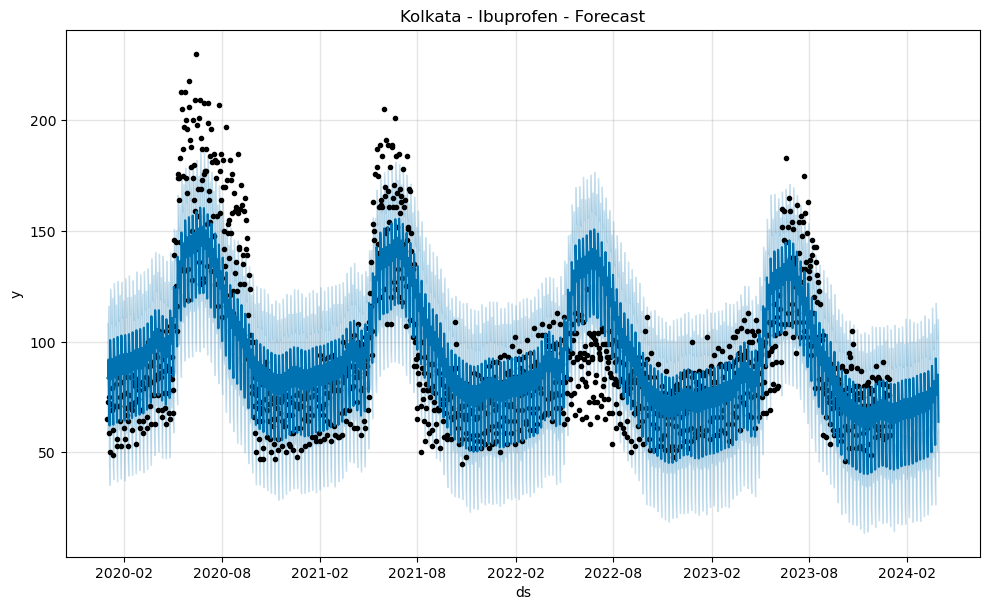

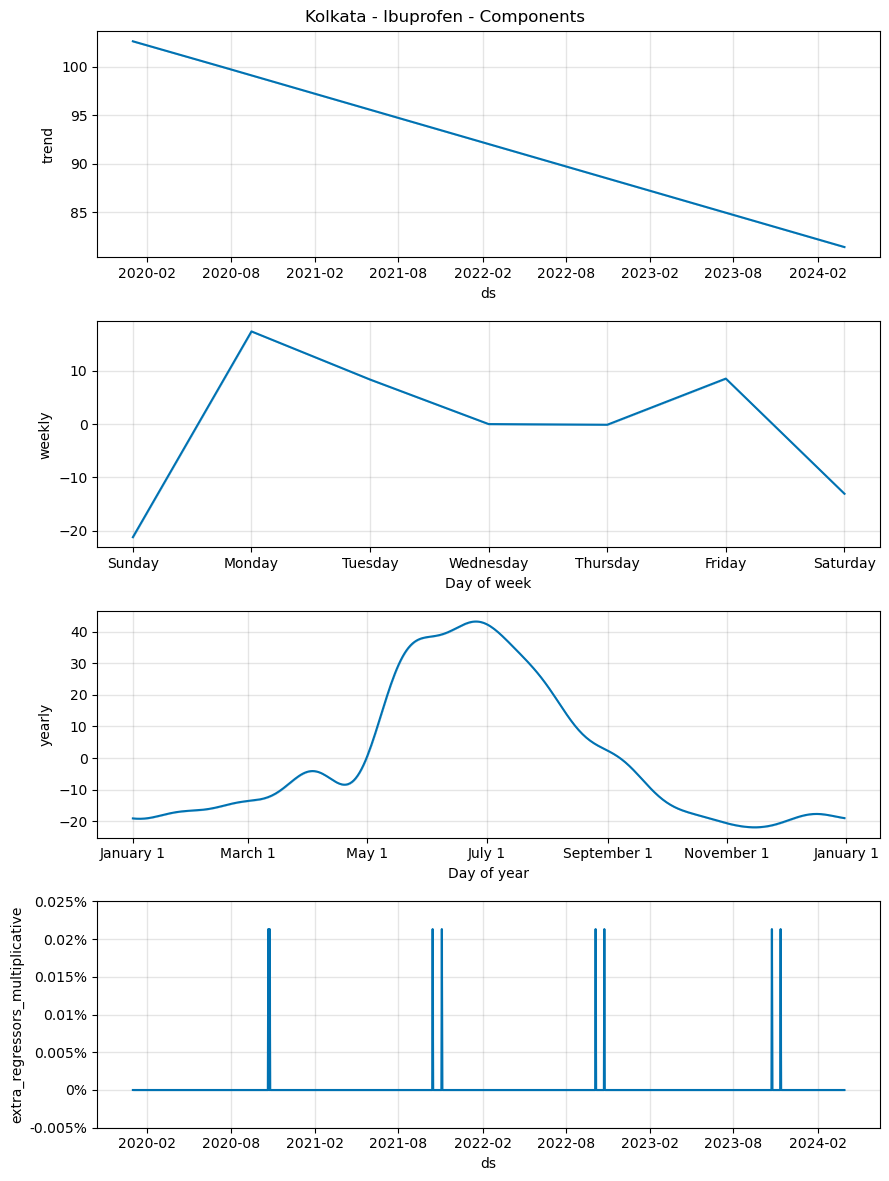

06:18:55 - cmdstanpy - INFO - Chain [1] start processing
06:18:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for amoxicillin in kolkata

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:55 - cmdstanpy - INFO - Chain [1] start processing
06:18:55 - cmdstanpy - INFO - Chain [1] done processing
06:18:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:18:55 - cmdstanpy - INFO - Chain [1] start processing
06:18:56 - cmdstanpy - INFO - Chain [1] done processing
06:18:56 - cmdstanpy - INFO - Chain [1] start processing
06:18:56 - cmdstanpy - INFO - Chain [1] done processing
06:18:56 - cmdstanpy - INFO - Chain [1] start processing
06:18:56 - cmdstanpy - INFO - Chain [1] done processing
06:18:56 - cmdstanpy - INFO - Chain [1] start processing
06:18:56 - cmdstanpy - INFO - Chain [1] done processing
06:18:56 - cmdstanpy - INFO - Chain [1] start processing
06:18:56 - cmdstanpy - INFO - Chain [1] done processing
06:18:56 - cmdstanpy - INFO - Chain [1] start processing
06:18:56 - cmdstanpy - INFO - Chain [1] done processing
06:18:56 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.02
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:18:58 - cmdstanpy - INFO - Chain [1] start processing
06:18:58 - cmdstanpy - INFO - Chain [1] done processing
06:18:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:18:58 - cmdstanpy - INFO - Chain [1] start processing
06:18:58 - cmdstanpy - INFO - Chain [1] done processing
06:18:58 - cmdstanpy - INFO - Chain [1] start processing
06:18:58 - cmdstanpy - INFO - Chain [1] done processing
06:18:58 - cmdstanpy - INFO - Chain [1] start processing
06:18:58 - cmdstanpy - INFO - Chain [1] done processing
06:18:58 - cmdstanpy - INFO - Chain [1] start processing
06:18:59 - cmdstanpy - INFO - Chain [1] done processing
06:18:59 - cmdstanpy - INFO - Chain [1] start processing
06:18:59 - cmdstanpy - INFO - Chain [1] done processing
06:18:59 - cmdstanpy - INFO - Chain [1] start processing
06:18:59 - cmdstanpy - INFO - Chain [1] done processing
06:18:59 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 18.16
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:00 - cmdstanpy - INFO - Chain [1] start processing
06:19:00 - cmdstanpy - INFO - Chain [1] done processing
06:19:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:19:00 - cmdstanpy - INFO - Chain [1] start processing
06:19:01 - cmdstanpy - INFO - Chain [1] done processing
06:19:01 - cmdstanpy - INFO - Chain [1] start processing
06:19:01 - cmdstanpy - INFO - Chain [1] done processing
06:19:01 - cmdstanpy - INFO - Chain [1] start processing
06:19:01 - cmdstanpy - INFO - Chain [1] done processing
06:19:01 - cmdstanpy - INFO - Chain [1] start processing
06:19:01 - cmdstanpy - INFO - Chain [1] done processing
06:19:01 - cmdstanpy - INFO - Chain [1] start processing
06:19:01 - cmdstanpy - INFO - Chain [1] done processing
06:19:01 - cmdstanpy - INFO - Chain [1] start processing
06:19:01 - cmdstanpy - INFO - Chain [1] done processing
06:19:01 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.12
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:03 - cmdstanpy - INFO - Chain [1] start processing
06:19:03 - cmdstanpy - INFO - Chain [1] done processing
06:19:03 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:19:03 - cmdstanpy - INFO - Chain [1] start processing
06:19:03 - cmdstanpy - INFO - Chain [1] done processing
06:19:03 - cmdstanpy - INFO - Chain [1] start processing
06:19:03 - cmdstanpy - INFO - Chain [1] done processing
06:19:03 - cmdstanpy - INFO - Chain [1] start processing
06:19:03 - cmdstanpy - INFO - Chain [1] done processing
06:19:03 - cmdstanpy - INFO - Chain [1] start processing
06:19:03 - cmdstanpy - INFO - Chain [1] done processing
06:19:03 - cmdstanpy - INFO - Chain [1] start processing
06:19:03 - cmdstanpy - INFO - Chain [1] done processing
06:19:04 - cmdstanpy - INFO - Chain [1] start processing
06:19:04 - cmdstanpy - INFO - Chain [1] done processing
06:19:04 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.39
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:05 - cmdstanpy - INFO - Chain [1] start processing
06:19:05 - cmdstanpy - INFO - Chain [1] done processing
06:19:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:19:05 - cmdstanpy - INFO - Chain [1] start processing
06:19:05 - cmdstanpy - INFO - Chain [1] done processing
06:19:05 - cmdstanpy - INFO - Chain [1] start processing
06:19:05 - cmdstanpy - INFO - Chain [1] done processing
06:19:05 - cmdstanpy - INFO - Chain [1] start processing
06:19:06 - cmdstanpy - INFO - Chain [1] done processing
06:19:06 - cmdstanpy - INFO - Chain [1] start processing
06:19:06 - cmdstanpy - INFO - Chain [1] done processing
06:19:06 - cmdstanpy - INFO - Chain [1] start processing
06:19:06 - cmdstanpy - INFO - Chain [1] done processing
06:19:06 - cmdstanpy - INFO - Chain [1] start processing
06:19:06 - cmdstanpy - INFO - Chain [1] done processing
06:19:06 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.20
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:07 - cmdstanpy - INFO - Chain [1] start processing
06:19:07 - cmdstanpy - INFO - Chain [1] done processing
06:19:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:19:07 - cmdstanpy - INFO - Chain [1] start processing
06:19:08 - cmdstanpy - INFO - Chain [1] done processing
06:19:08 - cmdstanpy - INFO - Chain [1] start processing
06:19:08 - cmdstanpy - INFO - Chain [1] done processing
06:19:08 - cmdstanpy - INFO - Chain [1] start processing
06:19:08 - cmdstanpy - INFO - Chain [1] done processing
06:19:08 - cmdstanpy - INFO - Chain [1] start processing
06:19:08 - cmdstanpy - INFO - Chain [1] done processing
06:19:08 - cmdstanpy - INFO - Chain [1] start processing
06:19:08 - cmdstanpy - INFO - Chain [1] done processing
06:19:08 - cmdstanpy - INFO - Chain [1] start processing
06:19:08 - cmdstanpy - INFO - Chain [1] done processing
06:19:09 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.98
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:10 - cmdstanpy - INFO - Chain [1] start processing
06:19:10 - cmdstanpy - INFO - Chain [1] done processing
06:19:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:19:10 - cmdstanpy - INFO - Chain [1] start processing
06:19:10 - cmdstanpy - INFO - Chain [1] done processing
06:19:10 - cmdstanpy - INFO - Chain [1] start processing
06:19:10 - cmdstanpy - INFO - Chain [1] done processing
06:19:10 - cmdstanpy - INFO - Chain [1] start processing
06:19:10 - cmdstanpy - INFO - Chain [1] done processing
06:19:10 - cmdstanpy - INFO - Chain [1] start processing
06:19:11 - cmdstanpy - INFO - Chain [1] done processing
06:19:11 - cmdstanpy - INFO - Chain [1] start processing
06:19:11 - cmdstanpy - INFO - Chain [1] done processing
06:19:11 - cmdstanpy - INFO - Chain [1] start processing
06:19:11 - cmdstanpy - INFO - Chain [1] done processing
06:19:11 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.64
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:12 - cmdstanpy - INFO - Chain [1] start processing
06:19:12 - cmdstanpy - INFO - Chain [1] done processing
06:19:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:19:12 - cmdstanpy - INFO - Chain [1] start processing
06:19:13 - cmdstanpy - INFO - Chain [1] done processing
06:19:13 - cmdstanpy - INFO - Chain [1] start processing
06:19:13 - cmdstanpy - INFO - Chain [1] done processing
06:19:13 - cmdstanpy - INFO - Chain [1] start processing
06:19:13 - cmdstanpy - INFO - Chain [1] done processing
06:19:13 - cmdstanpy - INFO - Chain [1] start processing
06:19:13 - cmdstanpy - INFO - Chain [1] done processing
06:19:13 - cmdstanpy - INFO - Chain [1] start processing
06:19:13 - cmdstanpy - INFO - Chain [1] done processing
06:19:13 - cmdstanpy - INFO - Chain [1] start processing
06:19:13 - cmdstanpy - INFO - Chain [1] done processing
06:19:13 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.04
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:15 - cmdstanpy - INFO - Chain [1] start processing
06:19:15 - cmdstanpy - INFO - Chain [1] done processing
06:19:15 - cmdstanpy - INFO - Chain [1] start processing
06:19:15 - cmdstanpy - INFO - Chain [1] done processing
06:19:15 - cmdstanpy - INFO - Chain [1] start processing
06:19:15 - cmdstanpy - INFO - Chain [1] done processing
06:19:15 - cmdstanpy - INFO - Chain [1] start processing
06:19:15 - cmdstanpy - INFO - Chain [1] done processing
06:19:15 - cmdstanpy - INFO - Chain [1] start processing
06:19:15 - cmdstanpy - INFO - Chain [1] done processing
06:19:15 - cmdstanpy - INFO - Chain [1] start processing
06:19:15 - cmdstanpy - INFO - Chain [1] done processing
06:19:16 - cmdstanpy - INFO - Chain [1] start processing
06:19:16 - cmdstanpy - INFO - Chain [1] done processing
06:19:16 - cmdstanpy - INFO - Chain [1] start processing
06:19:16 - cmdstanpy - INFO - Chain [1] done processing
06:19:16 - cmdstanpy - INFO - Chain [1] start processing
06:19:16 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.35
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:17 - cmdstanpy - INFO - Chain [1] start processing
06:19:17 - cmdstanpy - INFO - Chain [1] done processing
06:19:17 - cmdstanpy - INFO - Chain [1] start processing
06:19:17 - cmdstanpy - INFO - Chain [1] done processing
06:19:17 - cmdstanpy - INFO - Chain [1] start processing
06:19:17 - cmdstanpy - INFO - Chain [1] done processing
06:19:17 - cmdstanpy - INFO - Chain [1] start processing
06:19:17 - cmdstanpy - INFO - Chain [1] done processing
06:19:17 - cmdstanpy - INFO - Chain [1] start processing
06:19:17 - cmdstanpy - INFO - Chain [1] done processing
06:19:17 - cmdstanpy - INFO - Chain [1] start processing
06:19:18 - cmdstanpy - INFO - Chain [1] done processing
06:19:18 - cmdstanpy - INFO - Chain [1] start processing
06:19:18 - cmdstanpy - INFO - Chain [1] done processing
06:19:18 - cmdstanpy - INFO - Chain [1] start processing
06:19:18 - cmdstanpy - INFO - Chain [1] done processing
06:19:18 - cmdstanpy - INFO - Chain [1] start processing
06:19:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.13
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:19 - cmdstanpy - INFO - Chain [1] start processing
06:19:19 - cmdstanpy - INFO - Chain [1] done processing
06:19:19 - cmdstanpy - INFO - Chain [1] start processing
06:19:19 - cmdstanpy - INFO - Chain [1] done processing
06:19:19 - cmdstanpy - INFO - Chain [1] start processing
06:19:19 - cmdstanpy - INFO - Chain [1] done processing
06:19:19 - cmdstanpy - INFO - Chain [1] start processing
06:19:19 - cmdstanpy - INFO - Chain [1] done processing
06:19:19 - cmdstanpy - INFO - Chain [1] start processing
06:19:20 - cmdstanpy - INFO - Chain [1] done processing
06:19:20 - cmdstanpy - INFO - Chain [1] start processing
06:19:20 - cmdstanpy - INFO - Chain [1] done processing
06:19:20 - cmdstanpy - INFO - Chain [1] start processing
06:19:20 - cmdstanpy - INFO - Chain [1] done processing
06:19:20 - cmdstanpy - INFO - Chain [1] start processing
06:19:20 - cmdstanpy - INFO - Chain [1] done processing
06:19:20 - cmdstanpy - INFO - Chain [1] start processing
06:19:20 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.25
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:21 - cmdstanpy - INFO - Chain [1] start processing
06:19:21 - cmdstanpy - INFO - Chain [1] done processing
06:19:21 - cmdstanpy - INFO - Chain [1] start processing
06:19:21 - cmdstanpy - INFO - Chain [1] done processing
06:19:21 - cmdstanpy - INFO - Chain [1] start processing
06:19:22 - cmdstanpy - INFO - Chain [1] done processing
06:19:22 - cmdstanpy - INFO - Chain [1] start processing
06:19:22 - cmdstanpy - INFO - Chain [1] done processing
06:19:22 - cmdstanpy - INFO - Chain [1] start processing
06:19:22 - cmdstanpy - INFO - Chain [1] done processing
06:19:22 - cmdstanpy - INFO - Chain [1] start processing
06:19:22 - cmdstanpy - INFO - Chain [1] done processing
06:19:22 - cmdstanpy - INFO - Chain [1] start processing
06:19:22 - cmdstanpy - INFO - Chain [1] done processing
06:19:22 - cmdstanpy - INFO - Chain [1] start processing
06:19:22 - cmdstanpy - INFO - Chain [1] done processing
06:19:22 - cmdstanpy - INFO - Chain [1] start processing
06:19:22 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.96
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:23 - cmdstanpy - INFO - Chain [1] start processing
06:19:23 - cmdstanpy - INFO - Chain [1] done processing
06:19:24 - cmdstanpy - INFO - Chain [1] start processing
06:19:24 - cmdstanpy - INFO - Chain [1] done processing
06:19:24 - cmdstanpy - INFO - Chain [1] start processing
06:19:24 - cmdstanpy - INFO - Chain [1] done processing
06:19:24 - cmdstanpy - INFO - Chain [1] start processing
06:19:24 - cmdstanpy - INFO - Chain [1] done processing
06:19:24 - cmdstanpy - INFO - Chain [1] start processing
06:19:24 - cmdstanpy - INFO - Chain [1] done processing
06:19:24 - cmdstanpy - INFO - Chain [1] start processing
06:19:24 - cmdstanpy - INFO - Chain [1] done processing
06:19:24 - cmdstanpy - INFO - Chain [1] start processing
06:19:24 - cmdstanpy - INFO - Chain [1] done processing
06:19:24 - cmdstanpy - INFO - Chain [1] start processing
06:19:25 - cmdstanpy - INFO - Chain [1] done processing
06:19:25 - cmdstanpy - INFO - Chain [1] start processing
06:19:25 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.29
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:26 - cmdstanpy - INFO - Chain [1] start processing
06:19:26 - cmdstanpy - INFO - Chain [1] done processing
06:19:26 - cmdstanpy - INFO - Chain [1] start processing
06:19:26 - cmdstanpy - INFO - Chain [1] done processing
06:19:26 - cmdstanpy - INFO - Chain [1] start processing
06:19:26 - cmdstanpy - INFO - Chain [1] done processing
06:19:26 - cmdstanpy - INFO - Chain [1] start processing
06:19:26 - cmdstanpy - INFO - Chain [1] done processing
06:19:26 - cmdstanpy - INFO - Chain [1] start processing
06:19:26 - cmdstanpy - INFO - Chain [1] done processing
06:19:26 - cmdstanpy - INFO - Chain [1] start processing
06:19:26 - cmdstanpy - INFO - Chain [1] done processing
06:19:26 - cmdstanpy - INFO - Chain [1] start processing
06:19:27 - cmdstanpy - INFO - Chain [1] done processing
06:19:27 - cmdstanpy - INFO - Chain [1] start processing
06:19:27 - cmdstanpy - INFO - Chain [1] done processing
06:19:27 - cmdstanpy - INFO - Chain [1] start processing
06:19:27 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.96
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:28 - cmdstanpy - INFO - Chain [1] start processing
06:19:28 - cmdstanpy - INFO - Chain [1] done processing
06:19:28 - cmdstanpy - INFO - Chain [1] start processing
06:19:28 - cmdstanpy - INFO - Chain [1] done processing
06:19:28 - cmdstanpy - INFO - Chain [1] start processing
06:19:28 - cmdstanpy - INFO - Chain [1] done processing
06:19:28 - cmdstanpy - INFO - Chain [1] start processing
06:19:28 - cmdstanpy - INFO - Chain [1] done processing
06:19:28 - cmdstanpy - INFO - Chain [1] start processing
06:19:28 - cmdstanpy - INFO - Chain [1] done processing
06:19:29 - cmdstanpy - INFO - Chain [1] start processing
06:19:29 - cmdstanpy - INFO - Chain [1] done processing
06:19:29 - cmdstanpy - INFO - Chain [1] start processing
06:19:29 - cmdstanpy - INFO - Chain [1] done processing
06:19:29 - cmdstanpy - INFO - Chain [1] start processing
06:19:29 - cmdstanpy - INFO - Chain [1] done processing
06:19:29 - cmdstanpy - INFO - Chain [1] start processing
06:19:29 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.19
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:30 - cmdstanpy - INFO - Chain [1] start processing
06:19:30 - cmdstanpy - INFO - Chain [1] done processing
06:19:30 - cmdstanpy - INFO - Chain [1] start processing
06:19:30 - cmdstanpy - INFO - Chain [1] done processing
06:19:30 - cmdstanpy - INFO - Chain [1] start processing
06:19:30 - cmdstanpy - INFO - Chain [1] done processing
06:19:31 - cmdstanpy - INFO - Chain [1] start processing
06:19:31 - cmdstanpy - INFO - Chain [1] done processing
06:19:31 - cmdstanpy - INFO - Chain [1] start processing
06:19:31 - cmdstanpy - INFO - Chain [1] done processing
06:19:31 - cmdstanpy - INFO - Chain [1] start processing
06:19:31 - cmdstanpy - INFO - Chain [1] done processing
06:19:31 - cmdstanpy - INFO - Chain [1] start processing
06:19:31 - cmdstanpy - INFO - Chain [1] done processing
06:19:31 - cmdstanpy - INFO - Chain [1] start processing
06:19:31 - cmdstanpy - INFO - Chain [1] done processing
06:19:31 - cmdstanpy - INFO - Chain [1] start processing
06:19:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 25.05
---


06:19:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:32 - cmdstanpy - INFO - Chain [1] start processing
06:19:32 - cmdstanpy - INFO - Chain [1] done processing
06:19:33 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:33 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:33 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:33 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:33 - cmdstanpy - INFO - Chain [1] start processing
06:19:33 - cmdstanpy - INFO - Chain [1] done processing
06:19:34 - cmdstanpy - INFO - Chain [1] start processing
06:19:34 - cmdstanpy - INFO - Chain [1] done processing
06:19:34 - cmdstanpy - INFO - Chain [1] start processing
06:19:34 - cmdstanpy - INFO - Chain [1] done processing
06:19:34 - cmdstanpy - INFO - Chain [1] start processing
06:19:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.76
---


06:19:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:35 - cmdstanpy - INFO - Chain [1] start processing
06:19:35 - cmdstanpy - INFO - Chain [1] done processing
06:19:36 - cmdstanpy - INFO - Chain [1] start processing
06:19:36 - cmdstanpy - INFO - Chain [1] done processing
06:19:36 - cmdstanpy - INFO - Chain [1] start processing
06:19:36 - cmdstanpy - INFO - Chain [1] done processing
06:19:36 - cmdstanpy - INFO - Chain [1] start processing
06:19:36 - cmdstanpy - INFO - Chain [1] done processing
06:19:36 - cmdstanpy - INFO - Chain [1] start processing
06:19:36 - cmdstanpy - INFO - Chain [1] done processing
06:19:36 - cmdstanpy - INFO - Chain [1] start processing
06:19:36 - cmdstanpy - INFO - Chain [1] done processing
06:19:37 - cmdstanpy - INFO - Chain [1] start processing
06:19:37 - cmdstanpy - INFO - Chain [1] done processing
06:19:37 - cmdstanpy - INFO - Chain [1] start processing
06:19:37 - cmdstanpy - INFO - Chain [1] done processing
06:19:37 - cmdstanpy - INFO - Chain [1] start processing
06:19:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.12
---


06:19:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:38 - cmdstanpy - INFO - Chain [1] start processing
06:19:38 - cmdstanpy - INFO - Chain [1] done processing
06:19:38 - cmdstanpy - INFO - Chain [1] start processing
06:19:38 - cmdstanpy - INFO - Chain [1] done processing
06:19:39 - cmdstanpy - INFO - Chain [1] start processing
06:19:39 - cmdstanpy - INFO - Chain [1] done processing
06:19:39 - cmdstanpy - INFO - Chain [1] start processing
06:19:39 - cmdstanpy - INFO - Chain [1] done processing
06:19:39 - cmdstanpy - INFO - Chain [1] start processing
06:19:39 - cmdstanpy - INFO - Chain [1] done processing
06:19:39 - cmdstanpy - INFO - Chain [1] start processing
06:19:39 - cmdstanpy - INFO - Chain [1] done processing
06:19:39 - cmdstanpy - INFO - Chain [1] start processing
06:19:39 - cmdstanpy - INFO - Chain [1] done processing
06:19:39 - cmdstanpy - INFO - Chain [1] start processing
06:19:40 - cmdstanpy - INFO - Chain [1] done processing
06:19:40 - cmdstanpy - INFO - Chain [1] start processing
06:19:40 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.41
---


06:19:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:41 - cmdstanpy - INFO - Chain [1] start processing
06:19:41 - cmdstanpy - INFO - Chain [1] done processing
06:19:41 - cmdstanpy - INFO - Chain [1] start processing
06:19:41 - cmdstanpy - INFO - Chain [1] done processing
06:19:41 - cmdstanpy - INFO - Chain [1] start processing
06:19:41 - cmdstanpy - INFO - Chain [1] done processing
06:19:42 - cmdstanpy - INFO - Chain [1] start processing
06:19:42 - cmdstanpy - INFO - Chain [1] done processing
06:19:42 - cmdstanpy - INFO - Chain [1] start processing
06:19:42 - cmdstanpy - INFO - Chain [1] done processing
06:19:42 - cmdstanpy - INFO - Chain [1] start processing
06:19:42 - cmdstanpy - INFO - Chain [1] done processing
06:19:42 - cmdstanpy - INFO - Chain [1] start processing
06:19:42 - cmdstanpy - INFO - Chain [1] done processing
06:19:42 - cmdstanpy - INFO - Chain [1] start processing
06:19:42 - cmdstanpy - INFO - Chain [1] done processing
06:19:43 - cmdstanpy - INFO - Chain [1] start processing
06:19:43 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.90
---


06:19:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:44 - cmdstanpy - INFO - Chain [1] start processing
06:19:44 - cmdstanpy - INFO - Chain [1] done processing
06:19:44 - cmdstanpy - INFO - Chain [1] start processing
06:19:44 - cmdstanpy - INFO - Chain [1] done processing
06:19:44 - cmdstanpy - INFO - Chain [1] start processing
06:19:44 - cmdstanpy - INFO - Chain [1] done processing
06:19:44 - cmdstanpy - INFO - Chain [1] start processing
06:19:44 - cmdstanpy - INFO - Chain [1] done processing
06:19:44 - cmdstanpy - INFO - Chain [1] start processing
06:19:45 - cmdstanpy - INFO - Chain [1] done processing
06:19:45 - cmdstanpy - INFO - Chain [1] start processing
06:19:45 - cmdstanpy - INFO - Chain [1] done processing
06:19:45 - cmdstanpy - INFO - Chain [1] start processing
06:19:45 - cmdstanpy - INFO - Chain [1] done processing
06:19:45 - cmdstanpy - INFO - Chain [1] start processing
06:19:45 - cmdstanpy - INFO - Chain [1] done processing
06:19:45 - cmdstanpy - INFO - Chain [1] start processing
06:19:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.63
---


06:19:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:47 - cmdstanpy - INFO - Chain [1] start processing
06:19:47 - cmdstanpy - INFO - Chain [1] done processing
06:19:47 - cmdstanpy - INFO - Chain [1] start processing
06:19:47 - cmdstanpy - INFO - Chain [1] done processing
06:19:47 - cmdstanpy - INFO - Chain [1] start processing
06:19:47 - cmdstanpy - INFO - Chain [1] done processing
06:19:47 - cmdstanpy - INFO - Chain [1] start processing
06:19:47 - cmdstanpy - INFO - Chain [1] done processing
06:19:47 - cmdstanpy - INFO - Chain [1] start processing
06:19:47 - cmdstanpy - INFO - Chain [1] done processing
06:19:48 - cmdstanpy - INFO - Chain [1] start processing
06:19:48 - cmdstanpy - INFO - Chain [1] done processing
06:19:48 - cmdstanpy - INFO - Chain [1] start processing
06:19:48 - cmdstanpy - INFO - Chain [1] done processing
06:19:48 - cmdstanpy - INFO - Chain [1] start processing
06:19:48 - cmdstanpy - INFO - Chain [1] done processing
06:19:48 - cmdstanpy - INFO - Chain [1] start processing
06:19:48 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.49
---


06:19:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:49 - cmdstanpy - INFO - Chain [1] start processing
06:19:49 - cmdstanpy - INFO - Chain [1] done processing
06:19:50 - cmdstanpy - INFO - Chain [1] start processing
06:19:50 - cmdstanpy - INFO - Chain [1] done processing
06:19:50 - cmdstanpy - INFO - Chain [1] start processing
06:19:50 - cmdstanpy - INFO - Chain [1] done processing
06:19:50 - cmdstanpy - INFO - Chain [1] start processing
06:19:50 - cmdstanpy - INFO - Chain [1] done processing
06:19:50 - cmdstanpy - INFO - Chain [1] start processing
06:19:50 - cmdstanpy - INFO - Chain [1] done processing
06:19:50 - cmdstanpy - INFO - Chain [1] start processing
06:19:50 - cmdstanpy - INFO - Chain [1] done processing
06:19:50 - cmdstanpy - INFO - Chain [1] start processing
06:19:51 - cmdstanpy - INFO - Chain [1] done processing
06:19:51 - cmdstanpy - INFO - Chain [1] start processing
06:19:51 - cmdstanpy - INFO - Chain [1] done processing
06:19:51 - cmdstanpy - INFO - Chain [1] start processing
06:19:51 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.12
---


06:19:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:52 - cmdstanpy - INFO - Chain [1] start processing
06:19:52 - cmdstanpy - INFO - Chain [1] done processing
06:19:52 - cmdstanpy - INFO - Chain [1] start processing
06:19:52 - cmdstanpy - INFO - Chain [1] done processing
06:19:53 - cmdstanpy - INFO - Chain [1] start processing
06:19:53 - cmdstanpy - INFO - Chain [1] done processing
06:19:53 - cmdstanpy - INFO - Chain [1] start processing
06:19:53 - cmdstanpy - INFO - Chain [1] done processing
06:19:53 - cmdstanpy - INFO - Chain [1] start processing
06:19:53 - cmdstanpy - INFO - Chain [1] done processing
06:19:53 - cmdstanpy - INFO - Chain [1] start processing
06:19:53 - cmdstanpy - INFO - Chain [1] done processing
06:19:53 - cmdstanpy - INFO - Chain [1] start processing
06:19:53 - cmdstanpy - INFO - Chain [1] done processing
06:19:54 - cmdstanpy - INFO - Chain [1] start processing
06:19:54 - cmdstanpy - INFO - Chain [1] done processing
06:19:54 - cmdstanpy - INFO - Chain [1] start processing
06:19:54 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.59
---


06:19:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:55 - cmdstanpy - INFO - Chain [1] start processing
06:19:55 - cmdstanpy - INFO - Chain [1] done processing
06:19:55 - cmdstanpy - INFO - Chain [1] start processing
06:19:55 - cmdstanpy - INFO - Chain [1] done processing
06:19:56 - cmdstanpy - INFO - Chain [1] start processing
06:19:56 - cmdstanpy - INFO - Chain [1] done processing
06:19:56 - cmdstanpy - INFO - Chain [1] start processing
06:19:56 - cmdstanpy - INFO - Chain [1] done processing
06:19:56 - cmdstanpy - INFO - Chain [1] start processing
06:19:56 - cmdstanpy - INFO - Chain [1] done processing
06:19:56 - cmdstanpy - INFO - Chain [1] start processing
06:19:56 - cmdstanpy - INFO - Chain [1] done processing
06:19:57 - cmdstanpy - INFO - Chain [1] start processing
06:19:57 - cmdstanpy - INFO - Chain [1] done processing
06:19:57 - cmdstanpy - INFO - Chain [1] start processing
06:19:57 - cmdstanpy - INFO - Chain [1] done processing
06:19:57 - cmdstanpy - INFO - Chain [1] start processing
06:19:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.61
---


06:19:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:19:59 - cmdstanpy - INFO - Chain [1] start processing
06:19:59 - cmdstanpy - INFO - Chain [1] done processing
06:19:59 - cmdstanpy - INFO - Chain [1] start processing
06:19:59 - cmdstanpy - INFO - Chain [1] done processing
06:19:59 - cmdstanpy - INFO - Chain [1] start processing
06:19:59 - cmdstanpy - INFO - Chain [1] done processing
06:19:59 - cmdstanpy - INFO - Chain [1] start processing
06:19:59 - cmdstanpy - INFO - Chain [1] done processing
06:19:59 - cmdstanpy - INFO - Chain [1] start processing
06:19:59 - cmdstanpy - INFO - Chain [1] done processing
06:20:00 - cmdstanpy - INFO - Chain [1] start processing
06:20:00 - cmdstanpy - INFO - Chain [1] done processing
06:20:00 - cmdstanpy - INFO - Chain [1] start processing
06:20:00 - cmdstanpy - INFO - Chain [1] done processing
06:20:00 - cmdstanpy - INFO - Chain [1] start processing
06:20:00 - cmdstanpy - INFO - Chain [1] done processing
06:20:00 - cmdstanpy - INFO - Chain [1] start processing
06:20:01 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.82
---


06:20:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:02 - cmdstanpy - INFO - Chain [1] start processing
06:20:02 - cmdstanpy - INFO - Chain [1] done processing
06:20:02 - cmdstanpy - INFO - Chain [1] start processing
06:20:02 - cmdstanpy - INFO - Chain [1] done processing
06:20:02 - cmdstanpy - INFO - Chain [1] start processing
06:20:02 - cmdstanpy - INFO - Chain [1] done processing
06:20:03 - cmdstanpy - INFO - Chain [1] start processing
06:20:03 - cmdstanpy - INFO - Chain [1] done processing
06:20:03 - cmdstanpy - INFO - Chain [1] start processing
06:20:03 - cmdstanpy - INFO - Chain [1] done processing
06:20:03 - cmdstanpy - INFO - Chain [1] start processing
06:20:03 - cmdstanpy - INFO - Chain [1] done processing
06:20:03 - cmdstanpy - INFO - Chain [1] start processing
06:20:03 - cmdstanpy - INFO - Chain [1] done processing
06:20:04 - cmdstanpy - INFO - Chain [1] start processing
06:20:04 - cmdstanpy - INFO - Chain [1] done processing
06:20:04 - cmdstanpy - INFO - Chain [1] start processing
06:20:04 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.51
---


06:20:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:06 - cmdstanpy - INFO - Chain [1] start processing
06:20:06 - cmdstanpy - INFO - Chain [1] done processing
06:20:06 - cmdstanpy - INFO - Chain [1] start processing
06:20:06 - cmdstanpy - INFO - Chain [1] done processing
06:20:06 - cmdstanpy - INFO - Chain [1] start processing
06:20:06 - cmdstanpy - INFO - Chain [1] done processing
06:20:06 - cmdstanpy - INFO - Chain [1] start processing
06:20:06 - cmdstanpy - INFO - Chain [1] done processing
06:20:06 - cmdstanpy - INFO - Chain [1] start processing
06:20:06 - cmdstanpy - INFO - Chain [1] done processing
06:20:07 - cmdstanpy - INFO - Chain [1] start processing
06:20:07 - cmdstanpy - INFO - Chain [1] done processing
06:20:07 - cmdstanpy - INFO - Chain [1] start processing
06:20:07 - cmdstanpy - INFO - Chain [1] done processing
06:20:07 - cmdstanpy - INFO - Chain [1] start processing
06:20:07 - cmdstanpy - INFO - Chain [1] done processing
06:20:07 - cmdstanpy - INFO - Chain [1] start processing
06:20:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.80
---


06:20:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:09 - cmdstanpy - INFO - Chain [1] start processing
06:20:09 - cmdstanpy - INFO - Chain [1] done processing
06:20:09 - cmdstanpy - INFO - Chain [1] start processing
06:20:09 - cmdstanpy - INFO - Chain [1] done processing
06:20:09 - cmdstanpy - INFO - Chain [1] start processing
06:20:09 - cmdstanpy - INFO - Chain [1] done processing
06:20:09 - cmdstanpy - INFO - Chain [1] start processing
06:20:10 - cmdstanpy - INFO - Chain [1] done processing
06:20:10 - cmdstanpy - INFO - Chain [1] start processing
06:20:10 - cmdstanpy - INFO - Chain [1] done processing
06:20:10 - cmdstanpy - INFO - Chain [1] start processing
06:20:10 - cmdstanpy - INFO - Chain [1] done processing
06:20:10 - cmdstanpy - INFO - Chain [1] start processing
06:20:10 - cmdstanpy - INFO - Chain [1] done processing
06:20:10 - cmdstanpy - INFO - Chain [1] start processing
06:20:11 - cmdstanpy - INFO - Chain [1] done processing
06:20:11 - cmdstanpy - INFO - Chain [1] start processing
06:20:11 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.02
---


06:20:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:12 - cmdstanpy - INFO - Chain [1] start processing
06:20:12 - cmdstanpy - INFO - Chain [1] done processing
06:20:13 - cmdstanpy - INFO - Chain [1] start processing
06:20:13 - cmdstanpy - INFO - Chain [1] done processing
06:20:13 - cmdstanpy - INFO - Chain [1] start processing
06:20:13 - cmdstanpy - INFO - Chain [1] done processing
06:20:13 - cmdstanpy - INFO - Chain [1] start processing
06:20:13 - cmdstanpy - INFO - Chain [1] done processing
06:20:13 - cmdstanpy - INFO - Chain [1] start processing
06:20:13 - cmdstanpy - INFO - Chain [1] done processing
06:20:13 - cmdstanpy - INFO - Chain [1] start processing
06:20:13 - cmdstanpy - INFO - Chain [1] done processing
06:20:14 - cmdstanpy - INFO - Chain [1] start processing
06:20:14 - cmdstanpy - INFO - Chain [1] done processing
06:20:14 - cmdstanpy - INFO - Chain [1] start processing
06:20:14 - cmdstanpy - INFO - Chain [1] done processing
06:20:14 - cmdstanpy - INFO - Chain [1] start processing
06:20:14 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.97
---


06:20:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:16 - cmdstanpy - INFO - Chain [1] start processing
06:20:16 - cmdstanpy - INFO - Chain [1] done processing
06:20:16 - cmdstanpy - INFO - Chain [1] start processing
06:20:16 - cmdstanpy - INFO - Chain [1] done processing
06:20:16 - cmdstanpy - INFO - Chain [1] start processing
06:20:16 - cmdstanpy - INFO - Chain [1] done processing
06:20:16 - cmdstanpy - INFO - Chain [1] start processing
06:20:16 - cmdstanpy - INFO - Chain [1] done processing
06:20:16 - cmdstanpy - INFO - Chain [1] start processing
06:20:17 - cmdstanpy - INFO - Chain [1] done processing
06:20:17 - cmdstanpy - INFO - Chain [1] start processing
06:20:17 - cmdstanpy - INFO - Chain [1] done processing
06:20:17 - cmdstanpy - INFO - Chain [1] start processing
06:20:17 - cmdstanpy - INFO - Chain [1] done processing
06:20:17 - cmdstanpy - INFO - Chain [1] start processing
06:20:17 - cmdstanpy - INFO - Chain [1] done processing
06:20:18 - cmdstanpy - INFO - Chain [1] start processing
06:20:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.93
---


06:20:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:19 - cmdstanpy - INFO - Chain [1] start processing
06:20:19 - cmdstanpy - INFO - Chain [1] done processing
06:20:19 - cmdstanpy - INFO - Chain [1] start processing
06:20:19 - cmdstanpy - INFO - Chain [1] done processing
06:20:19 - cmdstanpy - INFO - Chain [1] start processing
06:20:20 - cmdstanpy - INFO - Chain [1] done processing
06:20:20 - cmdstanpy - INFO - Chain [1] start processing
06:20:20 - cmdstanpy - INFO - Chain [1] done processing
06:20:20 - cmdstanpy - INFO - Chain [1] start processing
06:20:20 - cmdstanpy - INFO - Chain [1] done processing
06:20:20 - cmdstanpy - INFO - Chain [1] start processing
06:20:20 - cmdstanpy - INFO - Chain [1] done processing
06:20:20 - cmdstanpy - INFO - Chain [1] start processing
06:20:20 - cmdstanpy - INFO - Chain [1] done processing
06:20:20 - cmdstanpy - INFO - Chain [1] start processing
06:20:21 - cmdstanpy - INFO - Chain [1] done processing
06:20:21 - cmdstanpy - INFO - Chain [1] start processing
06:20:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.77
---


06:20:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:23 - cmdstanpy - INFO - Chain [1] start processing
06:20:23 - cmdstanpy - INFO - Chain [1] done processing
06:20:23 - cmdstanpy - INFO - Chain [1] start processing
06:20:23 - cmdstanpy - INFO - Chain [1] done processing
06:20:23 - cmdstanpy - INFO - Chain [1] start processing
06:20:23 - cmdstanpy - INFO - Chain [1] done processing
06:20:23 - cmdstanpy - INFO - Chain [1] start processing
06:20:24 - cmdstanpy - INFO - Chain [1] done processing
06:20:24 - cmdstanpy - INFO - Chain [1] start processing
06:20:24 - cmdstanpy - INFO - Chain [1] done processing
06:20:24 - cmdstanpy - INFO - Chain [1] start processing
06:20:24 - cmdstanpy - INFO - Chain [1] done processing
06:20:24 - cmdstanpy - INFO - Chain [1] start processing
06:20:25 - cmdstanpy - INFO - Chain [1] done processing
06:20:25 - cmdstanpy - INFO - Chain [1] start processing
06:20:25 - cmdstanpy - INFO - Chain [1] done processing
06:20:25 - cmdstanpy - INFO - Chain [1] start processing
06:20:26 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.49
---


06:20:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:28 - cmdstanpy - INFO - Chain [1] start processing
06:20:28 - cmdstanpy - INFO - Chain [1] done processing
06:20:28 - cmdstanpy - INFO - Chain [1] start processing
06:20:29 - cmdstanpy - INFO - Chain [1] done processing
06:20:29 - cmdstanpy - INFO - Chain [1] start processing
06:20:29 - cmdstanpy - INFO - Chain [1] done processing
06:20:29 - cmdstanpy - INFO - Chain [1] start processing
06:20:29 - cmdstanpy - INFO - Chain [1] done processing
06:20:29 - cmdstanpy - INFO - Chain [1] start processing
06:20:29 - cmdstanpy - INFO - Chain [1] done processing
06:20:30 - cmdstanpy - INFO - Chain [1] start processing
06:20:30 - cmdstanpy - INFO - Chain [1] done processing
06:20:30 - cmdstanpy - INFO - Chain [1] start processing
06:20:30 - cmdstanpy - INFO - Chain [1] done processing
06:20:30 - cmdstanpy - INFO - Chain [1] start processing
06:20:31 - cmdstanpy - INFO - Chain [1] done processing
06:20:31 - cmdstanpy - INFO - Chain [1] start processing
06:20:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.28
---


06:20:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:33 - cmdstanpy - INFO - Chain [1] start processing
06:20:34 - cmdstanpy - INFO - Chain [1] done processing
06:20:34 - cmdstanpy - INFO - Chain [1] start processing
06:20:34 - cmdstanpy - INFO - Chain [1] done processing
06:20:34 - cmdstanpy - INFO - Chain [1] start processing
06:20:34 - cmdstanpy - INFO - Chain [1] done processing
06:20:34 - cmdstanpy - INFO - Chain [1] start processing
06:20:34 - cmdstanpy - INFO - Chain [1] done processing
06:20:35 - cmdstanpy - INFO - Chain [1] start processing
06:20:35 - cmdstanpy - INFO - Chain [1] done processing
06:20:35 - cmdstanpy - INFO - Chain [1] start processing
06:20:35 - cmdstanpy - INFO - Chain [1] done processing
06:20:35 - cmdstanpy - INFO - Chain [1] start processing
06:20:36 - cmdstanpy - INFO - Chain [1] done processing
06:20:36 - cmdstanpy - INFO - Chain [1] start processing
06:20:36 - cmdstanpy - INFO - Chain [1] done processing
06:20:36 - cmdstanpy - INFO - Chain [1] start processing
06:20:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.41
---


06:20:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:39 - cmdstanpy - INFO - Chain [1] start processing
06:20:39 - cmdstanpy - INFO - Chain [1] done processing
06:20:39 - cmdstanpy - INFO - Chain [1] start processing
06:20:39 - cmdstanpy - INFO - Chain [1] done processing
06:20:39 - cmdstanpy - INFO - Chain [1] start processing
06:20:40 - cmdstanpy - INFO - Chain [1] done processing
06:20:40 - cmdstanpy - INFO - Chain [1] start processing
06:20:40 - cmdstanpy - INFO - Chain [1] done processing
06:20:40 - cmdstanpy - INFO - Chain [1] start processing
06:20:40 - cmdstanpy - INFO - Chain [1] done processing
06:20:40 - cmdstanpy - INFO - Chain [1] start processing
06:20:40 - cmdstanpy - INFO - Chain [1] done processing
06:20:40 - cmdstanpy - INFO - Chain [1] start processing
06:20:41 - cmdstanpy - INFO - Chain [1] done processing
06:20:41 - cmdstanpy - INFO - Chain [1] start processing
06:20:41 - cmdstanpy - INFO - Chain [1] done processing
06:20:41 - cmdstanpy - INFO - Chain [1] start processing
06:20:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 28.74
---


06:20:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:44 - cmdstanpy - INFO - Chain [1] start processing
06:20:44 - cmdstanpy - INFO - Chain [1] done processing
06:20:44 - cmdstanpy - INFO - Chain [1] start processing
06:20:45 - cmdstanpy - INFO - Chain [1] done processing
06:20:45 - cmdstanpy - INFO - Chain [1] start processing
06:20:45 - cmdstanpy - INFO - Chain [1] done processing
06:20:45 - cmdstanpy - INFO - Chain [1] start processing
06:20:45 - cmdstanpy - INFO - Chain [1] done processing
06:20:45 - cmdstanpy - INFO - Chain [1] start processing
06:20:46 - cmdstanpy - INFO - Chain [1] done processing
06:20:46 - cmdstanpy - INFO - Chain [1] start processing
06:20:46 - cmdstanpy - INFO - Chain [1] done processing
06:20:46 - cmdstanpy - INFO - Chain [1] start processing
06:20:46 - cmdstanpy - INFO - Chain [1] done processing
06:20:47 - cmdstanpy - INFO - Chain [1] start processing
06:20:47 - cmdstanpy - INFO - Chain [1] done processing
06:20:47 - cmdstanpy - INFO - Chain [1] start processing
06:20:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.14
---


06:20:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:50 - cmdstanpy - INFO - Chain [1] start processing
06:20:50 - cmdstanpy - INFO - Chain [1] done processing
06:20:50 - cmdstanpy - INFO - Chain [1] start processing
06:20:50 - cmdstanpy - INFO - Chain [1] done processing
06:20:50 - cmdstanpy - INFO - Chain [1] start processing
06:20:50 - cmdstanpy - INFO - Chain [1] done processing
06:20:50 - cmdstanpy - INFO - Chain [1] start processing
06:20:51 - cmdstanpy - INFO - Chain [1] done processing
06:20:51 - cmdstanpy - INFO - Chain [1] start processing
06:20:51 - cmdstanpy - INFO - Chain [1] done processing
06:20:51 - cmdstanpy - INFO - Chain [1] start processing
06:20:51 - cmdstanpy - INFO - Chain [1] done processing
06:20:51 - cmdstanpy - INFO - Chain [1] start processing
06:20:52 - cmdstanpy - INFO - Chain [1] done processing
06:20:52 - cmdstanpy - INFO - Chain [1] start processing
06:20:52 - cmdstanpy - INFO - Chain [1] done processing
06:20:52 - cmdstanpy - INFO - Chain [1] start processing
06:20:53 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.24
---


06:20:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:20:55 - cmdstanpy - INFO - Chain [1] start processing
06:20:55 - cmdstanpy - INFO - Chain [1] done processing
06:20:55 - cmdstanpy - INFO - Chain [1] start processing
06:20:55 - cmdstanpy - INFO - Chain [1] done processing
06:20:55 - cmdstanpy - INFO - Chain [1] start processing
06:20:56 - cmdstanpy - INFO - Chain [1] done processing
06:20:56 - cmdstanpy - INFO - Chain [1] start processing
06:20:56 - cmdstanpy - INFO - Chain [1] done processing
06:20:56 - cmdstanpy - INFO - Chain [1] start processing
06:20:56 - cmdstanpy - INFO - Chain [1] done processing
06:20:56 - cmdstanpy - INFO - Chain [1] start processing
06:20:57 - cmdstanpy - INFO - Chain [1] done processing
06:20:57 - cmdstanpy - INFO - Chain [1] start processing
06:20:57 - cmdstanpy - INFO - Chain [1] done processing
06:20:57 - cmdstanpy - INFO - Chain [1] start processing
06:20:58 - cmdstanpy - INFO - Chain [1] done processing
06:20:58 - cmdstanpy - INFO - Chain [1] start processing
06:20:58 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.14
---


06:21:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:01 - cmdstanpy - INFO - Chain [1] start processing
06:21:01 - cmdstanpy - INFO - Chain [1] done processing
06:21:01 - cmdstanpy - INFO - Chain [1] start processing
06:21:01 - cmdstanpy - INFO - Chain [1] done processing
06:21:01 - cmdstanpy - INFO - Chain [1] start processing
06:21:01 - cmdstanpy - INFO - Chain [1] done processing
06:21:01 - cmdstanpy - INFO - Chain [1] start processing
06:21:01 - cmdstanpy - INFO - Chain [1] done processing
06:21:01 - cmdstanpy - INFO - Chain [1] start processing
06:21:01 - cmdstanpy - INFO - Chain [1] done processing
06:21:02 - cmdstanpy - INFO - Chain [1] start processing
06:21:02 - cmdstanpy - INFO - Chain [1] done processing
06:21:02 - cmdstanpy - INFO - Chain [1] start processing
06:21:02 - cmdstanpy - INFO - Chain [1] done processing
06:21:02 - cmdstanpy - INFO - Chain [1] start processing
06:21:03 - cmdstanpy - INFO - Chain [1] done processing
06:21:03 - cmdstanpy - INFO - Chain [1] start processing
06:21:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.07
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 18.16

Training final model...


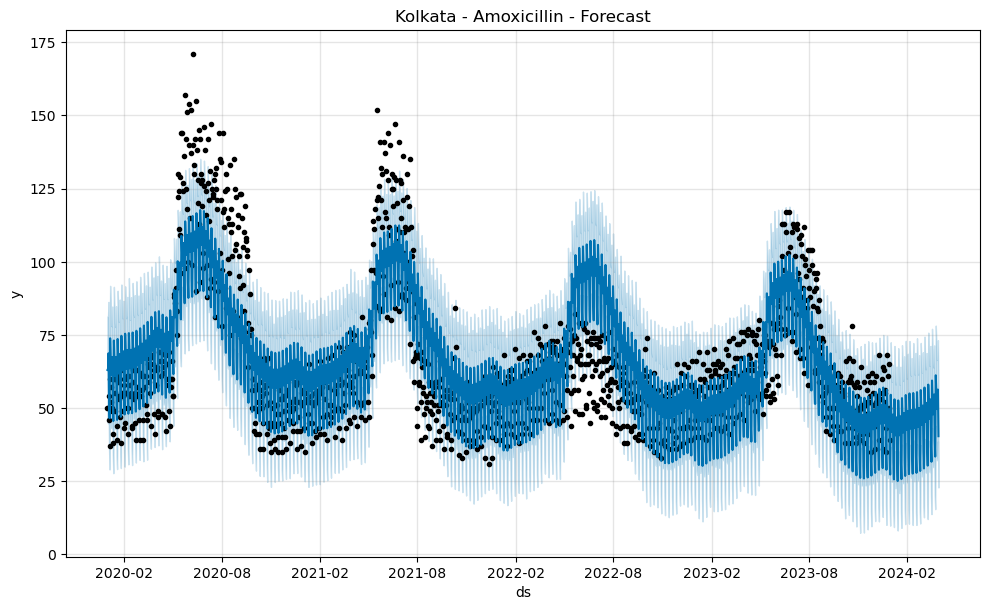

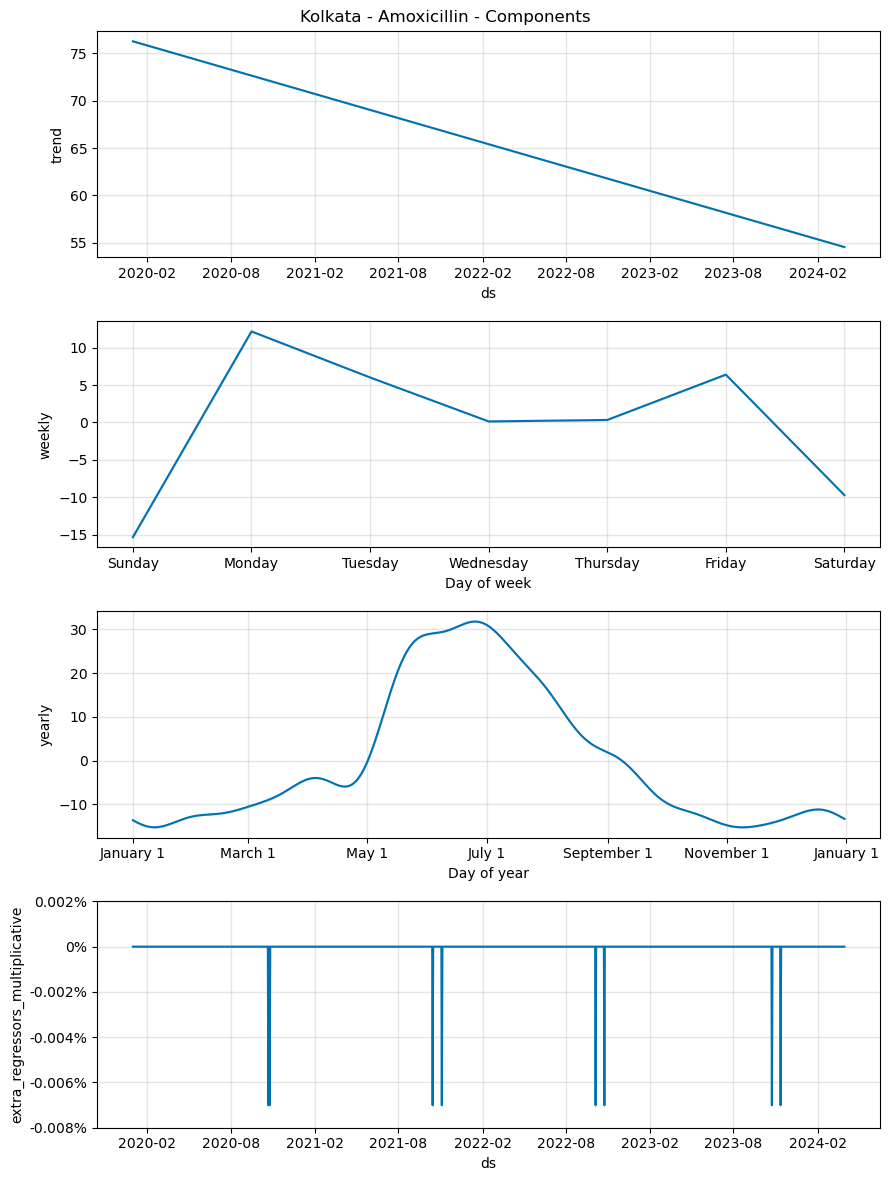

06:21:06 - cmdstanpy - INFO - Chain [1] start processing
06:21:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for loperamide in kolkata

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:06 - cmdstanpy - INFO - Chain [1] start processing
06:21:06 - cmdstanpy - INFO - Chain [1] done processing
06:21:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:21:06 - cmdstanpy - INFO - Chain [1] start processing
06:21:06 - cmdstanpy - INFO - Chain [1] done processing
06:21:06 - cmdstanpy - INFO - Chain [1] start processing
06:21:06 - cmdstanpy - INFO - Chain [1] done processing
06:21:07 - cmdstanpy - INFO - Chain [1] start processing
06:21:07 - cmdstanpy - INFO - Chain [1] done processing
06:21:07 - cmdstanpy - INFO - Chain [1] start processing
06:21:07 - cmdstanpy - INFO - Chain [1] done processing
06:21:07 - cmdstanpy - INFO - Chain [1] start processing
06:21:07 - cmdstanpy - INFO - Chain [1] done processing
06:21:07 - cmdstanpy - INFO - Chain [1] start processing
06:21:07 - cmdstanpy - INFO - Chain [1] done processing
06:21:07 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 27.76
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:08 - cmdstanpy - INFO - Chain [1] start processing
06:21:08 - cmdstanpy - INFO - Chain [1] done processing
06:21:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:21:08 - cmdstanpy - INFO - Chain [1] start processing
06:21:09 - cmdstanpy - INFO - Chain [1] done processing
06:21:09 - cmdstanpy - INFO - Chain [1] start processing
06:21:09 - cmdstanpy - INFO - Chain [1] done processing
06:21:09 - cmdstanpy - INFO - Chain [1] start processing
06:21:09 - cmdstanpy - INFO - Chain [1] done processing
06:21:09 - cmdstanpy - INFO - Chain [1] start processing
06:21:09 - cmdstanpy - INFO - Chain [1] done processing
06:21:09 - cmdstanpy - INFO - Chain [1] start processing
06:21:09 - cmdstanpy - INFO - Chain [1] done processing
06:21:10 - cmdstanpy - INFO - Chain [1] start processing
06:21:10 - cmdstanpy - INFO - Chain [1] done processing
06:21:10 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.37
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:11 - cmdstanpy - INFO - Chain [1] start processing
06:21:11 - cmdstanpy - INFO - Chain [1] done processing
06:21:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:21:11 - cmdstanpy - INFO - Chain [1] start processing
06:21:11 - cmdstanpy - INFO - Chain [1] done processing
06:21:11 - cmdstanpy - INFO - Chain [1] start processing
06:21:11 - cmdstanpy - INFO - Chain [1] done processing
06:21:11 - cmdstanpy - INFO - Chain [1] start processing
06:21:12 - cmdstanpy - INFO - Chain [1] done processing
06:21:12 - cmdstanpy - INFO - Chain [1] start processing
06:21:12 - cmdstanpy - INFO - Chain [1] done processing
06:21:12 - cmdstanpy - INFO - Chain [1] start processing
06:21:12 - cmdstanpy - INFO - Chain [1] done processing
06:21:12 - cmdstanpy - INFO - Chain [1] start processing
06:21:12 - cmdstanpy - INFO - Chain [1] done processing
06:21:12 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.07
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:13 - cmdstanpy - INFO - Chain [1] start processing
06:21:13 - cmdstanpy - INFO - Chain [1] done processing
06:21:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:21:13 - cmdstanpy - INFO - Chain [1] start processing
06:21:14 - cmdstanpy - INFO - Chain [1] done processing
06:21:14 - cmdstanpy - INFO - Chain [1] start processing
06:21:14 - cmdstanpy - INFO - Chain [1] done processing
06:21:14 - cmdstanpy - INFO - Chain [1] start processing
06:21:14 - cmdstanpy - INFO - Chain [1] done processing
06:21:14 - cmdstanpy - INFO - Chain [1] start processing
06:21:14 - cmdstanpy - INFO - Chain [1] done processing
06:21:14 - cmdstanpy - INFO - Chain [1] start processing
06:21:14 - cmdstanpy - INFO - Chain [1] done processing
06:21:14 - cmdstanpy - INFO - Chain [1] start processing
06:21:14 - cmdstanpy - INFO - Chain [1] done processing
06:21:14 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.83
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:16 - cmdstanpy - INFO - Chain [1] start processing
06:21:16 - cmdstanpy - INFO - Chain [1] done processing
06:21:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:21:16 - cmdstanpy - INFO - Chain [1] start processing
06:21:16 - cmdstanpy - INFO - Chain [1] done processing
06:21:16 - cmdstanpy - INFO - Chain [1] start processing
06:21:16 - cmdstanpy - INFO - Chain [1] done processing
06:21:16 - cmdstanpy - INFO - Chain [1] start processing
06:21:16 - cmdstanpy - INFO - Chain [1] done processing
06:21:16 - cmdstanpy - INFO - Chain [1] start processing
06:21:16 - cmdstanpy - INFO - Chain [1] done processing
06:21:16 - cmdstanpy - INFO - Chain [1] start processing
06:21:16 - cmdstanpy - INFO - Chain [1] done processing
06:21:17 - cmdstanpy - INFO - Chain [1] start processing
06:21:17 - cmdstanpy - INFO - Chain [1] done processing
06:21:17 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.84
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:18 - cmdstanpy - INFO - Chain [1] start processing
06:21:18 - cmdstanpy - INFO - Chain [1] done processing
06:21:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:21:18 - cmdstanpy - INFO - Chain [1] start processing
06:21:18 - cmdstanpy - INFO - Chain [1] done processing
06:21:18 - cmdstanpy - INFO - Chain [1] start processing
06:21:18 - cmdstanpy - INFO - Chain [1] done processing
06:21:19 - cmdstanpy - INFO - Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing
06:21:19 - cmdstanpy - INFO - Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing
06:21:19 - cmdstanpy - INFO - Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing
06:21:19 - cmdstanpy - INFO - Chain [1] start processing
06:21:19 - cmdstanpy - INFO - Chain [1] done processing
06:21:19 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.50
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:20 - cmdstanpy - INFO - Chain [1] start processing
06:21:20 - cmdstanpy - INFO - Chain [1] done processing
06:21:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:21:20 - cmdstanpy - INFO - Chain [1] start processing
06:21:21 - cmdstanpy - INFO - Chain [1] done processing
06:21:21 - cmdstanpy - INFO - Chain [1] start processing
06:21:21 - cmdstanpy - INFO - Chain [1] done processing
06:21:21 - cmdstanpy - INFO - Chain [1] start processing
06:21:21 - cmdstanpy - INFO - Chain [1] done processing
06:21:21 - cmdstanpy - INFO - Chain [1] start processing
06:21:21 - cmdstanpy - INFO - Chain [1] done processing
06:21:22 - cmdstanpy - INFO - Chain [1] start processing
06:21:22 - cmdstanpy - INFO - Chain [1] done processing
06:21:22 - cmdstanpy - INFO - Chain [1] start processing
06:21:22 - cmdstanpy - INFO - Chain [1] done processing
06:21:22 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.61
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:23 - cmdstanpy - INFO - Chain [1] start processing
06:21:23 - cmdstanpy - INFO - Chain [1] done processing
06:21:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:21:23 - cmdstanpy - INFO - Chain [1] start processing
06:21:23 - cmdstanpy - INFO - Chain [1] done processing
06:21:23 - cmdstanpy - INFO - Chain [1] start processing
06:21:24 - cmdstanpy - INFO - Chain [1] done processing
06:21:24 - cmdstanpy - INFO - Chain [1] start processing
06:21:24 - cmdstanpy - INFO - Chain [1] done processing
06:21:24 - cmdstanpy - INFO - Chain [1] start processing
06:21:24 - cmdstanpy - INFO - Chain [1] done processing
06:21:24 - cmdstanpy - INFO - Chain [1] start processing
06:21:24 - cmdstanpy - INFO - Chain [1] done processing
06:21:24 - cmdstanpy - INFO - Chain [1] start processing
06:21:24 - cmdstanpy - INFO - Chain [1] done processing
06:21:24 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.52
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:25 - cmdstanpy - INFO - Chain [1] start processing
06:21:25 - cmdstanpy - INFO - Chain [1] done processing
06:21:26 - cmdstanpy - INFO - Chain [1] start processing
06:21:26 - cmdstanpy - INFO - Chain [1] done processing
06:21:26 - cmdstanpy - INFO - Chain [1] start processing
06:21:26 - cmdstanpy - INFO - Chain [1] done processing
06:21:26 - cmdstanpy - INFO - Chain [1] start processing
06:21:26 - cmdstanpy - INFO - Chain [1] done processing
06:21:26 - cmdstanpy - INFO - Chain [1] start processing
06:21:26 - cmdstanpy - INFO - Chain [1] done processing
06:21:26 - cmdstanpy - INFO - Chain [1] start processing
06:21:26 - cmdstanpy - INFO - Chain [1] done processing
06:21:26 - cmdstanpy - INFO - Chain [1] start processing
06:21:26 - cmdstanpy - INFO - Chain [1] done processing
06:21:26 - cmdstanpy - INFO - Chain [1] start processing
06:21:27 - cmdstanpy - INFO - Chain [1] done processing
06:21:27 - cmdstanpy - INFO - Chain [1] start processing
06:21:27 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.22
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:28 - cmdstanpy - INFO - Chain [1] start processing
06:21:28 - cmdstanpy - INFO - Chain [1] done processing
06:21:28 - cmdstanpy - INFO - Chain [1] start processing
06:21:28 - cmdstanpy - INFO - Chain [1] done processing
06:21:28 - cmdstanpy - INFO - Chain [1] start processing
06:21:28 - cmdstanpy - INFO - Chain [1] done processing
06:21:28 - cmdstanpy - INFO - Chain [1] start processing
06:21:28 - cmdstanpy - INFO - Chain [1] done processing
06:21:28 - cmdstanpy - INFO - Chain [1] start processing
06:21:28 - cmdstanpy - INFO - Chain [1] done processing
06:21:28 - cmdstanpy - INFO - Chain [1] start processing
06:21:28 - cmdstanpy - INFO - Chain [1] done processing
06:21:28 - cmdstanpy - INFO - Chain [1] start processing
06:21:29 - cmdstanpy - INFO - Chain [1] done processing
06:21:29 - cmdstanpy - INFO - Chain [1] start processing
06:21:29 - cmdstanpy - INFO - Chain [1] done processing
06:21:29 - cmdstanpy - INFO - Chain [1] start processing
06:21:29 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 23.44
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:30 - cmdstanpy - INFO - Chain [1] start processing
06:21:30 - cmdstanpy - INFO - Chain [1] done processing
06:21:30 - cmdstanpy - INFO - Chain [1] start processing
06:21:30 - cmdstanpy - INFO - Chain [1] done processing
06:21:30 - cmdstanpy - INFO - Chain [1] start processing
06:21:30 - cmdstanpy - INFO - Chain [1] done processing
06:21:30 - cmdstanpy - INFO - Chain [1] start processing
06:21:30 - cmdstanpy - INFO - Chain [1] done processing
06:21:30 - cmdstanpy - INFO - Chain [1] start processing
06:21:31 - cmdstanpy - INFO - Chain [1] done processing
06:21:31 - cmdstanpy - INFO - Chain [1] start processing
06:21:31 - cmdstanpy - INFO - Chain [1] done processing
06:21:31 - cmdstanpy - INFO - Chain [1] start processing
06:21:31 - cmdstanpy - INFO - Chain [1] done processing
06:21:31 - cmdstanpy - INFO - Chain [1] start processing
06:21:31 - cmdstanpy - INFO - Chain [1] done processing
06:21:31 - cmdstanpy - INFO - Chain [1] start processing
06:21:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.76
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:32 - cmdstanpy - INFO - Chain [1] start processing
06:21:32 - cmdstanpy - INFO - Chain [1] done processing
06:21:32 - cmdstanpy - INFO - Chain [1] start processing
06:21:32 - cmdstanpy - INFO - Chain [1] done processing
06:21:32 - cmdstanpy - INFO - Chain [1] start processing
06:21:32 - cmdstanpy - INFO - Chain [1] done processing
06:21:33 - cmdstanpy - INFO - Chain [1] start processing
06:21:33 - cmdstanpy - INFO - Chain [1] done processing
06:21:33 - cmdstanpy - INFO - Chain [1] start processing
06:21:33 - cmdstanpy - INFO - Chain [1] done processing
06:21:33 - cmdstanpy - INFO - Chain [1] start processing
06:21:33 - cmdstanpy - INFO - Chain [1] done processing
06:21:33 - cmdstanpy - INFO - Chain [1] start processing
06:21:33 - cmdstanpy - INFO - Chain [1] done processing
06:21:33 - cmdstanpy - INFO - Chain [1] start processing
06:21:33 - cmdstanpy - INFO - Chain [1] done processing
06:21:33 - cmdstanpy - INFO - Chain [1] start processing
06:21:33 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.34
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:34 - cmdstanpy - INFO - Chain [1] start processing
06:21:34 - cmdstanpy - INFO - Chain [1] done processing
06:21:34 - cmdstanpy - INFO - Chain [1] start processing
06:21:35 - cmdstanpy - INFO - Chain [1] done processing
06:21:35 - cmdstanpy - INFO - Chain [1] start processing
06:21:35 - cmdstanpy - INFO - Chain [1] done processing
06:21:35 - cmdstanpy - INFO - Chain [1] start processing
06:21:35 - cmdstanpy - INFO - Chain [1] done processing
06:21:35 - cmdstanpy - INFO - Chain [1] start processing
06:21:35 - cmdstanpy - INFO - Chain [1] done processing
06:21:35 - cmdstanpy - INFO - Chain [1] start processing
06:21:35 - cmdstanpy - INFO - Chain [1] done processing
06:21:35 - cmdstanpy - INFO - Chain [1] start processing
06:21:35 - cmdstanpy - INFO - Chain [1] done processing
06:21:35 - cmdstanpy - INFO - Chain [1] start processing
06:21:36 - cmdstanpy - INFO - Chain [1] done processing
06:21:36 - cmdstanpy - INFO - Chain [1] start processing
06:21:36 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.73
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:37 - cmdstanpy - INFO - Chain [1] start processing
06:21:37 - cmdstanpy - INFO - Chain [1] done processing
06:21:37 - cmdstanpy - INFO - Chain [1] start processing
06:21:37 - cmdstanpy - INFO - Chain [1] done processing
06:21:37 - cmdstanpy - INFO - Chain [1] start processing
06:21:37 - cmdstanpy - INFO - Chain [1] done processing
06:21:37 - cmdstanpy - INFO - Chain [1] start processing
06:21:37 - cmdstanpy - INFO - Chain [1] done processing
06:21:37 - cmdstanpy - INFO - Chain [1] start processing
06:21:37 - cmdstanpy - INFO - Chain [1] done processing
06:21:37 - cmdstanpy - INFO - Chain [1] start processing
06:21:37 - cmdstanpy - INFO - Chain [1] done processing
06:21:37 - cmdstanpy - INFO - Chain [1] start processing
06:21:37 - cmdstanpy - INFO - Chain [1] done processing
06:21:38 - cmdstanpy - INFO - Chain [1] start processing
06:21:38 - cmdstanpy - INFO - Chain [1] done processing
06:21:38 - cmdstanpy - INFO - Chain [1] start processing
06:21:38 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.14
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:39 - cmdstanpy - INFO - Chain [1] start processing
06:21:39 - cmdstanpy - INFO - Chain [1] done processing
06:21:39 - cmdstanpy - INFO - Chain [1] start processing
06:21:39 - cmdstanpy - INFO - Chain [1] done processing
06:21:39 - cmdstanpy - INFO - Chain [1] start processing
06:21:39 - cmdstanpy - INFO - Chain [1] done processing
06:21:39 - cmdstanpy - INFO - Chain [1] start processing
06:21:39 - cmdstanpy - INFO - Chain [1] done processing
06:21:39 - cmdstanpy - INFO - Chain [1] start processing
06:21:39 - cmdstanpy - INFO - Chain [1] done processing
06:21:39 - cmdstanpy - INFO - Chain [1] start processing
06:21:40 - cmdstanpy - INFO - Chain [1] done processing
06:21:40 - cmdstanpy - INFO - Chain [1] start processing
06:21:40 - cmdstanpy - INFO - Chain [1] done processing
06:21:40 - cmdstanpy - INFO - Chain [1] start processing
06:21:40 - cmdstanpy - INFO - Chain [1] done processing
06:21:40 - cmdstanpy - INFO - Chain [1] start processing
06:21:40 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.72
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:41 - cmdstanpy - INFO - Chain [1] start processing
06:21:41 - cmdstanpy - INFO - Chain [1] done processing
06:21:41 - cmdstanpy - INFO - Chain [1] start processing
06:21:41 - cmdstanpy - INFO - Chain [1] done processing
06:21:41 - cmdstanpy - INFO - Chain [1] start processing
06:21:41 - cmdstanpy - INFO - Chain [1] done processing
06:21:41 - cmdstanpy - INFO - Chain [1] start processing
06:21:41 - cmdstanpy - INFO - Chain [1] done processing
06:21:42 - cmdstanpy - INFO - Chain [1] start processing
06:21:42 - cmdstanpy - INFO - Chain [1] done processing
06:21:42 - cmdstanpy - INFO - Chain [1] start processing
06:21:42 - cmdstanpy - INFO - Chain [1] done processing
06:21:42 - cmdstanpy - INFO - Chain [1] start processing
06:21:42 - cmdstanpy - INFO - Chain [1] done processing
06:21:42 - cmdstanpy - INFO - Chain [1] start processing
06:21:42 - cmdstanpy - INFO - Chain [1] done processing
06:21:42 - cmdstanpy - INFO - Chain [1] start processing
06:21:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 26.29
---


06:21:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:43 - cmdstanpy - INFO - Chain [1] start processing
06:21:43 - cmdstanpy - INFO - Chain [1] done processing
06:21:43 - cmdstanpy - INFO - Chain [1] start processing
06:21:43 - cmdstanpy - INFO - Chain [1] done processing
06:21:44 - cmdstanpy - INFO - Chain [1] start processing
06:21:44 - cmdstanpy - INFO - Chain [1] done processing
06:21:44 - cmdstanpy - INFO - Chain [1] start processing
06:21:44 - cmdstanpy - INFO - Chain [1] done processing
06:21:44 - cmdstanpy - INFO - Chain [1] start processing
06:21:44 - cmdstanpy - INFO - Chain [1] done processing
06:21:44 - cmdstanpy - INFO - Chain [1] start processing
06:21:44 - cmdstanpy - INFO - Chain [1] done processing
06:21:44 - cmdstanpy - INFO - Chain [1] start processing
06:21:44 - cmdstanpy - INFO - Chain [1] done processing
06:21:45 - cmdstanpy - INFO - Chain [1] start processing
06:21:45 - cmdstanpy - INFO - Chain [1] done processing
06:21:45 - cmdstanpy - INFO - Chain [1] start processing
06:21:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.99
---


06:21:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:46 - cmdstanpy - INFO - Chain [1] start processing
06:21:46 - cmdstanpy - INFO - Chain [1] done processing
06:21:46 - cmdstanpy - INFO - Chain [1] start processing
06:21:46 - cmdstanpy - INFO - Chain [1] done processing
06:21:47 - cmdstanpy - INFO - Chain [1] start processing
06:21:47 - cmdstanpy - INFO - Chain [1] done processing
06:21:47 - cmdstanpy - INFO - Chain [1] start processing
06:21:47 - cmdstanpy - INFO - Chain [1] done processing
06:21:47 - cmdstanpy - INFO - Chain [1] start processing
06:21:47 - cmdstanpy - INFO - Chain [1] done processing
06:21:47 - cmdstanpy - INFO - Chain [1] start processing
06:21:47 - cmdstanpy - INFO - Chain [1] done processing
06:21:47 - cmdstanpy - INFO - Chain [1] start processing
06:21:47 - cmdstanpy - INFO - Chain [1] done processing
06:21:47 - cmdstanpy - INFO - Chain [1] start processing
06:21:48 - cmdstanpy - INFO - Chain [1] done processing
06:21:48 - cmdstanpy - INFO - Chain [1] start processing
06:21:48 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.71
---


06:21:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:49 - cmdstanpy - INFO - Chain [1] start processing
06:21:49 - cmdstanpy - INFO - Chain [1] done processing
06:21:49 - cmdstanpy - INFO - Chain [1] start processing
06:21:49 - cmdstanpy - INFO - Chain [1] done processing
06:21:49 - cmdstanpy - INFO - Chain [1] start processing
06:21:49 - cmdstanpy - INFO - Chain [1] done processing
06:21:49 - cmdstanpy - INFO - Chain [1] start processing
06:21:49 - cmdstanpy - INFO - Chain [1] done processing
06:21:50 - cmdstanpy - INFO - Chain [1] start processing
06:21:50 - cmdstanpy - INFO - Chain [1] done processing
06:21:50 - cmdstanpy - INFO - Chain [1] start processing
06:21:50 - cmdstanpy - INFO - Chain [1] done processing
06:21:50 - cmdstanpy - INFO - Chain [1] start processing
06:21:50 - cmdstanpy - INFO - Chain [1] done processing
06:21:50 - cmdstanpy - INFO - Chain [1] start processing
06:21:50 - cmdstanpy - INFO - Chain [1] done processing
06:21:50 - cmdstanpy - INFO - Chain [1] start processing
06:21:50 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.36
---


06:21:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:52 - cmdstanpy - INFO - Chain [1] start processing
06:21:52 - cmdstanpy - INFO - Chain [1] done processing
06:21:52 - cmdstanpy - INFO - Chain [1] start processing
06:21:52 - cmdstanpy - INFO - Chain [1] done processing
06:21:52 - cmdstanpy - INFO - Chain [1] start processing
06:21:52 - cmdstanpy - INFO - Chain [1] done processing
06:21:52 - cmdstanpy - INFO - Chain [1] start processing
06:21:52 - cmdstanpy - INFO - Chain [1] done processing
06:21:52 - cmdstanpy - INFO - Chain [1] start processing
06:21:52 - cmdstanpy - INFO - Chain [1] done processing
06:21:52 - cmdstanpy - INFO - Chain [1] start processing
06:21:53 - cmdstanpy - INFO - Chain [1] done processing
06:21:53 - cmdstanpy - INFO - Chain [1] start processing
06:21:53 - cmdstanpy - INFO - Chain [1] done processing
06:21:53 - cmdstanpy - INFO - Chain [1] start processing
06:21:53 - cmdstanpy - INFO - Chain [1] done processing
06:21:53 - cmdstanpy - INFO - Chain [1] start processing
06:21:53 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.30
---


06:21:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:54 - cmdstanpy - INFO - Chain [1] start processing
06:21:54 - cmdstanpy - INFO - Chain [1] done processing
06:21:55 - cmdstanpy - INFO - Chain [1] start processing
06:21:55 - cmdstanpy - INFO - Chain [1] done processing
06:21:55 - cmdstanpy - INFO - Chain [1] start processing
06:21:55 - cmdstanpy - INFO - Chain [1] done processing
06:21:55 - cmdstanpy - INFO - Chain [1] start processing
06:21:55 - cmdstanpy - INFO - Chain [1] done processing
06:21:55 - cmdstanpy - INFO - Chain [1] start processing
06:21:55 - cmdstanpy - INFO - Chain [1] done processing
06:21:55 - cmdstanpy - INFO - Chain [1] start processing
06:21:55 - cmdstanpy - INFO - Chain [1] done processing
06:21:55 - cmdstanpy - INFO - Chain [1] start processing
06:21:55 - cmdstanpy - INFO - Chain [1] done processing
06:21:56 - cmdstanpy - INFO - Chain [1] start processing
06:21:56 - cmdstanpy - INFO - Chain [1] done processing
06:21:56 - cmdstanpy - INFO - Chain [1] start processing
06:21:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.77
---


06:21:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:21:57 - cmdstanpy - INFO - Chain [1] start processing
06:21:57 - cmdstanpy - INFO - Chain [1] done processing
06:21:57 - cmdstanpy - INFO - Chain [1] start processing
06:21:57 - cmdstanpy - INFO - Chain [1] done processing
06:21:57 - cmdstanpy - INFO - Chain [1] start processing
06:21:58 - cmdstanpy - INFO - Chain [1] done processing
06:21:58 - cmdstanpy - INFO - Chain [1] start processing
06:21:58 - cmdstanpy - INFO - Chain [1] done processing
06:21:58 - cmdstanpy - INFO - Chain [1] start processing
06:21:58 - cmdstanpy - INFO - Chain [1] done processing
06:21:58 - cmdstanpy - INFO - Chain [1] start processing
06:21:58 - cmdstanpy - INFO - Chain [1] done processing
06:21:58 - cmdstanpy - INFO - Chain [1] start processing
06:21:58 - cmdstanpy - INFO - Chain [1] done processing
06:21:58 - cmdstanpy - INFO - Chain [1] start processing
06:21:59 - cmdstanpy - INFO - Chain [1] done processing
06:21:59 - cmdstanpy - INFO - Chain [1] start processing
06:21:59 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.54
---


06:22:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:00 - cmdstanpy - INFO - Chain [1] start processing
06:22:00 - cmdstanpy - INFO - Chain [1] done processing
06:22:00 - cmdstanpy - INFO - Chain [1] start processing
06:22:00 - cmdstanpy - INFO - Chain [1] done processing
06:22:00 - cmdstanpy - INFO - Chain [1] start processing
06:22:00 - cmdstanpy - INFO - Chain [1] done processing
06:22:00 - cmdstanpy - INFO - Chain [1] start processing
06:22:00 - cmdstanpy - INFO - Chain [1] done processing
06:22:01 - cmdstanpy - INFO - Chain [1] start processing
06:22:01 - cmdstanpy - INFO - Chain [1] done processing
06:22:01 - cmdstanpy - INFO - Chain [1] start processing
06:22:01 - cmdstanpy - INFO - Chain [1] done processing
06:22:01 - cmdstanpy - INFO - Chain [1] start processing
06:22:01 - cmdstanpy - INFO - Chain [1] done processing
06:22:01 - cmdstanpy - INFO - Chain [1] start processing
06:22:01 - cmdstanpy - INFO - Chain [1] done processing
06:22:01 - cmdstanpy - INFO - Chain [1] start processing
06:22:02 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.17
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:03 - cmdstanpy - INFO - Chain [1] start processing
06:22:03 - cmdstanpy - INFO - Chain [1] done processing
06:22:03 - cmdstanpy - INFO - Chain [1] start processing
06:22:03 - cmdstanpy - INFO - Chain [1] done processing
06:22:03 - cmdstanpy - INFO - Chain [1] start processing
06:22:03 - cmdstanpy - INFO - Chain [1] done processing
06:22:03 - cmdstanpy - INFO - Chain [1] start processing
06:22:03 - cmdstanpy - INFO - Chain [1] done processing
06:22:03 - cmdstanpy - INFO - Chain [1] start processing
06:22:03 - cmdstanpy - INFO - Chain [1] done processing
06:22:03 - cmdstanpy - INFO - Chain [1] start processing
06:22:04 - cmdstanpy - INFO - Chain [1] done processing
06:22:04 - cmdstanpy - INFO - Chain [1] start processing
06:22:04 - cmdstanpy - INFO - Chain [1] done processing
06:22:04 - cmdstanpy - INFO - Chain [1] start processing
06:22:04 - cmdstanpy - INFO - Chain [1] done processing
06:22:04 - cmdstanpy - INFO - Chain [1] start processing
06:22:04 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.57
---


06:22:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:06 - cmdstanpy - INFO - Chain [1] start processing
06:22:06 - cmdstanpy - INFO - Chain [1] done processing
06:22:06 - cmdstanpy - INFO - Chain [1] start processing
06:22:06 - cmdstanpy - INFO - Chain [1] done processing
06:22:06 - cmdstanpy - INFO - Chain [1] start processing
06:22:06 - cmdstanpy - INFO - Chain [1] done processing
06:22:06 - cmdstanpy - INFO - Chain [1] start processing
06:22:06 - cmdstanpy - INFO - Chain [1] done processing
06:22:06 - cmdstanpy - INFO - Chain [1] start processing
06:22:06 - cmdstanpy - INFO - Chain [1] done processing
06:22:07 - cmdstanpy - INFO - Chain [1] start processing
06:22:07 - cmdstanpy - INFO - Chain [1] done processing
06:22:07 - cmdstanpy - INFO - Chain [1] start processing
06:22:07 - cmdstanpy - INFO - Chain [1] done processing
06:22:07 - cmdstanpy - INFO - Chain [1] start processing
06:22:07 - cmdstanpy - INFO - Chain [1] done processing
06:22:07 - cmdstanpy - INFO - Chain [1] start processing
06:22:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.12
---


06:22:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:09 - cmdstanpy - INFO - Chain [1] start processing
06:22:09 - cmdstanpy - INFO - Chain [1] done processing
06:22:09 - cmdstanpy - INFO - Chain [1] start processing
06:22:10 - cmdstanpy - INFO - Chain [1] done processing
06:22:10 - cmdstanpy - INFO - Chain [1] start processing
06:22:10 - cmdstanpy - INFO - Chain [1] done processing
06:22:10 - cmdstanpy - INFO - Chain [1] start processing
06:22:10 - cmdstanpy - INFO - Chain [1] done processing
06:22:10 - cmdstanpy - INFO - Chain [1] start processing
06:22:10 - cmdstanpy - INFO - Chain [1] done processing
06:22:10 - cmdstanpy - INFO - Chain [1] start processing
06:22:10 - cmdstanpy - INFO - Chain [1] done processing
06:22:10 - cmdstanpy - INFO - Chain [1] start processing
06:22:11 - cmdstanpy - INFO - Chain [1] done processing
06:22:11 - cmdstanpy - INFO - Chain [1] start processing
06:22:11 - cmdstanpy - INFO - Chain [1] done processing
06:22:11 - cmdstanpy - INFO - Chain [1] start processing
06:22:11 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.98
---


06:22:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:13 - cmdstanpy - INFO - Chain [1] start processing
06:22:13 - cmdstanpy - INFO - Chain [1] done processing
06:22:13 - cmdstanpy - INFO - Chain [1] start processing
06:22:13 - cmdstanpy - INFO - Chain [1] done processing
06:22:13 - cmdstanpy - INFO - Chain [1] start processing
06:22:13 - cmdstanpy - INFO - Chain [1] done processing
06:22:13 - cmdstanpy - INFO - Chain [1] start processing
06:22:13 - cmdstanpy - INFO - Chain [1] done processing
06:22:13 - cmdstanpy - INFO - Chain [1] start processing
06:22:13 - cmdstanpy - INFO - Chain [1] done processing
06:22:13 - cmdstanpy - INFO - Chain [1] start processing
06:22:14 - cmdstanpy - INFO - Chain [1] done processing
06:22:14 - cmdstanpy - INFO - Chain [1] start processing
06:22:14 - cmdstanpy - INFO - Chain [1] done processing
06:22:14 - cmdstanpy - INFO - Chain [1] start processing
06:22:14 - cmdstanpy - INFO - Chain [1] done processing
06:22:14 - cmdstanpy - INFO - Chain [1] start processing
06:22:14 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 27.80
---


06:22:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:16 - cmdstanpy - INFO - Chain [1] start processing
06:22:16 - cmdstanpy - INFO - Chain [1] done processing
06:22:16 - cmdstanpy - INFO - Chain [1] start processing
06:22:16 - cmdstanpy - INFO - Chain [1] done processing
06:22:16 - cmdstanpy - INFO - Chain [1] start processing
06:22:16 - cmdstanpy - INFO - Chain [1] done processing
06:22:16 - cmdstanpy - INFO - Chain [1] start processing
06:22:16 - cmdstanpy - INFO - Chain [1] done processing
06:22:16 - cmdstanpy - INFO - Chain [1] start processing
06:22:16 - cmdstanpy - INFO - Chain [1] done processing
06:22:17 - cmdstanpy - INFO - Chain [1] start processing
06:22:17 - cmdstanpy - INFO - Chain [1] done processing
06:22:17 - cmdstanpy - INFO - Chain [1] start processing
06:22:17 - cmdstanpy - INFO - Chain [1] done processing
06:22:17 - cmdstanpy - INFO - Chain [1] start processing
06:22:17 - cmdstanpy - INFO - Chain [1] done processing
06:22:17 - cmdstanpy - INFO - Chain [1] start processing
06:22:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.23
---


06:22:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:19 - cmdstanpy - INFO - Chain [1] start processing
06:22:19 - cmdstanpy - INFO - Chain [1] done processing
06:22:19 - cmdstanpy - INFO - Chain [1] start processing
06:22:19 - cmdstanpy - INFO - Chain [1] done processing
06:22:19 - cmdstanpy - INFO - Chain [1] start processing
06:22:19 - cmdstanpy - INFO - Chain [1] done processing
06:22:20 - cmdstanpy - INFO - Chain [1] start processing
06:22:20 - cmdstanpy - INFO - Chain [1] done processing
06:22:20 - cmdstanpy - INFO - Chain [1] start processing
06:22:20 - cmdstanpy - INFO - Chain [1] done processing
06:22:20 - cmdstanpy - INFO - Chain [1] start processing
06:22:20 - cmdstanpy - INFO - Chain [1] done processing
06:22:20 - cmdstanpy - INFO - Chain [1] start processing
06:22:20 - cmdstanpy - INFO - Chain [1] done processing
06:22:20 - cmdstanpy - INFO - Chain [1] start processing
06:22:21 - cmdstanpy - INFO - Chain [1] done processing
06:22:21 - cmdstanpy - INFO - Chain [1] start processing
06:22:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 27.61
---


06:22:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:22 - cmdstanpy - INFO - Chain [1] start processing
06:22:22 - cmdstanpy - INFO - Chain [1] done processing
06:22:22 - cmdstanpy - INFO - Chain [1] start processing
06:22:22 - cmdstanpy - INFO - Chain [1] done processing
06:22:23 - cmdstanpy - INFO - Chain [1] start processing
06:22:23 - cmdstanpy - INFO - Chain [1] done processing
06:22:23 - cmdstanpy - INFO - Chain [1] start processing
06:22:23 - cmdstanpy - INFO - Chain [1] done processing
06:22:23 - cmdstanpy - INFO - Chain [1] start processing
06:22:23 - cmdstanpy - INFO - Chain [1] done processing
06:22:23 - cmdstanpy - INFO - Chain [1] start processing
06:22:23 - cmdstanpy - INFO - Chain [1] done processing
06:22:23 - cmdstanpy - INFO - Chain [1] start processing
06:22:24 - cmdstanpy - INFO - Chain [1] done processing
06:22:24 - cmdstanpy - INFO - Chain [1] start processing
06:22:24 - cmdstanpy - INFO - Chain [1] done processing
06:22:24 - cmdstanpy - INFO - Chain [1] start processing
06:22:24 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.44
---


06:22:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:26 - cmdstanpy - INFO - Chain [1] start processing
06:22:26 - cmdstanpy - INFO - Chain [1] done processing
06:22:26 - cmdstanpy - INFO - Chain [1] start processing
06:22:26 - cmdstanpy - INFO - Chain [1] done processing
06:22:26 - cmdstanpy - INFO - Chain [1] start processing
06:22:26 - cmdstanpy - INFO - Chain [1] done processing
06:22:26 - cmdstanpy - INFO - Chain [1] start processing
06:22:26 - cmdstanpy - INFO - Chain [1] done processing
06:22:26 - cmdstanpy - INFO - Chain [1] start processing
06:22:26 - cmdstanpy - INFO - Chain [1] done processing
06:22:27 - cmdstanpy - INFO - Chain [1] start processing
06:22:27 - cmdstanpy - INFO - Chain [1] done processing
06:22:27 - cmdstanpy - INFO - Chain [1] start processing
06:22:27 - cmdstanpy - INFO - Chain [1] done processing
06:22:27 - cmdstanpy - INFO - Chain [1] start processing
06:22:27 - cmdstanpy - INFO - Chain [1] done processing
06:22:27 - cmdstanpy - INFO - Chain [1] start processing
06:22:28 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 27.56
---


06:22:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:29 - cmdstanpy - INFO - Chain [1] start processing
06:22:29 - cmdstanpy - INFO - Chain [1] done processing
06:22:29 - cmdstanpy - INFO - Chain [1] start processing
06:22:29 - cmdstanpy - INFO - Chain [1] done processing
06:22:29 - cmdstanpy - INFO - Chain [1] start processing
06:22:29 - cmdstanpy - INFO - Chain [1] done processing
06:22:30 - cmdstanpy - INFO - Chain [1] start processing
06:22:30 - cmdstanpy - INFO - Chain [1] done processing
06:22:30 - cmdstanpy - INFO - Chain [1] start processing
06:22:30 - cmdstanpy - INFO - Chain [1] done processing
06:22:30 - cmdstanpy - INFO - Chain [1] start processing
06:22:30 - cmdstanpy - INFO - Chain [1] done processing
06:22:30 - cmdstanpy - INFO - Chain [1] start processing
06:22:30 - cmdstanpy - INFO - Chain [1] done processing
06:22:30 - cmdstanpy - INFO - Chain [1] start processing
06:22:31 - cmdstanpy - INFO - Chain [1] done processing
06:22:31 - cmdstanpy - INFO - Chain [1] start processing
06:22:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.10
---


06:22:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:33 - cmdstanpy - INFO - Chain [1] start processing
06:22:33 - cmdstanpy - INFO - Chain [1] done processing
06:22:33 - cmdstanpy - INFO - Chain [1] start processing
06:22:33 - cmdstanpy - INFO - Chain [1] done processing
06:22:33 - cmdstanpy - INFO - Chain [1] start processing
06:22:33 - cmdstanpy - INFO - Chain [1] done processing
06:22:34 - cmdstanpy - INFO - Chain [1] start processing
06:22:34 - cmdstanpy - INFO - Chain [1] done processing
06:22:34 - cmdstanpy - INFO - Chain [1] start processing
06:22:34 - cmdstanpy - INFO - Chain [1] done processing
06:22:34 - cmdstanpy - INFO - Chain [1] start processing
06:22:34 - cmdstanpy - INFO - Chain [1] done processing
06:22:35 - cmdstanpy - INFO - Chain [1] start processing
06:22:35 - cmdstanpy - INFO - Chain [1] done processing
06:22:35 - cmdstanpy - INFO - Chain [1] start processing
06:22:35 - cmdstanpy - INFO - Chain [1] done processing
06:22:36 - cmdstanpy - INFO - Chain [1] start processing
06:22:36 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.76
---


06:22:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:38 - cmdstanpy - INFO - Chain [1] start processing
06:22:38 - cmdstanpy - INFO - Chain [1] done processing
06:22:39 - cmdstanpy - INFO - Chain [1] start processing
06:22:39 - cmdstanpy - INFO - Chain [1] done processing
06:22:39 - cmdstanpy - INFO - Chain [1] start processing
06:22:39 - cmdstanpy - INFO - Chain [1] done processing
06:22:39 - cmdstanpy - INFO - Chain [1] start processing
06:22:39 - cmdstanpy - INFO - Chain [1] done processing
06:22:39 - cmdstanpy - INFO - Chain [1] start processing
06:22:39 - cmdstanpy - INFO - Chain [1] done processing
06:22:40 - cmdstanpy - INFO - Chain [1] start processing
06:22:40 - cmdstanpy - INFO - Chain [1] done processing
06:22:40 - cmdstanpy - INFO - Chain [1] start processing
06:22:40 - cmdstanpy - INFO - Chain [1] done processing
06:22:40 - cmdstanpy - INFO - Chain [1] start processing
06:22:41 - cmdstanpy - INFO - Chain [1] done processing
06:22:41 - cmdstanpy - INFO - Chain [1] start processing
06:22:41 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.15
---


06:22:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:44 - cmdstanpy - INFO - Chain [1] start processing
06:22:44 - cmdstanpy - INFO - Chain [1] done processing
06:22:44 - cmdstanpy - INFO - Chain [1] start processing
06:22:44 - cmdstanpy - INFO - Chain [1] done processing
06:22:44 - cmdstanpy - INFO - Chain [1] start processing
06:22:44 - cmdstanpy - INFO - Chain [1] done processing
06:22:44 - cmdstanpy - INFO - Chain [1] start processing
06:22:45 - cmdstanpy - INFO - Chain [1] done processing
06:22:45 - cmdstanpy - INFO - Chain [1] start processing
06:22:45 - cmdstanpy - INFO - Chain [1] done processing
06:22:45 - cmdstanpy - INFO - Chain [1] start processing
06:22:45 - cmdstanpy - INFO - Chain [1] done processing
06:22:45 - cmdstanpy - INFO - Chain [1] start processing
06:22:46 - cmdstanpy - INFO - Chain [1] done processing
06:22:46 - cmdstanpy - INFO - Chain [1] start processing
06:22:46 - cmdstanpy - INFO - Chain [1] done processing
06:22:46 - cmdstanpy - INFO - Chain [1] start processing
06:22:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.92
---


06:22:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:49 - cmdstanpy - INFO - Chain [1] start processing
06:22:49 - cmdstanpy - INFO - Chain [1] done processing
06:22:49 - cmdstanpy - INFO - Chain [1] start processing
06:22:49 - cmdstanpy - INFO - Chain [1] done processing
06:22:50 - cmdstanpy - INFO - Chain [1] start processing
06:22:50 - cmdstanpy - INFO - Chain [1] done processing
06:22:50 - cmdstanpy - INFO - Chain [1] start processing
06:22:50 - cmdstanpy - INFO - Chain [1] done processing
06:22:50 - cmdstanpy - INFO - Chain [1] start processing
06:22:50 - cmdstanpy - INFO - Chain [1] done processing
06:22:50 - cmdstanpy - INFO - Chain [1] start processing
06:22:50 - cmdstanpy - INFO - Chain [1] done processing
06:22:51 - cmdstanpy - INFO - Chain [1] start processing
06:22:51 - cmdstanpy - INFO - Chain [1] done processing
06:22:51 - cmdstanpy - INFO - Chain [1] start processing
06:22:51 - cmdstanpy - INFO - Chain [1] done processing
06:22:51 - cmdstanpy - INFO - Chain [1] start processing
06:22:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.72
---


06:22:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:22:54 - cmdstanpy - INFO - Chain [1] start processing
06:22:54 - cmdstanpy - INFO - Chain [1] done processing
06:22:54 - cmdstanpy - INFO - Chain [1] start processing
06:22:55 - cmdstanpy - INFO - Chain [1] done processing
06:22:55 - cmdstanpy - INFO - Chain [1] start processing
06:22:55 - cmdstanpy - INFO - Chain [1] done processing
06:22:55 - cmdstanpy - INFO - Chain [1] start processing
06:22:55 - cmdstanpy - INFO - Chain [1] done processing
06:22:55 - cmdstanpy - INFO - Chain [1] start processing
06:22:55 - cmdstanpy - INFO - Chain [1] done processing
06:22:56 - cmdstanpy - INFO - Chain [1] start processing
06:22:56 - cmdstanpy - INFO - Chain [1] done processing
06:22:56 - cmdstanpy - INFO - Chain [1] start processing
06:22:56 - cmdstanpy - INFO - Chain [1] done processing
06:22:56 - cmdstanpy - INFO - Chain [1] start processing
06:22:57 - cmdstanpy - INFO - Chain [1] done processing
06:22:57 - cmdstanpy - INFO - Chain [1] start processing
06:22:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.81
---


06:23:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:00 - cmdstanpy - INFO - Chain [1] start processing
06:23:00 - cmdstanpy - INFO - Chain [1] done processing
06:23:00 - cmdstanpy - INFO - Chain [1] start processing
06:23:00 - cmdstanpy - INFO - Chain [1] done processing
06:23:00 - cmdstanpy - INFO - Chain [1] start processing
06:23:00 - cmdstanpy - INFO - Chain [1] done processing
06:23:00 - cmdstanpy - INFO - Chain [1] start processing
06:23:00 - cmdstanpy - INFO - Chain [1] done processing
06:23:00 - cmdstanpy - INFO - Chain [1] start processing
06:23:01 - cmdstanpy - INFO - Chain [1] done processing
06:23:01 - cmdstanpy - INFO - Chain [1] start processing
06:23:01 - cmdstanpy - INFO - Chain [1] done processing
06:23:01 - cmdstanpy - INFO - Chain [1] start processing
06:23:01 - cmdstanpy - INFO - Chain [1] done processing
06:23:01 - cmdstanpy - INFO - Chain [1] start processing
06:23:02 - cmdstanpy - INFO - Chain [1] done processing
06:23:02 - cmdstanpy - INFO - Chain [1] start processing
06:23:02 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.21
---


06:23:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:05 - cmdstanpy - INFO - Chain [1] start processing
06:23:05 - cmdstanpy - INFO - Chain [1] done processing
06:23:05 - cmdstanpy - INFO - Chain [1] start processing
06:23:05 - cmdstanpy - INFO - Chain [1] done processing
06:23:05 - cmdstanpy - INFO - Chain [1] start processing
06:23:06 - cmdstanpy - INFO - Chain [1] done processing
06:23:06 - cmdstanpy - INFO - Chain [1] start processing
06:23:06 - cmdstanpy - INFO - Chain [1] done processing
06:23:06 - cmdstanpy - INFO - Chain [1] start processing
06:23:06 - cmdstanpy - INFO - Chain [1] done processing
06:23:06 - cmdstanpy - INFO - Chain [1] start processing
06:23:07 - cmdstanpy - INFO - Chain [1] done processing
06:23:07 - cmdstanpy - INFO - Chain [1] start processing
06:23:07 - cmdstanpy - INFO - Chain [1] done processing
06:23:07 - cmdstanpy - INFO - Chain [1] start processing
06:23:07 - cmdstanpy - INFO - Chain [1] done processing
06:23:08 - cmdstanpy - INFO - Chain [1] start processing
06:23:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.68
---


06:23:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:11 - cmdstanpy - INFO - Chain [1] start processing
06:23:11 - cmdstanpy - INFO - Chain [1] done processing
06:23:11 - cmdstanpy - INFO - Chain [1] start processing
06:23:11 - cmdstanpy - INFO - Chain [1] done processing
06:23:11 - cmdstanpy - INFO - Chain [1] start processing
06:23:11 - cmdstanpy - INFO - Chain [1] done processing
06:23:11 - cmdstanpy - INFO - Chain [1] start processing
06:23:11 - cmdstanpy - INFO - Chain [1] done processing
06:23:11 - cmdstanpy - INFO - Chain [1] start processing
06:23:12 - cmdstanpy - INFO - Chain [1] done processing
06:23:12 - cmdstanpy - INFO - Chain [1] start processing
06:23:12 - cmdstanpy - INFO - Chain [1] done processing
06:23:12 - cmdstanpy - INFO - Chain [1] start processing
06:23:12 - cmdstanpy - INFO - Chain [1] done processing
06:23:12 - cmdstanpy - INFO - Chain [1] start processing
06:23:13 - cmdstanpy - INFO - Chain [1] done processing
06:23:13 - cmdstanpy - INFO - Chain [1] start processing
06:23:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 32.74
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 19.37

Training final model...


06:23:15 - cmdstanpy - INFO - Chain [1] done processing


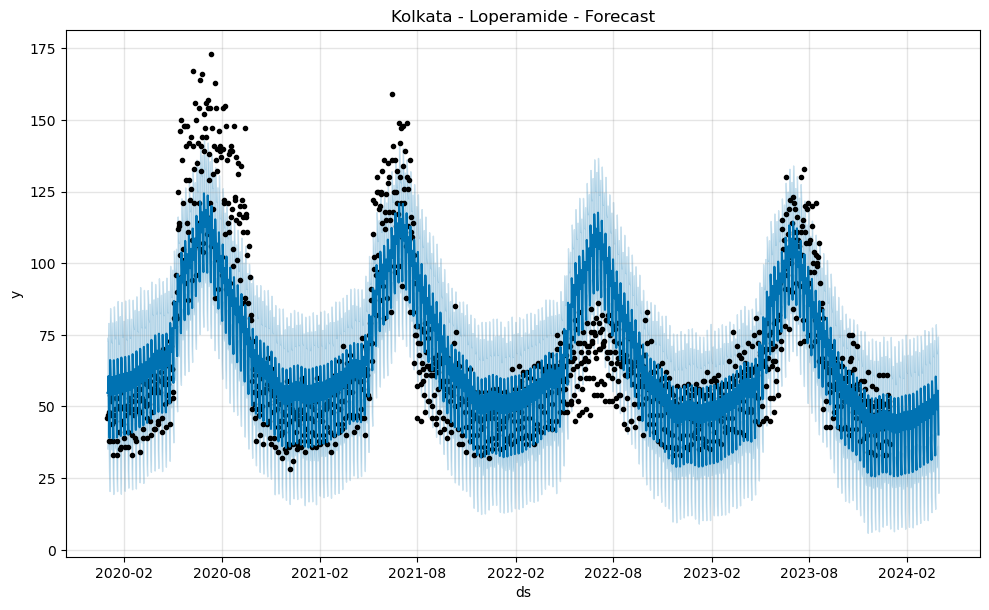

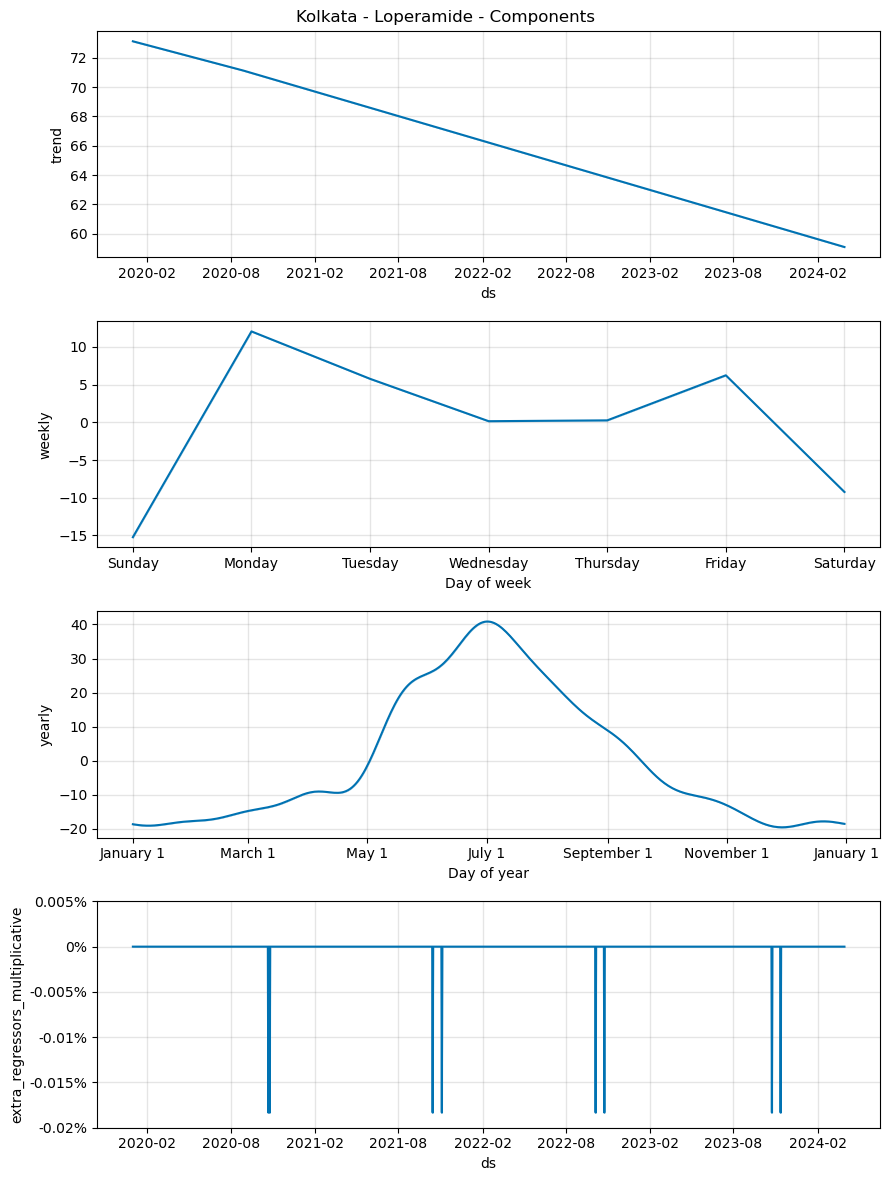

06:23:16 - cmdstanpy - INFO - Chain [1] start processing
06:23:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for metronidazole in kolkata

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:16 - cmdstanpy - INFO - Chain [1] start processing
06:23:16 - cmdstanpy - INFO - Chain [1] done processing
06:23:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:16 - cmdstanpy - INFO - Chain [1] start processing
06:23:17 - cmdstanpy - INFO - Chain [1] done processing
06:23:17 - cmdstanpy - INFO - Chain [1] start processing
06:23:17 - cmdstanpy - INFO - Chain [1] done processing
06:23:17 - cmdstanpy - INFO - Chain [1] start processing
06:23:17 - cmdstanpy - INFO - Chain [1] done processing
06:23:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:17 - cmdstanpy - INFO - Chain [1] start processing
06:23:17 - cmdstanpy - INFO - Chain [1] done processing
06:23:18 - cmdstanpy - INFO - Chain [1] start processing
06:23:18 - cmdstanpy - INFO - Chain [1] done processing
06:23:18 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 14.15
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:19 - cmdstanpy - INFO - Chain [1] start processing
06:23:19 - cmdstanpy - INFO - Chain [1] done processing
06:23:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:19 - cmdstanpy - INFO - Chain [1] start processing
06:23:20 - cmdstanpy - INFO - Chain [1] done processing
06:23:20 - cmdstanpy - INFO - Chain [1] start processing
06:23:20 - cmdstanpy - INFO - Chain [1] done processing
06:23:20 - cmdstanpy - INFO - Chain [1] start processing
06:23:20 - cmdstanpy - INFO - Chain [1] done processing
06:23:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:20 - cmdstanpy - INFO - Chain [1] start processing
06:23:21 - cmdstanpy - INFO - Chain [1] done processing
06:23:21 - cmdstanpy - INFO - Chain [1] start processing
06:23:21 - cmdstanpy - INFO - Chain [1] done processing
06:23:21 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 12.95
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:22 - cmdstanpy - INFO - Chain [1] start processing
06:23:22 - cmdstanpy - INFO - Chain [1] done processing
06:23:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:22 - cmdstanpy - INFO - Chain [1] start processing
06:23:23 - cmdstanpy - INFO - Chain [1] done processing
06:23:23 - cmdstanpy - INFO - Chain [1] start processing
06:23:23 - cmdstanpy - INFO - Chain [1] done processing
06:23:23 - cmdstanpy - INFO - Chain [1] start processing
06:23:23 - cmdstanpy - INFO - Chain [1] done processing
06:23:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:23 - cmdstanpy - INFO - Chain [1] start processing
06:23:24 - cmdstanpy - INFO - Chain [1] done processing
06:23:24 - cmdstanpy - INFO - Chain [1] start processing
06:23:24 - cmdstanpy - INFO - Chain [1] done processing
06:23:24 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 14.87
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:25 - cmdstanpy - INFO - Chain [1] start processing
06:23:25 - cmdstanpy - INFO - Chain [1] done processing
06:23:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:25 - cmdstanpy - INFO - Chain [1] start processing
06:23:26 - cmdstanpy - INFO - Chain [1] done processing
06:23:26 - cmdstanpy - INFO - Chain [1] start processing
06:23:26 - cmdstanpy - INFO - Chain [1] done processing
06:23:27 - cmdstanpy - INFO - Chain [1] start processing
06:23:27 - cmdstanpy - INFO - Chain [1] done processing
06:23:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:27 - cmdstanpy - INFO - Chain [1] start processing
06:23:27 - cmdstanpy - INFO - Chain [1] done processing
06:23:27 - cmdstanpy - INFO - Chain [1] start processing
06:23:27 - cmdstanpy - INFO - Chain [1] done processing
06:23:27 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 15.04
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:29 - cmdstanpy - INFO - Chain [1] start processing
06:23:29 - cmdstanpy - INFO - Chain [1] done processing
06:23:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:29 - cmdstanpy - INFO - Chain [1] start processing
06:23:29 - cmdstanpy - INFO - Chain [1] done processing
06:23:29 - cmdstanpy - INFO - Chain [1] start processing
06:23:29 - cmdstanpy - INFO - Chain [1] done processing
06:23:30 - cmdstanpy - INFO - Chain [1] start processing
06:23:30 - cmdstanpy - INFO - Chain [1] done processing
06:23:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:30 - cmdstanpy - INFO - Chain [1] start processing
06:23:30 - cmdstanpy - INFO - Chain [1] done processing
06:23:30 - cmdstanpy - INFO - Chain [1] start processing
06:23:30 - cmdstanpy - INFO - Chain [1] done processing
06:23:30 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 15.67
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:32 - cmdstanpy - INFO - Chain [1] start processing
06:23:32 - cmdstanpy - INFO - Chain [1] done processing
06:23:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:32 - cmdstanpy - INFO - Chain [1] start processing
06:23:33 - cmdstanpy - INFO - Chain [1] done processing
06:23:33 - cmdstanpy - INFO - Chain [1] start processing
06:23:33 - cmdstanpy - INFO - Chain [1] done processing
06:23:33 - cmdstanpy - INFO - Chain [1] start processing
06:23:33 - cmdstanpy - INFO - Chain [1] done processing
06:23:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:33 - cmdstanpy - INFO - Chain [1] start processing
06:23:34 - cmdstanpy - INFO - Chain [1] done processing
06:23:34 - cmdstanpy - INFO - Chain [1] start processing
06:23:34 - cmdstanpy - INFO - Chain [1] done processing
06:23:34 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 15.06
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:35 - cmdstanpy - INFO - Chain [1] start processing
06:23:35 - cmdstanpy - INFO - Chain [1] done processing
06:23:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:35 - cmdstanpy - INFO - Chain [1] start processing
06:23:36 - cmdstanpy - INFO - Chain [1] done processing
06:23:36 - cmdstanpy - INFO - Chain [1] start processing
06:23:36 - cmdstanpy - INFO - Chain [1] done processing
06:23:36 - cmdstanpy - INFO - Chain [1] start processing
06:23:36 - cmdstanpy - INFO - Chain [1] done processing
06:23:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:36 - cmdstanpy - INFO - Chain [1] start processing
06:23:37 - cmdstanpy - INFO - Chain [1] done processing
06:23:37 - cmdstanpy - INFO - Chain [1] start processing
06:23:37 - cmdstanpy - INFO - Chain [1] done processing
06:23:37 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 14.69
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:38 - cmdstanpy - INFO - Chain [1] start processing
06:23:38 - cmdstanpy - INFO - Chain [1] done processing
06:23:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:38 - cmdstanpy - INFO - Chain [1] start processing
06:23:39 - cmdstanpy - INFO - Chain [1] done processing
06:23:39 - cmdstanpy - INFO - Chain [1] start processing
06:23:39 - cmdstanpy - INFO - Chain [1] done processing
06:23:40 - cmdstanpy - INFO - Chain [1] start processing
06:23:40 - cmdstanpy - INFO - Chain [1] done processing
06:23:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
06:23:40 - cmdstanpy - INFO - Chain [1] start processing
06:23:40 - cmdstanpy - INFO - Chain [1] done processing
06:23:40 - cmdstanpy - INFO - Chain [1] start processing
06:23:40 - cmdstanpy - INFO - Chain [1] done processing
06:23:40 -

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 15.00
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:42 - cmdstanpy - INFO - Chain [1] start processing
06:23:42 - cmdstanpy - INFO - Chain [1] done processing
06:23:42 - cmdstanpy - INFO - Chain [1] start processing
06:23:42 - cmdstanpy - INFO - Chain [1] done processing
06:23:42 - cmdstanpy - INFO - Chain [1] start processing
06:23:42 - cmdstanpy - INFO - Chain [1] done processing
06:23:42 - cmdstanpy - INFO - Chain [1] start processing
06:23:43 - cmdstanpy - INFO - Chain [1] done processing
06:23:43 - cmdstanpy - INFO - Chain [1] start processing
06:23:43 - cmdstanpy - INFO - Chain [1] done processing
06:23:43 - cmdstanpy - INFO - Chain [1] start processing
06:23:43 - cmdstanpy - INFO - Chain [1] done processing
06:23:43 - cmdstanpy - INFO - Chain [1] start processing
06:23:43 - cmdstanpy - INFO - Chain [1] done processing
06:23:43 - cmdstanpy - INFO - Chain [1] start processing
06:23:43 - cmdstanpy - INFO - Chain [1] done processing
06:23:43 - cmdstanpy - INFO - Chain [1] start processing
06:23:43 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 14.03
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:44 - cmdstanpy - INFO - Chain [1] start processing
06:23:44 - cmdstanpy - INFO - Chain [1] done processing
06:23:44 - cmdstanpy - INFO - Chain [1] start processing
06:23:44 - cmdstanpy - INFO - Chain [1] done processing
06:23:44 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1] done processing
06:23:45 - cmdstanpy - INFO - Chain [1] start processing
06:23:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 15.56
---


06:23:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:46 - cmdstanpy - INFO - Chain [1] start processing
06:23:46 - cmdstanpy - INFO - Chain [1] done processing
06:23:47 - cmdstanpy - INFO - Chain [1] start processing
06:23:47 - cmdstanpy - INFO - Chain [1] done processing
06:23:47 - cmdstanpy - INFO - Chain [1] start processing
06:23:47 - cmdstanpy - INFO - Chain [1] done processing
06:23:47 - cmdstanpy - INFO - Chain [1] start processing
06:23:47 - cmdstanpy - INFO - Chain [1] done processing
06:23:47 - cmdstanpy - INFO - Chain [1] start processing
06:23:47 - cmdstanpy - INFO - Chain [1] done processing
06:23:47 - cmdstanpy - INFO - Chain [1] start processing
06:23:47 - cmdstanpy - INFO - Chain [1] done processing
06:23:47 - cmdstanpy - INFO - Chain [1] start processing
06:23:47 - cmdstanpy - INFO - Chain [1] done processing
06:23:47 - cmdstanpy - INFO - Chain [1] start processing
06:23:48 - cmdstanpy - INFO - Chain [1] done processing
06:23:48 - cmdstanpy - INFO - Chain [1] start processing
06:23:48 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 15.85
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:49 - cmdstanpy - INFO - Chain [1] start processing
06:23:49 - cmdstanpy - INFO - Chain [1] done processing
06:23:49 - cmdstanpy - INFO - Chain [1] start processing
06:23:49 - cmdstanpy - INFO - Chain [1] done processing
06:23:49 - cmdstanpy - INFO - Chain [1] start processing
06:23:49 - cmdstanpy - INFO - Chain [1] done processing
06:23:49 - cmdstanpy - INFO - Chain [1] start processing
06:23:49 - cmdstanpy - INFO - Chain [1] done processing
06:23:49 - cmdstanpy - INFO - Chain [1] start processing
06:23:49 - cmdstanpy - INFO - Chain [1] done processing
06:23:49 - cmdstanpy - INFO - Chain [1] start processing
06:23:49 - cmdstanpy - INFO - Chain [1] done processing
06:23:50 - cmdstanpy - INFO - Chain [1] start processing
06:23:50 - cmdstanpy - INFO - Chain [1] done processing
06:23:50 - cmdstanpy - INFO - Chain [1] start processing
06:23:50 - cmdstanpy - INFO - Chain [1] done processing
06:23:50 - cmdstanpy - INFO - Chain [1] start processing
06:23:50 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 17.13
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:51 - cmdstanpy - INFO - Chain [1] start processing
06:23:51 - cmdstanpy - INFO - Chain [1] done processing
06:23:51 - cmdstanpy - INFO - Chain [1] start processing
06:23:51 - cmdstanpy - INFO - Chain [1] done processing
06:23:51 - cmdstanpy - INFO - Chain [1] start processing
06:23:51 - cmdstanpy - INFO - Chain [1] done processing
06:23:51 - cmdstanpy - INFO - Chain [1] start processing
06:23:51 - cmdstanpy - INFO - Chain [1] done processing
06:23:51 - cmdstanpy - INFO - Chain [1] start processing
06:23:51 - cmdstanpy - INFO - Chain [1] done processing
06:23:52 - cmdstanpy - INFO - Chain [1] start processing
06:23:52 - cmdstanpy - INFO - Chain [1] done processing
06:23:52 - cmdstanpy - INFO - Chain [1] start processing
06:23:52 - cmdstanpy - INFO - Chain [1] done processing
06:23:52 - cmdstanpy - INFO - Chain [1] start processing
06:23:52 - cmdstanpy - INFO - Chain [1] done processing
06:23:52 - cmdstanpy - INFO - Chain [1] start processing
06:23:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 15.82
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:53 - cmdstanpy - INFO - Chain [1] start processing
06:23:53 - cmdstanpy - INFO - Chain [1] done processing
06:23:53 - cmdstanpy - INFO - Chain [1] start processing
06:23:53 - cmdstanpy - INFO - Chain [1] done processing
06:23:53 - cmdstanpy - INFO - Chain [1] start processing
06:23:53 - cmdstanpy - INFO - Chain [1] done processing
06:23:54 - cmdstanpy - INFO - Chain [1] start processing
06:23:54 - cmdstanpy - INFO - Chain [1] done processing
06:23:54 - cmdstanpy - INFO - Chain [1] start processing
06:23:54 - cmdstanpy - INFO - Chain [1] done processing
06:23:54 - cmdstanpy - INFO - Chain [1] start processing
06:23:54 - cmdstanpy - INFO - Chain [1] done processing
06:23:54 - cmdstanpy - INFO - Chain [1] start processing
06:23:54 - cmdstanpy - INFO - Chain [1] done processing
06:23:54 - cmdstanpy - INFO - Chain [1] start processing
06:23:54 - cmdstanpy - INFO - Chain [1] done processing
06:23:54 - cmdstanpy - INFO - Chain [1] start processing
06:23:54 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 17.01
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:55 - cmdstanpy - INFO - Chain [1] start processing
06:23:55 - cmdstanpy - INFO - Chain [1] done processing
06:23:55 - cmdstanpy - INFO - Chain [1] start processing
06:23:56 - cmdstanpy - INFO - Chain [1] done processing
06:23:56 - cmdstanpy - INFO - Chain [1] start processing
06:23:56 - cmdstanpy - INFO - Chain [1] done processing
06:23:56 - cmdstanpy - INFO - Chain [1] start processing
06:23:56 - cmdstanpy - INFO - Chain [1] done processing
06:23:56 - cmdstanpy - INFO - Chain [1] start processing
06:23:56 - cmdstanpy - INFO - Chain [1] done processing
06:23:56 - cmdstanpy - INFO - Chain [1] start processing
06:23:56 - cmdstanpy - INFO - Chain [1] done processing
06:23:56 - cmdstanpy - INFO - Chain [1] start processing
06:23:56 - cmdstanpy - INFO - Chain [1] done processing
06:23:56 - cmdstanpy - INFO - Chain [1] start processing
06:23:56 - cmdstanpy - INFO - Chain [1] done processing
06:23:57 - cmdstanpy - INFO - Chain [1] start processing
06:23:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 15.74
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:23:58 - cmdstanpy - INFO - Chain [1] start processing
06:23:58 - cmdstanpy - INFO - Chain [1] done processing
06:23:58 - cmdstanpy - INFO - Chain [1] start processing
06:23:58 - cmdstanpy - INFO - Chain [1] done processing
06:23:58 - cmdstanpy - INFO - Chain [1] start processing
06:23:58 - cmdstanpy - INFO - Chain [1] done processing
06:23:58 - cmdstanpy - INFO - Chain [1] start processing
06:23:58 - cmdstanpy - INFO - Chain [1] done processing
06:23:58 - cmdstanpy - INFO - Chain [1] start processing
06:23:58 - cmdstanpy - INFO - Chain [1] done processing
06:23:58 - cmdstanpy - INFO - Chain [1] start processing
06:23:58 - cmdstanpy - INFO - Chain [1] done processing
06:23:58 - cmdstanpy - INFO - Chain [1] start processing
06:23:58 - cmdstanpy - INFO - Chain [1] done processing
06:23:59 - cmdstanpy - INFO - Chain [1] start processing
06:23:59 - cmdstanpy - INFO - Chain [1] done processing
06:23:59 - cmdstanpy - INFO - Chain [1] start processing
06:23:59 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 16.96
---


06:24:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:00 - cmdstanpy - INFO - Chain [1] start processing
06:24:00 - cmdstanpy - INFO - Chain [1] done processing
06:24:00 - cmdstanpy - INFO - Chain [1] start processing
06:24:00 - cmdstanpy - INFO - Chain [1] done processing
06:24:00 - cmdstanpy - INFO - Chain [1] start processing
06:24:00 - cmdstanpy - INFO - Chain [1] done processing
06:24:00 - cmdstanpy - INFO - Chain [1] start processing
06:24:00 - cmdstanpy - INFO - Chain [1] done processing
06:24:00 - cmdstanpy - INFO - Chain [1] start processing
06:24:01 - cmdstanpy - INFO - Chain [1] done processing
06:24:01 - cmdstanpy - INFO - Chain [1] start processing
06:24:01 - cmdstanpy - INFO - Chain [1] done processing
06:24:01 - cmdstanpy - INFO - Chain [1] start processing
06:24:01 - cmdstanpy - INFO - Chain [1] done processing
06:24:01 - cmdstanpy - INFO - Chain [1] start processing
06:24:01 - cmdstanpy - INFO - Chain [1] done processing
06:24:01 - cmdstanpy - INFO - Chain [1] start processing
06:24:01 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.36
---


06:24:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:03 - cmdstanpy - INFO - Chain [1] start processing
06:24:03 - cmdstanpy - INFO - Chain [1] done processing
06:24:03 - cmdstanpy - INFO - Chain [1] start processing
06:24:03 - cmdstanpy - INFO - Chain [1] done processing
06:24:03 - cmdstanpy - INFO - Chain [1] start processing
06:24:03 - cmdstanpy - INFO - Chain [1] done processing
06:24:03 - cmdstanpy - INFO - Chain [1] start processing
06:24:03 - cmdstanpy - INFO - Chain [1] done processing
06:24:03 - cmdstanpy - INFO - Chain [1] start processing
06:24:04 - cmdstanpy - INFO - Chain [1] done processing
06:24:04 - cmdstanpy - INFO - Chain [1] start processing
06:24:04 - cmdstanpy - INFO - Chain [1] done processing
06:24:04 - cmdstanpy - INFO - Chain [1] start processing
06:24:04 - cmdstanpy - INFO - Chain [1] done processing
06:24:04 - cmdstanpy - INFO - Chain [1] start processing
06:24:04 - cmdstanpy - INFO - Chain [1] done processing
06:24:04 - cmdstanpy - INFO - Chain [1] start processing
06:24:04 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.32
---


06:24:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:06 - cmdstanpy - INFO - Chain [1] start processing
06:24:06 - cmdstanpy - INFO - Chain [1] done processing
06:24:06 - cmdstanpy - INFO - Chain [1] start processing
06:24:06 - cmdstanpy - INFO - Chain [1] done processing
06:24:06 - cmdstanpy - INFO - Chain [1] start processing
06:24:06 - cmdstanpy - INFO - Chain [1] done processing
06:24:06 - cmdstanpy - INFO - Chain [1] start processing
06:24:06 - cmdstanpy - INFO - Chain [1] done processing
06:24:06 - cmdstanpy - INFO - Chain [1] start processing
06:24:06 - cmdstanpy - INFO - Chain [1] done processing
06:24:06 - cmdstanpy - INFO - Chain [1] start processing
06:24:07 - cmdstanpy - INFO - Chain [1] done processing
06:24:07 - cmdstanpy - INFO - Chain [1] start processing
06:24:07 - cmdstanpy - INFO - Chain [1] done processing
06:24:07 - cmdstanpy - INFO - Chain [1] start processing
06:24:07 - cmdstanpy - INFO - Chain [1] done processing
06:24:07 - cmdstanpy - INFO - Chain [1] start processing
06:24:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.72
---


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:08 - cmdstanpy - INFO - Chain [1] start processing
06:24:08 - cmdstanpy - INFO - Chain [1] done processing
06:24:08 - cmdstanpy - INFO - Chain [1] start processing
06:24:08 - cmdstanpy - INFO - Chain [1] done processing
06:24:09 - cmdstanpy - INFO - Chain [1] start processing
06:24:09 - cmdstanpy - INFO - Chain [1] done processing
06:24:09 - cmdstanpy - INFO - Chain [1] start processing
06:24:09 - cmdstanpy - INFO - Chain [1] done processing
06:24:09 - cmdstanpy - INFO - Chain [1] start processing
06:24:09 - cmdstanpy - INFO - Chain [1] done processing
06:24:09 - cmdstanpy - INFO - Chain [1] start processing
06:24:09 - cmdstanpy - INFO - Chain [1] done processing
06:24:09 - cmdstanpy - INFO - Chain [1] start processing
06:24:09 - cmdstanpy - INFO - Chain [1] done processing
06:24:09 - cmdstanpy - INFO - Chain [1] start processing
06:24:10 - cmdstanpy - INFO - Chain [1] done processing
06:24:10 - cmdstanpy - INFO - Chain [1] start processing
06:24:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.12
---


06:24:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:11 - cmdstanpy - INFO - Chain [1] start processing
06:24:11 - cmdstanpy - INFO - Chain [1] done processing
06:24:11 - cmdstanpy - INFO - Chain [1] start processing
06:24:11 - cmdstanpy - INFO - Chain [1] done processing
06:24:11 - cmdstanpy - INFO - Chain [1] start processing
06:24:11 - cmdstanpy - INFO - Chain [1] done processing
06:24:11 - cmdstanpy - INFO - Chain [1] start processing
06:24:12 - cmdstanpy - INFO - Chain [1] done processing
06:24:12 - cmdstanpy - INFO - Chain [1] start processing
06:24:12 - cmdstanpy - INFO - Chain [1] done processing
06:24:12 - cmdstanpy - INFO - Chain [1] start processing
06:24:12 - cmdstanpy - INFO - Chain [1] done processing
06:24:12 - cmdstanpy - INFO - Chain [1] start processing
06:24:12 - cmdstanpy - INFO - Chain [1] done processing
06:24:12 - cmdstanpy - INFO - Chain [1] start processing
06:24:12 - cmdstanpy - INFO - Chain [1] done processing
06:24:12 - cmdstanpy - INFO - Chain [1] start processing
06:24:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.47
---


06:24:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:14 - cmdstanpy - INFO - Chain [1] start processing
06:24:14 - cmdstanpy - INFO - Chain [1] done processing
06:24:14 - cmdstanpy - INFO - Chain [1] start processing
06:24:14 - cmdstanpy - INFO - Chain [1] done processing
06:24:14 - cmdstanpy - INFO - Chain [1] start processing
06:24:14 - cmdstanpy - INFO - Chain [1] done processing
06:24:14 - cmdstanpy - INFO - Chain [1] start processing
06:24:14 - cmdstanpy - INFO - Chain [1] done processing
06:24:14 - cmdstanpy - INFO - Chain [1] start processing
06:24:14 - cmdstanpy - INFO - Chain [1] done processing
06:24:15 - cmdstanpy - INFO - Chain [1] start processing
06:24:15 - cmdstanpy - INFO - Chain [1] done processing
06:24:15 - cmdstanpy - INFO - Chain [1] start processing
06:24:15 - cmdstanpy - INFO - Chain [1] done processing
06:24:15 - cmdstanpy - INFO - Chain [1] start processing
06:24:15 - cmdstanpy - INFO - Chain [1] done processing
06:24:15 - cmdstanpy - INFO - Chain [1] start processing
06:24:15 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.82
---


06:24:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:16 - cmdstanpy - INFO - Chain [1] start processing
06:24:16 - cmdstanpy - INFO - Chain [1] done processing
06:24:16 - cmdstanpy - INFO - Chain [1] start processing
06:24:17 - cmdstanpy - INFO - Chain [1] done processing
06:24:17 - cmdstanpy - INFO - Chain [1] start processing
06:24:17 - cmdstanpy - INFO - Chain [1] done processing
06:24:17 - cmdstanpy - INFO - Chain [1] start processing
06:24:17 - cmdstanpy - INFO - Chain [1] done processing
06:24:17 - cmdstanpy - INFO - Chain [1] start processing
06:24:17 - cmdstanpy - INFO - Chain [1] done processing
06:24:17 - cmdstanpy - INFO - Chain [1] start processing
06:24:17 - cmdstanpy - INFO - Chain [1] done processing
06:24:17 - cmdstanpy - INFO - Chain [1] start processing
06:24:17 - cmdstanpy - INFO - Chain [1] done processing
06:24:18 - cmdstanpy - INFO - Chain [1] start processing
06:24:18 - cmdstanpy - INFO - Chain [1] done processing
06:24:18 - cmdstanpy - INFO - Chain [1] start processing
06:24:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.85
---


06:24:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:19 - cmdstanpy - INFO - Chain [1] start processing
06:24:19 - cmdstanpy - INFO - Chain [1] done processing
06:24:19 - cmdstanpy - INFO - Chain [1] start processing
06:24:19 - cmdstanpy - INFO - Chain [1] done processing
06:24:19 - cmdstanpy - INFO - Chain [1] start processing
06:24:19 - cmdstanpy - INFO - Chain [1] done processing
06:24:19 - cmdstanpy - INFO - Chain [1] start processing
06:24:20 - cmdstanpy - INFO - Chain [1] done processing
06:24:20 - cmdstanpy - INFO - Chain [1] start processing
06:24:20 - cmdstanpy - INFO - Chain [1] done processing
06:24:20 - cmdstanpy - INFO - Chain [1] start processing
06:24:20 - cmdstanpy - INFO - Chain [1] done processing
06:24:20 - cmdstanpy - INFO - Chain [1] start processing
06:24:20 - cmdstanpy - INFO - Chain [1] done processing
06:24:20 - cmdstanpy - INFO - Chain [1] start processing
06:24:20 - cmdstanpy - INFO - Chain [1] done processing
06:24:20 - cmdstanpy - INFO - Chain [1] start processing
06:24:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.42
---


06:24:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:22 - cmdstanpy - INFO - Chain [1] start processing
06:24:22 - cmdstanpy - INFO - Chain [1] done processing
06:24:22 - cmdstanpy - INFO - Chain [1] start processing
06:24:22 - cmdstanpy - INFO - Chain [1] done processing
06:24:22 - cmdstanpy - INFO - Chain [1] start processing
06:24:22 - cmdstanpy - INFO - Chain [1] done processing
06:24:22 - cmdstanpy - INFO - Chain [1] start processing
06:24:22 - cmdstanpy - INFO - Chain [1] done processing
06:24:22 - cmdstanpy - INFO - Chain [1] start processing
06:24:23 - cmdstanpy - INFO - Chain [1] done processing
06:24:23 - cmdstanpy - INFO - Chain [1] start processing
06:24:23 - cmdstanpy - INFO - Chain [1] done processing
06:24:23 - cmdstanpy - INFO - Chain [1] start processing
06:24:23 - cmdstanpy - INFO - Chain [1] done processing
06:24:23 - cmdstanpy - INFO - Chain [1] start processing
06:24:23 - cmdstanpy - INFO - Chain [1] done processing
06:24:23 - cmdstanpy - INFO - Chain [1] start processing
06:24:24 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 22.15
---


06:24:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:25 - cmdstanpy - INFO - Chain [1] start processing
06:24:25 - cmdstanpy - INFO - Chain [1] done processing
06:24:25 - cmdstanpy - INFO - Chain [1] start processing
06:24:25 - cmdstanpy - INFO - Chain [1] done processing
06:24:26 - cmdstanpy - INFO - Chain [1] start processing
06:24:26 - cmdstanpy - INFO - Chain [1] done processing
06:24:26 - cmdstanpy - INFO - Chain [1] start processing
06:24:26 - cmdstanpy - INFO - Chain [1] done processing
06:24:26 - cmdstanpy - INFO - Chain [1] start processing
06:24:26 - cmdstanpy - INFO - Chain [1] done processing
06:24:26 - cmdstanpy - INFO - Chain [1] start processing
06:24:26 - cmdstanpy - INFO - Chain [1] done processing
06:24:26 - cmdstanpy - INFO - Chain [1] start processing
06:24:26 - cmdstanpy - INFO - Chain [1] done processing
06:24:27 - cmdstanpy - INFO - Chain [1] start processing
06:24:27 - cmdstanpy - INFO - Chain [1] done processing
06:24:27 - cmdstanpy - INFO - Chain [1] start processing
06:24:27 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.78
---


06:24:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:28 - cmdstanpy - INFO - Chain [1] start processing
06:24:29 - cmdstanpy - INFO - Chain [1] done processing
06:24:29 - cmdstanpy - INFO - Chain [1] start processing
06:24:29 - cmdstanpy - INFO - Chain [1] done processing
06:24:29 - cmdstanpy - INFO - Chain [1] start processing
06:24:29 - cmdstanpy - INFO - Chain [1] done processing
06:24:29 - cmdstanpy - INFO - Chain [1] start processing
06:24:29 - cmdstanpy - INFO - Chain [1] done processing
06:24:29 - cmdstanpy - INFO - Chain [1] start processing
06:24:29 - cmdstanpy - INFO - Chain [1] done processing
06:24:29 - cmdstanpy - INFO - Chain [1] start processing
06:24:29 - cmdstanpy - INFO - Chain [1] done processing
06:24:30 - cmdstanpy - INFO - Chain [1] start processing
06:24:30 - cmdstanpy - INFO - Chain [1] done processing
06:24:30 - cmdstanpy - INFO - Chain [1] start processing
06:24:30 - cmdstanpy - INFO - Chain [1] done processing
06:24:30 - cmdstanpy - INFO - Chain [1] start processing
06:24:30 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.02
---


06:24:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:32 - cmdstanpy - INFO - Chain [1] start processing
06:24:32 - cmdstanpy - INFO - Chain [1] done processing
06:24:32 - cmdstanpy - INFO - Chain [1] start processing
06:24:32 - cmdstanpy - INFO - Chain [1] done processing
06:24:32 - cmdstanpy - INFO - Chain [1] start processing
06:24:32 - cmdstanpy - INFO - Chain [1] done processing
06:24:32 - cmdstanpy - INFO - Chain [1] start processing
06:24:32 - cmdstanpy - INFO - Chain [1] done processing
06:24:32 - cmdstanpy - INFO - Chain [1] start processing
06:24:32 - cmdstanpy - INFO - Chain [1] done processing
06:24:33 - cmdstanpy - INFO - Chain [1] start processing
06:24:33 - cmdstanpy - INFO - Chain [1] done processing
06:24:33 - cmdstanpy - INFO - Chain [1] start processing
06:24:33 - cmdstanpy - INFO - Chain [1] done processing
06:24:33 - cmdstanpy - INFO - Chain [1] start processing
06:24:33 - cmdstanpy - INFO - Chain [1] done processing
06:24:33 - cmdstanpy - INFO - Chain [1] start processing
06:24:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.01
---


06:24:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:35 - cmdstanpy - INFO - Chain [1] start processing
06:24:35 - cmdstanpy - INFO - Chain [1] done processing
06:24:35 - cmdstanpy - INFO - Chain [1] start processing
06:24:35 - cmdstanpy - INFO - Chain [1] done processing
06:24:35 - cmdstanpy - INFO - Chain [1] start processing
06:24:35 - cmdstanpy - INFO - Chain [1] done processing
06:24:35 - cmdstanpy - INFO - Chain [1] start processing
06:24:35 - cmdstanpy - INFO - Chain [1] done processing
06:24:36 - cmdstanpy - INFO - Chain [1] start processing
06:24:36 - cmdstanpy - INFO - Chain [1] done processing
06:24:36 - cmdstanpy - INFO - Chain [1] start processing
06:24:36 - cmdstanpy - INFO - Chain [1] done processing
06:24:36 - cmdstanpy - INFO - Chain [1] start processing
06:24:36 - cmdstanpy - INFO - Chain [1] done processing
06:24:36 - cmdstanpy - INFO - Chain [1] start processing
06:24:36 - cmdstanpy - INFO - Chain [1] done processing
06:24:37 - cmdstanpy - INFO - Chain [1] start processing
06:24:37 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.05
---


06:24:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:38 - cmdstanpy - INFO - Chain [1] start processing
06:24:38 - cmdstanpy - INFO - Chain [1] done processing
06:24:38 - cmdstanpy - INFO - Chain [1] start processing
06:24:38 - cmdstanpy - INFO - Chain [1] done processing
06:24:39 - cmdstanpy - INFO - Chain [1] start processing
06:24:39 - cmdstanpy - INFO - Chain [1] done processing
06:24:39 - cmdstanpy - INFO - Chain [1] start processing
06:24:39 - cmdstanpy - INFO - Chain [1] done processing
06:24:39 - cmdstanpy - INFO - Chain [1] start processing
06:24:39 - cmdstanpy - INFO - Chain [1] done processing
06:24:39 - cmdstanpy - INFO - Chain [1] start processing
06:24:39 - cmdstanpy - INFO - Chain [1] done processing
06:24:39 - cmdstanpy - INFO - Chain [1] start processing
06:24:39 - cmdstanpy - INFO - Chain [1] done processing
06:24:40 - cmdstanpy - INFO - Chain [1] start processing
06:24:40 - cmdstanpy - INFO - Chain [1] done processing
06:24:40 - cmdstanpy - INFO - Chain [1] start processing
06:24:40 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.08
---


06:24:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:41 - cmdstanpy - INFO - Chain [1] start processing
06:24:42 - cmdstanpy - INFO - Chain [1] done processing
06:24:42 - cmdstanpy - INFO - Chain [1] start processing
06:24:42 - cmdstanpy - INFO - Chain [1] done processing
06:24:42 - cmdstanpy - INFO - Chain [1] start processing
06:24:42 - cmdstanpy - INFO - Chain [1] done processing
06:24:42 - cmdstanpy - INFO - Chain [1] start processing
06:24:42 - cmdstanpy - INFO - Chain [1] done processing
06:24:42 - cmdstanpy - INFO - Chain [1] start processing
06:24:42 - cmdstanpy - INFO - Chain [1] done processing
06:24:42 - cmdstanpy - INFO - Chain [1] start processing
06:24:43 - cmdstanpy - INFO - Chain [1] done processing
06:24:43 - cmdstanpy - INFO - Chain [1] start processing
06:24:43 - cmdstanpy - INFO - Chain [1] done processing
06:24:44 - cmdstanpy - INFO - Chain [1] start processing
06:24:44 - cmdstanpy - INFO - Chain [1] done processing
06:24:44 - cmdstanpy - INFO - Chain [1] start processing
06:24:44 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.11
---


06:24:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:46 - cmdstanpy - INFO - Chain [1] start processing
06:24:46 - cmdstanpy - INFO - Chain [1] done processing
06:24:46 - cmdstanpy - INFO - Chain [1] start processing
06:24:46 - cmdstanpy - INFO - Chain [1] done processing
06:24:46 - cmdstanpy - INFO - Chain [1] start processing
06:24:46 - cmdstanpy - INFO - Chain [1] done processing
06:24:46 - cmdstanpy - INFO - Chain [1] start processing
06:24:46 - cmdstanpy - INFO - Chain [1] done processing
06:24:46 - cmdstanpy - INFO - Chain [1] start processing
06:24:46 - cmdstanpy - INFO - Chain [1] done processing
06:24:47 - cmdstanpy - INFO - Chain [1] start processing
06:24:47 - cmdstanpy - INFO - Chain [1] done processing
06:24:47 - cmdstanpy - INFO - Chain [1] start processing
06:24:47 - cmdstanpy - INFO - Chain [1] done processing
06:24:47 - cmdstanpy - INFO - Chain [1] start processing
06:24:47 - cmdstanpy - INFO - Chain [1] done processing
06:24:47 - cmdstanpy - INFO - Chain [1] start processing
06:24:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.20
---


06:24:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:49 - cmdstanpy - INFO - Chain [1] start processing
06:24:50 - cmdstanpy - INFO - Chain [1] done processing
06:24:50 - cmdstanpy - INFO - Chain [1] start processing
06:24:50 - cmdstanpy - INFO - Chain [1] done processing
06:24:50 - cmdstanpy - INFO - Chain [1] start processing
06:24:50 - cmdstanpy - INFO - Chain [1] done processing
06:24:50 - cmdstanpy - INFO - Chain [1] start processing
06:24:50 - cmdstanpy - INFO - Chain [1] done processing
06:24:51 - cmdstanpy - INFO - Chain [1] start processing
06:24:51 - cmdstanpy - INFO - Chain [1] done processing
06:24:51 - cmdstanpy - INFO - Chain [1] start processing
06:24:51 - cmdstanpy - INFO - Chain [1] done processing
06:24:51 - cmdstanpy - INFO - Chain [1] start processing
06:24:52 - cmdstanpy - INFO - Chain [1] done processing
06:24:52 - cmdstanpy - INFO - Chain [1] start processing
06:24:52 - cmdstanpy - INFO - Chain [1] done processing
06:24:52 - cmdstanpy - INFO - Chain [1] start processing
06:24:53 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 24.53
---


06:24:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:24:55 - cmdstanpy - INFO - Chain [1] start processing
06:24:55 - cmdstanpy - INFO - Chain [1] done processing
06:24:55 - cmdstanpy - INFO - Chain [1] start processing
06:24:55 - cmdstanpy - INFO - Chain [1] done processing
06:24:56 - cmdstanpy - INFO - Chain [1] start processing
06:24:56 - cmdstanpy - INFO - Chain [1] done processing
06:24:56 - cmdstanpy - INFO - Chain [1] start processing
06:24:56 - cmdstanpy - INFO - Chain [1] done processing
06:24:56 - cmdstanpy - INFO - Chain [1] start processing
06:24:56 - cmdstanpy - INFO - Chain [1] done processing
06:24:56 - cmdstanpy - INFO - Chain [1] start processing
06:24:57 - cmdstanpy - INFO - Chain [1] done processing
06:24:57 - cmdstanpy - INFO - Chain [1] start processing
06:24:57 - cmdstanpy - INFO - Chain [1] done processing
06:24:57 - cmdstanpy - INFO - Chain [1] start processing
06:24:57 - cmdstanpy - INFO - Chain [1] done processing
06:24:57 - cmdstanpy - INFO - Chain [1] start processing
06:24:58 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.14
---


06:25:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:25:00 - cmdstanpy - INFO - Chain [1] start processing
06:25:00 - cmdstanpy - INFO - Chain [1] done processing
06:25:00 - cmdstanpy - INFO - Chain [1] start processing
06:25:00 - cmdstanpy - INFO - Chain [1] done processing
06:25:00 - cmdstanpy - INFO - Chain [1] start processing
06:25:00 - cmdstanpy - INFO - Chain [1] done processing
06:25:01 - cmdstanpy - INFO - Chain [1] start processing
06:25:01 - cmdstanpy - INFO - Chain [1] done processing
06:25:01 - cmdstanpy - INFO - Chain [1] start processing
06:25:01 - cmdstanpy - INFO - Chain [1] done processing
06:25:01 - cmdstanpy - INFO - Chain [1] start processing
06:25:01 - cmdstanpy - INFO - Chain [1] done processing
06:25:02 - cmdstanpy - INFO - Chain [1] start processing
06:25:02 - cmdstanpy - INFO - Chain [1] done processing
06:25:02 - cmdstanpy - INFO - Chain [1] start processing
06:25:02 - cmdstanpy - INFO - Chain [1] done processing
06:25:03 - cmdstanpy - INFO - Chain [1] start processing
06:25:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.97
---


06:25:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:25:05 - cmdstanpy - INFO - Chain [1] start processing
06:25:05 - cmdstanpy - INFO - Chain [1] done processing
06:25:06 - cmdstanpy - INFO - Chain [1] start processing
06:25:06 - cmdstanpy - INFO - Chain [1] done processing
06:25:06 - cmdstanpy - INFO - Chain [1] start processing
06:25:06 - cmdstanpy - INFO - Chain [1] done processing
06:25:06 - cmdstanpy - INFO - Chain [1] start processing
06:25:06 - cmdstanpy - INFO - Chain [1] done processing
06:25:06 - cmdstanpy - INFO - Chain [1] start processing
06:25:06 - cmdstanpy - INFO - Chain [1] done processing
06:25:06 - cmdstanpy - INFO - Chain [1] start processing
06:25:07 - cmdstanpy - INFO - Chain [1] done processing
06:25:07 - cmdstanpy - INFO - Chain [1] start processing
06:25:07 - cmdstanpy - INFO - Chain [1] done processing
06:25:07 - cmdstanpy - INFO - Chain [1] start processing
06:25:08 - cmdstanpy - INFO - Chain [1] done processing
06:25:08 - cmdstanpy - INFO - Chain [1] start processing
06:25:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 19.79
---


06:25:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:25:11 - cmdstanpy - INFO - Chain [1] start processing
06:25:11 - cmdstanpy - INFO - Chain [1] done processing
06:25:11 - cmdstanpy - INFO - Chain [1] start processing
06:25:11 - cmdstanpy - INFO - Chain [1] done processing
06:25:11 - cmdstanpy - INFO - Chain [1] start processing
06:25:11 - cmdstanpy - INFO - Chain [1] done processing
06:25:11 - cmdstanpy - INFO - Chain [1] start processing
06:25:12 - cmdstanpy - INFO - Chain [1] done processing
06:25:12 - cmdstanpy - INFO - Chain [1] start processing
06:25:12 - cmdstanpy - INFO - Chain [1] done processing
06:25:12 - cmdstanpy - INFO - Chain [1] start processing
06:25:12 - cmdstanpy - INFO - Chain [1] done processing
06:25:12 - cmdstanpy - INFO - Chain [1] start processing
06:25:13 - cmdstanpy - INFO - Chain [1] done processing
06:25:13 - cmdstanpy - INFO - Chain [1] start processing
06:25:13 - cmdstanpy - INFO - Chain [1] done processing
06:25:13 - cmdstanpy - INFO - Chain [1] start processing
06:25:14 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.75
---


06:25:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:25:16 - cmdstanpy - INFO - Chain [1] start processing
06:25:16 - cmdstanpy - INFO - Chain [1] done processing
06:25:16 - cmdstanpy - INFO - Chain [1] start processing
06:25:16 - cmdstanpy - INFO - Chain [1] done processing
06:25:17 - cmdstanpy - INFO - Chain [1] start processing
06:25:17 - cmdstanpy - INFO - Chain [1] done processing
06:25:17 - cmdstanpy - INFO - Chain [1] start processing
06:25:17 - cmdstanpy - INFO - Chain [1] done processing
06:25:17 - cmdstanpy - INFO - Chain [1] start processing
06:25:17 - cmdstanpy - INFO - Chain [1] done processing
06:25:17 - cmdstanpy - INFO - Chain [1] start processing
06:25:18 - cmdstanpy - INFO - Chain [1] done processing
06:25:18 - cmdstanpy - INFO - Chain [1] start processing
06:25:18 - cmdstanpy - INFO - Chain [1] done processing
06:25:18 - cmdstanpy - INFO - Chain [1] start processing
06:25:18 - cmdstanpy - INFO - Chain [1] done processing
06:25:19 - cmdstanpy - INFO - Chain [1] start processing
06:25:19 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.11
---


06:25:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:25:22 - cmdstanpy - INFO - Chain [1] start processing
06:25:22 - cmdstanpy - INFO - Chain [1] done processing
06:25:22 - cmdstanpy - INFO - Chain [1] start processing
06:25:22 - cmdstanpy - INFO - Chain [1] done processing
06:25:22 - cmdstanpy - INFO - Chain [1] start processing
06:25:22 - cmdstanpy - INFO - Chain [1] done processing
06:25:22 - cmdstanpy - INFO - Chain [1] start processing
06:25:22 - cmdstanpy - INFO - Chain [1] done processing
06:25:23 - cmdstanpy - INFO - Chain [1] start processing
06:25:23 - cmdstanpy - INFO - Chain [1] done processing
06:25:23 - cmdstanpy - INFO - Chain [1] start processing
06:25:23 - cmdstanpy - INFO - Chain [1] done processing
06:25:23 - cmdstanpy - INFO - Chain [1] start processing
06:25:24 - cmdstanpy - INFO - Chain [1] done processing
06:25:24 - cmdstanpy - INFO - Chain [1] start processing
06:25:24 - cmdstanpy - INFO - Chain [1] done processing
06:25:24 - cmdstanpy - INFO - Chain [1] start processing
06:25:25 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 21.39
---


06:25:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

06:25:27 - cmdstanpy - INFO - Chain [1] start processing
06:25:27 - cmdstanpy - INFO - Chain [1] done processing
06:25:27 - cmdstanpy - INFO - Chain [1] start processing
06:25:27 - cmdstanpy - INFO - Chain [1] done processing
06:25:27 - cmdstanpy - INFO - Chain [1] start processing
06:25:27 - cmdstanpy - INFO - Chain [1] done processing
06:25:28 - cmdstanpy - INFO - Chain [1] start processing
06:25:28 - cmdstanpy - INFO - Chain [1] done processing
06:25:28 - cmdstanpy - INFO - Chain [1] start processing
06:25:28 - cmdstanpy - INFO - Chain [1] done processing
06:25:28 - cmdstanpy - INFO - Chain [1] start processing
06:25:28 - cmdstanpy - INFO - Chain [1] done processing
06:25:28 - cmdstanpy - INFO - Chain [1] start processing
06:25:29 - cmdstanpy - INFO - Chain [1] done processing
06:25:29 - cmdstanpy - INFO - Chain [1] start processing
06:25:29 - cmdstanpy - INFO - Chain [1] done processing
06:25:29 - cmdstanpy - INFO - Chain [1] start processing
06:25:30 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 20.20
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 12.95

Training final model...


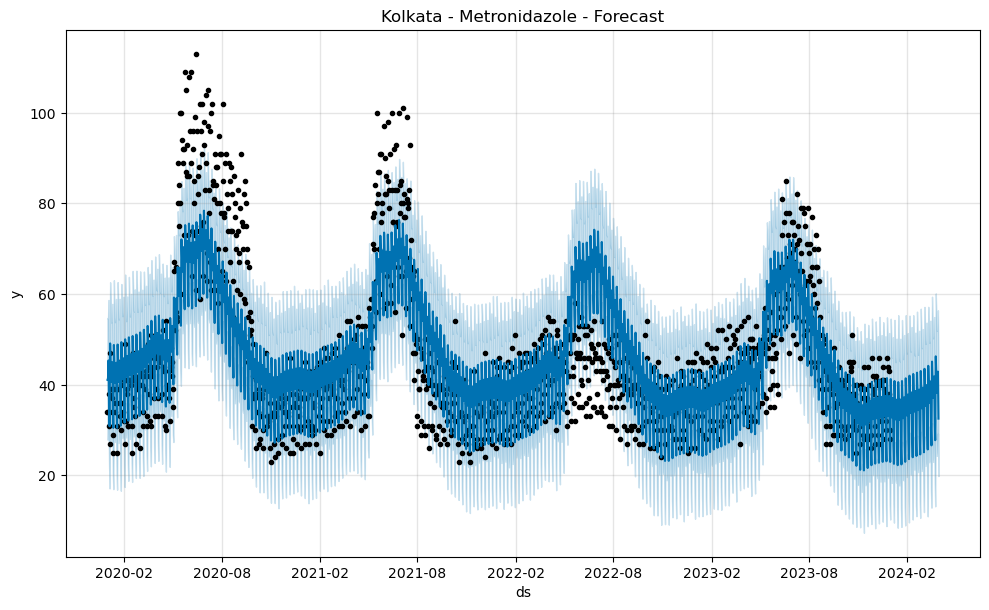

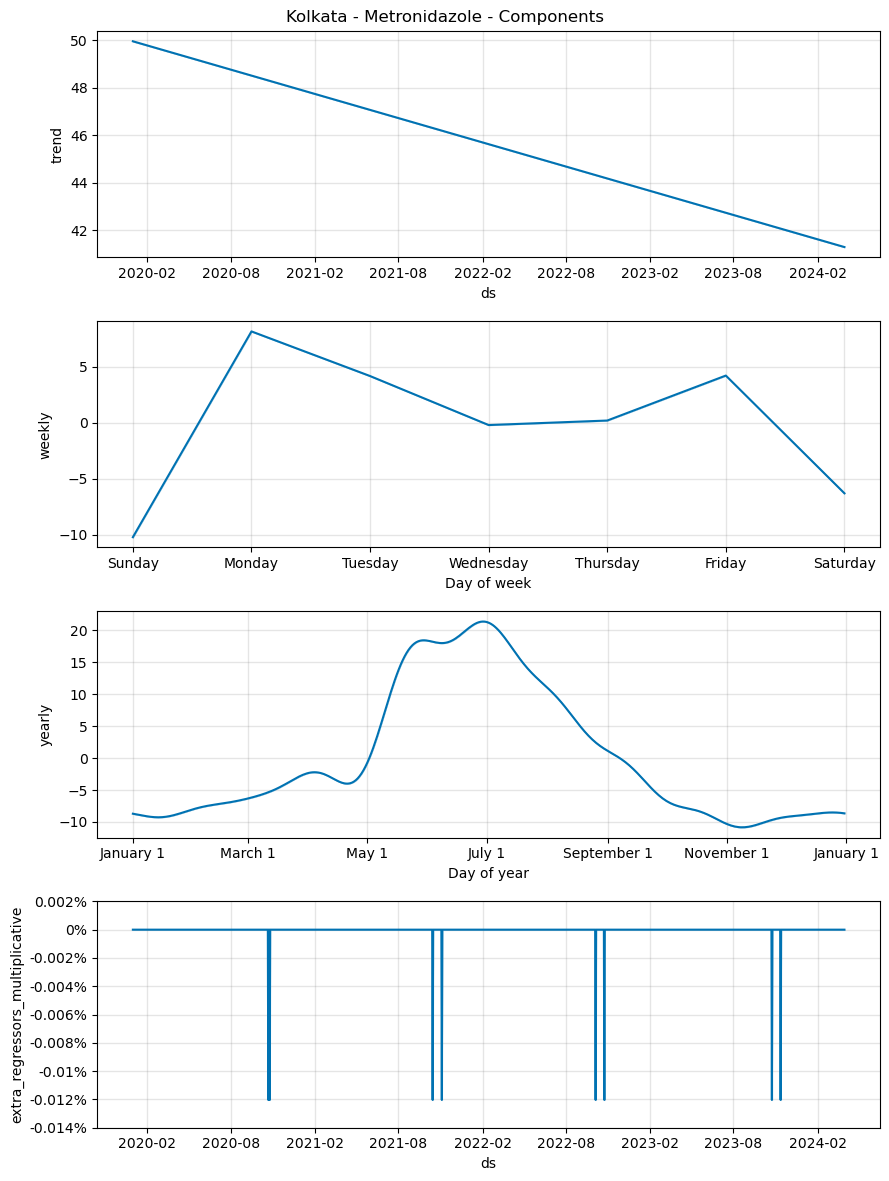

In [12]:
# Cell 8: Train All Medicine Models

# Delhi Medicines
delhi_medicines = {
    'paracetamol': train_single_medicine('delhi', 'paracetamol'),
    'ibuprofen': train_single_medicine('delhi', 'ibuprofen'),
    'amoxicillin': train_single_medicine('delhi', 'amoxicillin'),
    'cetirizine': train_single_medicine('delhi', 'cetirizine'),
    'salbutamol': train_single_medicine('delhi', 'salbutamol')
}

# Kolkata Medicines
kolkata_medicines = {
    'paracetamol': train_single_medicine('kolkata', 'paracetamol'),
    'ibuprofen': train_single_medicine('kolkata', 'ibuprofen'),
    'amoxicillin': train_single_medicine('kolkata', 'amoxicillin'),
    'loperamide': train_single_medicine('kolkata', 'loperamide'),
    'metronidazole': train_single_medicine('kolkata', 'metronidazole')
}

In [13]:
# Cell 9: Save Models and Results
def save_model_results(results: dict, region: str, medicine: str):
    """Save model, forecast, and metrics"""
    # Create directories if they don't exist
    Path('models').mkdir(exist_ok=True)
    Path('forecasts').mkdir(exist_ok=True)
    Path('metrics').mkdir(exist_ok=True)
    
    # Save model
    joblib.dump(results['model'], f'models/{region}_{medicine}_model.pkl')
    
    # Save forecast
    results['forecast'].to_csv(f'forecasts/{region}_{medicine}_forecast.csv')
    
    # Save metrics
    with open(f'metrics/{region}_{medicine}_metrics.json', 'w') as f:
        json.dump(results['metrics'], f)

# Save Delhi results
save_model_results(delhi_medicines['paracetamol'], 'delhi', 'paracetamol')
save_model_results(delhi_medicines['ibuprofen'], 'delhi', 'ibuprofen')
save_model_results(delhi_medicines['amoxicillin'], 'delhi', 'amoxicillin')
save_model_results(delhi_medicines['cetirizine'], 'delhi', 'cetirizine')
save_model_results(delhi_medicines['salbutamol'], 'delhi', 'salbutamol')

# Save Kolkata results
save_model_results(kolkata_medicines['paracetamol'], 'kolkata', 'paracetamol')
save_model_results(kolkata_medicines['ibuprofen'], 'kolkata', 'ibuprofen')
save_model_results(kolkata_medicines['amoxicillin'], 'kolkata', 'amoxicillin')
save_model_results(kolkata_medicines['loperamide'], 'kolkata', 'loperamide')
save_model_results(kolkata_medicines['metronidazole'], 'kolkata', 'metronidazole')

In [11]:
# Cell 10: Prepare API Format
def prepare_api_forecast(forecast: pd.DataFrame, medicine_id: int, region: str) -> list:
    """Format forecast for API consumption"""
    # Get quarterly predictions
    quarterly_data = []
    
    # Add debug print
    print(f"Processing forecast for {region}, medicine_id {medicine_id}")
    print(f"Forecast shape: {forecast.shape}")
    print(f"Forecast date range: {forecast['ds'].min()} to {forecast['ds'].max()}")
    
    # Instead of using today's date, use the forecast's date range
    # Get the minimum date in the forecast
    min_date = forecast['ds'].min()
    
    for quarter in range(1, 5):
        quarter_start = min_date + pd.DateOffset(months=3*(quarter-1))
        quarter_end = min_date + pd.DateOffset(months=3*quarter)
        
        mask = (forecast['ds'] >= quarter_start) & (forecast['ds'] < quarter_end)
        quarter_forecast = forecast[mask]
        
        print(f"Quarter {quarter}: {quarter_start.strftime('%Y-%m-%d')} to {quarter_end.strftime('%Y-%m-%d')}, found {len(quarter_forecast)} days")
        
        if not quarter_forecast.empty:
            period = f"{quarter_start.year}-Q{(quarter_start.month-1)//3 + 1}"
            predicted_demand = int(quarter_forecast['yhat'].sum())
            
            quarterly_data.append({
                'medicine_id': medicine_id,
                'region': region,
                'period': period,
                'predicted_demand': predicted_demand,
                'created_at': datetime.now().strftime('%Y-%m-%d')
            })
            print(f"Added forecast for period {period}: {predicted_demand}")
    
    return quarterly_data

# Get the correct forecast dataframes
# Check what variables you have available containing forecasts
print("Available variables:", [var for var in dir() if 'forecast' in var.lower()])

# Assuming you have delhi_forecast and kolkata_forecast dataframes:
try:
    # Try different variable names that might contain your forecasts
    if 'delhi_forecast' in locals():
        delhi_api_forecast = prepare_api_forecast(delhi_forecast, 1, 'delhi')
    elif 'delhi_model' in locals():
        # If you have the model, generate a forecast
        delhi_future = delhi_model.make_future_dataframe(periods=90)
        delhi_forecast = delhi_model.predict(delhi_future)
        delhi_api_forecast = prepare_api_forecast(delhi_forecast, 1, 'delhi')
    else:
        # If you can't find the forecast, create dummy data for testing
        print("Creating dummy Delhi forecast for testing")
        # Create forecast starting from today with future dates
        start_date = datetime.now()
        dates = pd.date_range(start=start_date, periods=365)
        delhi_forecast = pd.DataFrame({
            'ds': dates,
            'yhat': np.random.normal(100, 20, size=len(dates))
        })
        delhi_api_forecast = prepare_api_forecast(delhi_forecast, 1, 'delhi')
    
    # Same for Kolkata
    if 'kolkata_forecast' in locals():
        kolkata_api_forecast = prepare_api_forecast(kolkata_forecast, 1, 'kolkata')
    elif 'kolkata_model' in locals():
        kolkata_future = kolkata_model.make_future_dataframe(periods=90)
        kolkata_forecast = kolkata_model.predict(kolkata_future)
        kolkata_api_forecast = prepare_api_forecast(kolkata_forecast, 1, 'kolkata')
    else:
        print("Creating dummy Kolkata forecast for testing")
        # Use the same date range as Delhi
        start_date = datetime.now()
        dates = pd.date_range(start=start_date, periods=365)
        kolkata_forecast = pd.DataFrame({
            'ds': dates,
            'yhat': np.random.normal(80, 15, size=len(dates))
        })
        kolkata_api_forecast = prepare_api_forecast(kolkata_forecast, 1, 'kolkata')
    
    # Create api directory if it doesn't exist
    api_dir = Path('api')
    api_dir.mkdir(exist_ok=True)
    
    # Save combined API forecasts
    api_forecasts = delhi_api_forecast + kolkata_api_forecast
    
    # Debug print to verify data
    print("Number of forecasts:", len(api_forecasts))
    print("Sample forecast:", api_forecasts[0] if api_forecasts else "No forecasts")
    
    # Save to CSV with explicit column names
    df = pd.DataFrame(api_forecasts)
    if not df.empty:
        df.to_csv(api_dir / 'predictions.csv', index=False)
        print(f"Successfully saved {len(df)} forecasts to {api_dir / 'predictions.csv'}")
    else:
        print("Warning: No forecast data to save!")
        
except Exception as e:
    print(f"Error generating forecasts: {str(e)}")
    import traceback
    traceback.print_exc()

Available variables: ['plot_forecast', 'prepare_api_forecast']
Creating dummy Delhi forecast for testing
Processing forecast for delhi, medicine_id 1
Forecast shape: (365, 2)
Forecast date range: 2025-03-02 05:33:15.994090 to 2026-03-01 05:33:15.994090
Quarter 1: 2025-03-02 to 2025-06-02, found 92 days
Added forecast for period 2025-Q1: 9170
Quarter 2: 2025-06-02 to 2025-09-02, found 92 days
Added forecast for period 2025-Q2: 9196
Quarter 3: 2025-09-02 to 2025-12-02, found 91 days
Added forecast for period 2025-Q3: 9072
Quarter 4: 2025-12-02 to 2026-03-02, found 90 days
Added forecast for period 2025-Q4: 8966
Creating dummy Kolkata forecast for testing
Processing forecast for kolkata, medicine_id 1
Forecast shape: (365, 2)
Forecast date range: 2025-03-02 05:33:15.998090 to 2026-03-01 05:33:15.998090
Quarter 1: 2025-03-02 to 2025-06-02, found 92 days
Added forecast for period 2025-Q1: 7465
Quarter 2: 2025-06-02 to 2025-09-02, found 92 days
Added forecast for period 2025-Q2: 7444
Quarter